In [1]:
import sys
#sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

#import pydot

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[100,100,100],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points4_small_offset.csv")
geo_data.n_faults = 1

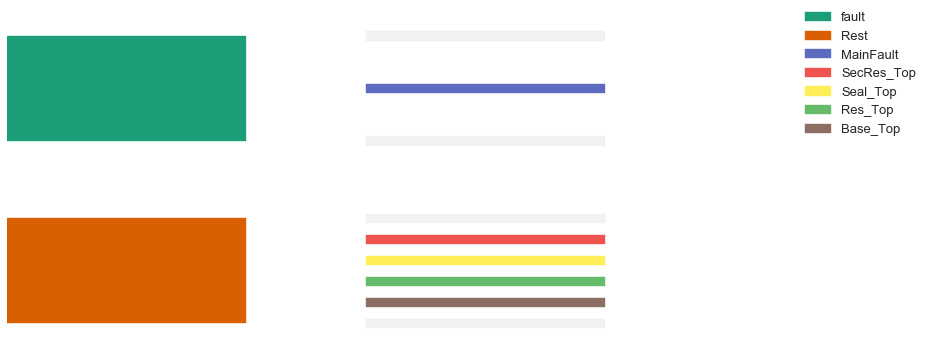

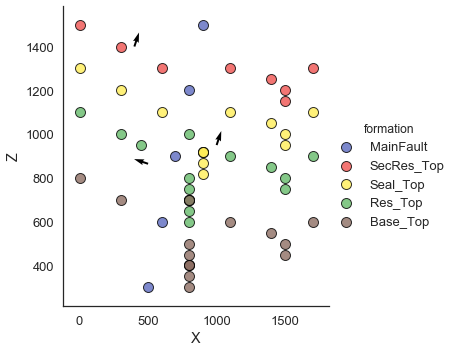

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

gp.plot_data(geo_data)

In [4]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

In [5]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3, 3],
                                   compile_theano=True, dtype ='float64')

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [6]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [7]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [8]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))
#fault_surf, fault_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['MainFault']))

In [9]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=False
                   )

In [10]:
#export = True
#
#if export:
#    gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(lith_sol[0]), path="original model")

In [11]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

C:\Users\Fabian\Anaconda3\lib\site-packages\gempy\Visualization.py:253: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  im = plt.imshow(plot_block[_a, _b, _c].T, origin="bottom", cmap=self._cmap, norm=self._norm,


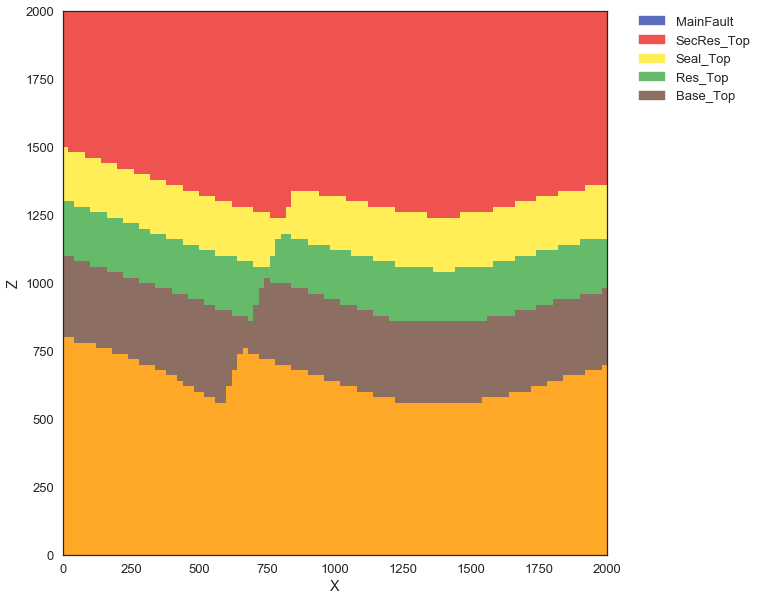

In [12]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data=0)

In [13]:
# FUNCTION TO FIND ANTICLINAL SPILL POINT AND CROSS-FAULT LEAK POINT

    #@staticmethod # possibly use to find saddle points!
    #def squared_euclidean_distances(x_1, x_2):
    #    """
    #    Compute the euclidian distances in 3D between all the points in x_1 and x_2
    #    Args:
    #        x_1 (theano.tensor.matrix): shape n_points x number dimension
    #        x_2 (theano.tensor.matrix): shape n_points x number dimension
#
    #    Returns:
    #        theano.tensor.matrix: Distancse matrix. shape n_points x n_points
    #    """
#
    #    # T.maximum avoid negative numbers increasing stability
    #    sqd = T.sqrt(T.maximum(
    #        (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    #        (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    #        2 * x_1.dot(x_2.T), 0
    #    ))
#
    #    return sqd

def spill_leak_P(interp_data, res_surf, lith, fault, print_figures=False):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering - not used atm
    # supposed to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    
    #fleak_line_z0 = grid_z0[fleak_line]
    #leak_max = fleak_line==np.nanargmax(fleak_line_z0)
    #print(np.nanargmax(fleak_line_z0))
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
    pot_spill_points = saddle_p_all - pot_leak_points    # substracting leak bool from saddle point bool 
                                                    # to get spill point bool    
    # leak and spill point 3D coordinates
    # LEAK POINT
    #if juxtaposition_over_seal(lith, fault) == True: #check for juxtaposition with layers above seal (due to offset)
    
    pot_leak_Xcoord = grid_x[pot_leak_points]
    pot_leak_Ycoord = grid_y[pot_leak_points]
    pot_leak_Zcoord = grid_z0[pot_leak_points]    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
        
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[pot_spill_points]
    pot_spill_Ycoord = grid_y[pot_spill_points]
    pot_spill_Zcoord = grid_z0[pot_spill_points]    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
    #print('SP',anticline_spill_3Dcoord)
    #print('LP',fault_leak_3Dcoord)
    
    # PLOTTING (for visualization and checking)
    # plot of min/max bools and all potential LPs(+) and SPs(x):
    if print_figures==True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
        ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
        # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
        plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [14]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) # rounding up scale_factor or rescale_f?
    mask = mask.reshape(resolution,resolution,resolution) #(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(lith, fault, fault_seal, seal_th):
    #fig = plt.figure()
    traps = []
    SSF = 0
    trap_control = 0
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
    gp.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["8"].keys()] # model border sections
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    res_nr = interp_data.get_formation_number()['Base_Top']
    base_keys = [int(b) for b in lith_to_labels_lot["0"].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    # If too many traps, model probably broken:
    print("NUMBER OF TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask, SSF, trap_control
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology_check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                fault_seal_bool, SSF, trap_control = juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th)
                if fault_seal_bool == True:
                    traps.append(tk)
                    print('TRAP:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask, SSF, trap_control # this mask returns True for all voxels which were accepted as trap voxels

In [15]:
def juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th):
    throw = 0
    jp=0
    trap_c = 4
    # FIRST: check the adjacency area only for the trap: only the point of highest throw is relevant for SSF
    for tk in res_keys:
        for ok in tot_over_keys:  
            if gp.topology_check_adjacency(G, tk, ok) == True:
                if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
                    print("Stratigraphic adjacency, leakage assumed!")
                    sealing = False
                    SSF = 0
                    trap_c = 4
                    return sealing, SSF, trap_c                     # stratigraphic adjancency assumed to always leak
                elif G.adj[tk][ok]['edge_type'] == 'fault':
                    trap_jshape = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[3]
                    # fault throw at edge of trap section, voxels*scale_factor to get height in [m]
                    if trap_jshape !=0:
                        y_ext = trap_jshape[1]
                        z_ext = trap_jshape[2]
                        # finding point of greatest throw for trap --> relevant for total fault throw and SSF
                        # bottom of trap is flat, so need to find only highest z-values for juxtaposition:
                        z_max = max(z_ext)
                        # finding the y.axis range in which this highest throw appears:
                        y_range = y_ext[z_ext==z_max]
                        y_min = min(y_range)
                        y_max = max(y_range)
                        ## creating mask where values within this range = True --> to appl
                        #y_ext_bool = np.logical_and(y_ext>=y_min, y_ext<=y_max)
                        #y_bool_mask = np.copy(y_ext)
                        #y_bool_mask[~y_ext_bool] = False
                        #y_bool_mask[y_ext_bool] = True
                        ## the following can be used to find the throw height for one area
                        #y_bool = y_bool_mask==True
                        #print(z_ext[len_bool])
                        jp+=1
                        
    # SECOND: check for adjancencies between all seal-underlying and seal-overlying formations to
    # determine total fault throw at point/range defined over trap (y_bool)
    if jp != 0:
        for uk in tot_under_keys:
            for ok in tot_over_keys:  
                if gp.topology_check_adjacency(G, uk, ok) == True:
                    #print("Adjacency with section:", ok)
                    if G.adj[uk][ok]['edge_type'] == 'stratigraphic':
                        print("Stratigraphic adjacency, leakage assumed!")
                        sealing = False
                        SSF = 0
                        trap_c = 4
                        return sealing, SSF, trap_c     # stratigraphic adjancency assumed to always leak
                    elif G.adj[uk][ok]['edge_type'] == 'fault':
                        # get the array for z-extent for this adj-area, then mask to relevant range
                        section_jshape = gp.Topology.compute_adj_shape(uk,ok,topo_block, ext=None)[3]
                        if section_jshape != 0:
                            section_z_ext = section_jshape[2]
                            # creating mask where values within this range = True --> to appl
                            section_y_ext = section_jshape[1]
                            y_ext_bool = np.logical_and(section_y_ext>=y_min, section_y_ext<=y_max)
                            y_bool_mask = np.copy(section_y_ext)
                            y_bool_mask[~y_ext_bool] = False
                            y_bool_mask[y_ext_bool] = True
                            #print(y_min, y_max)
                            #print(section_y_ext)
                            if np.count_nonzero(y_bool_mask) != 0:
                                #print(section_z_ext)
                                #print(y_bool_mask)
                                # the following can be used to find the throw height for one area
                                y_bool = y_bool_mask==True
                                section_z_range = section_z_ext[y_bool]
                                #print(section_z_range)
                                # get the throw height:
                                z_len = max(section_z_range)-min(section_z_range)+1
                                # calculate throw in [m] for this adjacency and add to total
                                section_throw = z_len*scale_factor
                                throw += section_throw
                                print("Adding %s to throw, adjacency between %s and %s" % (section_throw, uk, ok))
                                jp+=1
    if jp == 0:
        print('No JP with any layer over seal.')
        SSF = 0
        sealing = True
        trap_c = 0
        return sealing, SSF, trap_c
    else:
        print('JP with layer over seal, checking SSF.')
        tot_fault_throw = throw + seal_th
        SSF = tot_fault_throw/seal_th
        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
        if SSF > SSF_c:
            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
            sealing = False
            trap_c = 3
            return sealing, SSF, trap_c
        else: 
            print('SSF in confidence range, complete shale smear sealing assumed.')
            sealing = True
            trap_c = 0
            return sealing, SSF, trap_c
#def juxta_SSF_check(G, tk, tot_over_keys, topo_block, seal_th):
#    trap_throw = 0
#    jp=0
#    for ok in tot_over_keys:  
#        if gp.topology_check_adjacency(G, tk, ok) == True:
#            print("Adjacency with section:", ok)
#            if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
#                print("Stratigraphic adjacency, leakage assumed!")
#                return False                         # stratigraphic adjancency assumed to always leak
#            elif G.adj[tk][ok]['edge_type'] == 'fault':
#                # fault throw at edge of trap section, voxels*scale_factor to get height in [m]
#                print("Fault edge adjacency! Analyse shape.")
#                section_throw = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[2]*scale_factor
#                trap_throw += section_throw
#                print("Adding %s to throw, over_section: %s" % (section_throw, ok))
#                jp+=1
#    if jp == 0:
#        print('No JP with any layer over seal.')
#        return True
#    else:
#        print('JP with layer over seal, checking SSF.')
#        tot_fault_throw = trap_throw + seal_th
#        SSF = tot_fault_throw/seal_th
#        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
#        if SSF > SSF_c:
#            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
#            return False
#        else: 
#            print('SSF ok, complete shale smear sealing assumed.')
#            return True
#            
# Shale Smear Factor SSF = Fault throw / Shale layer thickness
# SSF threshold = 7 --> incomplete shale smear to be expected for higher values
# SGR equivalent = 14%
# Shale Gouge Ratio SGR = (Sum(Shale bed thickness in throw)/Fault throw)*100%
# Attention: Need to count shale thickness into throw!
# From: Yielding et al. (1997)

In [16]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing, seal_th):
    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear; 1 = Spill Point; 2 = Leak Point; 3 = Seal breach juxtaposition leakage;
                        # 4 = Stratigraphical adjacency leakage
    bottom_surface = np.ones_like(res_surface) # needed?   
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    print("SPILL POINT AT:", spill_point)
    print("LEAK POINT AT:", leak_point)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        #print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, lith, bottom_surface, final_trap_mask    
    else:
        #print('SPILL POINT:',spill_point)
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            #print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            #leak_z = np.nan
            leak_z = 2000
        else:
            #print('Leak Point:',leak_point)
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])
        #if fault_sealing == True:
        #    if max_z == spill_z:
        #        print("Spill point defines trap.")
        #        print("Fault is sealing. Down to spill.")
        #        #bottom_surface = spill_bottom
        #    else:
        #        print("Fault leak point above spill point.")
        #        max_z = spill_z
        #        print("...but fault sealing. Down to spill.")
        #        #bottom_surface = spill_bottom
        #else:
        #    if max_z == spill_z:
        #        print("Spill point defines trap.")
        #        print("Fault is pathway. Down to spill.")
        #        #bottom_surface = spill_bottom
        #    else:
        #        print("Fault leak point above spill point.")
        #        print("Cross-fault leakage. Down to leak.")
        #        #bottom_surface = leak_bottom    
        if max_z == spill_z:
            trap_control = 1
        else:
            trap_control = 2                
        
        res_nr = interp_data.get_formation_number()['Base_Top']
        res_nr_bool = lith == res_nr
        pre_trap_mask = res_mask(lith, fault, max_z, res_nr_bool)
          
        # volume cells for counting
        vol_cells = 0      
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            SSF = 0
            trap_control = 0
            return 0, lith, bottom_surface, pre_trap_mask, SSF, trap_control
        else:
            lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
            final_trap_mask, SSF, trap_c = topo_analysis(lith, fault, fault_sealing, seal_th)
            if trap_c == 3:
                trap_control = trap_c
            elif trap_c == 4:
                trap_control = trap_c
            #lith[pre_trap_mask_bool] = 5
            lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            # revert to lith_block without any masks
            lith[pre_trap_mask_bool] = res_nr        
            #return the maximum reservoir volume
            return trap_vol, lith, bottom_surface, final_trap_mask, SSF, trap_control

In [17]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [18]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

#res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z'])    

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 40 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 150
#offset_unc = pymc.Normal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f))
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

# FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=0)

In [19]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

#interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',25)

In [20]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc

    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)
    
    print('Fault offset variation:', off_unc*rescale_f)
    #print('CHECK1:', new_z_res_top)
    #print('CHECK2:', HW_new_z_res_top)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
#rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)             

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, print_figures=False):
    #print('Fault sealing =', fault_sealing)
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data =0)
            #gp.plot_section(geo_data, trap, resolution/2, plot_data =0)
        # revert lith_block back to formation numbers only (or can I include trap in plot?)
        
        #return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        return max_vol, SSF, trap_control
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = idh, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(idh, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        #return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        return max_vol, SSF, trap_control
    
    ### RETURN INDICES:
    ### 0 = lith_sol
    ### 1 = fault_sol
    ### 2 = max_vol (maximum trap volume)
    ### 3 = trap (block)
    ### 4 = SSF (Shale Smear Factor)
    ### 5 = trap_control (controling mechanism for max trap volume)
    
# Check juxtaposition area with layers above seal
#@pymc.deterministic
#def over_jux_area(lith_sol=structural_model[0], fault_sol=structural_model[1]):
#    lith = lith_sol[0].reshape(resolution,resolution,resolution)
#    fault = fault_sol[0].reshape(resolution,resolution,resolution)
#    area = 0
#    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = \
#    gp.topology_analyze(lith, fault, 1, areas_bool=True, return_block=False)
#    res_nr = interp_data.get_formation_number()['Base_Top']
#    secres_nr = interp_data.get_formation_number()['Seal_Top']
#    over_nr = interp_data.get_formation_number()['SecRes_Top']
#    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
#    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
#    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
#    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
#    for rk in res_keys:
#        for ok in tot_over_keys:
#            if gp.topology_check_adjacency(G, rk, ok) == True:
#                    if G.adj[rk][ok]['edge_type'] == 'fault':
#                        part_area = G.adj[rk][ok]['area']*(scale_factor**2)
#                        area += part_area
#    return area       
                
# Avoid layer inversion by giving negative thicknesses a likelihood of zero
#@pymc.deterministic
#def no_inversion(sec_res_th=sec_res_th, res_th=res_th, seal_th=seal_th)

Z variations top to bottom: -27.020220505 6.55803738438 41.5999335853 72.646035298
Fault offset variation: 22.0044838146


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to m

SPILL POINT AT: [ 1373.73742676   929.29290771   884.10695597]
LEAK POINT AT: [ 686.86871338  969.69696045  919.83492713]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 12200000.0 m³


In [21]:
iterations = 1000

In [22]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th])
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [23]:
#M = pymc.MCMC(model)
M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

Z variations top to bottom: -25.8664175729 41.9355727759 -23.8993324074 111.682946498
Fault offset variation: -91.4122129295


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` op

SPILL POINT AT: [ 1373.73742676   929.29290771   819.07133424]
LEAK POINT AT: [ 626.26263428  949.49493408  750.20978172]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23792000.0 m³
 [                  0%                  ] 2 of 1000 complete in 15.9 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying interp_unc, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\vlarray.py", line 519, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1086, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1220, in _tobuffer
    return six.moves.cPickle.dumps(object_, six.moves.cP

Z variations top to bottom: -8.87172460934 95.6426071255 77.861318128 -32.9219737461
Fault offset variation: -76.3492298579
SPILL POINT AT: [ 1393.93945312   929.29290771   920.36669614]
LEAK POINT AT: [ 666.66668701  949.49493408  868.51413054]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15808000.0 m³
 [                  0%                  ] 3 of 1000 complete in 24.2 secZ variations top to bottom: -16.9085604221 74.6462443329 -42.5464853009 -14.1779899427
Fault offset variation: 112.186455005


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


SPILL POINT AT: [ 1353.53540039   929.29290771   800.63071508]
LEAK POINT AT: [ 686.86871338  969.69696045  948.46238765]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 80000.0 m³
 [                  0%                  ] 4 of 1000 complete in 32.3 secZ variations top to bottom: -15.5856023334 -5.20066153703 60.3947820924 37.3202935831
Fault offset variation: -151.340532751
SPILL POINT AT: [ 1373.73742676   929.29290771   902.63707703]
LEAK POINT AT: [ 626.26263428  949.49493408  770.22483449]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.40455637059131] / [134.40455637059131] = [2.1904358328361639]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16944000.0 m³
 [                  0%                  ] 5 of 1000 complete in 40.6 secZ variations top to bottom: -45.6274720525 15.8

SPILL POINT AT: [ 1373.73742676   929.29290771   912.23951665]
LEAK POINT AT: [ 646.46466064  949.49493408  793.57132151]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [280.68340320494804] / [240.68340320494804] = [1.1661934286592208]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19600000.0 m³
 [                  1%                  ] 18 of 1000 complete in 148.3 secZ variations top to bottom: -8.67850249214 152.153840155 -42.4289542663 -81.7227923931
Fault offset variation: 37.983040129
SPILL POINT AT: [ 1353.53540039   929.29290771   800.65117647]
LEAK POINT AT: [ 666.66668701  949.49493408  880.80310615]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3240000.0 m³
 [                  1%                  ] 19 of 1000 complete in 156.5 secZ variations top to bo

SPILL POINT AT: [ 1353.53540039   929.29290771   737.17824917]
LEAK POINT AT: [ 545.45452881  949.49493408  536.96665937]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [535.31543068938686] / [215.31543068938686] = [2.4861916722616626]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23216000.0 m³
 [-                 3%                  ] 33 of 1000 complete in 271.9 secZ variations top to bottom: -22.2266793315 17.3924617574 97.753839931 5.0553722642
Fault offset variation: -97.318092545
SPILL POINT AT: [ 1373.73742676   929.29290771   939.82507299]
LEAK POINT AT: [ 666.66668701  949.49493408  858.15344413]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.63862182642993] / [119.63862182642993] = [2.17

 [-                 4%                  ] 47 of 1000 complete in 387.3 secZ variations top to bottom: -13.3950472396 -41.0656857852 -39.5074436494 237.943218238
Fault offset variation: -190.192519628
SPILL POINT AT: [ 1353.53540039   929.29290771   803.71476199]
LEAK POINT AT: [ 585.85858154  949.49493408  654.62729234]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [478.44175786419214] / [198.44175786419214] = [2.4109933464287492]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5472000.0 m³
 [-                 4%                  ] 48 of 1000 complete in 395.7 secZ variations top to bottom: 0.506397636543 -58.9616486992 59.8503980325 -267.368492929
Fault offset variation: 10.0571743808
SPILL POINT AT: [ 1373.73742676   929.29290771   902.2317072 ]
LEAK POINT AT: [ 686.86871338  969.696960

 [--                6%                  ] 61 of 1000 complete in 502.5 secZ variations top to bottom: 37.2542704783 -1.85356245193 83.3977986703 -49.2207111092
Fault offset variation: -117.283662619
SPILL POINT AT: [ 1373.73742676   929.29290771   925.62954869]
LEAK POINT AT: [ 646.46466064  949.49493408  824.85451574]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.74863887777178] / [114.74863887777178] = [2.3943520512729495]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17616000.0 m³
 [--                6%                  ] 62 of 1000 complete in 510.7 secZ variations top to bottom: -27.3650901641 28.6910872695 -74.5999027744 -6.62437019128
Fault offset variation: -93.2704333662
SPILL POINT AT: [ 1353.53540039   929.29290771   768.74055749]
LEAK POINT AT: [ 606.06060791  949.49493408  709.76169705]
NUMBER OF TRAPS 2
Checking Se

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [257.23752484951433] / [177.23752484951433] = [1.4513716836653241]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22512000.0 m³
 [--                7%                  ] 76 of 1000 complete in 626.4 secZ variations top to bottom: -51.793255432 52.1488258031 13.3986691102 19.2825676849
Fault offset variation: -130.935615291
SPILL POINT AT: [ 1373.73742676   929.29290771   856.10424925]
LEAK POINT AT: [ 626.26263428  949.49493408  746.72536161]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.75015669292065] / [238.75015669292065] = [1.1675391570588489]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22264000.0 m³
 [--                7%     

 [---               8%                  ] 89 of 1000 complete in 734.3 secZ variations top to bottom: -30.0166646795 -81.3162925985 32.970440114 18.4112121124
Fault offset variation: 94.1575028298
SPILL POINT AT: [ 1373.73742676   929.29290771   875.27469749]
LEAK POINT AT: [ 707.07067871  969.69696045  980.16453599]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 952000.0 m³
 [---               9%                  ] 90 of 1000 complete in 742.4 secZ variations top to bottom: -26.5292386139 -50.1899460662 54.9421299395 -53.2029844367
Fault offset variation: -164.83441381
SPILL POINT AT: [ 1373.73742676   949.49493408   897.06428883]
LEAK POINT AT: [ 626.26263428  949.49493408  750.4876677 ]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [294.86792399422802] / [94.867923994

 [---              10%                  ] 103 of 1000 complete in 860.0 secZ variations top to bottom: 28.6672225783 13.4738848728 -56.1091834783 142.187253057
Fault offset variation: -219.449691466
SPILL POINT AT: [ 1353.53540039   929.29290771   787.00048677]
LEAK POINT AT: [ 585.85858154  949.49493408  611.7278466 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [349.58306835105873] / [269.58306835105873] = [1.296754542076143]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17856000.0 m³
 [---              10%                  ] 104 of 1000 complete in 868.4 secZ variations top to bottom: -2.53125847833 25.1626398319 16.3844727907 59.0749536404
Fault offset variation: -91.9527713965
SPILL POINT AT: [ 1373.73742676   929.29290771   859.09685524]
LEAK POINT AT: [ 646.46466064  949.49493408  787.782

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [265.11560231624185] / [245.11560231624185] = [1.0815941531710271]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19264000.0 m³
 [----             13%                  ] 130 of 1000 complete in 1085.1 secZ variations top to bottom: -15.4891556707 152.347951034 65.6946360317 99.7871324101
Fault offset variation: -33.8273141134
SPILL POINT AT: [ 1373.73742676   929.29290771   908.06678005]
LEAK POINT AT: [ 666.66668701  949.49493408  899.96511368]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17776000.0 m³
 [----             13%                  ] 131 of 1000 complete in 1093.3 secZ variations top to bottom: -7.12475003704 37.0842883233 -14.1477750983 35.7440336637
Fault offset variation: -68.8329968706
SPILL POINT AT

 [-----            14%                  ] 144 of 1000 complete in 1201.9 secZ variations top to bottom: 63.6307273238 -82.3622254169 -117.34150574 -34.2150268438
Fault offset variation: -19.5603084134
SPILL POINT AT: [ 1353.53540039   929.29290771   726.78843726]
LEAK POINT AT: [ 626.26263428  949.49493408  738.15849045]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22784000.0 m³
 [-----            14%                  ] 145 of 1000 complete in 1210.1 secZ variations top to bottom: -3.52063938428 -57.9934356083 -12.3609149177 74.9938231992
Fault offset variation: -218.998792589
SPILL POINT AT: [ 1373.73742676   949.49493408   830.26401776]
LEAK POINT AT: [ 585.85858154  949.49493408  646.80307495]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [354.36747930945853] / [154.36747930

SPILL POINT AT: [ 1393.93945312   949.49493408   938.64992454]
LEAK POINT AT: [ 686.86871338  949.49493408  919.90822359]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [190.21987987723492] / [30.219879877234916] = [6.2945279944851924]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           15%                  ] 159 of 1000 complete in 1325.6 secZ variations top to bottom: 1.13261772707 69.147366919 -7.02953090289 -13.7098250422
Fault offset variation: -88.3187896909
SPILL POINT AT: [ 1353.53540039   929.29290771   835.9131927 ]
LEAK POINT AT: [ 626.26263428  949.49493408  776.78032514]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22824000.0 m³
 [------           16%                  ] 160 of 1000 complete in 1333.7 secZ variations to

Adding 280.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [815.02391671832243] / [95.023916718322425] = [8.5770398112959523]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 174 of 1000 complete in 1446.7 secZ variations top to bottom: -37.6150697168 -12.4496072472 43.9608825946 -187.428933378
Fault offset variation: -318.655558892
SPILL POINT AT: [ 1373.73742676   929.29290771   886.32242946]
LEAK POINT AT: [ 585.85858154  949.49493408  611.24242687]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 300.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [583.58951015821503] / [143.58951015821503] = [4.0642906958536393]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No tr

 [-------          18%                  ] 187 of 1000 complete in 1554.7 secZ variations top to bottom: -26.4896291898 59.7846684784 62.5887291097 -164.416071923
Fault offset variation: 41.247784135
SPILL POINT AT: [ 1373.73742676   929.29290771   905.32093256]
LEAK POINT AT: [ 707.07067871  969.69696045  974.92457082]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 4952000.0 m³
 [-------          18%                  ] 188 of 1000 complete in 1562.9 secZ variations top to bottom: -47.8446014718 -3.78898607291 -41.417938784 -197.527583984
Fault offset variation: -142.088312139
SPILL POINT AT: [ 1353.53540039   929.29290771   801.41736182]
LEAK POINT AT: [ 606.06060791  949.49493408  692.40450064]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [277.6289527110921] / [237.6289527110921] = [1.1683296565660153]
SSF in confidence range

 [--------         21%                  ] 216 of 1000 complete in 1817.9 secZ variations top to bottom: -26.9068419098 -61.2824270133 -65.2005628266 -89.1156592276
Fault offset variation: -71.3541919742
SPILL POINT AT: [ 1353.53540039   929.29290771   778.07752168]
LEAK POINT AT: [ 626.26263428  949.49493408  735.00330131]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25808000.0 m³
 [--------         21%                  ] 217 of 1000 complete in 1826.4 secZ variations top to bottom: -57.8018994243 13.6476006747 101.814090503 -51.2004003657
Fault offset variation: -37.1691965351
SPILL POINT AT: [ 1373.73742676   929.29290771   943.92330233]
LEAK POINT AT: [ 686.86871338  969.69696045  922.17591961]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [191.83351017154769] / [111.83351017154769] =

 [--------         23%                  ] 230 of 1000 complete in 1934.2 secZ variations top to bottom: 41.1202260223 -6.06216694252 -4.83731869001 259.725670949
Fault offset variation: -213.662833922
SPILL POINT AT: [ 1353.53540039   929.29290771   837.8794911 ]
LEAK POINT AT: [ 606.06060791  949.49493408  666.55611623]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [498.77515174749033] / [198.77515174749033] = [2.5092429680602053]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9256000.0 m³
 [--------         23%                  ] 231 of 1000 complete in 1942.4 secZ variations top to bottom: -47.3683547385 -102.607385353 29.8566876976 26.8817901964
Fault offset variation: -22.1356389636
SPILL POINT AT: [ 1373.73742676   949.49493408   871.91979178]
LEAK POINT AT: [ 666.66668701  969.696

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23480000.0 m³
 [---------        24%                  ] 245 of 1000 complete in 2058.6 secZ variations top to bottom: 39.6044052395 -38.4106646141 61.6430237807 3.08169662172
Fault offset variation: -91.6182828768
SPILL POINT AT: [ 1373.73742676   929.29290771   903.8131083 ]
LEAK POINT AT: [ 646.46466064  949.49493408  825.20498407]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [239.94631160513859] / [99.94631160513859] = [2.4007520412869554]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17448000.0 m³
 [---------        24%                  ] 246 of 1000 complete in 2067.2 secZ variations top to bottom: 31.0288531569 33.4152067498 -100.864435414 -73.5933280349
Fault offset v

 [---------        26%                  ] 260 of 1000 complete in 2185.6 secZ variations top to bottom: -29.9386569515 20.4718598266 5.61331717144 38.9752108144
Fault offset variation: -158.714615653
SPILL POINT AT: [ 1353.53540039   929.29290771   848.41862558]
LEAK POINT AT: [ 606.06060791  949.49493408  716.27663504]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.85854265517946] / [214.85854265517946] = [1.3723379997433465]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19784000.0 m³
 [---------        26%                  ] 261 of 1000 complete in 2194.3 secZ variations top to bottom: -14.6400978607 23.1889112941 69.7851485276 -54.848090673
Fault offset variation: -122.537020701
SPILL POINT AT: [ 1393.93945312   929.29290771   912.26894782]
LEAK POINT AT: [ 646.46466064  949.49493408  807.38535449]
NUMBER OF TRAPS 2
Checking Se

SPILL POINT AT: [ 1373.73742676   929.29290771   813.65548683]
LEAK POINT AT: [ 666.66668701  969.69696045  908.07526257]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 2432000.0 m³
 [----------       27%                  ] 275 of 1000 complete in 2313.3 secZ variations top to bottom: 5.41062918616 98.0507860805 -131.571081522 4.08192373745
Fault offset variation: 100.782565958
SPILL POINT AT: [ 1353.53540039   929.29290771   712.46608621]
LEAK POINT AT: [ 666.66668701  949.49493408  859.414992  ]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 344000.0 m³
 [----------       27%                  ] 276 of 1000 complete in 2321.7 secZ variations top to bottom: -35.6932271846 20.5634378158 60.7608029321 -240.396593769
Fault offset variation: -128.465271747
SPILL POINT AT: [ 1373.73742676   929.29290771   903.35791234]
LEAK POINT AT: [ 646.46466064  949.49493408  

 [----------       28%                  ] 289 of 1000 complete in 2433.1 secZ variations top to bottom: -25.2071697658 -54.4479814959 0.108470019279 -61.1804285144
Fault offset variation: -37.8749331219
SPILL POINT AT: [ 1373.73742676   929.29290771   842.9308353 ]
LEAK POINT AT: [ 646.46466064  949.49493408  823.54329383]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [185.44354848483727] / [145.44354848483727] = [1.2750207927178707]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18576000.0 m³
 [-----------      29%                  ] 290 of 1000 complete in 2441.7 secZ variations top to bottom: -34.0740710139 32.9586542529 -18.692269109 -86.5412675135
Fault offset variation: -127.016237916
SPILL POINT AT: [ 1353.53540039   929.29290771   824.19176674]
LEAK POINT AT: [ 626.26263428  949.49493408  728.61722898]
NUMBER OF TRAPS 2
Checkin

 [-----------      30%                  ] 302 of 1000 complete in 2545.2 secZ variations top to bottom: 49.3725408909 -19.7390431411 -14.5836821862 177.857323379
Fault offset variation: -103.008509881
SPILL POINT AT: [ 1373.73742676   949.49493408   828.15732154]
LEAK POINT AT: [ 626.26263428  949.49493408  743.89916639]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [214.84463904511745] / [194.84463904511745] = [1.102645882883998]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17880000.0 m³
 [-----------      30%                  ] 303 of 1000 complete in 2553.8 secZ variations top to bottom: -67.3962262869 124.946137539 -34.491443206 95.886350765
Fault offset variation: 6.48259999631
SPILL POINT AT: [ 1353.53540039   949.49493408   808.37473578]
LEAK POINT AT: [ 666.66668701  949.49493408  852.11059555]
NUMBER OF TRAPS 2
Checking Sect

Maximum trap volume: 23048000.0 m³
 [------------     31%                  ] 316 of 1000 complete in 2667.3 secZ variations top to bottom: 34.9127909935 48.1748707802 84.535371969 -66.1763094205
Fault offset variation: -90.0923585338
SPILL POINT AT: [ 1373.73742676   929.29290771   926.96359012]
LEAK POINT AT: [ 666.66668701  949.49493408  858.25678   ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [243.63949881126837] / [163.63949881126837] = [1.4888795222494968]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17808000.0 m³
 [------------     31%                  ] 317 of 1000 complete in 2675.9 secZ variations top to bottom: 23.0953790313 -121.505216539 -42.7672229363 113.822287533
Fault offset variation: -54.4218986172
SPILL POINT AT: [ 1353.53540039   949.49493408   800.07211547]
LEAK POINT AT: [ 626.26263428  949.49493408  759.8184

 [------------     32%                  ] 329 of 1000 complete in 2780.2 secZ variations top to bottom: 25.6816550609 -67.0479289416 130.277822659 -60.1266993046
Fault offset variation: 3.90732549137
SPILL POINT AT: [ 1393.93945312   949.49493408   971.34873569]
LEAK POINT AT: [ 707.07067871  969.69696045  997.70526695]
NUMBER OF TRAPS 2
Checking Section: 297
Stratigraphic adjacency, leakage assumed!
Checking Section: 507
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     33%                  ] 330 of 1000 complete in 2798.4 secZ variations top to bottom: 39.463700738 -82.105211784 -21.9823375393 -103.056175036
Fault offset variation: -198.637327319
SPILL POINT AT: [ 1353.53540039   929.29290771   820.6670929 ]
LEAK POINT AT: [ 585.85858154  949.49493408  651.62274397]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [339.87712575531873] / [139.87712575531873] = [2.429826348804534]
SSF in 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [365.29703983160243] / [125.29703983160243] = [2.9154482845130008]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21696000.0 m³
 [-------------    34%                  ] 344 of 1000 complete in 2918.1 secZ variations top to bottom: 25.178034071 -106.83391451 -19.2333894622 -35.1927442695
Fault offset variation: -87.3576660544
SPILL POINT AT: [ 1353.53540039   929.29290771   823.38382306]
LEAK POINT AT: [ 626.26263428  949.49493408  749.50267563]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [232.39947495215256] / [112.39947495215256] = [2.0676206454797312]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

 [-------------    35%                  ] 357 of 1000 complete in 3032.4 secZ variations top to bottom: 84.0448088924 40.2428341552 23.8379199002 37.7649538368
Fault offset variation: -107.772831503
SPILL POINT AT: [ 1373.73742676   929.29290771   866.51514288]
LEAK POINT AT: [ 626.26263428  949.49493408  780.36904595]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.40491425501341] / [216.40491425501341] = [1.1848386860238471]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18752000.0 m³
 [-------------    35%                  ] 358 of 1000 complete in 3041.0 secZ variations top to bottom: -22.4926519775 -67.8827713288 19.8755147739 -112.009300455
Fault offset variation: -139.058229031
SPILL POINT AT: [ 1353.53540039   929.29290771   862.38837396]
LEAK POINT AT: [ 626.26263428  949.49493408  739.92840117]
NUMBER OF TRAPS 2
Checking S

 [--------------   37%                  ] 371 of 1000 complete in 3158.1 secZ variations top to bottom: -26.1714530888 -50.6833933422 -114.9679035 54.8799381549
Fault offset variation: 60.9039204294
SPILL POINT AT: [ 1373.73742676   929.29290771   729.15817385]
LEAK POINT AT: [ 646.46466064  949.49493408  825.42696459]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 2736000.0 m³
 [--------------   37%                  ] 372 of 1000 complete in 3166.5 secZ variations top to bottom: -59.1070477351 -85.82343291 -13.9044085943 -40.1326500948
Fault offset variation: 54.5843925051
SPILL POINT AT: [ 1353.53540039   929.29290771   828.8398082 ]
LEAK POINT AT: [ 666.66668701  969.69696045  905.57210176]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 4048000.0 m³
 [--------------   37%                  ] 373 of 1000 complete in 3175.0 secZ variation

 [--------------   38%                  ] 387 of 1000 complete in 3295.5 secZ variations top to bottom: 37.4661255701 -49.420027272 -34.242810507 -37.9808494107
Fault offset variation: -215.806895838
SPILL POINT AT: [ 1353.53540039   929.29290771   808.61940798]
LEAK POINT AT: [ 585.85858154  949.49493408  624.1463105 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [404.82278323497076] / [184.82278323497076] = [2.1903294396357369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21416000.0 m³
 [--------------   38%                  ] 388 of 1000 complete in 3304.1 secZ variations top to bottom: 0.684895821083 46.5256227387 -41.2150310271 98.3509188068
Fault offset variation: -78.8154476532
SPILL POINT AT: [ 1353.53540039   929.29290771   801.86496452]
LEAK POINT AT: [ 626.26263428  949.49493408  747.61192983]
NUMBER OF TRAPS 2
Checking 

 [---------------  40%                  ] 401 of 1000 complete in 3415.6 secZ variations top to bottom: 31.343449195 29.252665294 75.0512730012 -16.0364599381
Fault offset variation: -11.7003339238
SPILL POINT AT: [ 1373.73742676   929.29290771   917.54548792]
LEAK POINT AT: [ 686.86871338  969.69696045  921.49640965]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15080000.0 m³
 [---------------  40%                  ] 402 of 1000 complete in 3424.0 secZ variations top to bottom: 19.6460206373 92.4365355084 107.194917431 76.4726322359
Fault offset variation: -221.132768894
SPILL POINT AT: [ 1373.73742676   929.29290771   949.14153471]
LEAK POINT AT: [ 626.26263428  949.49493408  755.47199745]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [42

 [---------------  41%                  ] 415 of 1000 complete in 3535.6 secZ variations top to bottom: 111.601359501 -36.7789830507 -177.266149085 -103.91027802
Fault offset variation: -89.4582366309
SPILL POINT AT: [ 1373.73742676   929.29290771   667.61923839]
LEAK POINT AT: [ 585.85858154  949.49493408  619.81762583]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24480000.0 m³
 [---------------  41%                  ] 416 of 1000 complete in 3544.1 secZ variations top to bottom: -8.91127313314 -39.4621135455 70.1365665925 14.6779180443
Fault offset variation: -186.820693013
SPILL POINT AT: [ 1373.73742676   949.49493408   912.08437995]
LEAK POINT AT: [ 626.26263428  949.49493408  746.22867863]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [310.40

SPILL POINT AT: [ 1373.73742676   929.29290771   880.55550987]
LEAK POINT AT: [ 666.66668701  969.69696045  853.94124944]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [180.44867694434333] / [160.44867694434333] = [1.1246504513523514]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16976000.0 m³
 [---------------- 43%                  ] 430 of 1000 complete in 3664.7 secZ variations top to bottom: 58.0421083905 -72.4154734896 78.276649997 -99.7242139477
Fault offset variation: -31.5179432553
SPILL POINT AT: [ 1373.73742676   929.29290771   920.18771084]
LEAK POINT AT: [ 666.66668701  969.69696045  908.23283944]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [209.30787651341734] / [49.307876513417341] = [4.244917674693653]
SSF threshold exceeded, shale 

 [-----------------46%                  ] 460 of 1000 complete in 3912.1 secZ variations top to bottom: 66.0290284396 -48.8853520406 20.9808594423 43.2706906597
Fault offset variation: -179.659732895
SPILL POINT AT: [ 1373.73742676   949.49493408   863.37147281]
LEAK POINT AT: [ 606.06060791  949.49493408  707.10814245]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.13378851709263] / [130.13378851709263] = [2.2295038961305931]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18264000.0 m³
 [-----------------46%                  ] 461 of 1000 complete in 3920.6 secZ variations top to bottom: 42.5050674868 -18.7410259157 94.4823566942 36.5172821315
Fault offset variation: -67.7584784889
SPILL POINT AT: [ 1393.93945312   929.29290771   936.37986658]
LEAK POINT AT: [ 666.66668701  949.49493408  880.65774902]
NUMBER OF TRAPS 2
Checking S

NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [323.26999762779815] / [143.26999762779815] = [2.2563691141227133]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21224000.0 m³
 [-----------------47%                  ] 474 of 1000 complete in 4040.5 secZ variations top to bottom: -2.49580184771 -130.558543305 6.12980308272 -144.606789307
Fault offset variation: -309.061817155
SPILL POINT AT: [ 1353.53540039   949.49493408   847.93147677]
LEAK POINT AT: [ 565.65655518  949.49493408  592.00446531]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [443.31165361264857] / [63.31165361264857] = [7.0020545715786291]
SSF threshold exceeded,

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [585.84032131185222] / [165.84032131185222] = [3.532556598284784]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------48%                  ] 487 of 1000 complete in 4152.8 secZ variations top to bottom: 6.59730273395 1.51669086183 18.3738914496 87.6947175074
Fault offset variation: -167.161454763
SPILL POINT AT: [ 1373.73742676   929.29290771   860.91721875]
LEAK POINT AT: [ 606.06060791  949.49493408  720.37224051]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [283.14279941219638] / [183.14279941219638] = [1.546022012991795]
SSF in confidence range, complete shale smear sealing a

SPILL POINT AT: [ 1353.53540039   949.49493408   819.8385168 ]
LEAK POINT AT: [ 585.85858154  949.49493408  631.93697556]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [385.38198402420244] / [185.38198402420244] = [2.0788534875853371]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25160000.0 m³
 [-----------------50%                  ] 501 of 1000 complete in 4272.5 secZ variations top to bottom: 36.4317539604 -22.8428804998 -33.5185818444 7.29368684461
Fault offset variation: -60.0447068193
SPILL POINT AT: [ 1353.53540039   929.29290771   809.56192393]
LEAK POINT AT: [ 626.26263428  949.49493408  772.95252968]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21488000.0 m³
 [-----------------50%                  ] 502 of 100

SPILL POINT AT: [ 1373.73742676   929.29290771   743.09705513]
LEAK POINT AT: [ 626.26263428  949.49493408  778.28701392]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14720000.0 m³
 [-----------------51%                  ] 516 of 1000 complete in 4402.3 secZ variations top to bottom: -46.1186701092 -51.0032105864 43.0769460856 79.8391947573
Fault offset variation: -125.559052395
SPILL POINT AT: [ 1373.73742676   949.49493408   885.1747362 ]
LEAK POINT AT: [ 626.26263428  949.49493408  778.8508743 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [245.91984332798552] / [105.91984332798552] = [2.3217542209393547]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18336000.0 m³
 [-----------------51%                  ] 517 of 1000 complete in 4410.9 secZ variations to

SPILL POINT AT: [ 1373.73742676   929.29290771   880.37748657]
LEAK POINT AT: [ 626.26263428  949.49493408  781.91258001]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [253.67351076254681] / [113.67351076254681] = [2.2315973973254573]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16944000.0 m³
 [-----------------53%                  ] 530 of 1000 complete in 4522.3 secZ variations top to bottom: 33.749310645 -47.2812235643 97.3678093303 -84.7138822041
Fault offset variation: -60.6481123133
SPILL POINT AT: [ 1393.93945312   949.49493408   939.16612483]
LEAK POINT AT: [ 666.66668701  969.69696045  897.71567275]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [215.35096710540643] / [55.350967105406426] = [3.8906450666942716]
SSF threshold exceeded, shal

 [-----------------54%                  ] 543 of 1000 complete in 4631.3 secZ variations top to bottom: -20.9670717646 -15.0133724929 54.2585402135 -34.9131824918
Fault offset variation: -205.791942145
SPILL POINT AT: [ 1373.73742676   929.29290771   896.54949685]
LEAK POINT AT: [ 606.06060791  949.49493408  717.35583857]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [310.72808729358712] / [130.72808729358712] = [2.3769037987663566]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22128000.0 m³
 [-----------------54%                  ] 544 of 1000 complete in 4639.8 secZ variations top to bottom: -59.207834775 -130.511192664 216.650377184 97.774940707
Fault offset variation: -123.149414676
SPILL POINT AT: [ 1333.33337402   949.49493408   908.43443784]
LEAK POINT AT: [ 525.25250244  727.272

SPILL POINT AT: [ 1373.73742676   949.49493408   942.70407609]
LEAK POINT AT: [ 646.46466064  949.49493408  840.81692209]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [262.05362403863887] / [42.053624038638873] = [6.2314159606759212]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------55%-                 ] 559 of 1000 complete in 4765.6 secZ variations top to bottom: 20.1380584613 55.772382941 123.855782746 -91.1044862243
Fault offset variation: -107.923020677
SPILL POINT AT: [ 1393.93945312   929.29290771   965.77703698]
LEAK POINT AT: [ 666.66668701  949.49493408  879.37430173]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [231.91660019547726] / [131.91660019547726] = [

 [-----------------58%--                ] 585 of 1000 complete in 4983.8 secZ variations top to bottom: 93.4483200268 3.83141939985 172.503858464 76.0917793517
Fault offset variation: 5.30286377919
SPILL POINT AT: [ 1393.93945312   949.49493408  1013.27454051]
LEAK POINT AT: [  727.27270508   969.69696045  1033.33233267]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [131.32756093596936] / [31.327560935969359] = [4.1920774235948581]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------58%--                ] 586 of 1000 complete in 4992.2 secZ variations top to bottom: 55.6649766679 -27.5984792889 56.0962773531 -90.5808375358
Fault offset variation: 0.357695435812
SPILL POINT AT: [ 1373.73742676   929.29290771   898.63622147]
LEAK POINT AT: [ 686.86871338  969.69696045  916.23324343]
NUMBER OF TRAPS 2
Checkin

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [711.51072210490247] / [171.51072210490247] = [4.1484912043558158]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------61%---               ] 613 of 1000 complete in 5219.0 secZ variations top to bottom: -2.09608000121 -32.1863244085 113.048998885 47.080357315
Fault offset variation: -182.84503336
SPILL POINT AT: [ 1393.93945312   949.49493408   954.40199383]
LEAK POINT AT: [ 646.46466064  949.49493408  798.67287858]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [334.7646767069964] / [54.764676706996397] = [6.112784678672794]
SSF thr

 [-----------------62%---               ] 625 of 1000 complete in 5318.4 secZ variations top to bottom: 31.9028207043 70.8247385957 -72.9895242937 -129.061229331
Fault offset variation: 19.4964181803
SPILL POINT AT: [ 1353.53540039   929.29290771   770.30849914]
LEAK POINT AT: [ 646.46466064  949.49493408  833.73124648]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7800000.0 m³
 [-----------------62%---               ] 626 of 1000 complete in 5326.5 secZ variations top to bottom: 8.80308038527 -246.161640456 46.3517704161 39.8496910787
Fault offset variation: -186.722043289
SPILL POINT AT: [ 1333.33337402   969.69696045   795.03409132]
LEAK POINT AT: [ 585.85858154  949.49493408  666.7698835 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [432.51341087236119] / [92.513410872361

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15024000.0 m³
 [-----------------64%----              ] 640 of 1000 complete in 5440.8 secZ variations top to bottom: 44.8439267717 -100.140500344 -36.0040076517 -87.5411860577
Fault offset variation: -89.589146699
SPILL POINT AT: [ 1353.53540039   929.29290771   806.82886721]
LEAK POINT AT: [ 626.26263428  949.49493408  736.15711017]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.86350730726349] / [135.86350730726349] = [2.1776525070720454]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21248000.0 m³
 [-----------------64%----              ] 641 of 1000 complete in 5449.0 secZ variations top to bottom: -3.77842049349 59.7489983405 92.0714549209 -138.489852871
Fault offset variation: -166.896839586
SPILL POINT 

 [-----------------65%----              ] 654 of 1000 complete in 5562.9 secZ variations top to bottom: 77.5378316967 -8.54423727276 118.841627139 18.361022295
Fault offset variation: -164.312202714
SPILL POINT AT: [ 1393.93945312   929.29290771   960.30685665]
LEAK POINT AT: [ 646.46466064  949.49493408  815.50719821]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [292.61413558808636] / [72.614135588086356] = [4.029713129795832]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------65%----              ] 655 of 1000 complete in 5571.1 secZ variations top to bottom: 64.9673304533 -17.4033068266 14.1956189948 22.7099469976
Fault offset variation: 27.636860044
SPILL POINT AT: [ 1373.73742676   929.29290771   857.01459165]
LEAK POINT AT: [ 666.66668701  969.69696045  904.71453424]
NUMBER OF TRAPS 2
Checking Sect

NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [413.14286090341329] / [113.14286090341329] = [3.6515150633861126]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%-----             ] 683 of 1000 complete in 5805.4 secZ variations top to bottom: 21.0114953749 -38.4263820756 -108.962628982 -95.4482812216
Fault offset variation: -152.064308699
SPILL POINT AT: [ 1353.53540039   929.29290771   734.79757472]
LEAK POINT AT: [ 585.85858154  949.49493408  619.88768198]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25552000.0 m³
 [-----------------68%-----             ] 684 of 1000 complete in 5813.6 secZ variations top to bottom: -49.0960165921 -81.

 [-----------------69%------            ] 696 of 1000 complete in 5912.0 secZ variations top to bottom: -90.4371377214 -32.4476729377 -140.819038164 -86.2112883549
Fault offset variation: -46.6355409387
SPILL POINT AT: [ 1353.53540039   929.29290771   703.44895674]
LEAK POINT AT: [ 606.06060791  949.49493408  696.594653  ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22296000.0 m³
 [-----------------69%------            ] 697 of 1000 complete in 5920.0 secZ variations top to bottom: -15.0299206208 47.7405722694 -90.3269699344 -47.7799199977
Fault offset variation: -50.3642857096
SPILL POINT AT: [ 1353.53540039   929.29290771   753.16124057]
LEAK POINT AT: [ 626.26263428  949.49493408  739.94226425]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24144000.0 m³
 [-----------------69%------            ] 698 of 1000 complete in 5928.1 secZ v

 [-----------------71%-------           ] 711 of 1000 complete in 6038.4 secZ variations top to bottom: -21.0425614014 -64.7558300744 -38.5297655488 206.357817768
Fault offset variation: 77.1554048019
SPILL POINT AT: [ 1353.53540039   929.29290771   804.39799225]
LEAK POINT AT: [ 666.66668701  969.69696045  898.92547607]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 3360000.0 m³
 [-----------------71%-------           ] 712 of 1000 complete in 6046.5 secZ variations top to bottom: -19.6502683321 -74.1058396805 60.3597396465 -125.425391282
Fault offset variation: -52.9151824476
SPILL POINT AT: [ 1373.73742676   949.49493408   902.43386598]
LEAK POINT AT: [ 666.66668701  969.69696045  865.32668462]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.53442067293304] / [65.534420672933038] = [3.4414650859358713]
SSF threshold exce

SPILL POINT AT: [ 1353.53540039   929.29290771   778.74680343]
LEAK POINT AT: [ 666.66668701  949.49493408  865.66822982]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3272000.0 m³
 [-----------------72%-------           ] 726 of 1000 complete in 6170.8 secZ variations top to bottom: -31.3747326349 42.8593248005 -152.313485075 97.6822921522
Fault offset variation: -96.323105141
SPILL POINT AT: [ 1373.73742676   929.29290771   692.20656459]
LEAK POINT AT: [ 585.85858154  949.49493408  639.79980839]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13056000.0 m³
 [-----------------72%-------           ] 727 of 1000 complete in 6178.9 secZ variations top to bottom: 29.3521964568 -17.3340666187 -12.7588990958 -143.481810721
Fault offset variation: -123.660708364
SPILL POINT AT: [ 1353.53540039   929.29290771   830.06614932]
LEAK POINT AT: [ 626

 [-----------------74%--------          ] 740 of 1000 complete in 6285.8 secZ variations top to bottom: -103.313475851 -71.8118012585 87.1583581608 240.40337579
Fault offset variation: -78.7624805778
SPILL POINT AT: [ 1373.73742676   949.49493408   928.19043353]
LEAK POINT AT: [ 666.66668701  949.49493408  874.52439571]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 20.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [201.02984058071365] / [41.029840580713653] = [4.8996008206575645]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------74%--------          ] 741 of 1000 complete in 6294.2 secZ variations top to bottom: -62.8373721217 -85.9524486691 218.256823863 -164.343675979
Fault offset variation: -175.191472809
SPILL POINT AT: [ 1414.14135742   909.09088135   95

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [352.07557872244229] / [212.07557872244229] = [1.6601420156124034]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20720000.0 m³
 [-----------------75%--------          ] 754 of 1000 complete in 6402.3 secZ variations top to bottom: -18.6499703619 -24.4773829096 82.2789139004 214.685373489
Fault offset variation: -76.0928580053
SPILL POINT AT: [ 1373.73742676   949.49493408   923.80369083]
LEAK POINT AT: [ 666.66668701  949.49493408  861.66057029]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [193.24370318998763] / [93.243703189987627] = [2.0724584779333157]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum 

Adding 40.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [642.38296466232532] / [182.38296466232532] = [3.5221653834373807]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------76%---------         ] 768 of 1000 complete in 6517.9 secZ variations top to bottom: -24.7052071715 -53.0405873282 105.700626716 35.421851953
Fault offset variation: -75.3126721072
SPILL POINT AT: [ 1393.93945312   949.49493408   947.14039653]
LEAK POINT AT: [ 666.66668701  949.49493408  892.68338951]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [221.25878595589575] / [41.258785955895746] = [5.3627071381211735]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------

 [-----------------78%---------         ] 782 of 1000 complete in 6631.0 secZ variations top to bottom: -32.4060540636 35.0651856568 -12.6042435305 252.077212628
Fault offset variation: -248.656246681
SPILL POINT AT: [ 1353.53540039   929.29290771   830.21055158]
LEAK POINT AT: [ 585.85858154  949.49493408  626.55615281]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 20.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [527.66942918737868] / [247.66942918737868] = [2.1305392067107363]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8504000.0 m³
 [-----------------78%---------         ] 783 of 1000 complete in 6639.4 secZ variations top to bottom: 31.8023688188 5.84497457533 38.0829469443 -140.259306366
Fault offset variation: 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.28521202356001] / [201.28521202356001] = [1.4968074852329203]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19224000.0 m³
 [-----------------79%----------        ] 796 of 1000 complete in 6745.2 secZ variations top to bottom: 59.6555154203 30.6424854607 27.9158616936 38.8798151149
Fault offset variation: -74.9862857553
SPILL POINT AT: [ 1373.73742676   929.29290771   870.60179547]
LEAK POINT AT: [ 646.46466064  949.49493408  811.63896049]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.72662376711992] / [202.72662376711992] = [1.0986550243295858]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20064000.0 m³
 [-----------------79%--

 [-----------------82%-----------       ] 824 of 1000 complete in 6969.0 secZ variations top to bottom: 31.6000521388 53.8174990536 92.0355513272 76.7414061224
Fault offset variation: -159.030313067
SPILL POINT AT: [ 1393.93945312   929.29290771   934.13559156]
LEAK POINT AT: [ 646.46466064  949.49493408  795.22340217]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.78194772647703] / [161.78194772647703] = [1.8653623099945396]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19696000.0 m³
 [-----------------82%-----------       ] 825 of 1000 complete in 6977.2 secZ variations top to bottom: -61.5628246809 -32.2931676221 77.0446115748 6.54362261736
Fault offset variation: -65.122990332
SPILL POINT AT: [ 1373.73742676   929.29290771   919.0562498 ]
LEAK POINT AT: [ 666.66668701  949.49493408  866.20647565]
NUMBER OF TRAPS 2
Checking Se

 [-----------------83%-----------       ] 837 of 1000 complete in 7075.9 secZ variations top to bottom: 4.74382985392 -54.9632249956 -6.58077377676 -103.185442871
Fault offset variation: -188.514978443
SPILL POINT AT: [ 1353.53540039   929.29290771   836.08531602]
LEAK POINT AT: [ 606.06060791  949.49493408  673.79411408]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [331.6175487811272] / [151.6175487811272] = [2.1871976657520382]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23560000.0 m³
 [-----------------83%-----------       ] 838 of 1000 complete in 7084.1 secZ variations top to bottom: 64.0164343404 -72.5259186296 76.5879442062 -119.029658538
Fault offset variation: -179.71872689
SPILL POINT AT: [ 1373.73742676   949.49493408   918.38112666]
LEAK POINT AT: [ 626.26263428  949.49493408  764.34505801]
NUMBER OF TRAPS 2
Checking S

 [-----------------85%------------      ] 851 of 1000 complete in 7188.6 secZ variations top to bottom: -41.87952131 129.624962548 -89.9600612755 -81.4750158739
Fault offset variation: -123.07343069
SPILL POINT AT: [ 1353.53540039   929.29290771   753.29286779]
LEAK POINT AT: [ 606.06060791  949.49493408  673.87958265]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24184000.0 m³
 [-----------------85%------------      ] 852 of 1000 complete in 7196.5 secZ variations top to bottom: -55.3281416584 45.8195584214 -148.640790916 -103.202343146
Fault offset variation: -54.2576065271
SPILL POINT AT: [ 1353.53540039   929.29290771   695.58374596]
LEAK POINT AT: [ 606.06060791  949.49493408  685.07645521]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26576000.0 m³
 [-----------------85%------------      ] 853 of 1000 complete in 7204.5 secZ varia

 [-----------------86%------------      ] 866 of 1000 complete in 7308.8 secZ variations top to bottom: -5.75302729986 70.0293868226 25.0622056553 -32.6623363849
Fault offset variation: -101.140721453
SPILL POINT AT: [ 1373.73742676   929.29290771   867.77835405]
LEAK POINT AT: [ 646.46466064  949.49493408  793.47741981]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19304000.0 m³
 [-----------------86%------------      ] 867 of 1000 complete in 7316.9 secZ variations top to bottom: -26.7149027001 -17.9915388373 -84.2880952552 22.0238339491
Fault offset variation: -56.3642814051
SPILL POINT AT: [ 1353.53540039   929.29290771   759.32170061]
LEAK POINT AT: [ 626.26263428  949.49493408  734.2243245 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26384000.0 m³
 [-----------------86%------------      ] 

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10968000.0 m³
 [-----------------88%-------------     ] 881 of 1000 complete in 7426.5 secZ variations top to bottom: 53.9976819775 -45.9810682075 -32.9500248286 -47.3355328692
Fault offset variation: 63.6111167469
SPILL POINT AT: [ 1353.53540039   929.29290771   810.16250086]
LEAK POINT AT: [ 666.66668701  969.69696045  902.77808644]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 2304000.0 m³
 [-----------------88%-------------     ] 882 of 1000 complete in 7434.5 secZ variations top to bottom: -28.3632445445 87.6355587248 70.6639592366 168.592306787
Fault offset variation: -156.939198295
SPILL POINT AT: [ 1373.73742676   929.29290771   912.76229652]
LEAK POINT AT: [ 626.26263428  949.49493408  783.79934196]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding

SPILL POINT AT: [ 1353.53540039   929.29290771   826.73429468]
LEAK POINT AT: [ 606.06060791  949.49493408  682.43355589]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [308.5864690836861] / [168.5864690836861] = [1.8304343804158101]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20400000.0 m³
 [-----------------89%--------------    ] 896 of 1000 complete in 7546.8 secZ variations top to bottom: 105.136998559 -46.6154361664 -0.757924207544 55.6187583018
Fault offset variation: -41.7712815176
SPILL POINT AT: [ 1373.73742676   929.29290771   842.03052182]
LEAK POINT AT: [ 646.46466064  949.49493408  810.86398932]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.14248804113595] / [154.14248804113595] = [1.2595001579922935]
SSF in confidence range, comp

NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [181.17863198586201] / [101.17863198586201] = [1.7906807833810072]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 20872000.0 m³
 [-----------------91%--------------    ] 910 of 1000 complete in 7659.0 secZ variations top to bottom: -111.349823263 28.1099851732 -53.6662942394 -162.642748834
Fault offset variation: 7.89350016489
SPILL POINT AT: [ 1353.53540039   929.29290771   789.33421649]
LEAK POINT AT: [ 646.46466064  949.49493408  840.49803456]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7528000.0 m³
 [-----------------91%--------------    ] 911 of 1000 complete in 7667.0 secZ variations top to bottom: 28.5464123446 29.0332119453 60.4838918452 -243.341116203
Fault offset variation: -111.679113848
SPILL POINT AT:

 [-----------------92%---------------   ] 924 of 1000 complete in 7771.2 secZ variations top to bottom: 28.0438259001 -76.3041425717 117.116672547 -157.679464413
Fault offset variation: -125.910421829
SPILL POINT AT: [ 1393.93945312   949.49493408   958.28389767]
LEAK POINT AT: [ 666.66668701  949.49493408  864.58751089]
NUMBER OF TRAPS 2
Checking Section: 39
Stratigraphic adjacency, leakage assumed!
Checking Section: 83
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------92%---------------   ] 925 of 1000 complete in 7780.3 secZ variations top to bottom: 59.7174589856 63.9088094002 -13.3368276937 58.7337766367
Fault offset variation: -110.57421431
SPILL POINT AT: [ 1353.53540039   929.29290771   829.56407853]
LEAK POINT AT: [ 626.26263428  949.49493408  741.08319019]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20584000.0 m³
 [-----------------92%-----------

 [-----------------93%---------------   ] 939 of 1000 complete in 7892.8 secZ variations top to bottom: -22.8152067468 50.9286243983 -32.9955745675 17.7696048159
Fault offset variation: -131.625574934
SPILL POINT AT: [ 1353.53540039   929.29290771   809.98718096]
LEAK POINT AT: [ 606.06060791  949.49493408  708.35363217]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21408000.0 m³
 [-----------------94%---------------   ] 940 of 1000 complete in 7900.8 secZ variations top to bottom: -28.841337274 17.506293572 -73.3498782517 179.917003199
Fault offset variation: -112.63319458
SPILL POINT AT: [ 1353.53540039   929.29290771   770.11316654]
LEAK POINT AT: [ 606.06060791  949.49493408  689.34307066]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11184000.0 m³
 [-----------------94%---------------   ] 941 

SPILL POINT AT: [ 1373.73742676   949.49493408   887.70073355]
LEAK POINT AT: [ 666.66668701  969.69696045  888.54165404]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [178.76250559998812] / [38.762505599988117] = [4.6117376271992834]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------95%----------------  ] 954 of 1000 complete in 8021.5 secZ variations top to bottom: -28.0745890538 -43.9779683402 -11.8232623411 -0.433994532372
Fault offset variation: -38.9177812261
SPILL POINT AT: [ 1373.73742676   929.29290771   831.07422986]
LEAK POINT AT: [ 646.46466064  949.49493408  808.34790718]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.84529400080282] / [167.84529400080282] = [1.1191573473600298]
SSF in confidence range,

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13152000.0 m³
 [-----------------96%----------------  ] 968 of 1000 complete in 8134.0 secZ variations top to bottom: -19.760422871 -17.6232656064 27.1744405579 -37.0757409558
Fault offset variation: -74.556267114
SPILL POINT AT: [ 1373.73742676   929.29290771   869.81493761]
LEAK POINT AT: [ 646.46466064  949.49493408  810.92497092]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [195.20229383577407] / [155.20229383577407] = [1.2577281495744235]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20200000.0 m³
 [-----------------96%----------------  ] 969 of 1000 complete in 8142.0 secZ variations top to bottom: -40.6316125517 -59.9295692069 26.8893406768 18.7115909036
Fault offset variation: -70.9963300522
SPILL POINT AT

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [520.90390773831268] / [220.90390773831268] = [2.3580565553208146]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18456000.0 m³
 [-----------------98%----------------- ] 982 of 1000 complete in 8246.7 secZ variations top to bottom: 7.45886160115 -111.133975758 46.9225479522 -235.111678917
Fault offset variation: 1.4202942981
SPILL POINT AT: [ 1373.73742676   929.29290771   888.91550565]
LEAK POINT AT: [ 686.86871338  969.69696045  912.34453664]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [141.94347629025583] / [41.94347629025583] = [3.3841609910438364]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Max

SPILL POINT AT: [ 1393.93945312   949.49493408   949.35010014]
LEAK POINT AT: [ 626.26263428  949.49493408  740.45047908]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [407.75310439827172] / [27.753104398271716] = [14.692161948688664]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------99%----------------- ] 995 of 1000 complete in 8351.9 secZ variations top to bottom: 49.6124480728 -41.3775919032 146.713523014 14.0682646201
Fault offset variation: -72.4198327021
SPILL POINT AT: [ 1393.93945312   949.49493408   987.54696189]
LEAK POINT AT: [ 686.86871338  949.49493408  940.26624174]
NUMBER OF TRAPS 2
Checking Section: 12
Stratigraphic adjacency, leakage assumed!
Checking Section: 15
No trap found! =(
Maximum trap volume:

In [26]:
# Reload a model database:
#self.db = pymc.database.hdf5.load("D:/PyMC_DataBase/test1.hdf5")
#self.lb, self.fb = self.db.trace(pymc_model_f)[:]

In [ ]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume,[3]=trap_block
#over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

max_volume_trace = structural_model_trace[:,2]
SSF_trace = structural_model_trace[:,4]
trap_control_trace = structural_model_trace[:,5]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

In [24]:
M.db.commit()

In [25]:
M.db.close()

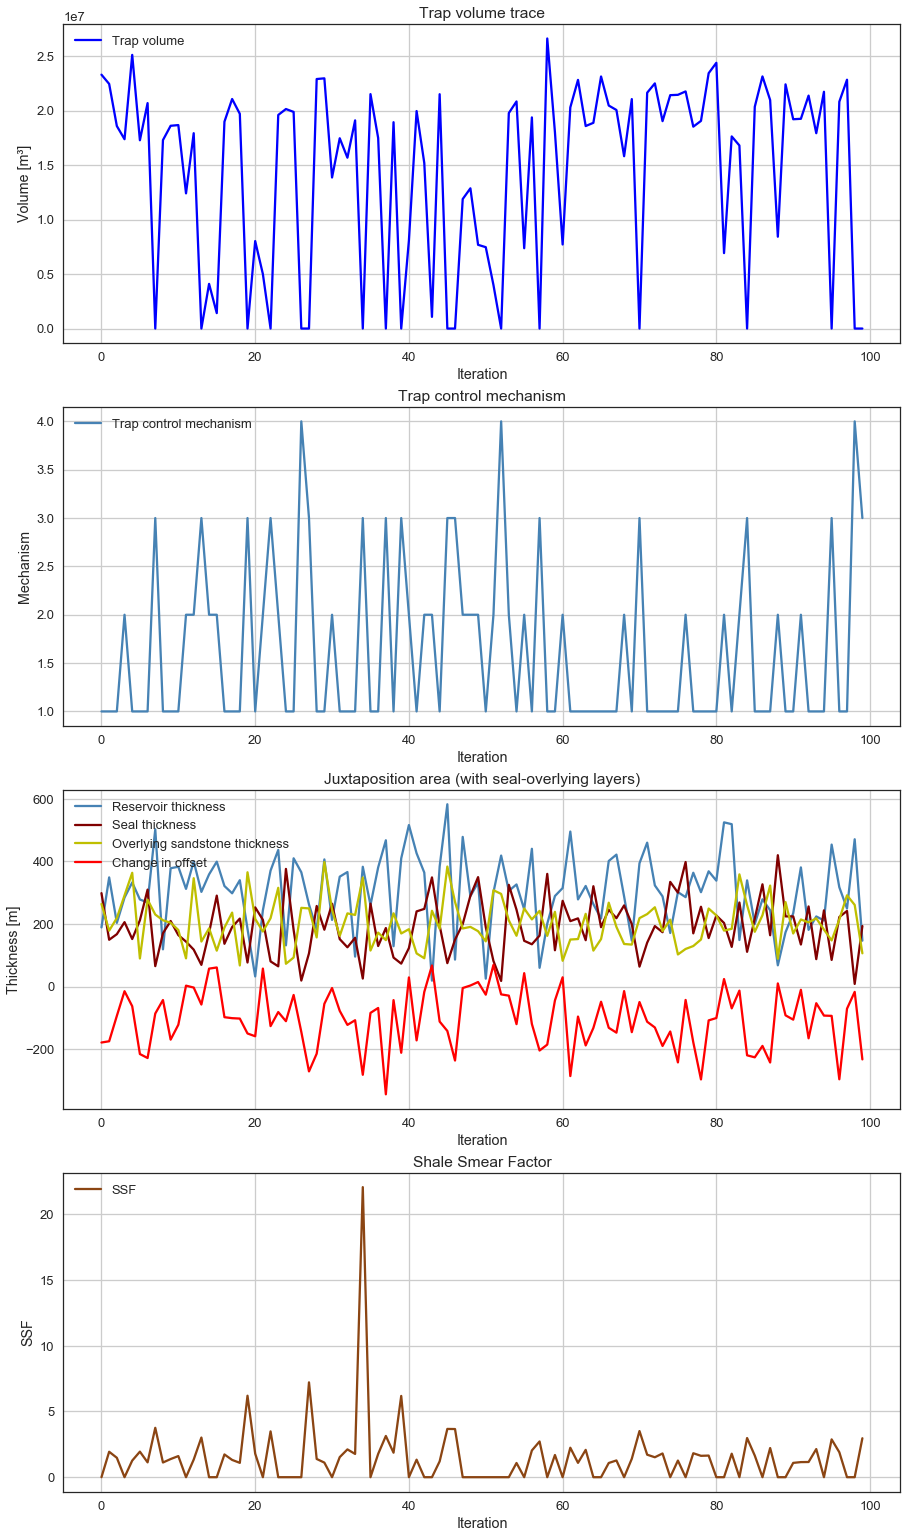

In [29]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


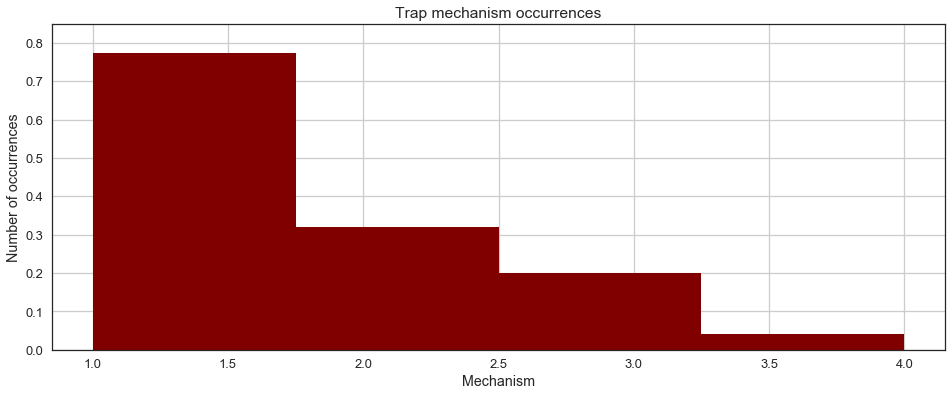

In [30]:
figsize(16, 6)
_hist1 = plt.hist(trap_control_trace, bins=4, normed=True, 
                  histtype="stepfilled", color = "maroon")
plt.title("Trap mechanism occurrences")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.ylabel("Number of occurrences")
plt.xlabel("Mechanism")

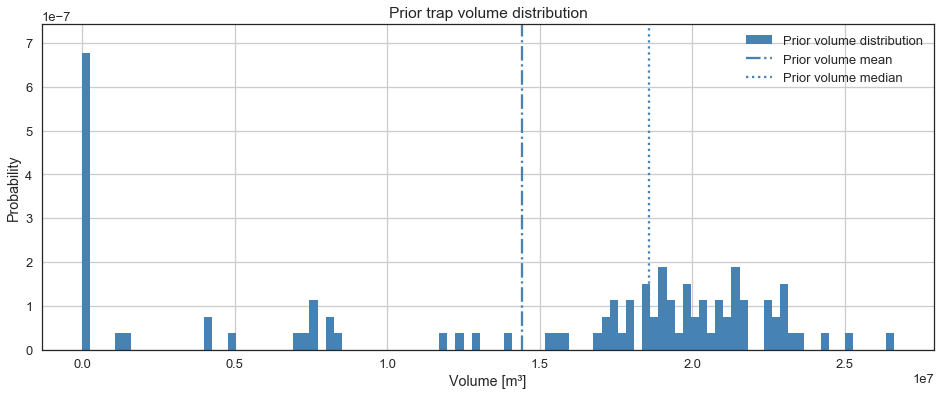

In [31]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [32]:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/21_10B-TRAP_25iterUNC_LIKELIHOOD_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/21_10B-LITH_25iterUNC_LIKELIHOOD_%s" % (counter))

In [35]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

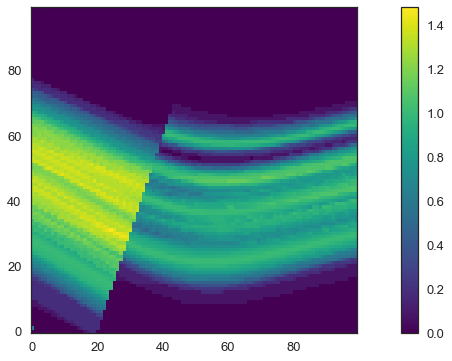

In [34]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0].astype(int))

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [36]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

Bayes action (minimum) at risk r 0.50: 19048000.00 --- expected loss: 5855210.00
Bayes action (minimum) at risk r 0.75: 17920000.00 --- expected loss: 8183920.00
Bayes action (minimum) at risk r 1.00: 16792000.00 --- expected loss: 10300800.00
Bayes action (minimum) at risk r 1.25: 12400000.00 --- expected loss: 11980835.00
Bayes action (minimum) at risk r 1.50: 7712000.00 --- expected loss: 12946380.00


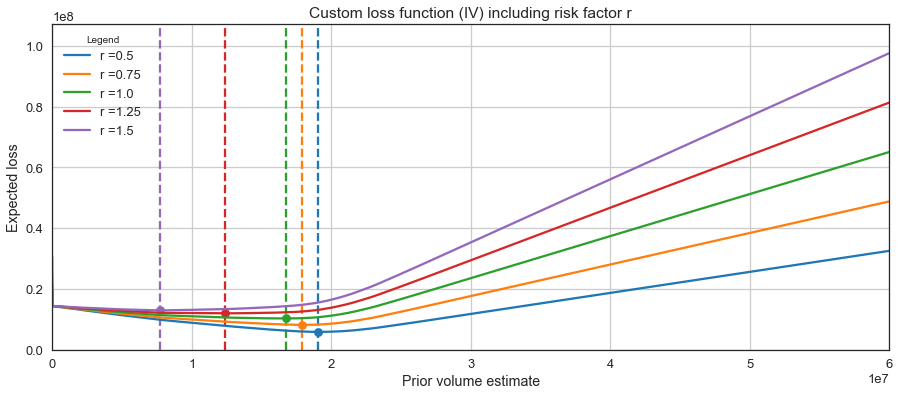

In [36]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Prior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

In [21]:
# THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 20
std2 = 30
std3 = 25

#@pymc.stochastic
#def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
#    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))
#
#@pymc.stochastic
#def seal_th_likelihood(value = 0, seal_th=seal_th):
#    return pymc.normal_like(seal_th, 400., 1./np.square(std2))
#
#@pymc.stochastic
#def res_th_likelihood(value = 0, res_th=res_th):
#    return pymc.normal_like(res_th, 250., 1./np.square(std3))

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 150., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 300., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))

In [42]:
# JUXTAPOSITION AREA LIKELIHOOD (not used)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [43]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
#model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    #fault_sealing, structural_model, 
                    #res_th, seal_th, sec_res_th, over_jux_area, 
                    #res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])

In [22]:
iterations=1050

In [45]:
#M_L = pymc.MCMC(model_L)
M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=50)

Z variations top to bottom: 23.1749019422 3.16041067435 16.0351710206 49.6225915734
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 3.16041067435 16.0351710206 38.6798835781
Fault offset variation: -312.837709098
Z variations top to bottom: 23.1749019422 3.16041067435 16.0351710206 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 16.0351710206 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to m

37.2552948131 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: -19.5815482504 -23.734056451 37.2552948131 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 37.2552948131 -78.8987997062
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 37.2552948131 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 23.1749019422 -83.1768894757 37.2552948131 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 23.1749019422 -83.1768894757 89.7751796181 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 38.9357750007 -83.1768894757 89.7751796181 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 38.9357750007 -83.1768894757 89.7751796181 -218.878274185
Fault offset variation: -165.495921961
Z variations top to bottom: 38.9357750007 -83.1768894757 89.7

Z variations top to bottom: 53.8386083481 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 71.8963014215
Z variations top to bottom: 39.520890508 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 71.8963014215
Z variations top to bottom: 39.520890508 -53.5843448928 96.8918641846 156.637747085
Fault offset variation: 71.8963014215
Z variations top to bottom: 39.520890508 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 39.520890508 -12.008267508 96.8918641846 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 39.520890508 -53.5843448928 71.004033007 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 77.3568498452 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 77.3568498452 -53.5843448928 96.8918641846 90.8629632084
Fault offset variation: 90.3023967684
Z variations top to bot

Z variations top to bottom: 64.1109093109 -59.6380945118 104.660081814 -33.060622747
Fault offset variation: -112.447958887
Z variations top to bottom: 64.1109093109 61.5774231591 104.660081814 -33.060622747
Fault offset variation: -112.447958887
Z variations top to bottom: 64.1109093109 -59.6380945118 113.41604096 -33.060622747
Fault offset variation: -112.447958887
Z variations top to bottom: 71.6779165813 -59.6380945118 104.660081814 -33.060622747
Fault offset variation: -112.447958887
 [-                 2%                  ] 28 of 1050 complete in 4.7 secZ variations top to bottom: 71.6779165813 -59.6380945118 104.660081814 -131.062693629
Fault offset variation: -112.447958887
Z variations top to bottom: 71.6779165813 -59.6380945118 104.660081814 -33.060622747
Fault offset variation: -164.157016456
Z variations top to bottom: 71.6779165813 5.90954439041 104.660081814 -33.060622747
Fault offset variation: -164.157016456
Z variations top to bottom: 71.6779165813 -59.6380945118 99.60

 [-                 3%                  ] 40 of 1050 complete in 6.9 secZ variations top to bottom: 38.3199050178 -38.103923309 112.669672939 -105.269623043
Fault offset variation: -29.7365765356
Z variations top to bottom: 38.3199050178 -38.103923309 112.669672939 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 112.669672939 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 123.559948692 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 5.41456032302 -30.7808608993 123.559948692 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 123.559948692 -43.8747156442
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 123.559948692 -43.8747156442
Fault offset variation: -48.8079828063
Z variations top to bottom: 38.3199050178 -107.778103623 123.559

C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying interp_unc, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\vlarray.py", line 519, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1086, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1220, in _tobuffer
    return six.moves.cPickle.dumps(object_, six.moves.cP

Z variations top to bottom: 49.5201182164 21.9812859617 109.852895269 30.9303310626
Fault offset variation: 11.5402691294
Z variations top to bottom: 49.5201182164 -46.0747276519 246.707004099 30.9303310626
Fault offset variation: 11.5402691294
Z variations top to bottom: 15.1613380523 -46.0747276519 109.852895269 30.9303310626
Fault offset variation: 11.5402691294
SPILL POINT AT: [ 1393.93945312   949.49493408   951.38408766]
LEAK POINT AT: [ 707.07067871  969.69696045  977.68833224]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [144.07237707900958] / [44.072377079009584] = [3.2689949267026748]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 4%                  ] 52 of 1050 complete in 25.8 secZ variations top to bottom: 15.1613380523 -46.0747276519 109.852895269 32.3469643357
Fault offset variation:

SPILL POINT AT: [ 1373.73742676   949.49493408   951.93493669]
LEAK POINT AT: [ 666.66668701  949.49493408  858.12846416]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [243.40390289979382] / [43.40390289979382] = [5.6078805507822214]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                5%                  ] 59 of 1050 complete in 86.7 secZ variations top to bottom: -5.35865297452 -46.0747276519 110.521369448 16.2337184652
Fault offset variation: -116.103951688
Z variations top to bottom: -5.35865297452 -46.0747276519 110.521369448 16.2337184652
Fault offset variation: -17.3943313484
Z variations top to bottom: -5.35865297452 90.374524187 110.521369448 16.2337184652
Fault offset variation: -17.3943313484
Z variations top to bottom: -5.35865297452 -46.0747276519 84.676160758 16.2337184652
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   921.4849316 ]
LEAK POINT AT: [ 666.66668701  969.69696045  901.83414722]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [170.1405248528979] / [70.140524852897897] = [2.4257093201073823]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16536000.0 m³
 [--                6%                  ] 66 of 1050 complete in 147.8 secZ variations top to bottom: 16.9024271568 -50.2612025113 79.5982726358 63.8256946051
Fault offset variation: -34.2727533038
Z variations top to bottom: 16.9024271568 -50.2612025113 79.5982726358 31.1080682425
Fault offset variation: 1.0005300232
Z variations top to bottom: 16.9024271568 -118.303089308 79.5982726358 31.1080682425
Fault offset variation: 1.0005300232
Z variations top to bottom: 16.9024271568 -50.2612025113 36.8181478095 31.1080682425
Fault offset variation: 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [207.86816795516211] / [47.868167955162107] = [4.3425135499205076]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                6%                  ] 73 of 1050 complete in 208.7 secZ variations top to bottom: -14.5984969105 -72.5335594091 79.5982726358 -17.4554518923
Fault offset variation: -62.7954177323
Z variations top to bottom: -14.5984969105 -72.5335594091 79.5982726358 -17.4554518923
Fault offset variation: -311.735259894
Z variations top to bottom: -14.5984969105 -145.78918581 79.5982726358 -17.4554518923
Fault offset variation: -62.7954177323
Z variations top to bottom: -14.5984969105 -72.5335594091 42.3290745238 -17.4554518923
Fault offset variation: -62.7954177323
Z variations top to bottom: 51.2368584597 -72.5335594091 79.5982726358 -17.4554518923
Fault of

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [148.20130209670106] / [48.201302096701056] = [3.0746327516086769]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                7%                  ] 80 of 1050 complete in 269.6 secZ variations top to bottom: 11.6437729535 -76.8369814603 74.961716443 -158.40104067
Fault offset variation: -2.52679617125
Z variations top to bottom: 11.6437729535 -76.8369814603 74.961716443 -141.88945024
Fault offset variation: -69.1509603026
Z variations top to bottom: 11.6437729535 -1.70396318588 74.961716443 -141.88945024
Fault offset variation: -69.1509603026
Z variations top to bottom: 11.6437729535 -76.8369814603 153.938740987 -141.88945024
Fault offset variation: -69.1509603026
Z variations top to bottom: 15.5428515832 -76.8369814603 74.961716443 -141.88945024
Fault offset variati

SPILL POINT AT: [ 1373.73742676   949.49493408   916.73703386]
LEAK POINT AT: [ 626.26263428  949.49493408  767.92746921]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [331.94384853679662] / [51.943848536796622] = [6.3904361707363702]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 87 of 1050 complete in 331.3 secZ variations top to bottom: -13.3384263796 -73.0944350202 74.961716443 -0.439024520293
Fault offset variation: -175.882391149
Z variations top to bottom: -13.3384263796 -73.0944350202 74.961716443 -0.439024520293
Fault offset variation: -330.974578951
Z variations top to bottom: -13.3384263796 -181.497142997 74.961716443 -0.439024520293
Fault offset variation: -175.882391149
Z variations top to

SPILL POINT AT: [ 1373.73742676   949.49493408   931.12255512]
LEAK POINT AT: [ 666.66668701  969.69696045  883.06052811]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.85981925093301] / [50.859819250933015] = [4.1459018603780198]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 94 of 1050 complete in 392.4 secZ variations top to bottom: 35.2776677262 -59.7294496789 89.4107310702 -8.86863366829
Fault offset variation: -65.247049155
Z variations top to bottom: 35.2776677262 -59.7294496789 89.4107310702 -8.86863366829
Fault offset variation: -15.2603424224
Z variations top to bottom: 35.2776677262 -44.5782726807 89.4107310702 -8.86863366829
Fault offset variation: -65.247049155
Z variations top to bottom: 35.2776677262 -44.5782726807 90.5953018234 -8.86863366829
Fault offset var

SPILL POINT AT: [ 1373.73742676   949.49493408   907.89366476]
LEAK POINT AT: [ 626.26263428  949.49493408  733.5680471 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [342.1819795568988] / [62.181979556898796] = [5.5029122905903902]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               9%                  ] 101 of 1050 complete in 453.3 secZ variations top to bottom: 32.6415830416 -71.7063348538 66.1116855893 -21.5298993136
Fault offset variation: -203.678280981
Z variations top to bottom: 32.6415830416 -71.7063348538 66.1116855893 -21.5298993136
Fault offset variation: -225.870588814
Z variations top to bottom: 32.6415830416 -74.3761265785 66.1116855893 -21.5298993136
Fault offset variation: -203.678280981
Z variations top to bottom: 32.6415830416 -74.3761265785 23.7184299598 -21.5298993136
Fault offset v

SPILL POINT AT: [ 1373.73742676   949.49493408   904.65082181]
LEAK POINT AT: [ 666.66668701  969.69696045  889.45722568]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [191.24851301208923] / [31.248513012089234] = [6.120243639692557]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---              10%                  ] 108 of 1050 complete in 514.3 secZ variations top to bottom: 39.5429428243 -105.855452632 62.8960343563 -6.52300396536
Fault offset variation: -37.2848800118
Z variations top to bottom: 39.5429428243 -105.855452632 62.8960343563 -6.52300396536
Fault offset variation: -204.912383986
Z variations top to bottom: 39.5429428243 -124.299611591 62.8960343563 -6.52300396536
Fault offset variation: -204.912383986
Z variations top to bottom: 39.5429428243 -105.855452632 3.13746329762 -6.52300396536
Fault offset v

 [----             11%                  ] 121 of 1050 complete in 628.9 secZ variations top to bottom: 22.2834953255 -105.855452632 33.2754700833 -54.2343717725
Fault offset variation: -102.600123936
Z variations top to bottom: 22.2834953255 -105.855452632 33.2754700833 -54.2343717725
Fault offset variation: 33.31924711
Z variations top to bottom: 22.2834953255 -283.519934983 33.2754700833 -54.2343717725
Fault offset variation: -102.600123936
Z variations top to bottom: 22.2834953255 -105.855452632 -35.4414767023 -54.2343717725
Fault offset variation: -102.600123936
Z variations top to bottom: 11.0331110946 -105.855452632 33.2754700833 -54.2343717725
Fault offset variation: -102.600123936
SPILL POINT AT: [ 1373.73742676   949.49493408   875.3302213 ]
LEAK POINT AT: [ 646.46466064  949.49493408  792.28214527]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [260.86907728516212] / [60.86907728516212] = [4

SPILL POINT AT: [ 1353.53540039   949.49493408   860.61824174]
LEAK POINT AT: [ 666.66668701  969.69696045  850.46153034]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [195.80485124345455] / [55.80485124345455] = [3.5087424637911]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 135 of 1050 complete in 750.5 secZ variations top to bottom: 21.7717991273 -125.706178637 18.48897012 -52.4706762421
Fault offset variation: -30.4478970856
Z variations top to bottom: 21.7717991273 -125.706178637 18.48897012 -52.4706762421
Fault offset variation: -55.9066845495
Z variations top to bottom: 21.7717991273 -131.365126793 18.48897012 -52.4706762421
Fault offset variation: -55.9066845495
Z variations top to bottom: 21.7717991273 -131.365126793 -5.25257189319 -52.4706762421
Fault offset variation

NUMBER OF TRAPS 1
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 1232000.0 m³
 [-----            13%                  ] 142 of 1050 complete in 811.0 secZ variations top to bottom: -18.4834440405 -130.359081623 -6.020645223 -160.596147849
Fault offset variation: 86.162170994
Z variations top to bottom: -18.4834440405 -130.359081623 -6.020645223 -95.3412211399
Fault offset variation: 216.359958934
Z variations top to bottom: -18.4834440405 -130.359081623 -6.020645223 -95.3412211399
Fault offset variation: 86.162170994
Z variations top to bottom: -18.4834440405 -177.124197385 -6.020645223 -95.3412211399
Fault offset variation: 86.162170994
Z variations top to bottom: -18.4834440405 -177.124197385 -44.6038781423 -95.3412211399
Fault offset variation: 86.162170994
Z variations top to bottom: 19.4463602401 -177.124197385 -44.6038781423 -95.3412211399
Fault offset variation: 86.162170994
SPILL POINT AT: [ 1353.5354003

SPILL POINT AT: [ 1353.53540039   949.49493408   834.77036213]
LEAK POINT AT: [ 686.86871338  969.69696045  929.33966522]
NUMBER OF TRAPS 1
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [71.509672876073637] / [51.509672876073637] = [1.3882765873531697]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Maximum trap volume: 2688000.0 m³
 [-----            14%                  ] 150 of 1050 complete in 873.8 secZ variations top to bottom: -52.105197634 -155.846508222 -7.35618109759 -72.4528238824
Fault offset variation: 76.1710418614
Z variations top to bottom: -52.105197634 -155.846508222 -7.35618109759 -98.5989990516
Fault offset variation: -153.34450683
Z variations top to bottom: -52.105197634 -311.249657435 -7.35618109759 -98.5989990516
Fault offset variation: -153.34450683
Z variations top to bottom: -52.105197634 -155.846508222 -0.938592702835 -98.5989990516
Fault offset variation: -153.344506

SPILL POINT AT: [ 1353.53540039   949.49493408   829.85885693]
LEAK POINT AT: [ 606.06060791  949.49493408  699.35237179]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 240.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [296.20130600547395] / [56.201306005473953] = [5.2703633964773742]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            14%                  ] 157 of 1050 complete in 935.3 secZ variations top to bottom: -50.1786880669 -155.846508222 -12.047814227 -109.124062584
Fault offset variation: -160.28367191
Z variations top to bottom: -50.1786880669 -155.846508222 -12.047814227 -109.124062584
Fault offset variation: 7.66648756657
Z variations top to bottom: -50.1786880669 -164.119626992 -12.047814227 -109.124062584
Fault offset variation: -160.28367191
Z variations top to bottom: -50.1786880669 -164.119626992 11.1624749188 -109.124062584
Fault offset

SPILL POINT AT: [ 1353.53540039   949.49493408   829.72366806]
LEAK POINT AT: [ 606.06060791  949.49493408  690.85307775]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.92818723504797] / [47.928187235047972] = [6.4247826800733323]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            15%                  ] 164 of 1050 complete in 996.1 secZ variations top to bottom: -27.7559062466 -164.119626992 -12.047814227 -182.653545467
Fault offset variation: -169.746469457
Z variations top to bottom: -27.7559062466 -164.119626992 -12.047814227 -128.517565039
Fault offset variation: -156.081146354
Z variations top to bottom: -27.7559062466 -61.050554966 -12.047814227 -128.517565039
Fault offset variation: -156.081146354
Z variations top to bottom: -27.7559062466 -164.119626992 -75.8983088947 -128.517565039
Fault off

SPILL POINT AT: [ 1373.73742676   949.49493408   865.74993442]
LEAK POINT AT: [ 646.46466064  969.69696045  791.07514095]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [233.7917389661834] / [73.791738966183402] = [3.1682643916729396]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 171 of 1050 complete in 1057.4 secZ variations top to bottom: -41.4510247854 -102.620308091 23.5879529429 -30.5529205648
Fault offset variation: -92.6333656892
Z variations top to bottom: -41.4510247854 -102.620308091 23.5879529429 -30.5529205648
Fault offset variation: -191.16391581
Z variations top to bottom: -41.4510247854 -185.512767014 23.5879529429 -30.5529205648
Fault offset variation: -92.6333656892
Z variations top to bottom: -41.4510247854 -102.620308091 9.24988896017 -30.5529205648
Fault offs

NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [153.55032585552863] / [73.550325855528627] = [2.0876906263765598]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14048000.0 m³
 [------           16%                  ] 178 of 1050 complete in 1118.3 secZ variations top to bottom: 45.993367596 -57.2775829174 69.1720912271 -10.4814478987
Fault offset variation: 9.84330999683
Z variations top to bottom: 45.993367596 -57.2775829174 69.1720912271 -10.4814478987
Fault offset variation: 55.9158452879
Z variations top to bottom: 45.993367596 1.0616573456 69.1720912271 -10.4814478987
Fault offset variation: 55.9158452879
Z variations top to bottom: 45.993367596 -57.2775829174 72.8315032858 -10.4814478987
Fault offset variation: 55.9158452879
Z variations top to bottom: 47.1086258829 -57.2775829174 72.8315032858 -10.4814478987
Fault offset variatio

NUMBER OF TRAPS 1
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 640000.0 m³
 [------           17%                  ] 185 of 1050 complete in 1179.1 secZ variations top to bottom: -5.80581677174 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: 99.4496908584
Z variations top to bottom: -5.80581677174 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -5.80581677174 7.88421618394 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -5.80581677174 -57.2775829174 27.5887957932 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -53.1053897639 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -5.80581677174 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
SPILL POINT AT: [ 1373.7

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [152.5977642203984] / [52.597764220398403] = [2.901221496430415]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 15968000.0 m³
 [------           18%                  ] 192 of 1050 complete in 1240.4 secZ variations top to bottom: 25.3199851317 -80.2721915219 172.325572698 128.953867116
Fault offset variation: -21.3661210653
Z variations top to bottom: 25.3199851317 -80.2721915219 172.325572698 51.3440681571
Fault offset variation: -125.92234738
Z variations top to bottom: 25.3199851317 -104.217500367 172.325572698 51.3440681571
Fault offset variation: -125.92234738
Z variations top to bottom: 25.3199851317 -80.2721915219 211.63517927 51.3440681571
Fault offset variation: -125.92234738
Z variations top to bottom: 52.0344408533 -80.2721915219 172.325572698 51.3440681571
Fault offset variatio

SPILL POINT AT: [ 1373.73742676   949.49493408   911.89807199]
LEAK POINT AT: [ 686.86871338  969.69696045  937.3246712 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [142.8960639436882] / [62.896063943688205] = [2.2719396888114525]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14120000.0 m³
 [-------          18%                  ] 199 of 1050 complete in 1301.5 secZ variations top to bottom: 36.1670986239 -67.1033700817 70.0005659746 -55.1386693229
Fault offset variation: 13.3622967261
Z variations top to bottom: 36.1670986239 -67.1033700817 70.0005659746 -55.1386693229
Fault offset variation: -319.897912209
Z variations top to bottom: 36.1670986239 -46.0792058051 70.0005659746 -55.1386693229
Fault offset variation: 13.3622967261
Z variations top to bottom: 36.1670986239 -67.1033700817 30.3336252728 -55.1386693229
Fault offset vari

SPILL POINT AT: [ 1373.73742676   949.49493408   922.78690537]
LEAK POINT AT: [ 666.66668701  969.69696045  877.67928989]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [211.91091761716098] / [51.910917617160976] = [4.0822032694545625]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 206 of 1050 complete in 1362.6 secZ variations top to bottom: 34.4074646799 -67.1033700817 80.9857123012 16.8522219778
Fault offset variation: -61.4955283673
Z variations top to bottom: 34.4074646799 -67.1033700817 80.9857123012 -20.0967327412
Fault offset variation: -26.5330220917
Z variations top to bottom: 34.4074646799 -75.0255051731 80.9857123012 -20.0967327412
Fault offset variation: -26.5330220917
Z variations top to bottom: 34.4074646799 -67.1033700817 65.8084360273 -20.0967327412
Fault offset 

SPILL POINT AT: [ 1373.73742676   949.49493408   905.15083972]
LEAK POINT AT: [ 626.26263428  949.49493408  758.31532767]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.69489781046309] / [51.69489781046309] = [6.0295098938637572]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 213 of 1050 complete in 1423.5 secZ variations top to bottom: 64.1767644027 -84.9300183076 63.3750838819 -120.458711273
Fault offset variation: -171.552425375
Z variations top to bottom: 64.1767644027 -84.9300183076 63.3750838819 -30.8012376007
Fault offset variation: -84.0362954138
Z variations top to bottom: 64.1767644027 -115.94725242 63.3750838819 -30.8012376007
Fault offset variation: -84.0362954138
Z variations top to bottom: 64.1767644027 -84.9300183076 107.652642426 -30.8012376007
Fault offset v

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [271.69489781046309] / [51.69489781046309] = [5.2557391409616407]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 220 of 1050 complete in 1484.2 secZ variations top to bottom: 18.6526944459 -84.9300183076 63.3750838819 19.4586485511
Fault offset variation: -114.387659018
Z variations top to bottom: 18.6526944459 -84.9300183076 63.3750838819 19.4586485511
Fault offset variation: -117.758150356
Z variations top to bottom: 18.6526944459 -117.659226561 63.3750838819 19.4586485511
Fault offset variation: -117.758150356
Z variations top to bottom: 18.6526944459 -84.9300183076 41.6098144381 19.4586485511
Fault offset variation: -117.758150356
Z variations top to bottom: -7.42322535522 -84.9300183076 63.3750838819 19.4586485511
Fault offset v

SPILL POINT AT: [ 1373.73742676   949.49493408   905.3068825 ]
LEAK POINT AT: [ 666.66668701  949.49493408  855.69377997]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [218.39469595162541] / [58.394695951625408] = [3.7399748794401666]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 227 of 1050 complete in 1545.2 secZ variations top to bottom: -17.4137110482 -78.2302201665 63.3750838819 -119.47488732
Fault offset variation: -67.9533410381
Z variations top to bottom: -17.4137110482 -78.2302201665 63.3750838819 -119.47488732
Fault offset variation: -78.1369619412
Z variations top to bottom: -17.4137110482 -86.1580211663 63.3750838819 -119.47488732
Fault offset variation: -78.1369619412
Z variations top to bottom: -17.4137110482 -86.1580211663 120.190268745 -119.47488732
Fault offset

Z variations top to bottom: 39.0035588007 -88.5858530754 68.8366181276 -40.518972952
Fault offset variation: -109.561877056
Z variations top to bottom: 8.27200887218 -88.5858530754 68.8366181276 -40.518972952
Fault offset variation: -109.561877056
SPILL POINT AT: [ 1373.73742676   949.49493408   910.55272222]
LEAK POINT AT: [ 646.46466064  949.49493408  823.11189063]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [262.57752879700524] / [42.577528797005243] = [6.1670448289491624]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         22%                  ] 234 of 1050 complete in 1605.8 secZ variations top to bottom: 8.27200887218 -88.5858530754 68.8366181276 -93.5420852803
Fault offset variation: -109.561877056
Z variations top to bottom: 8.27200887218 -88.5858530754 68.8366181276 -40.518972952
Fault offset va

SPILL POINT AT: [ 1373.73742676   949.49493408   902.7282674 ]
LEAK POINT AT: [ 666.66668701  969.69696045  879.71758985]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.64623003142128] / [50.646230031421283] = [4.1591690023272188]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         22%                  ] 241 of 1050 complete in 1667.0 secZ variations top to bottom: 28.1002748068 -88.5858530754 60.7679168932 -96.7044836721
Fault offset variation: -39.420947348
Z variations top to bottom: 28.1002748068 -88.5858530754 60.7679168932 -69.3430605767
Fault offset variation: -122.374955657
Z variations top to bottom: 28.1002748068 -209.23393133 60.7679168932 -69.3430605767
Fault offset variation: -122.374955657
Z variations top to bottom: 28.1002748068 -88.5858530754 15.7279640759 -69.3430605767
Fault offset v

SPILL POINT AT: [ 1373.73742676   949.49493408   900.09364621]
LEAK POINT AT: [ 686.86871338  969.69696045  912.03726972]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [148.13808397598518] / [48.138083975985182] = [3.0773572967691725]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         23%                  ] 248 of 1050 complete in 1727.9 secZ variations top to bottom: -5.1998426884 -93.691512388 58.170403636 -110.639382805
Fault offset variation: -7.0446743661
Z variations top to bottom: -5.1998426884 -93.691512388 58.170403636 -40.4074605736
Fault offset variation: -75.5464427219
Z variations top to bottom: -5.1998426884 -155.426364941 58.170403636 -40.4074605736
Fault offset variation: -75.5464427219
Z variations top to bottom: -5.1998426884 -93.691512388 127.076879433 -40.4074605736
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   901.71694356]
LEAK POINT AT: [ 666.66668701  969.69696045  884.82090694]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [206.47934428336998] / [46.479344283369983] = [4.4423893552484346]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        24%                  ] 255 of 1050 complete in 1788.8 secZ variations top to bottom: -10.6750964276 -93.691512388 59.8291433286 -58.6147172306
Fault offset variation: -35.5628814408
Z variations top to bottom: -10.6750964276 -93.691512388 59.8291433286 -58.6147172306
Fault offset variation: -224.990321771
Z variations top to bottom: -10.6750964276 -83.5397833844 59.8291433286 -58.6147172306
Fault offset variation: -224.990321771
Z variations top to bottom: -10.6750964276 -83.5397833844 39.5611813776 -58.6147172306
Fault offs

 [---------        25%                  ] 268 of 1050 complete in 1902.7 secZ variations top to bottom: -23.5876795211 -83.5397833844 59.8291433286 12.6639111383
Fault offset variation: -58.6690708336
Z variations top to bottom: -23.5876795211 -83.5397833844 59.8291433286 12.6639111383
Fault offset variation: -43.989265803
Z variations top to bottom: -23.5876795211 -164.950213992 59.8291433286 12.6639111383
Fault offset variation: -43.989265803
Z variations top to bottom: -23.5876795211 -83.5397833844 88.978590288 12.6639111383
Fault offset variation: -43.989265803
Z variations top to bottom: -17.5863030831 -83.5397833844 59.8291433286 12.6639111383
Fault offset variation: -43.989265803
SPILL POINT AT: [ 1373.73742676   949.49493408   901.72159036]
LEAK POINT AT: [ 666.66668701  969.69696045  872.13957858]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [196.63107328696378] / [56.631073286963783] = [3.

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [145.37513434955463] / [45.375134349554628] = [3.2038502239934754]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        26%                  ] 275 of 1050 complete in 1963.6 secZ variations top to bottom: -1.35371295226 -94.7957223218 59.8291433286 -26.3327686507
Fault offset variation: -17.1535398366
Z variations top to bottom: -1.35371295226 -94.7957223218 59.8291433286 -26.3327686507
Fault offset variation: -14.4742737028
Z variations top to bottom: -1.35371295226 -195.995109647 59.8291433286 -26.3327686507
Fault offset variation: -14.4742737028
Z variations top to bottom: -1.35371295226 -94.7957223218 114.4319428 -26.3327686507
Fault offset variation: -14.4742737028
Z variations top to bottom: -7.08330154155 -94.7957223218 59.8291433286 -26.3327686507
Fault 

SPILL POINT AT: [ 1373.73742676   949.49493408   877.26449397]
LEAK POINT AT: [ 626.26263428  949.49493408  777.40048259]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.6869347030115] / [62.686934703011502] = [4.5095032328870772]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       26%                  ] 282 of 1050 complete in 2024.5 secZ variations top to bottom: -7.19539166692 -102.083380864 35.229684433 -30.8700201814
Fault offset variation: -121.297485783
Z variations top to bottom: -7.19539166692 -102.083380864 35.229684433 -30.8700201814
Fault offset variation: -173.144697782
Z variations top to bottom: -7.19539166692 -199.534166659 35.229684433 -30.8700201814
Fault offset variation: -121.297485783
Z variations top to bottom: -7.19539166692 -102.083380864 65.1572011065 -30.8700201814
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   918.44515111]
LEAK POINT AT: [ 646.46466064  949.49493408  795.09960325]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.1296437337287] / [41.129643733728699] = [7.3214746444979513]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       27%                  ] 289 of 1050 complete in 2085.4 secZ variations top to bottom: 8.24527581246 -82.0963557752 76.7740004911 -67.4331450067
Fault offset variation: -149.812472279
Z variations top to bottom: 8.24527581246 -82.0963557752 76.7740004911 -67.4331450067
Fault offset variation: -267.076186581
Z variations top to bottom: 8.24527581246 -70.8123155466 76.7740004911 -67.4331450067
Fault offset variation: -267.076186581
Z variations top to bottom: 8.24527581246 -70.8123155466 37.0697830094 -67.4331450067
Fault offset 

 [----------       28%                  ] 302 of 1050 complete in 2200.1 secZ variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -98.9845061534
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -378.857058794
Z variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -138.829137595 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -54.3408824988 75.9868301925 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 58.3188867334 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
SPILL POINT AT: [ 1373.73742676   949.49493408   932.98

SPILL POINT AT: [ 1373.73742676   949.49493408   909.23483754]
LEAK POINT AT: [ 606.06060791  949.49493408  676.82990012]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [644.18263319822677] / [44.182633198226767] = [14.579996405105174]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------      29%                  ] 309 of 1050 complete in 2262.6 secZ variations top to bottom: -17.0129305651 -88.1429813326 67.6743854692 30.3263797079
Fault offset variation: -278.415111729
Z variations top to bottom: -17.0129305651 -88.1429813326 67.6743854692 30.3263797079
Fault offset variation: -376.5727704
Z variations top to bottom: -17.0129305651 -94.5672410937 67.6743854692 30.3263797079
Fault offset variation: -278.415111729
Z 

Z variations top to bottom: -18.388958182 -75.1084225649 86.3652703131 -50.4427028807
Fault offset variation: -246.421327974
Z variations top to bottom: -18.388958182 12.583946221 86.3652703131 -50.4427028807
Fault offset variation: -71.0499578394
Z variations top to bottom: -18.388958182 -75.1084225649 108.807737003 -50.4427028807
Fault offset variation: -71.0499578394
Z variations top to bottom: -44.7775536823 -75.1084225649 86.3652703131 -50.4427028807
Fault offset variation: -71.0499578394
Z variations top to bottom: -18.388958182 -75.1084225649 86.3652703131 -50.4427028807
Fault offset variation: -71.0499578394
SPILL POINT AT: [ 1373.73742676   949.49493408   927.99025884]
LEAK POINT AT: [ 666.66668701  969.69696045  877.6451817 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [238.52630712201812] / [38.526307122018125] = [6.1912579985040468]
SSF threshold exceeded, shale smear assumed to be inco

Z variations top to bottom: -10.0557318444 -70.1556770522 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -10.0557318444 -73.3737210523 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -10.0557318444 -73.3737210523 95.7920446403 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -12.1954808035 -73.3737210523 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -10.0557318444 -73.3737210523 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
SPILL POINT AT: [ 1373.73742676   949.49493408   918.49792359]
LEAK POINT AT: [ 686.86871338  969.69696045  928.2924149 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [149.90297690313491] / [49.902976903134913] = [3.0038884693012768]
SSF threshold exceeded, shale smear assumed to be inc

 [-----------      31%                  ] 329 of 1050 complete in 2432.1 secZ variations top to bottom: -11.231530089 -92.9307560515 76.6283061603 8.09888526951
Fault offset variation: 98.650787528
Z variations top to bottom: -11.231530089 -92.9307560515 76.6283061603 8.09888526951
Fault offset variation: 105.556238005
Z variations top to bottom: -11.231530089 -71.9891829091 76.6283061603 8.09888526951
Fault offset variation: 105.556238005
Z variations top to bottom: -11.231530089 -71.9891829091 91.1280333437 8.09888526951
Fault offset variation: 105.556238005
Z variations top to bottom: -12.5796952836 -71.9891829091 91.1280333437 8.09888526951
Fault offset variation: 105.556238005
SPILL POINT AT: [ 1373.73742676   949.49493408   932.7524947 ]
LEAK POINT AT: [  727.27270508   969.69696045  1048.5752809 ]
NUMBER OF TRAPS 1
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [56.882783747291114] / [36.882783747291114] = [1.542

SPILL POINT AT: [ 1373.73742676   949.49493408   931.13273162]
LEAK POINT AT: [ 686.86871338  969.69696045  934.22990055]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [178.49503845556251] / [38.495038455562508] = [4.6368323196146877]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     32%                  ] 337 of 1050 complete in 2500.1 secZ variations top to bottom: 40.5935659997 -71.9891829091 89.5157786354 46.5708203646
Fault offset variation: -13.1405634145
Z variations top to bottom: 40.5935659997 -71.9891829091 89.5157786354 12.865222333
Fault offset variation: -138.932925309
Z variations top to bottom: 40.5935659997 -17.1170020679 89.5157786354 12.865222333
Fault offset variation: -138.932925309
Z variations top to bottom: 40.5935659997 -71.9891829091 17.0764375373 12.865222333
Fault offset variat

SPILL POINT AT: [ 1393.93945312   949.49493408   964.66228237]
LEAK POINT AT: [ 686.86871338  949.49493408  955.57648215]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [180.36581671126623] / [40.365816711266234] = [4.4682811201717998]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     32%                  ] 344 of 1050 complete in 2559.8 secZ variations top to bottom: 8.90355662579 -76.179821152 164.185995559 17.6604202971
Fault offset variation: -38.8851682237
Z variations top to bottom: 8.90355662579 -76.179821152 164.185995559 30.7449973856
Fault offset variation: -90.5686806207
Z variations top to bottom: 8.90355662579 -104.725587189 164.185995559 30.7449973856
Fault offset variation: -90.5686806207
Z variations top to bottom: 8.90355662579 -104.725587189 157.467681486 30.7449973856
Fault offset varia

SPILL POINT AT: [ 1373.73742676   969.69696045   928.3903865 ]
LEAK POINT AT: [ 646.46466064  949.49493408  849.54625484]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [250.84946098078422] / [50.849460980784215] = [4.9331783689030475]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     33%                  ] 351 of 1050 complete in 2619.6 secZ variations top to bottom: -20.5761402983 -112.666789908 138.182671073 -49.5563296433
Fault offset variation: -117.517603875
Z variations top to bottom: -20.5761402983 -112.666789908 138.182671073 40.6390473463
Fault offset variation: -116.367518795
Z variations top to bottom: -20.5761402983 -69.9896758763 138.182671073 40.6390473463
Fault offset variation: -116.367518795
Z variations top to bottom: -20.5761402983 -112.6

SPILL POINT AT: [ 1373.73742676   949.49493408   882.75733588]
LEAK POINT AT: [ 666.66668701  969.69696045  874.60906827]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [186.52844022408681] / [46.528440224086808] = [4.0089123840331293]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     34%                  ] 358 of 1050 complete in 2679.1 secZ variations top to bottom: 3.04906875976 -112.666789908 40.8047698679 -13.8025110686
Fault offset variation: -25.1855382343
Z variations top to bottom: 3.04906875976 -112.666789908 40.8047698679 -13.8025110686
Fault offset variation: 171.347181615
Z variations top to bottom: 3.04906875976 -208.555613841 40.8047698679 -13.8025110686
Fault offset variation: -25.1855382343
Z variations top to bottom: 3.04906875976 -112.666789908 -4.78210711349 -13.8025110686
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   882.80840416]
LEAK POINT AT: [ 646.46466064  949.49493408  827.82529312]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [197.4441393640443] / [57.444139364044304] = [3.437150274160595]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------------    34%                  ] 365 of 1050 complete in 2737.8 secZ variations top to bottom: -15.6664863308 -101.751090768 40.8047698679 -117.187036532
Fault offset variation: -72.8572155756
Z variations top to bottom: -15.6664863308 -101.751090768 40.8047698679 -38.7942883224
Fault offset variation: 57.1178900758
Z variations top to bottom: -15.6664863308 -101.751090768 40.8047698679 -38.7942883224
Fault offset variation: -72.8572155756
Z variations top to bottom: -15.6664863308 -185.685374143 40.8047698679 -38.7942883224
Fault offse

 [-------------    36%                  ] 378 of 1050 complete in 2848.1 secZ variations top to bottom: -47.772229765 -105.153397194 64.700683619 6.4940622392
Fault offset variation: -145.703509215
Z variations top to bottom: -47.772229765 -105.153397194 64.700683619 6.4940622392
Fault offset variation: 24.9627727674
Z variations top to bottom: -47.772229765 -142.914412849 64.700683619 6.4940622392
Fault offset variation: -145.703509215
Z variations top to bottom: -47.772229765 -105.153397194 39.3560754202 6.4940622392
Fault offset variation: -145.703509215
Z variations top to bottom: -56.1715924429 -105.153397194 39.3560754202 6.4940622392
Fault offset variation: -145.703509215
SPILL POINT AT: [ 1373.73742676   949.49493408   881.21623357]
LEAK POINT AT: [ 626.26263428  949.49493408  760.42096266]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 240.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.49052738596356] / [55.49052738596356] = [5.325062516

SPILL POINT AT: [ 1373.73742676   949.49493408   873.592562  ]
LEAK POINT AT: [ 585.85858154  949.49493408  662.77796142]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 60.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [475.05271870113893] / [55.052718701138929] = [8.629051024346797]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------------    36%                  ] 385 of 1050 complete in 2908.7 secZ variations top to bottom: -47.9911319147 -113.152373615 31.7949076843 -9.90245151743
Fault offset variation: -258.146551785
Z variations top to bottom: -47.9911319147 -113.152373615 31.7949076843 -9.90245151743
Fault offset variation: -89.6828971264
Z variations top to bottom: -47.9911319147 -84.8766776689 31.7949076843 -9.90245151743
Fault offset variation: -89.6828971264


SPILL POINT AT: [ 1373.73742676   949.49493408   872.93386625]
LEAK POINT AT: [ 626.26263428  949.49493408  757.46808264]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [275.79838811718491] / [55.798388117184913] = [4.9427662236042966]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   37%                  ] 392 of 1050 complete in 2968.1 secZ variations top to bottom: 20.5100790215 -113.152373615 31.0492382683 4.70042148608
Fault offset variation: -138.539431838
Z variations top to bottom: 20.5100790215 -113.152373615 31.0492382683 4.70042148608
Fault offset variation: -200.326158803
Z variations top to bottom: 20.5100790215 -32.2788851604 31.0492382683 4.70042148608
Fault offset variation: -138.539431838
Z variations top to bottom: 20.5100790215 -113.152373615 68.5107772516 4.70042148608
Fault offset var

SPILL POINT AT: [ 1373.73742676   949.49493408   886.60435531]
LEAK POINT AT: [ 646.46466064  949.49493408  799.33224003]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [263.5357262014079] / [63.535726201407897] = [4.1478352724890737]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   38%                  ] 399 of 1050 complete in 3028.1 secZ variations top to bottom: -2.30580054149 -91.8275432929 44.6367305057 -11.4079298166
Fault offset variation: -104.411762258
Z variations top to bottom: -2.30580054149 -91.8275432929 44.6367305057 -11.4079298166
Fault offset variation: 116.114021623
Z variations top to bottom: -2.30580054149 91.8097131236 44.6367305057 -11.4079298166
Fault offset variation: -104.411762258
Z variations top to bottom: -2.30580054149 -91.8275432929 82.1101981476 -11.4079298166
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   909.59706585]
LEAK POINT AT: [ 646.46466064  949.49493408  799.91908095]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.34255157768462] / [49.342551577684617] = [5.4586263370193437]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   38%                  ] 406 of 1050 complete in 3087.7 secZ variations top to bottom: 23.1792753817 -82.8432940295 67.8141543929 -73.3829310471
Fault offset variation: -130.257210022
Z variations top to bottom: 23.1792753817 -82.8432940295 67.8141543929 -73.3829310471
Fault offset variation: -206.357559405
Z variations top to bottom: 23.1792753817 -118.268354347 67.8141543929 -73.3829310471
Fault offset variation: -206.357559405
Z variations top to bottom: 23.1792753817 -82.8432940295 117.892812143 -73.3829310471
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   919.32199825]
LEAK POINT AT: [ 686.86871338  969.69696045  935.02388287]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [149.68147298541135] / [49.681472985411347] = [3.0128227685472284]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   39%                  ] 413 of 1050 complete in 3147.2 secZ variations top to bottom: 34.1450037491 -72.8556577249 77.4628692897 2.64420147443
Fault offset variation: 1.19536597206
Z variations top to bottom: 34.1450037491 -72.8556577249 77.4628692897 2.64420147443
Fault offset variation: 63.4203971866
Z variations top to bottom: 34.1450037491 -91.4903229721 77.4628692897 2.64420147443
Fault offset variation: 1.19536597206
Z variations top to bottom: 34.1450037491 -72.8556577249 119.978436993 2.64420147443
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   912.56704127]
LEAK POINT AT: [ 686.86871338  969.69696045  950.42792487]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [127.06303486955881] / [47.063034869558805] = [2.6998478789506497]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 9720000.0 m³
 [---------------  40%                  ] 420 of 1050 complete in 3206.7 secZ variations top to bottom: -2.82500480264 -82.1192274451 70.8177376853 60.2421932398
Fault offset variation: 22.5566895498
Z variations top to bottom: -2.82500480264 -82.1192274451 70.8177376853 31.2395082307
Fault offset variation: 20.7008441244
Z variations top to bottom: -2.82500480264 -146.782886678 70.8177376853 31.2395082307
Fault offset variation: 20.7008441244
Z variations top to bottom: -2.82500480264 -82.1192274451 68.7297725653 31.2395082307
Fault offset varia

SPILL POINT AT: [ 1373.73742676   949.49493408   899.20710365]
LEAK POINT AT: [ 646.46466064  949.49493408  796.43159985]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.21808540840789] / [74.218085408407887] = [3.6947609723349553]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------  40%                  ] 427 of 1050 complete in 3266.2 secZ variations top to bottom: 22.6193578634 -68.6684187926 57.113495799 -123.517005718
Fault offset variation: -120.487102017
Z variations top to bottom: 22.6193578634 -68.6684187926 57.113495799 -95.8786938567
Fault offset variation: -129.353519114
Z variations top to bottom: 22.6193578634 23.965444274 57.113495799 -95.8786938567
Fault offset variation: -129.353519114
Z variations top to bottom: 22.6193578634 -68.6684187926 18.9088177718 -95.8786938567
Fault offset vari

SPILL POINT AT: [ 1373.73742676   949.49493408   901.90421415]
LEAK POINT AT: [ 585.85858154  949.49493408  616.92927185]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 380.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 180.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [713.13244458345616] / [53.132444583456163] = [13.421788705078781]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------  41%                  ] 434 of 1050 complete in 3326.5 secZ variations top to bottom: 38.7862388946 -86.6447903907 60.2227650258 -26.0432573739
Fault offset variation: -338.199249011
Z variations top to bottom: 38.7862388946 -86.6447903907 60.2227650258 -26.0432573739
Fault offset variation: -550.189130811
Z variations top to bottom: 38.7862388946 -45.1784384932 60.2227650258 -26.0432573739
Fault offset variation: -338.199249011


SPILL POINT AT: [ 1373.73742676   949.49493408   903.09279818]
LEAK POINT AT: [ 646.46466064  949.49493408  788.17199353]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [281.22219198565381] / [61.222191985653808] = [4.5934681994325288]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------- 42%                  ] 447 of 1050 complete in 3439.1 secZ variations top to bottom: 18.4020871194 -77.4844907805 61.2933172339 41.0348607297
Fault offset variation: -138.550683571
Z variations top to bottom: 18.4020871194 -77.4844907805 61.2933172339 41.0348607297
Fault offset variation: 24.9593043016
Z variations top to bottom: 18.4020871194 -117.301568322 61.2933172339 41.0348607297
Fault offset variation: 24.9593043016
Z variations top to bottom: 18.4020871194 -77.4844907805 1.78774317121 41.0348607297
Fault offset varia

SPILL POINT AT: [ 1373.73742676   949.49493408   924.15510013]
LEAK POINT AT: [ 626.26263428  949.49493408  741.34176214]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [319.85839060375542] / [39.858390603755424] = [8.0248696888834896]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------- 43%                  ] 454 of 1050 complete in 3499.0 secZ variations top to bottom: 35.0844770708 -77.4844907805 82.6571186158 -98.1811555521
Fault offset variation: -214.836826795
Z variations top to bottom: 35.0844770708 -77.4844907805 82.6571186158 5.51880418614
Fault offset variation: -299.967048498
Z variations top to bottom: 35.0844770708 -77.4844907805 82.6571186158 5.51880418614
Fault offset variation: -214.836826795
Z variations top to bo

 [---------------- 43%                  ] 460 of 1050 complete in 3550.8 secZ variations top to bottom: 30.2721132687 -77.4844907805 73.1036451008 97.7337215064
Fault offset variation: -260.307750534
Z variations top to bottom: 30.2721132687 -77.4844907805 73.1036451008 14.098723485
Fault offset variation: -124.930178164
Z variations top to bottom: 30.2721132687 -99.2899750304 73.1036451008 14.098723485
Fault offset variation: -124.930178164
Z variations top to bottom: 30.2721132687 -77.4844907805 84.6574463494 14.098723485
Fault offset variation: -124.930178164
Z variations top to bottom: 49.9655152643 -77.4844907805 73.1036451008 14.098723485
Fault offset variation: -124.930178164
SPILL POINT AT: [ 1373.73742676   949.49493408   914.80274036]
LEAK POINT AT: [ 646.46466064  949.49493408  809.38810075]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.4118641187456] / [49.411864118745598] = [5.45237

 [---------------- 44%                  ] 467 of 1050 complete in 3608.7 secZ variations top to bottom: 34.5143594508 -57.471362162 67.8796157795 117.807038949
Fault offset variation: -81.0486676738
Z variations top to bottom: 34.5143594508 -57.471362162 67.8796157795 33.8921667663
Fault offset variation: 3.59476813026
Z variations top to bottom: 34.5143594508 -23.0684644839 67.8796157795 33.8921667663
Fault offset variation: 3.59476813026
Z variations top to bottom: 34.5143594508 -57.471362162 79.3185048975 33.8921667663
Fault offset variation: 3.59476813026
Z variations top to bottom: -9.93044761838 -57.471362162 79.3185048975 33.8921667663
Fault offset variation: 3.59476813026
SPILL POINT AT: [ 1373.73742676   949.49493408   921.16270533]
LEAK POINT AT: [ 686.86871338  969.69696045  937.25079479]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [163.21013294054433] / [63.210132940544327] = [2.5820248

 [-----------------45%                  ] 475 of 1050 complete in 3666.8 secZ variations top to bottom: 19.3984668701 -47.5748647759 120.72240509 -8.7738229334
Fault offset variation: 103.083950861
Z variations top to bottom: 19.3984668701 -47.5748647759 120.72240509 -8.7738229334
Fault offset variation: 157.597878002
Z variations top to bottom: 19.3984668701 4.4547066237 120.72240509 -8.7738229334
Fault offset variation: 103.083950861
Z variations top to bottom: 19.3984668701 -47.5748647759 84.1877587805 -8.7738229334
Fault offset variation: 103.083950861
Z variations top to bottom: 52.7632332241 -47.5748647759 84.1877587805 -8.7738229334
Fault offset variation: 103.083950861
SPILL POINT AT: [ 1373.73742676   929.29290771   926.16681357]
LEAK POINT AT: [  727.27270508   969.69696045  1039.21711193]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 1176000.0 m³
 [-----------------45%                  ] 476 of 1050 complete in 3675.2 se

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [227.24183650009149] / [67.241836500091495] = [3.3794710009114977]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------46%                  ] 483 of 1050 complete in 3734.9 secZ variations top to bottom: 31.8999371537 -47.5748647759 85.183298724 66.2710888477
Fault offset variation: -67.5501971829
Z variations top to bottom: 31.8999371537 -47.5748647759 85.183298724 25.6637350153
Fault offset variation: 3.05476869299
Z variations top to bottom: 31.8999371537 -40.1382451871 85.183298724 25.6637350153
Fault offset variation: 3.05476869299
Z variations top to bottom: 31.8999371537 -47.5748647759 106.3898955 25.6637350153
Fault offset variation: 3.05476869299
Z variations top to bottom: 57.5623490529 -47.5748647759 106.3898955 25.6637350153
Fault offset variation: 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [246.17168168259241] / [46.171681682592407] = [5.3316594222168812]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------46%                  ] 490 of 1050 complete in 3793.6 secZ variations top to bottom: -49.2721356674 -124.412902842 29.4154154755 -47.5608694895
Fault offset variation: -94.2827461285
Z variations top to bottom: -49.2721356674 -124.412902842 29.4154154755 -47.5608694895
Fault offset variation: 112.196571158
Z variations top to bottom: -49.2721356674 -72.7340171672 29.4154154755 -47.5608694895
Fault offset variation: -94.2827461285
Z variations top to bottom: -49.2721356674 -124.412902842 -2.34171216019 -47.5608694895
Fault offset variation: -94.2827461285
Z variations top to bottom: -30.2634006146 -124.412902842 29.4154154755 -47.5608694895
Faul

Fault offset variation: -169.078242407
Z variations top to bottom: -19.7861505235 -124.412902842 28.1213212164 -59.0197428062
Fault offset variation: -169.078242407
Z variations top to bottom: -52.1033415954 -124.412902842 28.1213212164 -59.0197428062
Fault offset variation: -169.078242407
SPILL POINT AT: [ 1353.53540039   949.49493408   869.91297565]
LEAK POINT AT: [ 626.26263428  949.49493408  732.03896592]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [327.46577594163205] / [47.465775941632046] = [6.8989871006072212]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------47%                  ] 497 of 1050 complete in 3852.2 secZ variations top to bottom: -19.7861505235 -124.412902842 28.1213212164 -123.330089551
Fault offset variation: -169.078242407
Z variations top to bottom: -19.7861505235 -124.41290284

SPILL POINT AT: [ 1353.53540039   949.49493408   870.32857259]
LEAK POINT AT: [ 666.66668701  969.69696045  860.38935124]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [204.27757332923807] / [64.277573329238066] = [3.1780536001709625]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------48%                  ] 504 of 1050 complete in 3909.9 secZ variations top to bottom: -17.2795598753 -107.601105454 28.1213212164 -157.061190709
Fault offset variation: -25.0856963164
Z variations top to bottom: -17.2795598753 -107.601105454 28.1213212164 -116.786144161
Fault offset variation: -219.595629036
Z variations top to bottom: -17.2795598753 -104.304251886 28.1213212164 -116.786144161
Fault offset variation: -219.595629036
Z variations top to bottom: -17.2795598753 -107.601105454 1.65965182358 -116.786144161
Fault of

SPILL POINT AT: [ 1373.73742676   949.49493408   887.3847339 ]
LEAK POINT AT: [ 646.46466064  969.69696045  796.4669091 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [258.39328278816561] / [58.393282788165607] = [4.4250514862393286]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------48%                  ] 511 of 1050 complete in 3969.2 secZ variations top to bottom: 17.0744331951 -96.2248174556 45.3818997562 -68.8259296028
Fault offset variation: -110.170942287
Z variations top to bottom: 17.0744331951 -96.2248174556 45.3818997562 -68.8259296028
Fault offset variation: 27.4039872314
Z variations top to bottom: 17.0744331951 -152.589805161 45.3818997562 -68.8259296028
Fault offset variation: 27.4039872314
Z variations top to bottom: 17.0744331951 -96.2248174556 95.363412264 -68.8259296028
Fault offset va

 [-----------------49%                  ] 518 of 1050 complete in 4028.9 secZ variations top to bottom: -8.47673298923 -92.0869609579 67.5078775154 75.3141356477
Fault offset variation: 8.13659086923
Z variations top to bottom: -8.47673298923 -92.0869609579 67.5078775154 -11.2884237209
Fault offset variation: 57.8308822805
Z variations top to bottom: -8.47673298923 -36.124558381 67.5078775154 -11.2884237209
Fault offset variation: 57.8308822805
Z variations top to bottom: -8.47673298923 -92.0869609579 59.700140802 -11.2884237209
Fault offset variation: 57.8308822805
Z variations top to bottom: 12.9675882151 -92.0869609579 59.700140802 -11.2884237209
Fault offset variation: 57.8308822805
SPILL POINT AT: [ 1373.73742676   949.49493408   901.63169473]
LEAK POINT AT: [ 707.07067871  969.69696045  974.75032801]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [88.212898240131153] / [48.212898240131153] = [1.8

SPILL POINT AT: [ 1373.73742676   949.49493408   911.81131422]
LEAK POINT AT: [ 666.66668701  949.49493408  866.74661394]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [219.44749101140906] / [59.447491011409056] = [3.6914508464165978]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------50%                  ] 532 of 1050 complete in 4148.5 secZ variations top to bottom: 15.5769862015 -70.585008976 69.9675000126 0.0539250342785
Fault offset variation: -58.7056430441
Z variations top to bottom: 15.5769862015 -70.585008976 69.9675000126 0.0539250342785
Fault offset variation: -178.39881778
Z variations top to bottom: 15.5769862015 29.7223147187 69.9675000126 0.0539250342785
Fault offset variation: -58.7056430441
Z variations top to bottom: 15.5769862015 -70.585008976 91.2450573196 0.0539250342785
Fault offset 

SPILL POINT AT: [ 1373.73742676   949.49493408   916.00285639]
LEAK POINT AT: [ 646.46466064  949.49493408  837.70849438]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.4449904580033] / [62.444990458003304] = [3.5622551757391374]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------51%                  ] 539 of 1050 complete in 4208.3 secZ variations top to bottom: -14.3985943146 -63.4013309037 74.1536786383 -49.5592275988
Fault offset variation: -97.4867400138
Z variations top to bottom: -14.3985943146 -63.4013309037 74.1536786383 -49.5592275988
Fault offset variation: -159.973516065
Z variations top to bottom: -14.3985943146 -21.5689818785 74.1536786383 -49.5592275988
Fault offset variation: -97.4867400138
Z variations top to bottom: -14.3985943146 -63.4013309037 160.487460997 -49.5592275988
Fault off

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [271.25371192854368] / [51.25371192854368] = [5.292372039447935]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------52%                  ] 546 of 1050 complete in 4267.9 secZ variations top to bottom: 22.3990330023 -74.4956947979 74.2505932735 37.9356163179
Fault offset variation: -146.447961516
Z variations top to bottom: 22.3990330023 -74.4956947979 74.2505932735 -16.9708065557
Fault offset variation: -61.9013434448
Z variations top to bottom: 22.3990330023 -70.5952639989 74.2505932735 -16.9708065557
Fault offset variation: -61.9013434448
Z variations top to bottom: 22.3990330023 -70.5952639989 7.07641552317 -16.9708065557
Fault offset variation: -61.9013434448
Z variations top to bottom: 0.600660960076 -70.5952639989 74.2505932735 -16.9708065557
Fault offse

 [-----------------52%                  ] 553 of 1050 complete in 4327.8 secZ variations top to bottom: 2.28908786792 -69.3805343708 74.9497108378 -7.4918579051
Fault offset variation: -63.9993326306
Z variations top to bottom: 2.28908786792 -69.3805343708 74.9497108378 -7.4918579051
Fault offset variation: 21.6220739691
Z variations top to bottom: 2.28908786792 -61.6404120022 74.9497108378 -7.4918579051
Fault offset variation: -63.9993326306
Z variations top to bottom: 2.28908786792 -69.3805343708 105.389529934 -7.4918579051
Fault offset variation: -63.9993326306
Z variations top to bottom: 21.1123918652 -69.3805343708 74.9497108378 -7.4918579051
Fault offset variation: -63.9993326306
SPILL POINT AT: [ 1373.73742676   949.49493408   916.7728118 ]
LEAK POINT AT: [ 666.66668701  949.49493408  867.45677895]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [215.6697547914232] / [55.669754791423202] = [3.87

SPILL POINT AT: [ 1373.73742676   949.49493408   916.68351152]
LEAK POINT AT: [ 626.26263428  949.49493408  735.59603294]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [335.6697547914232] / [55.669754791423202] = [6.0296610978271881]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------53%                  ] 560 of 1050 complete in 4388.3 secZ variations top to bottom: 24.0269608864 -69.3805343708 74.9497108378 -43.7877341499
Fault offset variation: -211.364808107
Z variations top to bottom: 24.0269608864 -69.3805343708 74.9497108378 -43.7877341499
Fault offset variation: -23.165123766
Z variations top to bottom: 24.0269608864 -80.5094933016 74.9497108378 -43.7877341499
Fault offset variation: -23.165123766
Z variations top to bot

SPILL POINT AT: [ 1373.73742676   949.49493408   903.98241969]
LEAK POINT AT: [ 646.46466064  949.49493408  824.42588798]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [267.87392852185735] / [47.873928521857351] = [5.5954031096394496]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------54%                  ] 567 of 1050 complete in 4449.1 secZ variations top to bottom: -32.4522350815 -89.9694232322 62.156648246 -141.286953356
Fault offset variation: -101.144692312
Z variations top to bottom: -32.4522350815 -89.9694232322 62.156648246 -98.2484428238
Fault offset variation: -97.4235116619
Z variations top to bottom: -32.4522350815 -162.790519652 62.156648246 -98.2484428238
Fault offset variation: -97.4235116619
Z variations top to bottom: -32.4522350815 -89.9694232322 48.4527267548 -98.2484428238
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   877.90424641]
LEAK POINT AT: [ 646.46466064  949.49493408  809.03745872]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.98762087805471] / [62.987620878054713] = [3.5401816701374256]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------54%                  ] 574 of 1050 complete in 4509.1 secZ variations top to bottom: 34.8204728747 -101.191313524 35.8210655976 -44.3486478722
Fault offset variation: -83.3918449521
Z variations top to bottom: 34.8204728747 -101.191313524 35.8210655976 -44.3486478722
Fault offset variation: -94.2248252931
Z variations top to bottom: 34.8204728747 -174.761379709 35.8210655976 -44.3486478722
Fault offset variation: -94.2248252931
Z variations top to bottom: 34.8204728747 -101.191313524 -49.4439516439 -44.3486478722
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   891.15103848]
LEAK POINT AT: [ 666.66668701  969.69696045  862.07138878]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [216.61071075947916] / [36.610710759479161] = [5.9165939766245819]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------55%-                 ] 581 of 1050 complete in 4569.8 secZ variations top to bottom: 1.32270423098 -114.042950581 49.3463386596 -27.6933978766
Fault offset variation: -48.2767777753
Z variations top to bottom: 1.32270423098 -114.042950581 49.3463386596 -27.6933978766
Fault offset variation: -128.130072417
Z variations top to bottom: 1.32270423098 -220.599393334 49.3463386596 -27.6933978766
Fault offset variation: -128.130072417
Z variations top to bottom: 1.32270423098 -114.042950581 -20.4750557396 -27.6933978766
Fault offse

NUMBER OF TRAPS 2
Checking Section: 11
Adding 240.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [285.33332969900948] / [45.333329699009482] = [6.2941180714824903]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------56%-                 ] 588 of 1050 complete in 4629.2 secZ variations top to bottom: -15.5749236327 -114.042950581 40.62371972 -113.334242733
Fault offset variation: -126.858649742
Z variations top to bottom: -15.5749236327 -114.042950581 40.62371972 -64.519561363
Fault offset variation: 51.6646511622
Z variations top to bottom: -15.5749236327 -114.042950581 40.62371972 -64.519561363
Fault offset variation: -126.858649742
Z variations top to bottom: -15.5749236327 -180.478332957 40.62371972 -64.519561363
Fault offset variation: -126.858649742
Z variations top to bottom: -15.5749236327 -114.042950581 -44.3501655655 -64.519561363
Fault offset var

 [-----------------57%-                 ] 601 of 1050 complete in 4742.3 secZ variations top to bottom: -13.1973333061 -90.0403460858 73.026934868 -4.10675062473
Fault offset variation: -271.435877188
Z variations top to bottom: -13.1973333061 -90.0403460858 73.026934868 -4.10675062473
Fault offset variation: -418.140684832
Z variations top to bottom: -13.1973333061 -149.569001002 73.026934868 -4.10675062473
Fault offset variation: -271.435877188
Z variations top to bottom: -13.1973333061 -90.0403460858 117.850406219 -4.10675062473
Fault offset variation: -271.435877188
Z variations top to bottom: -30.6689533602 -90.0403460858 73.026934868 -4.10675062473
Fault offset variation: -271.435877188
SPILL POINT AT: [ 1373.73742676   949.49493408   914.50226546]
LEAK POINT AT: [ 606.06060791  949.49493408  687.13033071]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 120.0 to throw, adjacency betwee

 [-----------------57%--                ] 608 of 1050 complete in 4804.0 secZ variations top to bottom: -18.8085048012 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -18.8085048012 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: 52.5807111418
Z variations top to bottom: -18.8085048012 -5.08455443185 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -18.8085048012 -78.6471358296 1.23721805999 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -34.6030380687 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -18.8085048012 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
SPILL POINT AT: [ 1373.73742676   949.49493408   907.5623433 ]
LEAK POINT AT: [ 666.66668701  969.69696045  860.39091169]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [267.95183483598089] / [47.95183483598089] = [5.5879370571013469]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------58%--                ] 615 of 1050 complete in 4865.2 secZ variations top to bottom: 19.4777272003 -86.348089765 65.700075399 62.1320753446
Fault offset variation: -120.303361668
Z variations top to bottom: 19.4777272003 -86.348089765 65.700075399 -22.3431189495
Fault offset variation: -46.5065076758
Z variations top to bottom: 19.4777272003 -20.9098709998 65.700075399 -22.3431189495
Fault offset variation: -46.5065076758
Z variations top to bottom: 19.4777272003 -86.348089765 79.047737417 -22.3431189495
Fault offset variation: -46.5065076758
Z variations top to bottom: 18.3457025234 -86.348089765 79.047737417 -22.3431189495
Fault offset variati

 [-----------------59%--                ] 622 of 1050 complete in 4925.0 secZ variations top to bottom: -14.9908033276 -74.9236887067 82.8366816526 -25.8703153839
Fault offset variation: 0.374438584502
Z variations top to bottom: -14.9908033276 -74.9236887067 82.8366816526 -25.8703153839
Fault offset variation: 10.5571819268
Z variations top to bottom: -14.9908033276 -98.5693140361 82.8366816526 -25.8703153839
Fault offset variation: 10.5571819268
Z variations top to bottom: -14.9908033276 -74.9236887067 29.8946636884 -25.8703153839
Fault offset variation: 10.5571819268
Z variations top to bottom: 0.900997154894 -74.9236887067 82.8366816526 -25.8703153839
Fault offset variation: 10.5571819268
SPILL POINT AT: [ 1373.73742676   949.49493408   924.5573829 ]
LEAK POINT AT: [ 686.86871338  969.69696045  952.31488793]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [122.2396296406489] / [42.2396296406489] = [

SPILL POINT AT: [ 1373.73742676   949.49493408   925.27728217]
LEAK POINT AT: [ 646.46466064  949.49493408  805.00844264]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [280.82361353007832] / [60.823613530078319] = [4.6170162742995569]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------59%--                ] 629 of 1050 complete in 4984.4 secZ variations top to bottom: 16.3000082208 -55.6988918193 83.4774946506 -20.8600479738
Fault offset variation: -138.450807903
Z variations top to bottom: 16.3000082208 -55.6988918193 83.4774946506 -20.8600479738
Fault offset variation: 67.905083167
Z variations top to bottom: 16.3000082208 -92.3466960363 83.4774946506 -20.8600479738
Fault offset variation: 67.905083167
Z variations top to bottom: 16.3000082208 -55.6988918193 39.9297147256 -20.8600479738
Fault offset var

SPILL POINT AT: [ 1373.73742676   949.49493408   920.92176129]
LEAK POINT AT: [ 646.46466064  949.49493408  836.5502579 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [252.29702027127905] / [32.297020271279052] = [7.8117739083082105]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------60%---               ] 636 of 1050 complete in 5043.8 secZ variations top to bottom: 18.9552372377 -88.3993482226 79.3036315061 -152.081304856
Fault offset variation: -110.509405313
Z variations top to bottom: 18.9552372377 -88.3993482226 79.3036315061 -58.8422534445
Fault offset variation: -267.852304049
Z variations top to bottom: 18.9552372377 -88.3993482226 79.3036315061 -58.8422534445
Fault offset variation: -110.509405313
Z variations top to bottom: 18.9552372377 -210.85311672 79.3036315061 -58.8422534445
Fault offset 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [277.4098947202192] / [57.409894720219199] = [4.832092029991446]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------61%---               ] 643 of 1050 complete in 5103.1 secZ variations top to bottom: 39.124422652 -44.2306156986 98.3594895812 -31.431333919
Fault offset variation: -142.115330335
Z variations top to bottom: 39.124422652 -44.2306156986 98.3594895812 -31.431333919
Fault offset variation: -112.381372063
Z variations top to bottom: 39.124422652 -144.537934398 98.3594895812 -31.431333919
Fault offset variation: -112.381372063
Z variations top to bottom: 39.124422652 -44.2306156986 37.4819250015 -31.431333919
Fault offset variation: -112.381372063
Z variations top to bottom: 27.7650534434 -44.2306156986 98.3594895812 -31.431333919
Fault offset variati

 [-----------------61%---               ] 650 of 1050 complete in 5162.3 secZ variations top to bottom: 4.16561422521 -60.8525024826 89.0279710076 40.9622408183
Fault offset variation: -2.8864843115
Z variations top to bottom: 4.16561422521 -60.8525024826 89.0279710076 40.9622408183
Fault offset variation: 23.5382913315
Z variations top to bottom: 4.16561422521 8.2603310811 89.0279710076 40.9622408183
Fault offset variation: 23.5382913315
Z variations top to bottom: 4.16561422521 -60.8525024826 76.6873380088 40.9622408183
Fault offset variation: 23.5382913315
Z variations top to bottom: -10.3412609364 -60.8525024826 89.0279710076 40.9622408183
Fault offset variation: 23.5382913315
SPILL POINT AT: [ 1373.73742676   949.49493408   930.68008214]
LEAK POINT AT: [ 686.86871338  969.69696045  970.21793005]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [130.11952650977992] / [50.119526509779917] = [2.5961842

 [-----------------62%---               ] 657 of 1050 complete in 5221.7 secZ variations top to bottom: 29.6480084531 -28.9919340291 107.563535531 -37.564917163
Fault offset variation: -95.0092012692
Z variations top to bottom: 29.6480084531 -28.9919340291 107.563535531 -37.564917163
Fault offset variation: 7.56107443132
Z variations top to bottom: 29.6480084531 -89.2856738389 107.563535531 -37.564917163
Fault offset variation: 7.56107443132
Z variations top to bottom: 29.6480084531 -28.9919340291 32.5687762734 -37.564917163
Fault offset variation: 7.56107443132
Z variations top to bottom: 33.7464166326 -28.9919340291 107.563535531 -37.564917163
Fault offset variation: 7.56107443132
SPILL POINT AT: [ 1393.93945312   929.29290771   949.36220475]
LEAK POINT AT: [ 707.07067871  969.69696045  972.65017175]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [163.4445304399826] / [63.4445304399826] = [2.5761800

SPILL POINT AT: [ 1373.73742676   949.49493408   944.82694971]
LEAK POINT AT: [ 646.46466064  949.49493408  790.65456717]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [312.73025576655527] / [52.730255766555274] = [5.9307555258419162]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------63%----              ] 671 of 1050 complete in 5341.8 secZ variations top to bottom: 70.9453896122 -43.9203088608 103.349435373 87.7015593461
Fault offset variation: -182.639706692
Z variations top to bottom: 70.9453896122 -43.9203088608 103.349435373 43.5812935262
Fault offset variation: -134.935163015
Z variations top to bottom: 70.9453896122 -17.7648798167 103.349435373 43.5812935262
Fault offset variation: -134.935163015
Z variations top to bottom: 70.9453896122 -43.9203088608 50.4650793565 43.5812935262
Fault offset var

SPILL POINT AT: [ 1373.73742676   929.29290771   936.47536438]
LEAK POINT AT: [ 707.07067871  969.69696045  984.65986877]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [133.46378671162051] / [53.463786711620514] = [2.4963399512180788]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6376000.0 m³
 [-----------------64%----              ] 678 of 1050 complete in 5401.2 secZ variations top to bottom: 21.6883288744 -51.8490171965 94.6871960919 -36.909542091
Fault offset variation: 36.1718083667
Z variations top to bottom: 21.6883288744 -51.8490171965 94.6871960919 -36.909542091
Fault offset variation: 40.3026416032
Z variations top to bottom: 21.6883288744 -167.152724191 94.6871960919 -36.909542091
Fault offset variation: 40.3026416032
Z variations top to bottom: 21.6883288744 -51.8490171965 178.884267361 -36.909542091
Fault offset variation

SPILL POINT AT: [ 1393.93945312   949.49493408   944.7015603 ]
LEAK POINT AT: [ 686.86871338  969.69696045  927.60362457]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [185.12226265287336] / [45.12226265287336] = [4.1026812878827315]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------65%----              ] 685 of 1050 complete in 5460.8 secZ variations top to bottom: 38.5500331211 -51.8490171965 103.028720151 -113.342362269
Fault offset variation: -33.8250718587
Z variations top to bottom: 38.5500331211 -51.8490171965 103.028720151 -70.7204399724
Fault offset variation: -68.1347700968
Z variations top to bottom: 38.5500331211 5.38359805181 103.028720151 -70.7204399724
Fault offset variation: -68.1347700968
Z variations top to bottom: 38.5500331211 -51.8490171965 56.5805801333 -70.7204399724
Fault offset v

SPILL POINT AT: [ 1393.93945312   949.49493408   944.4784499 ]
LEAK POINT AT: [ 666.66668701  949.49493408  850.91326132]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.48707479312475] / [44.487074793124748] = [5.4956878133715588]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------65%-----             ] 692 of 1050 complete in 5520.5 secZ variations top to bottom: 26.3955065994 -52.4842050563 103.028720151 102.343980034
Fault offset variation: -117.887142455
Z variations top to bottom: 26.3955065994 -52.4842050563 103.028720151 76.930239104
Fault offset variation: -192.773561221
Z variations top to bottom: 26.3955065994 -22.2854676039 103.028720151 76.930239104
Fault offset variation: -192.773561221
Z variations top to bottom: 26.3955065994 -52.4842050563 112.628304119 76.930239104
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   941.37934349]
LEAK POINT AT: [ 626.26263428  949.49493408  750.93844024]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 300.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [347.61765899143529] / [47.617658991435292] = [7.3001837207906259]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------67%-----             ] 705 of 1050 complete in 5632.6 secZ variations top to bottom: 50.7683030506 -52.4842050563 99.8981359523 36.4726771542
Fault offset variation: -221.432159459
Z variations top to bottom: 50.7683030506 -52.4842050563 99.8981359523 36.4726771542
Fault offset variation: -270.427103035
Z variations top to bottom: 50.7683030506 -41.0954876466 99.8981359523 36.4726771542
Fault offset variation: -221.432159459
Z variations top to bot

Z variations top to bottom: 75.3746591343 -42.9842884112 88.7022973926 -1.40494737931
Fault offset variation: -41.0877989786
Z variations top to bottom: 30.8273982337 -42.9842884112 88.7022973926 -1.40494737931
Fault offset variation: -41.0877989786
SPILL POINT AT: [ 1373.73742676   929.29290771   930.54337436]
LEAK POINT AT: [ 666.66668701  969.69696045  905.43362558]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [208.31341419623459] / [68.313414196234589] = [3.049377880570296]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------67%-----             ] 712 of 1050 complete in 5692.3 secZ variations top to bottom: 30.8273982337 -42.9842884112 88.7022973926 25.2581939588
Fault offset variation: -41.0877989786
Z variations top to bottom: 30.8273982337 -42.9842884112 88.7022973926 25.2581939588
Fault offset va

SPILL POINT AT: [ 1393.93945312   969.69696045   958.82534142]
LEAK POINT AT: [ 585.85858154  929.29290771  615.2034669 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [825.73147349242049] / [45.731473492420491] = [18.056087207189524]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%------            ] 719 of 1050 complete in 5752.0 secZ variations top to bottom: 17.794760019 -81.841671607 163.889801885 151.969187717
Fault offset variation: -407.872531288
Z variations top to bottom: 17.794760019 -81.841671607 163.889801885 44.6397737033
Fault offset variation: -320.42112915
Z variations top to bottom: 17.794760019 -44.2023185177 163.889801885 44.6397737033
Fault offset variation: -320.42112915
Z variatio

 [-----------------69%------            ] 725 of 1050 complete in 5804.4 secZ variations top to bottom: 31.3961151487 -81.841671607 164.521374202 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 31.3961151487 -81.841671607 164.521374202 121.160693531
Fault offset variation: -453.61811628
Z variations top to bottom: 31.3961151487 -199.170186866 164.521374202 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 31.3961151487 -81.841671607 268.751351612 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 33.5455056497 -81.841671607 164.521374202 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 31.3961151487 -81.841671607 164.521374202 121.160693531
Fault offset variation: -371.666165154
SPILL POINT AT: [ 1373.73742676   969.69696045   958.92847038]
LEAK POINT AT: [ 585.85858154  929.29290771  647.27015928]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 300.0 to throw, ad

SPILL POINT AT: [ 1373.73742676   949.49493408   905.74744823]
LEAK POINT AT: [ 606.06060791  949.49493408  683.97255573]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [351.29819736196191] / [71.298197361961911] = [4.9271680120959402]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------69%------            ] 732 of 1050 complete in 5865.3 secZ variations top to bottom: 27.1147230374 -64.7607070564 63.9410955816 -37.3958395767
Fault offset variation: -256.639185565
Z variations top to bottom: 27.1147230374 -64.7607070564 63.9410955816 -37.3958395767
Fault offset variation: -296.67355335
Z variations top to bottom: 27.1147230374 10.2316519188 63.9410955816 -37.3958395767
Fault offset variation: -296.67355335
Z variations t

SPILL POINT AT: [ 1373.73742676   949.49493408   928.47476847]
LEAK POINT AT: [ 666.66668701  949.49493408  851.09235614]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [268.47407104484978] / [48.474071044849779] = [5.538508841076065]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------70%------            ] 739 of 1050 complete in 5925.3 secZ variations top to bottom: 31.8332591218 -64.7607070564 86.7652218987 -130.618094299
Fault offset variation: -99.5771282398
Z variations top to bottom: 31.8332591218 -64.7607070564 86.7652218987 -47.651333755
Fault offset variation: -161.426538472
Z variations top to bottom: 31.8332591218 43.8030204506 86.7652218987 -47.651333755
Fault offset variation: -161.426538472
Z variations top to bottom: 31.8332591218 -64.7607070564 163.734948229 -47.651333755
Fault offset vari

SPILL POINT AT: [ 1393.93945312   949.49493408   940.74710646]
LEAK POINT AT: [ 666.66668701  969.69696045  907.68280885]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [216.11054058219952] / [36.110540582199519] = [5.9846941391049118]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------71%------            ] 746 of 1050 complete in 5985.5 secZ variations top to bottom: 13.5176454217 -64.7607070564 99.1287523614 -5.81607458513
Fault offset variation: -54.7083371148
Z variations top to bottom: 13.5176454217 -64.7607070564 99.1287523614 -5.81607458513
Fault offset variation: -65.4352616555
Z variations top to bottom: 13.5176454217 -16.0666513987 99.1287523614 -5.81607458513
Fault offset variation: -65.4352616555
Z variations top to bottom: 13.5176454217 -64.7607070564 99.1230339429 -5.81607458513
Fault offset

 [-----------------71%-------           ] 753 of 1050 complete in 6045.8 secZ variations top to bottom: -2.38630321582 -70.0843287325 82.5838033532 36.618079756
Fault offset variation: -29.0861872955
Z variations top to bottom: -2.38630321582 -70.0843287325 82.5838033532 36.618079756
Fault offset variation: 63.3763161712
Z variations top to bottom: -2.38630321582 -107.644426999 82.5838033532 36.618079756
Fault offset variation: -29.0861872955
Z variations top to bottom: -2.38630321582 -70.0843287325 44.3268169236 36.618079756
Fault offset variation: -29.0861872955
Z variations top to bottom: -3.79886804674 -70.0843287325 82.5838033532 36.618079756
Fault offset variation: -29.0861872955
SPILL POINT AT: [ 1373.73742676   949.49493408   924.2502287 ]
LEAK POINT AT: [ 686.86871338  969.69696045  913.1597095 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.33186791432922] / [47.331867914329223] = [3.9

 [-----------------72%-------           ] 760 of 1050 complete in 6105.5 secZ variations top to bottom: -1.73701574213 -68.5150429543 71.03574891 -89.9992505917
Fault offset variation: 57.877750677
Z variations top to bottom: -1.73701574213 -68.5150429543 71.03574891 -89.9992505917
Fault offset variation: 201.3009624
Z variations top to bottom: -1.73701574213 62.0599505728 71.03574891 -89.9992505917
Fault offset variation: 57.877750677
Z variations top to bottom: -1.73701574213 -68.5150429543 65.1739948346 -89.9992505917
Fault offset variation: 57.877750677
Z variations top to bottom: 31.3854908566 -68.5150429543 65.1739948346 -89.9992505917
Fault offset variation: 57.877750677
SPILL POINT AT: [ 1373.73742676   929.29290771   907.32550694]
LEAK POINT AT: [ 707.07067871  969.69696045  978.77211087]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [106.31096221117537] / [66.310962211175365] = [1.6032185126

 [-----------------73%-------           ] 767 of 1050 complete in 6165.1 secZ variations top to bottom: -14.8961364728 -85.6751398062 64.0064118051 -22.0177111517
Fault offset variation: -182.501742638
Z variations top to bottom: -14.8961364728 -85.6751398062 64.0064118051 -22.0177111517
Fault offset variation: -241.866662578
Z variations top to bottom: -14.8961364728 -43.495338376 64.0064118051 -22.0177111517
Fault offset variation: -241.866662578
Z variations top to bottom: -14.8961364728 -85.6751398062 64.1895678829 -22.0177111517
Fault offset variation: -241.866662578
Z variations top to bottom: -42.2197201581 -85.6751398062 64.1895678829 -22.0177111517
Fault offset variation: -241.866662578
SPILL POINT AT: [ 1373.73742676   949.49493408   905.84244435]
LEAK POINT AT: [ 606.06060791  949.49493408  703.26937843]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area

NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [100.57095210465377] / [60.57095210465377] = [1.6603825531896621]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 5032000.0 m³
 [-----------------73%--------          ] 774 of 1050 complete in 6225.1 secZ variations top to bottom: -9.09112486725 -76.9297665284 62.4992813669 21.5552355011
Fault offset variation: 56.6923347834
Z variations top to bottom: -9.09112486725 -76.9297665284 62.4992813669 -55.4025119854
Fault offset variation: -157.925416112
Z variations top to bottom: -9.09112486725 -99.6825125026 62.4992813669 -55.4025119854
Fault offset variation: -157.925416112
Z variations top to bottom: -9.09112486725 -99.6825125026 34.3335556269 -55.4025119854
Fault offset variation: -157.925416112
Z variations top to bottom: 22.2436346872 -99.6825125026 34.3335556269 -55.4025119854
Fault offse

SPILL POINT AT: [ 1333.33337402   868.68688965   901.28068872]
LEAK POINT AT: [ 464.64645386  444.44445801  695.96676679]
NUMBER OF TRAPS 2
Checking Section: 15
Adding 380.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [418.19075488744238] / [38.190754887442381] = [10.950052077262001]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 17
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------74%--------          ] 781 of 1050 complete in 6287.4 secZ variations top to bottom: -15.4024208837 -99.6825125026 62.12673261 -35.2892567018
Fault offset variation: -408.986744108
Z variations top to bottom: -15.4024208837 -99.6825125026 62.12673261 -35.2892567018
Fault offset variation: -386.169217203
Z variations top to bottom: -15.4024208837 -140.069422366 62.12673261 -35.2892567018
Fault offset variation: -386.169217203
Z variations top to bottom: -15.4024208837 -99.6825125026 144.731146451 -35.2892567018
Fault offset v

Z variations top to bottom: -12.1447893196 -93.7484552684 109.644457883 -22.745208259
Fault offset variation: -278.542201191
Z variations top to bottom: -38.6496497921 -93.7484552684 62.12673261 -22.745208259
Fault offset variation: -278.542201191
Z variations top to bottom: -12.1447893196 -93.7484552684 62.12673261 -22.745208259
Fault offset variation: -278.542201191
SPILL POINT AT: [ 1373.73742676   949.49493408   903.71553874]
LEAK POINT AT: [ 606.06060791  949.49493408  672.32157585]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 60.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [524.12481212168564] / [44.124812121685636] = [11.878233286892536]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------75%--------          ] 788 of 1050 complete in 6348.8 secZ vari

 [-----------------76%--------          ] 801 of 1050 complete in 6461.2 secZ variations top to bottom: 29.9627221038 -82.0907938901 82.850007299 -64.9484449535
Fault offset variation: -154.12712549
Z variations top to bottom: 29.9627221038 -82.0907938901 82.850007299 -64.9484449535
Fault offset variation: -0.513766277502
Z variations top to bottom: 29.9627221038 -65.9772175563 82.850007299 -64.9484449535
Fault offset variation: -0.513766277502
Z variations top to bottom: 29.9627221038 -65.9772175563 82.2582363539 -64.9484449535
Fault offset variation: -0.513766277502
Z variations top to bottom: 1.70482521671 -65.9772175563 82.2582363539 -64.9484449535
Fault offset variation: -0.513766277502
SPILL POINT AT: [ 1373.73742676   929.29290771   924.1094145 ]
LEAK POINT AT: [ 686.86871338  969.69696045  939.56956641]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [151.76454608981271] / [51.764546089812711] 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [205.02099058946328] / [45.020990589463281] = [4.5538978131113454]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------76%---------         ] 808 of 1050 complete in 6522.0 secZ variations top to bottom: 39.6181772534 -72.7207730567 82.2582363539 23.1721273079
Fault offset variation: -46.8748206079
Z variations top to bottom: 39.6181772534 -72.7207730567 82.2582363539 23.1721273079
Fault offset variation: -142.62938579
Z variations top to bottom: 39.6181772534 -140.828625801 82.2582363539 23.1721273079
Fault offset variation: -142.62938579
Z variations top to bottom: 39.6181772534 -72.7207730567 89.5680413927 23.1721273079
Fault offset variation: -142.62938579
Z variations top to bottom: 50.799384824 -72.7207730567 82.2582363539 23.1721273079
Fault offset varia

NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [316.99794647197064] / [56.997946471970636] = [5.5615678474988188]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------77%---------         ] 815 of 1050 complete in 6582.7 secZ variations top to bottom: -3.23516031823 -60.7438171742 82.2582363539 18.4194776767
Fault offset variation: -163.422195371
Z variations top to bottom: -3.23516031823 -60.7438171742 82.2582363539 18.4194776767
Fault offset variation: -277.081749681
Z variations top to bottom: -3.23516031823 -24.8819515298 82.2582363539 18.4194776767
Fault offset variation: -163.422195371
Z variations top to bottom: -3.23516031823 -60.7438171742 91.0642922472 18.4194776767
Fault offset variation: -163.422195371
Z variations top 

SPILL POINT AT: [ 1373.73742676   949.49493408   925.2414163 ]
LEAK POINT AT: [ 626.26263428  949.49493408  773.26709903]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [319.42211772043743] / [59.422117720437427] = [5.3754751593206267]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------78%---------         ] 822 of 1050 complete in 6643.4 secZ variations top to bottom: 45.2347879283 -57.1287576646 83.4491246149 -127.266560471
Fault offset variation: -176.914158402
Z variations top to bottom: 45.2347879283 -57.1287576646 83.4491246149 -65.7769775394
Fault offset variation: -279.451931575
Z variations top to bottom: 45.2347879283 -122.509922135 83.4491246149 -65.7769775394
Fault offset variation: -279.451931575
Z variations top to bottom: 45.2347879283 -57.1287576646 57.0334060059 -65.7769775394
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   921.31270694]
LEAK POINT AT: [ 666.66668701  969.69696045  885.51876554]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [200.55625786861287] / [40.556257868612875] = [4.9451371602957117]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------78%----------        ] 829 of 1050 complete in 6704.1 secZ variations top to bottom: 0.367930689126 -79.856597919 79.5871442124 -122.779571752
Fault offset variation: -55.8628574967
Z variations top to bottom: 0.367930689126 -79.856597919 79.5871442124 -52.7776055537
Fault offset variation: -10.7266640604
Z variations top to bottom: 0.367930689126 -1.22652188655 79.5871442124 -52.7776055537
Fault offset variation: -10.7266640604
Z variations top to bottom: 0.367930689126 -79.856597919 55.7831180497 -52.7776055537
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   910.70842755]
LEAK POINT AT: [ 686.86871338  969.69696045  961.02737628]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [131.28130301032229] / [51.28130301032229] = [2.560022762758134]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 5760000.0 m³
 [-----------------79%----------        ] 836 of 1050 complete in 6764.8 secZ variations top to bottom: 26.3779257404 -79.856597919 68.8620990706 52.2020019422
Fault offset variation: 34.8403724359
Z variations top to bottom: 26.3779257404 -79.856597919 68.8620990706 4.50333163669
Fault offset variation: 120.762770497
Z variations top to bottom: 26.3779257404 -79.856597919 68.8620990706 4.50333163669
Fault offset variation: 34.8403724359
Z variations top to bottom: 26.3779257404 -94.1478731572 68.8620990706 4.50333163669
Fault offset variation: 34.

SPILL POINT AT: [ 1373.73742676   949.49493408   915.96525881]
LEAK POINT AT: [ 626.26263428  949.49493408  730.60518635]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [365.78452956493402] / [45.784529564934019] = [7.9892604126500686]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------80%----------        ] 843 of 1050 complete in 6825.4 secZ variations top to bottom: -13.1847106429 -79.856597919 74.358872516 -64.6215320835
Fault offset variation: -221.955047311
Z variations top to bottom: -13.1847106429 -79.856597919 74.358872516 -30.1941839454
Fault offset variation: -175.191016496
Z variations top to bottom: -13.1847106429 92.7696366084 74.358872516 -30.1941839454
Fault offset variation: -175.191016496
Z variations top to bottom: -13.1847106429 -79.856597

SPILL POINT AT: [ 1373.73742676   949.49493408   899.25965736]
LEAK POINT AT: [ 626.26263428  949.49493408  764.41182883]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.77707484710072] / [39.777074847100721] = [7.5364283572740121]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------80%----------        ] 850 of 1050 complete in 6885.3 secZ variations top to bottom: 4.15873612146 -102.662114342 57.5608108111 -62.0169970556
Fault offset variation: -163.39145169
Z variations top to bottom: 4.15873612146 -102.662114342 57.5608108111 -62.0169970556
Fault offset variation: -77.4222536623
Z variations top to bottom: 4.15873612146 -155.875919732 57.5608108111 -62.0169970556
Fault offset variation: -77.4222536623
Z variations top to bottom: 4.15873612146 -102.662114342 143.279288207 -62.0169970556
Fault offset 

SPILL POINT AT: [ 1373.73742676   949.49493408   897.72616987]
LEAK POINT AT: [ 646.46466064  949.49493408  830.81524772]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [241.35843988447732] / [41.35843988447732] = [5.8357723492143654]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------81%-----------       ] 857 of 1050 complete in 6944.3 secZ variations top to bottom: -23.1955280467 -102.662114342 55.9794457737 -50.3091985601
Fault offset variation: -89.2172649207
Z variations top to bottom: -23.1955280467 -102.662114342 55.9794457737 -50.3091985601
Fault offset variation: -105.093216476
Z variations top to bottom: -23.1955280467 -132.429066299 55.9794457737 -50.3091985601
Fault offset variation: -105.093216476
Z variations top to bottom: -23.1955280467 -102.662114342 109.548664958 -50.3091985601
Fault off

SPILL POINT AT: [ 1373.73742676   949.49493408   903.24304507]
LEAK POINT AT: [ 666.66668701  969.69696045  872.82923472]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [208.93569700095964] / [48.935697000959635] = [4.269596834328576]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------82%-----------       ] 864 of 1050 complete in 7003.2 secZ variations top to bottom: 29.009594386 -89.7234242998 61.3408786993 -8.36582413965
Fault offset variation: -47.3473394698
Z variations top to bottom: 29.009594386 -89.7234242998 61.3408786993 -8.36582413965
Fault offset variation: -124.44054949
Z variations top to bottom: 29.009594386 -140.539399798 61.3408786993 -8.36582413965
Fault offset variation: -124.44054949
Z variations top to bottom: 29.009594386 -89.7234242998 63.5861724683 -8.36582413965
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   906.54412666]
LEAK POINT AT: [ 626.26263428  949.49493408  760.34521373]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [283.64000634575609] / [63.640006345756092] = [4.4569449727069514]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------82%-----------       ] 871 of 1050 complete in 7063.9 secZ variations top to bottom: -23.6311579 -71.6010780818 64.7589155724 7.27613790506
Fault offset variation: -170.973307201
Z variations top to bottom: -23.6311579 -71.6010780818 64.7589155724 7.27613790506
Fault offset variation: -184.432329908
Z variations top to bottom: -23.6311579 -79.2072240266 64.7589155724 7.27613790506
Fault offset variation: -184.432329908
Z variations top to bottom: -

SPILL POINT AT: [ 1373.73742676   949.49493408   901.54106813]
LEAK POINT AT: [ 666.66668701  969.69696045  893.00880952]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [161.23115097035884] / [61.23115097035884] = [2.6331556473339628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17080000.0 m³
 [-----------------83%-----------       ] 878 of 1050 complete in 7124.1 secZ variations top to bottom: 35.2317837615 -79.2072240266 59.5616250031 5.52568870641
Fault offset variation: -23.3738768524
Z variations top to bottom: 35.2317837615 -79.2072240266 59.5616250031 5.52568870641
Fault offset variation: 15.2179455128
Z variations top to bottom: 35.2317837615 -71.8659561864 59.5616250031 5.52568870641
Fault offset variation: 15.2179455128
Z variations top to bottom: 35.2317837615 -79.2072240266 104.165948252 5.52568870641
Fault offset variati

SPILL POINT AT: [ 1373.73742676   929.29290771   899.36209602]
LEAK POINT AT: [ 686.86871338  969.69696045  969.26224035]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [101.91780115951428] / [61.917801159514283] = [1.646017772771855]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 4408000.0 m³
 [-----------------84%------------      ] 885 of 1050 complete in 7182.8 secZ variations top to bottom: 60.0413592455 -80.8158588666 57.2663399739 -84.1567481484
Fault offset variation: 54.6251719782
Z variations top to bottom: 60.0413592455 -80.8158588666 57.2663399739 -84.1567481484
Fault offset variation: 0.266067652242
Z variations top to bottom: 60.0413592455 -70.6713150413 57.2663399739 -84.1567481484
Fault offset variation: 0.266067652242
Z variations top to bottom: 60.0413592455 -80.8158588666 57.723846303 -84.1567481484
Fault offset varia

 [-----------------84%------------      ] 892 of 1050 complete in 7241.9 secZ variations top to bottom: 16.183449519 -66.7413345575 99.0389329409 -67.994795135
Fault offset variation: -0.0435511230364
Z variations top to bottom: 16.183449519 -66.7413345575 99.0389329409 -35.4921003338
Fault offset variation: -181.400865422
Z variations top to bottom: 16.183449519 -62.1441870628 99.0389329409 -35.4921003338
Fault offset variation: -181.400865422
Z variations top to bottom: 16.183449519 -62.1441870628 84.6894016016 -35.4921003338
Fault offset variation: -181.400865422
Z variations top to bottom: 28.0007676029 -62.1441870628 84.6894016016 -35.4921003338
Fault offset variation: -181.400865422
SPILL POINT AT: [ 1373.73742676   949.49493408   926.36951794]
LEAK POINT AT: [ 626.26263428  949.49493408  772.03105781]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.16641133555891] / [53.166411335558905] = [

NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [308.16380207837437] / [48.163802078374374] = [6.3982449221287787]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------85%------------      ] 899 of 1050 complete in 7301.3 secZ variations top to bottom: 36.7500895653 -62.1441870628 89.6920108588 -14.4987506099
Fault offset variation: -171.203930157
Z variations top to bottom: 36.7500895653 -62.1441870628 89.6920108588 -14.4987506099
Fault offset variation: -131.460051996
Z variations top to bottom: 36.7500895653 -5.65775968611 89.6920108588 -14.4987506099
Fault offset variation: -131.460051996
Z variations top to bottom: 36.7500895653 -62.1441870628 86.8101820638 -14.4987506099
Fault offset variation: -131.460051996
Z variations top to bottom: 50.5837641245 -62.1441870628 86.8101820638 -14.4987506099
Fault off

SPILL POINT AT: [ 1373.73742676   949.49493408   928.44164291]
LEAK POINT AT: [ 646.46466064  949.49493408  792.53256823]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.04563087336987] / [51.045630873369873] = [6.0934819601894681]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------86%------------      ] 906 of 1050 complete in 7361.1 secZ variations top to bottom: 10.4992155908 -62.1441870628 86.8101820638 -27.4134262684
Fault offset variation: -162.046292881
Z variations top to bottom: 10.4992155908 -62.1441870628 86.8101820638 -27.4134262684
Fault offset variation: -269.769312248
Z variations top to bottom: 10.4992155908 -24.0290692882 86.8101820638 -27.4134262684
Fault offset variation: -162.046292881
Z variations top to bottom: 10.4992155908 -62.1441870628 39.6431631149 -27.4134262684
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   916.97533119]
LEAK POINT AT: [ 606.06060791  949.49493408  694.67567305]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [426.73187440440051] / [66.731874404400514] = [6.3947233344349224]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------86%-------------     ] 913 of 1050 complete in 7420.8 secZ variations top to bottom: 18.1758444287 -58.0513399584 75.2167856372 -0.768607866037
Fault offset variation: -257.969422143
Z variations top to bottom: 18.1758444287 -58.0513399584 75.2167856372 -0.768607866037
Fault offset variation: -174.746775205
Z variations top to bottom: 18.1758444287 -58.7784572485 75.2167856372 -0.768607866037
Fault offset variation: -174.746775205
Z variations top to bottom: 18.1758444287 -58.7

SPILL POINT AT: [ 1373.73742676   949.49493408   914.13997341]
LEAK POINT AT: [ 646.46466064  949.49493408  815.4769443 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.75320162192429] / [36.753201621924291] = [6.9858730747626616]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------87%-------------     ] 920 of 1050 complete in 7480.4 secZ variations top to bottom: 12.8421111393 -90.6915292849 72.5552690932 -54.2202321839
Fault offset variation: -122.444028636
Z variations top to bottom: 12.8421111393 -90.6915292849 72.5552690932 -54.2202321839
Fault offset variation: -178.733898645
Z variations top to bottom: 12.8421111393 -40.1522399527 72.5552690932 -54.2202321839
Fault offset variation: -178.733898645
Z variations top to bottom: 12.8421111393 -90.6915292849 52.8471324987 -54.2202321839
Fault offset

Fault offset variation: -175.032232692
Z variations top to bottom: -15.5942623487 -103.781914185 55.7466896825 -42.3218792174
Fault offset variation: -175.032232692
SPILL POINT AT: [ 1373.73742676   949.49493408   897.41767876]
LEAK POINT AT: [ 626.26263428  949.49493408  751.2123813 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.47139613249851] / [40.471396132498512] = [7.4242903592648766]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------88%-------------     ] 927 of 1050 complete in 7539.1 secZ variations top to bottom: -15.5942623487 -103.781914185 55.7466896825 -18.2993971284
Fault offset variation: -175.032232692
Z variations top to bottom: -15.5942623487 -103.781914185 55.7466896825 -18.2993971284
Fault offset variation: -390.577063225
Z variations top to bottom: -15.5942623487 -179.26843445

 [-----------------88%-------------     ] 933 of 1050 complete in 7590.1 secZ variations top to bottom: 9.67891838532 -103.781914185 55.7466896825 50.562667691
Fault offset variation: -277.049569473
Z variations top to bottom: 9.67891838532 -103.781914185 55.7466896825 -14.3800587772
Fault offset variation: -327.124938784
Z variations top to bottom: 9.67891838532 -103.781914185 55.7466896825 -14.3800587772
Fault offset variation: -277.049569473
Z variations top to bottom: 9.67891838532 -155.561657433 55.7466896825 -14.3800587772
Fault offset variation: -277.049569473
Z variations top to bottom: 9.67891838532 -103.781914185 -21.9690665195 -14.3800587772
Fault offset variation: -277.049569473
Z variations top to bottom: 2.37236631777 -103.781914185 55.7466896825 -14.3800587772
Fault offset variation: -277.049569473
SPILL POINT AT: [ 1373.73742676   949.49493408   897.32155526]
LEAK POINT AT: [ 606.06060791  949.49493408  669.35380809]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 t

SPILL POINT AT: [ 1373.73742676   949.49493408   929.11720418]
LEAK POINT AT: [ 585.85858154  949.49493408  664.55659046]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [684.0827537126404] / [44.082753712640397] = [15.518149301015304]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------89%--------------    ] 940 of 1050 complete in 7650.4 secZ variations top to bottom: 41.3335750427 -68.269170727 87.6480755604 14.3267087962
Fault offset variation: -316.189160499
Z variations top to bottom: 41.3335750427 -68.269170727 87.6480755604 14.3267087962
Fault offset variation: -260.438808413
Z variations top to bottom: 41.3335750427 4.10433057727 87.6480755604 14.3267087962
Fault offset variation: -260.438808413
Z varia

SPILL POINT AT: [ 1373.73742676   949.49493408   923.44016271]
LEAK POINT AT: [ 686.86871338  969.69696045  913.29121145]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [190.10111969554328] / [50.101119695543275] = [3.7943487261513966]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------90%--------------    ] 947 of 1050 complete in 7709.7 secZ variations top to bottom: 12.001493206 -68.269170727 81.6297095775 -31.9359165005
Fault offset variation: -29.7452160666
Z variations top to bottom: 12.001493206 -68.269170727 81.6297095775 -31.9359165005
Fault offset variation: -47.7684760153
Z variations top to bottom: 12.001493206 -197.154219583 81.6297095775 -31.9359165005
Fault offset variation: -47.7684760153
Z variations top to bottom: 12.001493206 -68.269170727 -22.8063436993 -31.9359165005
Fault offset varia

SPILL POINT AT: [ 1373.73742676   949.49493408   914.56664142]
LEAK POINT AT: [ 626.26263428  949.49493408  729.42996754]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 300.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [358.0878237186173] / [38.087823718617301] = [9.401635188297309]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------90%--------------    ] 954 of 1050 complete in 7768.9 secZ variations top to bottom: 18.0185489996 -88.9108762641 73.0013000173 11.1581271356
Fault offset variation: -223.361675655
Z variations top to bottom: 18.0185489996 -88.9108762641 73.0013000173 11.1581271356
Fault offset variation: -235.474906613
Z variations top to bottom: 18.0185489996 -161.419677904 73.0013000173 11.1581271356
Fault offset variation: -235.474906613
Z variations top to bottom: 18.0185489996 -88.910876264

SPILL POINT AT: [ 1373.73742676   949.49493408   902.03339055]
LEAK POINT AT: [ 646.46466064  949.49493408  797.96393263]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [270.88909610832684] / [50.889096108326839] = [5.3231265010423723]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------91%--------------    ] 961 of 1050 complete in 7828.5 secZ variations top to bottom: 14.2656901653 -88.9108762641 60.2000276276 -111.512972366
Fault offset variation: -125.333299012
Z variations top to bottom: 14.2656901653 -88.9108762641 60.2000276276 -34.8568763807
Fault offset variation: -65.4316391514
Z variations top to bottom: 14.2656901653 -62.2069973449 60.2000276276 -34.8568763807
Fault offset variation: -65.4316391514
Z variations top to bottom: 14.2656901653 -88.9108762641 16.5389924489 -34.8568763807
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   927.16524242]
LEAK POINT AT: [ 666.66668701  949.49493408  897.57250385]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [185.36473650151652] / [25.364736501516518] = [7.3079701218435229]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------92%---------------   ] 968 of 1050 complete in 7887.8 secZ variations top to bottom: -13.5833289909 -88.9108762641 85.7243872344 -49.2966861245
Fault offset variation: -53.4845879289
Z variations top to bottom: -13.5833289909 -88.9108762641 85.7243872344 -49.2966861245
Fault offset variation: -181.361598078
Z variations top to bottom: -13.5833289909 -13.3896735303 85.7243872344 -49.2966861245
Fault offset variation: -53.4845879289
Z variations top to bottom: -13.5833289909 -88.9108762641 75.0829386046 -49.2966861245
Fault of

SPILL POINT AT: [ 1373.73742676   949.49493408   903.27612426]
LEAK POINT AT: [ 646.46466064  949.49493408  844.03407471]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [213.68626500217965] / [53.686265002179653] = [3.9802781026674889]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------92%---------------   ] 975 of 1050 complete in 7947.4 secZ variations top to bottom: -19.2244056226 -84.9259190499 61.3878159479 -36.1387608619
Fault offset variation: -80.0307202982
Z variations top to bottom: -19.2244056226 -84.9259190499 61.3878159479 -36.1387608619
Fault offset variation: -102.112355109
Z variations top to bottom: -19.2244056226 -154.363965857 61.3878159479 -36.1387608619
Fault offset variation: -102.112355109
Z variations top to bottom: -19.2244056226 -84.9259190499 -53.1521049423 -36.1387608619
Fault o

SPILL POINT AT: [ 1373.73742676   949.49493408   904.45010613]
LEAK POINT AT: [ 666.66668701  969.69696045  855.13924336]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [212.47657776127221] / [52.47657776127221] = [4.0489793127874325]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------93%---------------   ] 982 of 1050 complete in 8006.5 secZ variations top to bottom: -19.0542035881 -84.9259190499 62.5975031888 -89.7275436943
Fault offset variation: -68.2249141808
Z variations top to bottom: -19.0542035881 -84.9259190499 62.5975031888 -34.3376541432
Fault offset variation: -111.272545594
Z variations top to bottom: -19.0542035881 -67.7365324702 62.5975031888 -34.3376541432
Fault offset variation: -111.272545594
Z variations top to bottom: -19.0542035881 -84.9259190499 37.8991559316 -34.3376541432
Fault off

 [-----------------94%---------------   ] 989 of 1050 complete in 8065.4 secZ variations top to bottom: -1.72080173667 -84.9259190499 63.4207055803 -73.1164742603
Fault offset variation: -173.494085843
Z variations top to bottom: -1.72080173667 -84.9259190499 63.4207055803 -73.1164742603
Fault offset variation: -223.244684983
Z variations top to bottom: -1.72080173667 -23.2776052892 63.4207055803 -73.1164742603
Fault offset variation: -173.494085843
Z variations top to bottom: -1.72080173667 -84.9259190499 11.4341406087 -73.1164742603
Fault offset variation: -173.494085843
Z variations top to bottom: 36.32214235 -84.9259190499 63.4207055803 -73.1164742603
Fault offset variation: -173.494085843
SPILL POINT AT: [ 1373.73742676   949.49493408   905.23206191]
LEAK POINT AT: [ 626.26263428  949.49493408  756.42512567]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [331.65337536976517] / [51.653375369765172

 [-----------------94%----------------  ] 996 of 1050 complete in 8124.4 secZ variations top to bottom: 25.4453787795 -92.131012832 64.3360747869 104.175150101
Fault offset variation: -139.840303307
Z variations top to bottom: 25.4453787795 -92.131012832 64.3360747869 -10.6592831135
Fault offset variation: -80.5789359734
Z variations top to bottom: 25.4453787795 -77.7432736813 64.3360747869 -10.6592831135
Fault offset variation: -80.5789359734
Z variations top to bottom: 25.4453787795 -77.7432736813 16.8850108107 -10.6592831135
Fault offset variation: -80.5789359734
Z variations top to bottom: 41.6284120801 -77.7432736813 64.3360747869 -10.6592831135
Fault offset variation: -80.5789359734
SPILL POINT AT: [ 1373.73742676   949.49493408   906.22378145]
LEAK POINT AT: [ 646.46466064  949.49493408  844.3470267 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [217.92065153177896] / [57.920651531778958] = [

 [-----------------95%----------------  ] 1003 of 1050 complete in 8183.7 secZ variations top to bottom: 44.1566011824 -65.9068033657 86.5061472889 -121.243981457
Fault offset variation: -151.150096022
Z variations top to bottom: 44.1566011824 -65.9068033657 86.5061472889 -28.6532221106
Fault offset variation: -106.511312313
Z variations top to bottom: 44.1566011824 -136.913947689 86.5061472889 -28.6532221106
Fault offset variation: -106.511312313
Z variations top to bottom: 44.1566011824 -65.9068033657 79.4713923941 -28.6532221106
Fault offset variation: -106.511312313
Z variations top to bottom: 63.6937158647 -65.9068033657 79.4713923941 -28.6532221106
Fault offset variation: -106.511312313
SPILL POINT AT: [ 1373.73742676   949.49493408   921.28840827]
LEAK POINT AT: [ 646.46466064  949.49493408  834.37449747]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.62180424022654] / [54.621804240226538]

 [-----------------96%----------------  ] 1010 of 1050 complete in 8243.1 secZ variations top to bottom: 31.7193772363 -60.1992082689 85.6350685316 25.5385070224
Fault offset variation: -62.8808883641
Z variations top to bottom: 31.7193772363 -60.1992082689 85.6350685316 -31.8950175141
Fault offset variation: -36.1307482859
Z variations top to bottom: 31.7193772363 -208.055123978 85.6350685316 -31.8950175141
Fault offset variation: -36.1307482859
Z variations top to bottom: 31.7193772363 -60.1992082689 144.623952409 -31.8950175141
Fault offset variation: -36.1307482859
Z variations top to bottom: 19.00496792 -60.1992082689 85.6350685316 -31.8950175141
Fault offset variation: -36.1307482859
SPILL POINT AT: [ 1373.73742676   949.49493408   927.42286229]
LEAK POINT AT: [ 666.66668701  969.69696045  909.89441959]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.16572319951206] / [54.165723199512058] = 

 [-----------------96%----------------  ] 1017 of 1050 complete in 8302.3 secZ variations top to bottom: 1.2434497641 -81.7679104985 87.0371876776 -152.679734269
Fault offset variation: 17.2838970666
Z variations top to bottom: 1.2434497641 -81.7679104985 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: 1.2434497641 -81.3648155557 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: 1.2434497641 -81.3648155557 129.646969523 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: -20.9819265601 -81.3648155557 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: 1.2434497641 -81.3648155557 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
SPILL POINT AT: [ 1373.73742676   949.49493408   928.51703761]
LEAK POINT AT: [ 626.26263428  949.49493408  784.46807374]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calcula

 [-----------------97%----------------- ] 1024 of 1050 complete in 8361.5 secZ variations top to bottom: 17.0902134143 -64.5833509122 68.6964432351 2.64863243482
Fault offset variation: -238.161605993
Z variations top to bottom: 17.0902134143 -64.5833509122 68.6964432351 2.64863243482
Fault offset variation: -307.340497686
Z variations top to bottom: 17.0902134143 42.0331811156 68.6964432351 2.64863243482
Fault offset variation: -307.340497686
Z variations top to bottom: 17.0902134143 -64.5833509122 124.914587575 2.64863243482
Fault offset variation: -307.340497686
Z variations top to bottom: 32.9623789723 -64.5833509122 68.6964432351 2.64863243482
Fault offset variation: -307.340497686
SPILL POINT AT: [ 1373.73742676   949.49493408   910.42731641]
LEAK POINT AT: [ 585.85858154  949.49493408  650.55727015]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and

SPILL POINT AT: [ 1373.73742676   949.49493408   923.80639054]
LEAK POINT AT: [ 626.26263428  949.49493408  741.19864206]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [332.59455464080884] / [52.594554640808838] = [6.3237450514077391]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------98%----------------- ] 1031 of 1050 complete in 8421.7 secZ variations top to bottom: 39.373819157 -65.2300082007 82.1754371585 34.4874289947
Fault offset variation: -210.67563085
Z variations top to bottom: 39.373819157 -65.2300082007 82.1754371585 0.403926607429
Fault offset variation: -157.719506022
Z variations top to bottom: 39.373819157 -76.9436829714 82.1754371585 0.403926607429
Fault offset variation: -157.719506022
Z variations top to bott

SPILL POINT AT: [ 1373.73742676   969.69696045   908.37277935]
LEAK POINT AT: [ 686.86871338  949.49493408  940.02456235]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [119.5229235467641] / [39.522923546764105] = [3.0241417592841486]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------98%----------------- ] 1038 of 1050 complete in 8480.8 secZ variations top to bottom: -42.507380634 -132.766882026 106.756041521 16.1687145285
Fault offset variation: 2.27695779551
Z variations top to bottom: -42.507380634 -132.766882026 106.756041521 16.1687145285
Fault offset variation: 42.6810200177
Z variations top to bottom: -42.507380634 -174.99447209 106.756041521 16.1687145285
Fault offset variation: 42.6810200177
Z variations top to bottom: -42.507380634 -132.766882026 86.3304240641 16.1687145285
Fault offset variatio

SPILL POINT AT: [ 1373.73742676   969.69696045   908.3384048 ]
LEAK POINT AT: [ 646.46466064  949.49493408  804.32287759]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.32674029847249] / [36.326740298472487] = [7.056144817630412]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------99%----------------- ] 1045 of 1050 complete in 8539.8 secZ variations top to bottom: 18.7204401816 -132.766882026 103.559858272 129.434996798
Fault offset variation: -142.691150607
Z variations top to bottom: 18.7204401816 -132.766882026 103.559858272 38.0091667736
Fault offset variation: -18.5016113904
Z variations top to bottom: 18.7204401816 -186.30291683 103.559858272 38.0091667736
Fault offset variation: -18.5016113904
Z variations top to bottom: 18.7204401816 -132.766882026 184.140707613 38.0091667736
Fault offset vari

In [46]:
M_L.db.commit()

In [47]:
M_L.db.close()

In [22]:
# SSF LIKELIHOOD

@pymc.stochastic
def SSF_likelihood(value = 0, SSF=structural_model[1]):
    return pymc.normal_like(SSF, 1, 1./np.square(0.5))


In [23]:
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood, SSF_likelihood])

In [24]:
iterations = 1050

In [25]:
M_L_SSF = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_M-150-20_300-30_250-25_SSF1.5-0.5_1000iter50burn.hdf5")
#M_L = pymc.MCMC(model_L)
M_L_SSF.sample(iter=iterations, burn=50)

Z variations top to bottom: -27.020220505 84.8826780729 41.5999335853 72.646035298
Fault offset variation: 22.0044838146


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


SPILL POINT AT: [ 1373.73742676   929.29290771   884.18797554]
LEAK POINT AT: [ 686.86871338  969.69696045  927.21148984]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8040000.0 m³
Z variations top to bottom: -56.8544607975 84.8826780729 41.5999335853 72.646035298
Fault offset variation: 22.0044838146


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


SPILL POINT AT: [ 1373.73742676   929.29290771   884.18562722]
LEAK POINT AT: [ 686.86871338  969.69696045  927.54242606]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8032000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   884.18562722]
LEAK POINT AT: [ 686.86871338  969.69696045  927.54242606]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8032000.0 m³
Z variations top to bottom: -27.020220505 84.8826780729 41.5999335853 72.646035298
Fault offset variation: 10.1831635953
SPILL POINT AT: [ 1373.73742676   929.29290771   884.177215  ]
LEAK POINT AT: [ 686.86871338  949.49493408  916.91846451]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12008000.0 m³
Z variations top to bottom: -27.020220505 84.8826780729 41.5999335853 52.8361293337
Fault offset variation:

SPILL POINT AT: [ 1373.73742676   929.29290771   915.98821938]
LEAK POINT AT: [ 707.07067871  969.69696045  974.68411417]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6176000.0 m³
Z variations top to bottom: -17.5341028732 54.5171894147 40.8662524934 72.646035298
Fault offset variation: 41.3618592867
 [                  0%                  ] 5 of 1050 complete in 208.0 secZ variations top to bottom: -17.5341028732 131.73088806 40.8662524934 72.646035298
Fault offset variation: 41.3618592867
SPILL POINT AT: [ 1373.73742676   929.29290771   883.42453516]
LEAK POINT AT: [ 686.86871338  969.69696045  951.78513125]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 4888000.0 m³
Z variations top to bottom: -37.3569824457 54.5171894147 40.8662524934 72.646035298
Fault offset variation: 41.3618592867
SPILL POINT AT: [ 1373.73742676   929.29290771  

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [289.22394989143959] / [249.22394989143959] = [1.1604982186399972]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17984000.0 m³
 [                  0%                  ] 8 of 1050 complete in 366.2 secZ variations top to bottom: 13.1352336313 49.5378273467 21.9330095009 98.2156670268
Fault offset variation: -139.735427016
SPILL POINT AT: [ 1373.73742676   929.29290771   864.49297819]
LEAK POINT AT: [ 626.26263428  949.49493408  745.07877818]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [267.60481784578815] / [227.60481784578815] = [1.1757432042897338]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18032000.0 m³
Z variations top to bottom: 

SPILL POINT AT: [ 1373.73742676   929.29290771   864.51720799]
LEAK POINT AT: [ 626.26263428  949.49493408  759.0963163 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [267.60481784578815] / [227.60481784578815] = [1.1757432042897338]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18040000.0 m³
Z variations top to bottom: 35.9760589695 49.5378273467 21.9330095009 98.2156670268
Fault offset variation: -170.467243989
SPILL POINT AT: [ 1373.73742676   929.29290771   864.48029334]
LEAK POINT AT: [ 606.06060791  949.49493408  723.13346994]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.60481784578815] / [227.60481784578815] = [1.3514864085794676]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1373.73742676   929.29290771   864.44405214]
LEAK POINT AT: [ 626.26263428  949.49493408  771.03752051]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17856000.0 m³
Z variations top to bottom: 11.0140642107 77.9382990556 21.9330095009 96.5776700226
Fault offset variation: -121.87042125
SPILL POINT AT: [ 1373.73742676   929.29290771   864.54088136]
LEAK POINT AT: [ 626.26263428  949.49493408  765.85211973]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [276.00528955475056] / [256.00528955475056] = [1.07812338578935]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17976000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   864.54088136]
LEAK POINT AT: [ 626.26263428  949.49493408  765.85211973]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 

SPILL POINT AT: [ 1373.73742676   929.29290771   845.20831729]
LEAK POINT AT: [ 606.06060791  949.49493408  703.04738703]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.74466522545777] / [267.74466522545777] = [1.1493960672057368]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18664000.0 m³
Z variations top to bottom: 2.45144576973 70.2288721013 2.4842068758 34.1145134772
Fault offset variation: -170.954415888
SPILL POINT AT: [ 1353.53540039   929.29290771   845.30103548]
LEAK POINT AT: [ 606.06060791  949.49493408  703.03543194]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.74466522545777] / [267.74466522545777] = [1.1493960672057368]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap vo

 [                  1%                  ] 18 of 1050 complete in 871.5 secZ variations top to bottom: 29.9126646202 28.3444825992 12.9364395734 54.114959656
Fault offset variation: -201.432195413
SPILL POINT AT: [ 1373.73742676   929.29290771   855.55825052]
LEAK POINT AT: [ 606.06060791  949.49493408  680.70225943]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [315.40804302580295] / [215.40804302580295] = [1.4642352188679479]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22008000.0 m³
Z variations top to bottom: 27.7586667773 66.0936660825 12.9364395734 54.114959656
Fault offset variation: -201.432195413
SPILL POINT AT: [ 1373.73742676   929.29290771   855.58148455]
LEAK POINT AT: [ 606.06060791  949.49493408  682.45799751]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal

SPILL POINT AT: [ 1373.73742676   929.29290771   825.23946765]
LEAK POINT AT: [ 606.06060791  949.49493408  677.81830262]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [286.91865117746102] / [266.91865117746102] = [1.0749291962617591]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19312000.0 m³
Z variations top to bottom: 24.9651395599 49.2800699467 -17.6385812307 54.114959656
Fault offset variation: -169.348541436
SPILL POINT AT: [ 1373.73742676   929.29290771   825.25341789]
LEAK POINT AT: [ 606.06060791  949.49493408  683.15837041]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [286.91865117746102] / [266.91865117746102] = [1.0749291962617591]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   750.39523438]
LEAK POINT AT: [ 585.85858154  949.49493408  635.78588657]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23280000.0 m³
 [                  2%                  ] 23 of 1050 complete in 1125.1 secZ variations top to bottom: 23.1800743422 23.0706509219 -93.1491409686 -2.81917059634
Fault offset variation: -152.222633468
SPILL POINT AT: [ 1353.53540039   929.29290771   750.40725799]
LEAK POINT AT: [ 585.85858154  949.49493408  635.58869718]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23288000.0 m³
Z variations top to bottom: 4.46127954689 23.0706509219 -93.1491409686 -2.81917059634
Fault offset variation: -152.222633468
SPILL POINT AT: [ 1353.53540039   929.29290771   750.41392938]
LEAK POINT AT: [ 585.85858154  949.49493408  635.69081854]
NUMBER OF TRAPS 2
Checking Section: 1

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23720000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   773.09127597]
LEAK POINT AT: [ 606.06060791  949.49493408  678.32310484]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23720000.0 m³
Z variations top to bottom: -33.0939735428 47.8464846954 -70.1179536895 -56.2212520042
Fault offset variation: -125.146651447
SPILL POINT AT: [ 1353.53540039   929.29290771   773.07977036]
LEAK POINT AT: [ 606.06060791  949.49493408  680.93752757]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23720000.0 m³
Z variations top to bottom: -33.0939735428 47.8464846954 -70.1179536895 -62.5679483249
Fault offset variation: -125.146651447
SPILL POINT AT: [ 1353.53540039   929.29290771   773.0746255 ]
LEAK POINT AT: [ 606.06060791  94

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.41335303400479] / [258.41335303400479] = [1.3095815253380996]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26584000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   759.0766324 ]
LEAK POINT AT: [ 585.85858154  949.49493408  612.31907737]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.41335303400479] / [258.41335303400479] = [1.3095815253380996]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26584000.0 m³
Z variations top to bottom: -27.5015036105 -25.9317305674 -84.3450836014 -62.5679483249
Fault offset variation: -185.812256075
SPILL POINT AT: [ 1353.53540039   929.29290771   759.07412785]
LEAK POINT AT: [ 585.85858154  949

SPILL POINT AT: [ 1353.53540039   929.29290771   747.18012179]
LEAK POINT AT: [ 545.45452881  949.49493408  534.85607686]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [430.15780526094545] / [270.15780526094545] = [1.592246445907628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22728000.0 m³
Z variations top to bottom: -53.6828112786 -25.9317305674 -82.9812888273 -13.1335435328
Fault offset variation: -267.185646896
SPILL POINT AT: [ 1353.53540039   929.29290771   760.36883676]
LEAK POINT AT: [ 565.65655518  949.49493408  546.38905018]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [377.0495582599217] / [257.0495582599217] = [1.466836048318197]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   760.36121589]
LEAK POINT AT: [ 565.65655518  949.49493408  572.75176272]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [345.67643799771145] / [285.67643799771145] = [1.210027821757147]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19880000.0 m³
Z variations top to bottom: -20.7534878835 2.69514917043 -82.9812888273 -52.8320951673
Fault offset variation: -232.398616559
SPILL POINT AT: [ 1353.53540039   929.29290771   760.3648017 ]
LEAK POINT AT: [ 565.65655518  949.49493408  572.74876834]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [345.67643799771145] / [285.67643799771145] = [1.210027821757147]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1353.53540039   929.29290771   773.2499382 ]
LEAK POINT AT: [ 565.65655518  949.49493408  596.24768766]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [346.32121560616088] / [266.32121560616088] = [1.3003891365466917]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23832000.0 m³
Z variations top to bottom: -21.7635770934 -3.61487484915 -69.9360904553 -14.2856860452
Fault offset variation: -221.744020744
SPILL POINT AT: [ 1353.53540039   929.29290771   773.28716718]
LEAK POINT AT: [ 565.65655518  949.49493408  596.51876195]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [346.32121560616088] / [266.32121560616088] = [1.3003891365466917]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.02937507295724] / [303.02937507295724] = [1.0660002021097288]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20040000.0 m³
Z variations top to bottom: -33.1021632169 21.1352557176 -144.349168037 -14.2856860452
Fault offset variation: -221.744020744
SPILL POINT AT: [ 1353.53540039   929.29290771   699.90022859]
LEAK POINT AT: [ 545.45452881  949.49493408  533.91659528]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 27752000.0 m³
 [-                 3%                  ] 39 of 1050 complete in 1931.0 secZ variations top to bottom: -33.1021632169 32.6314071382 -81.8941193553 -14.2856860452
Fault offset variation: -221.744020744
SPILL POINT AT: [ 1353.53540039   929.29290771   

SPILL POINT AT: [ 1353.53540039   949.49493408   758.49368832]
LEAK POINT AT: [ 565.65655518  949.49493408  547.04636305]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [431.73431040615628] / [331.73431040615628] = [1.3014460574716127]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26144000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   758.49368832]
LEAK POINT AT: [ 565.65655518  949.49493408  547.04636305]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [431.73431040615628] / [331.73431040615628] = [1.3014460574716127]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26144000.0 m³
Z variations top to bottom: 36.2383281584 46.9360094964 -84.7983009098 -42.9605461049
Fault offset v

SPILL POINT AT: [ 1353.53540039   929.29290771   769.42035325]
LEAK POINT AT: [ 606.06060791  949.49493408  701.58084446]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22224000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   769.42035325]
LEAK POINT AT: [ 606.06060791  949.49493408  701.58084446]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22224000.0 m³
Z variations top to bottom: 35.5096849642 75.6866090988 -73.897759817 -9.21111775581
Fault offset variation: -18.6156592109
SPILL POINT AT: [ 1353.53540039   929.29290771   769.45969099]
LEAK POINT AT: [ 646.46466064  949.49493408  790.19162848]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16048000.0 m³
Z variations top to bottom: 35.5096849642 75.6866090988 -73.897759817 -12.7920578576
Fault offset vari

SPILL POINT AT: [ 1353.53540039   929.29290771   794.09191557]
LEAK POINT AT: [ 646.46466064  949.49493408  815.5788514 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16936000.0 m³
 [-                 4%                  ] 48 of 1050 complete in 2368.5 secZ variations top to bottom: 4.01630448805 116.498803863 -49.0817433391 -12.7920578576
Fault offset variation: -11.8326009723
SPILL POINT AT: [ 1353.53540039   929.29290771   794.01998184]
LEAK POINT AT: [ 646.46466064  949.49493408  819.52829094]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16712000.0 m³
Z variations top to bottom: -25.5583021156 50.3492270873 -49.0817433391 -12.7920578576
Fault offset variation: -11.8326009723
SPILL POINT AT: [ 1353.53540039   929.29290771   794.07055022]
LEAK POINT AT: [ 646.46466064  949.49493408  816.03120984]
NUMBER OF TRAPS 2
Checking Section: 

SPILL POINT AT: [ 1353.53540039   929.29290771   796.5822964 ]
LEAK POINT AT: [ 646.46466064  949.49493408  799.71567906]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23928000.0 m³
Z variations top to bottom: -6.06976352695 50.5214609392 -46.5540364023 93.0470233098
Fault offset variation: -28.464431812
SPILL POINT AT: [ 1353.53540039   929.29290771   796.59769068]
LEAK POINT AT: [ 646.46466064  949.49493408  796.14971564]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23352000.0 m³
Z variations top to bottom: -6.06976352695 50.5214609392 -46.2851234331 5.60625829041
Fault offset variation: -28.464431812
SPILL POINT AT: [ 1353.53540039   929.29290771   796.85255037]
LEAK POINT AT: [ 646.46466064  949.49493408  799.81821128]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap 

C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying interp_unc, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\vlarray.py", line 519, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1086, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1220, in _tobuffer
    return six.moves.cPickle.dumps(object_, six.moves.cP

 [-                 4%                  ] 52 of 1050 complete in 2569.7 secZ variations top to bottom: -6.06976352695 80.4894857246 -46.2851234331 5.60625829041
Fault offset variation: -28.464431812
SPILL POINT AT: [ 1353.53540039   929.29290771   796.83359007]
LEAK POINT AT: [ 646.46466064  949.49493408  800.1158944 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17496000.0 m³
Z variations top to bottom: -21.3522809722 50.5214609392 -46.2851234331 5.60625829041
Fault offset variation: -28.464431812
SPILL POINT AT: [ 1353.53540039   929.29290771   796.85067145]
LEAK POINT AT: [ 646.46466064  949.49493408  799.83421098]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24080000.0 m³
Z variations top to bottom: -6.06976352695 50.5214609392 -46.2851234331 5.60625829041
Fault offset variation: -28.464431812
SPILL POINT AT: [ 1353.53540039   929

SPILL POINT AT: [ 1353.53540039   929.29290771   810.44723598]
LEAK POINT AT: [ 646.46466064  949.49493408  799.53781945]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21616000.0 m³
Z variations top to bottom: -7.28264308338 41.3238096127 -32.5336828533 5.60625829041
Fault offset variation: -39.9401226034
SPILL POINT AT: [ 1353.53540039   929.29290771   810.51216502]
LEAK POINT AT: [ 646.46466064  949.49493408  799.22525126]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21576000.0 m³
Z variations top to bottom: -7.28264308338 41.3238096127 -32.5336828533 5.60625829041
Fault offset variation: 19.9141164281
SPILL POINT AT: [ 1373.73742676   929.29290771   810.59907907]
LEAK POINT AT: [ 666.66668701  949.49493408  860.0374998 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   787.6078582 ]
LEAK POINT AT: [ 666.66668701  949.49493408  881.20093948]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 2184000.0 m³
Z variations top to bottom: 3.98827301862 63.3670239688 -55.6316949108 1.87110932331
Fault offset variation: -5.41162897177
SPILL POINT AT: [ 1353.53540039   929.29290771   787.5705281 ]
LEAK POINT AT: [ 646.46466064  949.49493408  816.65554866]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15272000.0 m³
Z variations top to bottom: 3.98827301862 63.3670239688 -29.5943737786 1.87110932331
Fault offset variation: -5.41162897177
SPILL POINT AT: [ 1353.53540039   929.29290771   813.46572321]
LEAK POINT AT: [ 646.46466064  949.49493408  841.71596946]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19592000.0 m³
Z variations top to bottom: -34.4389135766 50.3510793239 -40.2761936685 2.1712027541
Fault offset variation: -10.0729023034
SPILL POINT AT: [ 1353.53540039   929.29290771   802.82327594]
LEAK POINT AT: [ 646.46466064  949.49493408  825.61208482]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13824000.0 m³
Z variations top to bottom: 3.13858628421 50.3510793239 -40.2761936685 2.1712027541
Fault offset variation: -10.0729023034
SPILL POINT AT: [ 1353.53540039   929.29290771   802.85888508]
LEAK POINT AT: [ 646.46466064  949.49493408  825.10880054]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13808000.0 m³
Z variations top to bottom: 3.13858628421 50.3510793239 -40.2761936685 2.1712027541
Fault offset vari

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24840000.0 m³
Z variations top to bottom: -12.5188770035 65.675762879 -43.9792514469 29.2403434072
Fault offset variation: -125.108627592
SPILL POINT AT: [ 1353.53540039   949.49493408   799.07265732]
LEAK POINT AT: [ 606.06060791  949.49493408  705.25198949]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24784000.0 m³
Z variations top to bottom: -12.5188770035 65.675762879 -22.8222670547 29.2403434072
Fault offset variation: -125.108627592
SPILL POINT AT: [ 1373.73742676   929.29290771   820.1350296 ]
LEAK POINT AT: [ 626.26263428  949.49493408  725.73945138]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18008000.0 m³
 [--                6%                  ] 66 of 1050 complete

SPILL POINT AT: [ 1353.53540039   929.29290771   779.83401751]
LEAK POINT AT: [ 626.26263428  949.49493408  770.65400745]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25760000.0 m³
Z variations top to bottom: -25.4556604341 62.6919313343 -63.3693013002 -16.348582117
Fault offset variation: -47.5149953141
SPILL POINT AT: [ 1353.53540039   929.29290771   779.88068485]
LEAK POINT AT: [ 626.26263428  949.49493408  768.42452949]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25856000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   779.88068485]
LEAK POINT AT: [ 626.26263428  949.49493408  768.42452949]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25856000.0 m³
Z variations top to bottom: -25.4556604341 62.6919313343 -63.3693013002 -16.348582117
Fault offset va

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19464000.0 m³
Z variations top to bottom: -32.4752742003 32.5053833261 -61.5363770671 -95.0641862834
Fault offset variation: -78.658973031
SPILL POINT AT: [ 1353.53540039   929.29290771   781.60818895]
LEAK POINT AT: [ 626.26263428  949.49493408  738.70987978]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19656000.0 m³
Z variations top to bottom: -32.4752742003 32.5053833261 -61.5363770671 -16.348582117
Fault offset variation: -78.658973031
SPILL POINT AT: [ 1353.53540039   929.29290771   781.68923061]
LEAK POINT AT: [ 626.26263428  949.49493408  735.63951179]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19464000.0 m³
Z variations top to bottom: -32.4752742003 32.5053833261 -47.085442827 -16.348582117
Fault offset v

SPILL POINT AT: [ 1353.53540039   929.29290771   808.73680266]
LEAK POINT AT: [ 585.85858154  949.49493408  655.31616837]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [369.06036283400294] / [269.06036283400294] = [1.3716638115949287]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21176000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   808.73680266]
LEAK POINT AT: [ 585.85858154  949.49493408  655.31616837]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [369.06036283400294] / [269.06036283400294] = [1.3716638115949287]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21176000.0 m³
Z variations top to bottom: -53.4811696869 34.8693192088 -34.1910436252 9.92687361401
Fault offset v

SPILL POINT AT: [ 1373.73742676   929.29290771   823.57554762]
LEAK POINT AT: [ 606.06060791  949.49493408  692.0960644 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.24755496531861] / [249.24755496531861] = [1.0802415093009956]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18944000.0 m³
Z variations top to bottom: -14.3470020631 29.9159228548 -19.3316321105 -103.685944095
Fault offset variation: -158.356770561
SPILL POINT AT: [ 1353.53540039   929.29290771   823.54894156]
LEAK POINT AT: [ 606.06060791  949.49493408  694.88947849]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.24755496531861] / [249.24755496531861] = [1.0802415093009956]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1373.73742676   929.29290771   821.85089832]
LEAK POINT AT: [ 606.06060791  949.49493408  710.34556845]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18328000.0 m³
 [--                7%                  ] 80 of 1050 complete in 4007.6 secZ variations top to bottom: 3.67455059917 44.222841943 -21.0567693805 88.8478473021
Fault offset variation: -140.825685233
SPILL POINT AT: [ 1373.73742676   929.29290771   821.87209262]
LEAK POINT AT: [ 606.06060791  949.49493408  709.64234864]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [285.27961132352539] / [265.27961132352539] = [1.0753921490619522]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18336000.0 m³
Z variations top to bottom: 28.250075436 44.222841943 -2

SPILL POINT AT: [ 1373.73742676   929.29290771   821.88029938]
LEAK POINT AT: [ 606.06060791  949.49493408  681.84047643]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [285.27961132352539] / [265.27961132352539] = [1.0753921490619522]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18592000.0 m³
Z variations top to bottom: 13.4336972288 44.222841943 -21.0567693805 5.08776115909
Fault offset variation: -166.936469412
SPILL POINT AT: [ 1353.53540039   929.29290771   821.88494265]
LEAK POINT AT: [ 606.06060791  949.49493408  681.86318461]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [285.27961132352539] / [265.27961132352539] = [1.0753921490619522]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20408000.0 m³
Z variations top to bottom: 27.6094595886 27.2845840166 -47.4711979027 8.61883443018
Fault offset variation: -166.926385742
SPILL POINT AT: [ 1353.53540039   929.29290771   795.60222751]
LEAK POINT AT: [ 585.85858154  949.49493408  664.97287763]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.75578191933596] / [274.75578191933596] = [1.1455838334704942]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23704000.0 m³
 [---               8%                  ] 85 of 1050 complete in 4268.8 secZ variations top to bottom: 27.6094595886 -50.148314803 -47.4711979027 8.61883443018
Fault offset variation: -166.926385742
SPILL POINT AT: [ 1353.53540039   929.29290771   795.

 [---               8%                  ] 87 of 1050 complete in 4383.1 secZ variations top to bottom: -13.9342796082 98.9123113377 -52.7823221625 8.61883443018
Fault offset variation: -193.51398143
SPILL POINT AT: [ 1353.53540039   929.29290771   790.21512657]
LEAK POINT AT: [ 585.85858154  949.49493408  634.8563012 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21800000.0 m³
Z variations top to bottom: -33.1600551728 41.1751967921 -52.7823221625 8.61883443018
Fault offset variation: -193.51398143
SPILL POINT AT: [ 1353.53540039   929.29290771   790.26623519]
LEAK POINT AT: [ 585.85858154  949.49493408  633.12434389]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.95751895456988] / [293.95751895456988] = [1.1360740835691359]
SSF in confidence range, complete shale smear sealing assum

SPILL POINT AT: [ 1353.53540039   929.29290771   790.28725763]
LEAK POINT AT: [ 585.85858154  949.49493408  657.25661122]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.70491677337395] / [291.70491677337395] = [1.0685624370724545]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21968000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   790.28725763]
LEAK POINT AT: [ 585.85858154  949.49493408  657.25661122]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.70491677337395] / [291.70491677337395] = [1.0685624370724545]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21968000.0 m³
Z variations top to bottom: -30.7730848673 38.9225946109 -52.7823221625 8.61883443018
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   744.71518032]
LEAK POINT AT: [ 606.06060791  949.49493408  710.98372498]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21552000.0 m³
Z variations top to bottom: -14.7713052826 28.9604396423 -98.886299943 41.255004485
Fault offset variation: -72.7716380174
SPILL POINT AT: [ 1353.53540039   929.29290771   744.81027248]
LEAK POINT AT: [ 606.06060791  949.49493408  708.13146118]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21136000.0 m³
Z variations top to bottom: -14.7713052826 28.9604396423 -78.0601214384 -48.6749181888
Fault offset variation: -72.7716380174
SPILL POINT AT: [ 1353.53540039   929.29290771   765.29782492]
LEAK POINT AT: [ 626.26263428  949.49493408  729.9405335 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   749.48263186]
LEAK POINT AT: [ 606.06060791  949.49493408  697.33246136]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23208000.0 m³
 [---               9%                  ] 96 of 1050 complete in 4851.9 secZ variations top to bottom: -50.320511108 -38.8308283268 -94.0506007954 -67.9380058879
Fault offset variation: -87.8708755113
SPILL POINT AT: [ 1353.53540039   929.29290771   749.5366873 ]
LEAK POINT AT: [ 606.06060791  949.49493408  693.95154544]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23328000.0 m³
Z variations top to bottom: -62.028498773 0.333433238014 -94.0506007954 -67.9380058879
Fault offset variation: -87.8708755113
SPILL POINT AT: [ 1353.53540039   929.29290771   749.47287779]
LEAK POINT AT: [ 606.06060791  949.49493408  697.41034553]
NUMBER OF TRAPS 2
Checking Section:

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26072000.0 m³
Z variations top to bottom: 13.7007413622 20.1956451001 -63.5062805113 -40.6690354328
Fault offset variation: -106.555208371
SPILL POINT AT: [ 1353.53540039   929.29290771   779.76773362]
LEAK POINT AT: [ 606.06060791  949.49493408  705.86568692]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26072000.0 m³
Z variations top to bottom: 13.7007413622 20.1956451001 -63.5062805113 -20.0387742591
Fault offset variation: -106.555208371
SPILL POINT AT: [ 1353.53540039   929.29290771   779.77344825]
LEAK POINT AT: [ 606.06060791  949.49493408  705.10651414]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26008000.0 m³
Z variations top to bottom: 13.7007413622 20.1956451001 -47

SPILL POINT AT: [ 1353.53540039   929.29290771   775.28282027]
LEAK POINT AT: [ 626.26263428  949.49493408  740.94491484]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24136000.0 m³
Z variations top to bottom: -61.2662325883 38.4996602211 -67.8803929862 -20.0387742591
Fault offset variation: -69.9796369413
SPILL POINT AT: [ 1353.53540039   929.29290771   775.37222687]
LEAK POINT AT: [ 626.26263428  949.49493408  739.04788569]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24336000.0 m³
Z variations top to bottom: -28.9890412813 38.4996602211 -67.8803929862 -20.0387742591
Fault offset variation: -69.9796369413
SPILL POINT AT: [ 1353.53540039   929.29290771   775.3848546 ]
LEAK POINT AT: [ 626.26263428  949.49493408  738.89881742]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum t

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22296000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   791.06174836]
LEAK POINT AT: [ 626.26263428  949.49493408  774.32110337]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22296000.0 m³
Z variations top to bottom: -0.501868326343 38.4996602211 -52.0912785779 -20.0387742591
Fault offset variation: -70.0549828903
SPILL POINT AT: [ 1353.53540039   929.29290771   791.04164832]
LEAK POINT AT: [ 626.26263428  949.49493408  751.22659919]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22312000.0 m³
Z variations top to bottom: -0.501868326343 38.4996602211 -52.0912785779 9.90513789146
Fault offset variation: -70.0549828903
SPILL POINT AT: [ 1353.53540039   929.29290771   791.07642897]
LEAK POINT AT: [ 626.26263428  9

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18104000.0 m³
Z variations top to bottom: -36.4319555695 37.522440706 -76.7170389339 12.4160475305
Fault offset variation: -139.013679054
SPILL POINT AT: [ 1353.53540039   929.29290771   766.63802259]
LEAK POINT AT: [ 606.06060791  949.49493408  665.56747838]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21512000.0 m³
 [---              10%                  ] 110 of 1050 complete in 5552.4 secZ variations top to bottom: -36.4319555695 60.839594655 -76.7170389339 12.4160475305
Fault offset variation: -139.013679054
SPILL POINT AT: [ 1353.53540039   929.29290771   766.60078111]
LEAK POINT AT: [ 606.06060791  949.49493408  666.24099369]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume:

SPILL POINT AT: [ 1353.53540039   929.29290771   789.49641232]
LEAK POINT AT: [ 565.65655518  949.49493408  559.92725472]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [374.62175108050042] / [274.62175108050042] = [1.3641372163950947]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21952000.0 m³
Z variations top to bottom: -36.4319555695 21.1577308604 -53.4640202201 5.50688072455
Fault offset variation: -203.922484051
SPILL POINT AT: [ 1353.53540039   949.49493408   789.58966301]
LEAK POINT AT: [ 585.85858154  949.49493408  621.15069176]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.62175108050042] / [274.62175108050042] = [1.1456548865580378]
SSF in confidence range, c

 [----             10%                  ] 115 of 1050 complete in 5804.7 secZ variations top to bottom: -27.8828220378 57.9183550752 -82.3300433146 -35.1855472359
Fault offset variation: -198.037705346
SPILL POINT AT: [ 1353.53540039   929.29290771   760.97252305]
LEAK POINT AT: [ 585.85858154  949.49493408  607.24574406]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19880000.0 m³
Z variations top to bottom: -18.4691081719 17.3668690999 -82.3300433146 -35.1855472359
Fault offset variation: -198.037705346
SPILL POINT AT: [ 1353.53540039   929.29290771   761.04384239]
LEAK POINT AT: [ 585.85858154  949.49493408  606.35471057]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [319.69691241449959] / [299.69691241449959] = [1.0667340875782489]
SSF in confidence range, complete shale smear sealing 

SPILL POINT AT: [ 1353.53540039   929.29290771   769.83390138]
LEAK POINT AT: [ 585.85858154  949.49493408  626.6402703 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.80408764850495] / [290.80408764850495] = [1.0687748241839503]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22656000.0 m³
Z variations top to bottom: -18.4691081719 17.3668690999 -73.4372185486 -16.8830133824
Fault offset variation: -218.151241009
SPILL POINT AT: [ 1353.53540039   929.29290771   769.79415993]
LEAK POINT AT: [ 565.65655518  949.49493408  597.20893348]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.80408764850495] / [290.80408764850495] = [1.0687748241839503]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   745.34518869]
LEAK POINT AT: [ 585.85858154  949.49493408  649.49653767]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21848000.0 m³
Z variations top to bottom: -14.2539459221 17.3579263154 -98.2232192035 -67.5417829657
Fault offset variation: -120.539279541
SPILL POINT AT: [ 1353.53540039   929.29290771   745.35247902]
LEAK POINT AT: [ 606.06060791  949.49493408  665.52222791]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21840000.0 m³
Z variations top to bottom: -14.2539459221 17.3579263154 -98.2232192035 -103.365165909
Fault offset variation: -120.539279541
SPILL POINT AT: [ 1353.53540039   929.29290771   745.29649247]
LEAK POINT AT: [ 606.06060791  949.49493408  666.01879642]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1353.53540039   929.29290771   695.76955469]
LEAK POINT AT: [ 585.85858154  949.49493408  656.52051405]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26720000.0 m³
Z variations top to bottom: -26.7344606676 12.0428942811 -97.65769789 -67.5417829657
Fault offset variation: -83.7729781209
SPILL POINT AT: [ 1353.53540039   929.29290771   745.91511692]
LEAK POINT AT: [ 606.06060791  949.49493408  699.25308353]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21984000.0 m³
 [----             11%                  ] 124 of 1050 complete in 6265.9 secZ variations top to bottom: -26.7344606676 -49.6724713418 -97.65769789 -67.5417829657
Fault offset variation: -83.7729781209
SPILL POINT AT: [ 1353.53540039   929.29290771   746.0154343 ]
LEAK POINT AT: [ 606.06060791  949.49493408  693.92638537]
NUMBER OF TRAPS 2
Checking Section: 1

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23896000.0 m³
Z variations top to bottom: -41.2910203129 37.5851953122 -112.494127085 -67.5417829657
Fault offset variation: -77.3095571977
SPILL POINT AT: [ 1353.53540039   929.29290771   731.23155953]
LEAK POINT AT: [ 606.06060791  949.49493408  693.59983668]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24008000.0 m³
Z variations top to bottom: -16.9392454245 37.5851953122 -112.494127085 -67.5417829657
Fault offset variation: -77.3095571977
SPILL POINT AT: [ 1353.53540039   929.29290771   731.25343032]
LEAK POINT AT: [ 606.06060791  949.49493408  693.41190156]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23992000.0 m³
Z variations top to bottom: -16.9392454245 37.5851953122 -112.494127085 -67.5417829657
Fault off

SPILL POINT AT: [ 1353.53540039   929.29290771   731.36110823]
LEAK POINT AT: [ 606.06060791  949.49493408  707.4517368 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24232000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   731.36110823]
LEAK POINT AT: [ 606.06060791  949.49493408  707.4517368 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24232000.0 m³
Z variations top to bottom: -48.1913229151 -31.6787078283 -112.494127085 -67.5417829657
Fault offset variation: -30.2078741304
SPILL POINT AT: [ 1353.53540039   929.29290771   731.36392956]
LEAK POINT AT: [ 626.26263428  949.49493408  738.3787094 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24240000.0 m³
Z variations top to bottom: -48.1913229151 -31.6787078283 -112.494127085 -141.163671797
Fault offse

SPILL POINT AT: [ 1353.53540039   929.29290771   733.56689509]
LEAK POINT AT: [ 585.85858154  949.49493408  644.15643929]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25160000.0 m³
Z variations top to bottom: -33.9642583849 -31.6787078283 -62.3488526485 -64.0099987539
Fault offset variation: -128.558840453
SPILL POINT AT: [ 1353.53540039   929.29290771   780.86692615]
LEAK POINT AT: [ 606.06060791  949.49493408  679.94890696]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [270.67014482020386] / [230.67014482020386] = [1.1734077898601836]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19536000.0 m³
 [----             12%                  ] 134 of 1050 complete in 6788.9 secZ variations top to bottom: -33.9642583849 -21.8087

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21672000.0 m³
Z variations top to bottom: -34.8249753582 -7.68453530711 -77.2285032269 -64.0099987539
Fault offset variation: -98.921698648
SPILL POINT AT: [ 1353.53540039   929.29290771   766.12632018]
LEAK POINT AT: [ 606.06060791  949.49493408  700.27727287]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21656000.0 m³
Z variations top to bottom: -34.8249753582 -7.68453530711 -77.2285032269 -103.413121301
Fault offset variation: -98.921698648
SPILL POINT AT: [ 1353.53540039   929.29290771   766.06493064]
LEAK POINT AT: [ 606.06060791  949.49493408  701.94853894]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21680000.0 m³
Z variations top to bottom: -34.8249753582 -7.68453530711 -82.5191464246 -64.0099987539
Fault of

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21000000.0 m³
 [-----            13%                  ] 140 of 1050 complete in 7096.3 secZ variations top to bottom: -64.5141786852 -16.3816339029 -56.263506638 11.33714611
Fault offset variation: -112.532351826
SPILL POINT AT: [ 1353.53540039   929.29290771   786.92427448]
LEAK POINT AT: [ 606.06060791  949.49493408  702.32034798]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21072000.0 m³
Z variations top to bottom: -79.0239032244 -16.3816339029 -56.263506638 11.33714611
Fault offset variation: -112.532351826
SPILL POINT AT: [ 1353.53540039   929.29290771   786.91082598]
LEAK POINT AT: [ 606.06060791  949.49493408  702.40814183]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP 

SPILL POINT AT: [ 1353.53540039   929.29290771   774.97599239]
LEAK POINT AT: [ 545.45452881  949.49493408  543.24887671]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [363.50078251931859] / [243.50078251931859] = [1.4928115579689341]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24480000.0 m³
Z variations top to bottom: -78.586322984 -24.6246688234 -68.1254513427 11.33714611
Fault offset variation: -295.902047602
SPILL POINT AT: [ 1353.53540039   929.29290771   774.98112324]
LEAK POINT AT: [ 545.45452881  949.49493408  536.53332506]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF 

SPILL POINT AT: [ 1353.53540039   949.49493408   774.96408386]
LEAK POINT AT: [ 545.45452881  949.49493408  544.68998053]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [425.94351770296976] / [265.94351770296976] = [1.6016315095098606]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24376000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   774.96408386]
LEAK POINT AT: [ 545.45452881  949.49493408  544.68998053]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [425.94351770296976] / [265.94351770296976] = [1.6016315095098606]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24376000.0 m³
Z va

SPILL POINT AT: [ 1353.53540039   929.29290771   775.03305084]
LEAK POINT AT: [ 565.65655518  949.49493408  579.96554346]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [361.45784360702123] / [281.45784360702123] = [1.2842343953707613]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24304000.0 m³
Z variations top to bottom: -128.058576906 -2.1819336397 -68.1254513427 11.33714611
Fault offset variation: -241.440535032
SPILL POINT AT: [ 1353.53540039   929.29290771   775.02595632]
LEAK POINT AT: [ 565.65655518  949.49493408  580.0795947 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [325.94351770296976] / [265.94351770296976] = [1

SPILL POINT AT: [ 1353.53540039   929.29290771   779.83170574]
LEAK POINT AT: [ 565.65655518  949.49493408  604.67428603]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [348.60550546818286] / [228.60550546818286] = [1.524921741295078]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26184000.0 m³
Z variations top to bottom: -47.0776622717 -2.1819336397 -63.3406431937 11.33714611
Fault offset variation: -220.060865707
SPILL POINT AT: [ 1353.53540039   929.29290771   779.83874538]
LEAK POINT AT: [ 565.65655518  949.49493408  605.21213562]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [341.1587095539644] / [261.1587095539644] = [1.3063271377647439]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap vol

SPILL POINT AT: [ 1353.53540039   929.29290771   765.85389283]
LEAK POINT AT: [ 565.65655518  949.49493408  573.9812811 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [367.15211025187546] / [307.15211025187546] = [1.1953429522291021]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21368000.0 m³
Z variations top to bottom: -11.3643753726 29.7366703398 -77.4154399121 56.979866658
Fault offset variation: -237.979188164
SPILL POINT AT: [ 1353.53540039   929.29290771   765.89607554]
LEAK POINT AT: [ 565.65655518  949.49493408  574.78312189]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [367.15211025187546] / [307.15211025187546] = [1.1953429522291021]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1353.53540039   929.29290771   762.29777974]
LEAK POINT AT: [ 545.45452881  949.49493408  533.96875708]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [398.061450335176] / [318.061450335176] = [1.2515237225878688]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20480000.0 m³
 [-----            14%                  ] 153 of 1050 complete in 7789.6 secZ variations top to bottom: -2.38015253221 72.1965280941 -80.9047877973 -67.9041746999
Fault offset variation: -284.609100161
SPILL POINT AT: [ 1353.53540039   949.49493408   762.2646037 ]
LEAK POINT AT: [ 545.45452881  949.49493408  534.30096599]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [373.1013158914609] / [353.1013158914609] = [1.0566409670536254]
SSF in confidence range, complete 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [441.9322144431278] / [361.9322144431278] = [1.2210358647491182]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20248000.0 m³
Z variations top to bottom: -7.2726152144 37.1566625378 -80.9047877973 -17.561112753
Fault offset variation: -317.352579909
SPILL POINT AT: [ 1353.53540039   929.29290771   762.30027265]
LEAK POINT AT: [ 545.45452881  949.49493408  502.28319391]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [438.061450335176] / [318.061450335176] = [1.377285583881803]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20384000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   762.30027265]
LEAK POINT AT: [ 545.45452881  949.49493408

SPILL POINT AT: [ 1353.53540039   949.49493408   763.59449956]
LEAK POINT AT: [ 565.65655518  949.49493408  553.87164878]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [396.80947436675297] / [316.80947436675297] = [1.2525177006145605]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20736000.0 m³
Z variations top to bottom: -17.7999047575 37.1566625378 -79.6528118289 -17.561112753
Fault offset variation: -287.926126391
SPILL POINT AT: [ 1353.53540039   929.29290771   763.56557843]
LEAK POINT AT: [ 545.45452881  949.49493408  532.4840244 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [396.80947436675297] / [316.80947436675297] = [1.2525177006145605]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   763.57568395]
LEAK POINT AT: [ 545.45452881  949.49493408  538.79750509]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [396.80947436675297] / [316.80947436675297] = [1.2525177006145605]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20720000.0 m³
Z variations top to bottom: -17.7999047575 37.1566625378 -79.6528118289 -17.561112753
Fault offset variation: -356.450390518
SPILL POINT AT: [ 1353.53540039   949.49493408   763.48295257]
LEAK POINT AT: [ 525.25250244  949.49493408  475.36907223]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [436.80947436675297] / [316.80947436675297] = [1.3787765509218408]
SSF in confidence range, complete shale smear sealing as

SPILL POINT AT: [ 1353.53540039   929.29290771   756.29124598]
LEAK POINT AT: [ 545.45452881  949.49493408  489.31497823]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [461.77456690559461] / [301.77456690559461] = [1.5301970992474441]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25384000.0 m³
Z variations top to bottom: -15.2938875022 14.7783227314 -86.9962441742 127.346883955
Fault offset variation: -281.568945043
SPILL POINT AT: [ 1353.53540039   929.29290771   756.48722437]
LEAK POINT AT: [ 545.45452881  949.49493408  533.59684707]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [661.77456690559461] / [301.77456690559461]

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [417.65175140257793] / [317.65175140257793] = [1.3148101641450243]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25320000.0 m³
Z variations top to bottom: -15.6184314041 30.6555072284 -86.9962441742 72.7976370968
Fault offset variation: -238.470019468
SPILL POINT AT: [ 1353.53540039   929.29290771   756.42702522]
LEAK POINT AT: [ 565.65655518  949.49493408  565.16230013]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [397.65175140257793] / [317.65175140257793] = [1.2518481313160195]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23912000.0 m³
Z variations top to bottom: -15.6184314041 30.6555072284 -86.9962441742 -6.94050690257
Fault offse

SPILL POINT AT: [ 1353.53540039   929.29290771   768.87548821]
LEAK POINT AT: [ 585.85858154  949.49493408  663.51977938]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22256000.0 m³
Z variations top to bottom: -19.2218104958 9.99792483207 -46.0516766554 -6.94050690257
Fault offset variation: -142.815472046
SPILL POINT AT: [ 1353.53540039   929.29290771   797.04548153]
LEAK POINT AT: [ 606.06060791  949.49493408  681.09853705]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [276.0496014874368] / [256.0496014874368] = [1.0781098657596673]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24360000.0 m³
 [------           15%                  ] 166 of 1050 complete in 8501.8 secZ variations top to bottom: -19.2218104958 -1.14769293

 [------           16%                  ] 168 of 1050 complete in 8608.0 secZ variations top to bottom: -29.1599523612 45.0801899874 -34.8684932577 -7.55460409052
Fault offset variation: -169.561898143
SPILL POINT AT: [ 1353.53540039   929.29290771   808.06998288]
LEAK POINT AT: [ 606.06060791  949.49493408  671.75508167]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.94868324502727] / [279.94868324502727] = [1.0714416648371761]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20968000.0 m³
Z variations top to bottom: -63.3253923936 45.0801899874 -34.8684932577 -7.55460409052
Fault offset variation: -169.561898143
SPILL POINT AT: [ 1353.53540039   929.29290771   808.05164849]
LEAK POINT AT: [ 606.06060791  949.49493408  671.97126096]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer 

SPILL POINT AT: [ 1353.53540039   929.29290771   781.89717773]
LEAK POINT AT: [ 606.06060791  949.49493408  672.59465788]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19552000.0 m³
Z variations top to bottom: -51.4346404333 26.0865678793 -61.3012234529 -98.7345184633
Fault offset variation: -186.032902024
SPILL POINT AT: [ 1353.53540039   929.29290771   781.74741153]
LEAK POINT AT: [ 585.85858154  949.49493408  632.41039439]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [327.38779133213893] / [287.38779133213893] = [1.1391847573433325]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19792000.0 m³
Z variations top to bottom: -51.4346404333 26.0865678793 -61.3012234529 -7.55460409052
Fault offset variation: -186.032902024
SP

SPILL POINT AT: [ 1353.53540039   929.29290771   790.34396328]
LEAK POINT AT: [ 585.85858154  949.49493408  644.33508548]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [318.79261583244079] / [278.79261583244079] = [1.1434758229896616]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22224000.0 m³
 [------           16%                  ] 173 of 1050 complete in 8869.7 secZ variations top to bottom: -65.1238962733 59.1466557448 -52.7060479532 -25.6747161991
Fault offset variation: -182.22333926
SPILL POINT AT: [ 1353.53540039   949.49493408   790.29661202]
LEAK POINT AT: [ 585.85858154  949.49493408  645.67830583]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22112000.0 m³
Z variations top to bottom: -46.2819195745 26.0865678

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.24519896068728] / [281.24519896068728] = [1.071112325024242]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21648000.0 m³
Z variations top to bottom: -46.2819195745 27.2640215087 -53.9811774519 1.67124179571
Fault offset variation: -162.509021525
SPILL POINT AT: [ 1353.53540039   929.29290771   789.11018463]
LEAK POINT AT: [ 585.85858154  949.49493408  663.60364541]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.24519896068728] / [281.24519896068728] = [1.071112325024242]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21640000.0 m³
Z variations top to bottom: -46.2819195745 27.2640215087 -53.9811774519 1.67124179571
Fault offset va

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.69730868004262] / [270.69730868004262] = [1.147766522670822]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25248000.0 m³
Z variations top to bottom: -46.2819195745 27.2640215087 -43.4332871713 -7.18005571872
Fault offset variation: -354.164879393
SPILL POINT AT: [ 1353.53540039   949.49493408   799.38249966]
LEAK POINT AT: [ 545.45452881  949.49493408  504.45090449]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [550.69730868004262] / [270.69730868004262] = [2.0343656586957537]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25224000.0 m³
Z variation

SPILL POINT AT: [ 1353.53540039   949.49493408   798.9169993 ]
LEAK POINT AT: [ 565.65655518  949.49493408  580.32722312]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [371.35493630340284] / [271.35493630340284] = [1.3685210277073776]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24888000.0 m³
Z variations top to bottom: -11.1809318295 27.3242526969 -40.9090890724 17.8520741074
Fault offset variation: -265.315912359
SPILL POINT AT: [ 1353.53540039   949.49493408   802.00651881]
LEAK POINT AT: [ 565.65655518  949.49493408  583.42406146]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [368.23334176930712] / [268.23334176930712] = [1.3728097310363623]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [360.79070805222841] / [320.79070805222841] = [1.1246918909929509]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19240000.0 m³
Z variations top to bottom: 5.68463512864 80.5934531084 -40.1972549439 15.0600408749
Fault offset variation: -259.486478338
SPILL POINT AT: [ 1353.53540039   949.49493408   802.69313805]
LEAK POINT AT: [ 565.65655518  949.49493408  590.62312135]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [360.79070805222841] / [320.79070805222841] = [1.1246918909929509]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19208000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   802.69313805]
LEAK POINT AT: [ 565.65655518  949.49

SPILL POINT AT: [ 1353.53540039   929.29290771   802.72426948]
LEAK POINT AT: [ 565.65655518  949.49493408  604.73237183]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.75514623498498] / [304.75514623498498] = [1.1312529107192091]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19248000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   802.72426948]
LEAK POINT AT: [ 565.65655518  949.49493408  604.73237183]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.75514623498498] / [304.75514623498498] = [1.1312529107192091]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19248000.0 m³
Z variations top to bottom: 16.6588450556 64.5578912911 -40.1972549439 15.0600408749
Fault offset vari

SPILL POINT AT: [ 1353.53540039   929.29290771   802.164161  ]
LEAK POINT AT: [ 606.06060791  949.49493408  675.47425923]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [293.99252146939034] / [273.99252146939034] = [1.0729946930403147]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19120000.0 m³
Z variations top to bottom: -14.8798431559 33.1352177063 -46.7634618023 36.6241882507
Fault offset variation: -158.275533601
SPILL POINT AT: [ 1353.53540039   929.29290771   796.31491529]
LEAK POINT AT: [ 606.06060791  949.49493408  671.3386578 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.89867950856797] / [279.89867950856797] = [1.0714544278490881]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   949.49493408   808.87898397]
LEAK POINT AT: [ 606.06060791  949.49493408  669.15354175]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.33009171032381] / [285.33009171032381] = [1.0700942542727132]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21112000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   808.87898397]
LEAK POINT AT: [ 606.06060791  949.49493408  669.15354175]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.33009171032381] / [285.33009171032381] = [1.0700942542727132]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21112000.0 m³
Z variations top to bottom: -18.5296978981 51.282044266 -34.0480474443 30.6412901909
Fault offset vari

SPILL POINT AT: [ 1353.53540039   929.29290771   803.50879236]
LEAK POINT AT: [ 606.06060791  949.49493408  665.60845376]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [319.81252676276335] / [299.81252676276335] = [1.0667083534365649]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19440000.0 m³
Z variations top to bottom: -13.6509719374 60.3341941219 -33.9766497998 27.1201549773
Fault offset variation: -174.28311071
SPILL POINT AT: [ 1373.73742676   949.49493408   808.97159532]
LEAK POINT AT: [ 606.06060791  949.49493408  669.29626378]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.31084392167327] / [294.31084392167327] = [1.0679553622065068]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1353.53540039   949.49493408   805.67778663]
LEAK POINT AT: [ 585.85858154  949.49493408  656.59010318]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.73906109200834] / [145.73906109200834] = [2.097852550998585]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20752000.0 m³
Z variations top to bottom: 5.83340395122 28.7978639217 -37.1091872166 -4.84374810941
Fault offset variation: -179.995027204
SPILL POINT AT: [ 1353.53540039   929.29290771   805.88426758]
LEAK POINT AT: [ 585.85858154  949.49493408  661.85350843]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.90705113834611] / [265.90705113834611] = [1.1504285043542859]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   805.89856534]
LEAK POINT AT: [ 606.06060791  949.49493408  666.12488898]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.90705113834611] / [265.90705113834611] = [1.1504285043542859]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20336000.0 m³
Z variations top to bottom: 9.93197584449 28.7978639217 -37.1091872166 -4.84374810941
Fault offset variation: -173.863995024
SPILL POINT AT: [ 1353.53540039   929.29290771   805.86676713]
LEAK POINT AT: [ 606.06060791  949.49493408  666.26769817]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.90705113834611] / [265.90705113834611] = [1.1504285043542859]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   805.86965398]
LEAK POINT AT: [ 606.06060791  949.49493408  678.67266746]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.90705113834611] / [265.90705113834611] = [1.1504285043542859]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20400000.0 m³
Z variations top to bottom: 9.93197584449 28.7978639217 -60.6750210284 -31.9606110605
Fault offset variation: -157.731315998
SPILL POINT AT: [ 1353.53540039   929.29290771   782.51050865]
LEAK POINT AT: [ 585.85858154  949.49493408  662.1749998 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19776000.0 m³
 [-------          18%                  ] 199 of 1050 complete in 10225.3 secZ variations top to bottom: 9.93197584449 -13.870877

SPILL POINT AT: [ 1353.53540039   929.29290771   782.4534901 ]
LEAK POINT AT: [ 585.85858154  949.49493408  638.16606737]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19736000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   782.4534901 ]
LEAK POINT AT: [ 585.85858154  949.49493408  638.16606737]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19736000.0 m³
Z variations top to bottom: -2.29875263413 48.696772478 -60.6750210284 -24.7407636841
Fault offset variation: -194.255347838
SPILL POINT AT: [ 1353.53540039   929.29290771   782.4310567 ]
LEAK POINT AT: [ 585.85858154  949.49493408  624.45450233]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [329.37179350643851] / [309

 [-------          19%                  ] 204 of 1050 complete in 10477.8 secZ variations top to bottom: -0.495897452348 -82.6618421657 -93.2433243612 -74.9631959804
Fault offset variation: -277.662824195
SPILL POINT AT: [ 1353.53540039   929.29290771   750.17947303]
LEAK POINT AT: [ 545.45452881  949.49493408  526.54429627]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [430.58148219545183] / [210.58148219545183] = [2.0447262394886478]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23728000.0 m³
Z variations top to bottom: 49.1715020243 28.4516417044 -93.2433243612 -74.9631959804
Fault offset variation: -277.662824195
SPILL POINT AT: [ 1353.53540039   929.29290771   750.11559944]
LEAK POINT AT: [ 545.45452881  949.49493408  528.22482909]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with la

SPILL POINT AT: [ 1353.53540039   929.29290771   747.71565469]
LEAK POINT AT: [ 545.45452881  949.49493408  508.47373139]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [455.52512800020736] / [315.52512800020736] = [1.4437047562180467]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22432000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   747.71565469]
LEAK POINT AT: [ 545.45452881  949.49493408  508.47373139]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [455.52512800020736] / [315.52512800020736] = [1.4437047562180467]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22432000.0 m³
Z variations top to bottom: 11.7533713998 19.8093529931 -95.7157750071 0.758861070572
Fault offset v

SPILL POINT AT: [ 1353.53540039   949.49493408   781.58958249]
LEAK POINT AT: [ 545.45452881  949.49493408  523.86742024]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [428.43794049738017] / [328.43794049738017] = [1.3044715231393849]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19392000.0 m³
Z variations top to bottom: -8.80754708601 67.0292353556 -61.4087051418 112.643233305
Fault offset variation: -315.736645083
SPILL POINT AT: [ 1353.53540039   949.49493408   781.61638786]
LEAK POINT AT: [ 545.45452881  949.49493408  525.71013716]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Unable to calculate an adjacency area.
JP with layer over s

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [636.61344856152232] / [316.61344856152232] = [2.0106961705318076]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19384000.0 m³
Z variations top to bottom: -8.20804162063 76.1722541067 -40.4411944548 -49.8981322804
Fault offset variation: -429.729344134
SPILL POINT AT: [ 1353.53540039   949.49493408   802.28826471]
LEAK POINT AT: [ 525.25250244  949.49493408  442.87127051]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [636.61344856152232] / [316.61344856152232] = [2.0106961705318076]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19440000.0 m

Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [659.09212339707233] / [379.09212339707233] = [1.738606746800486]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20248000.0 m³
Z variations top to bottom: 10.4256742844 76.1722541067 -102.91986929 -19.4011668933
Fault offset variation: -419.188906435
SPILL POINT AT: [ 1353.53540039   949.49493408   740.42373263]
LEAK POINT AT: [ 505.05050659  949.49493408  400.08437737]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [659.09212339707233] / [379.09212339707233] = [1.738606746800486]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20208000.0 m³
Z variations top to bottom: 10.4256742844 76.1722541067 -75.3017696833 -19.4011668933
Fault 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [371.47402378997685] / [351.47402378997685] = [1.0569032094728883]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21864000.0 m³
Z variations top to bottom: 42.5268901032 76.1722541067 -75.3017696833 -68.7742405596
Fault offset variation: -275.78379517
SPILL POINT AT: [ 1353.53540039   949.49493408   767.81896006]
LEAK POINT AT: [ 565.65655518  949.49493408  546.00205017]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [371.47402378997685] / [351.47402378997685] = [1.0569032094728883]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21928000.0 m³
Z variations top to bottom: 42.5268901032 76.1722541067 -37.543976051 -19.4011668933
Fault offset va

SPILL POINT AT: [ 1353.53540039   929.29290771   826.19897463]
LEAK POINT AT: [ 585.85858154  949.49493408  648.56293349]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [352.80279813951188] / [292.80279813951188] = [1.2049160745090004]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19744000.0 m³
 [-------          20%                  ] 217 of 1050 complete in 11162.4 secZ variations top to bottom: 42.5268901032 85.9222668263 -16.6305440328 16.3250847878
Fault offset variation: -214.757839114
SPILL POINT AT: [ 1353.53540039   929.29290771   826.21696748]
LEAK POINT AT: [ 585.85858154  949.49493408  648.86191639]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.55281085910087] / [302.55281085910087] = [1.0661041619253506]
SSF in confidence range, comp

SPILL POINT AT: [ 1373.73742676   929.29290771   846.27071796]
LEAK POINT AT: [ 606.06060791  949.49493408  697.97322823]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.26804380890417] / [293.26804380890417] = [1.0681969973279195]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18936000.0 m³
Z variations top to bottom: 46.9323255946 96.8141954432 3.54615163428 28.8860218974
Fault offset variation: -170.535358783
SPILL POINT AT: [ 1373.73742676   929.29290771   846.27662263]
LEAK POINT AT: [ 606.06060791  949.49493408  705.69311936]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.26804380890417] / [293.26804380890417] = [1.0681969973279195]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.26804380890417] / [293.26804380890417] = [1.0681969973279195]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18944000.0 m³
Z variations top to bottom: 45.465791022 96.8141954432 3.54615163428 230.509567522
Fault offset variation: -170.535358783
SPILL POINT AT: [ 1353.53540039   949.49493408   846.01049203]
LEAK POINT AT: [ 606.06060791  949.49493408  711.50429326]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.26804380890417] / [293.26804380890417] = [1.0681969973279195]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13272000.0 m³
Z variations top to bottom: 45.465791022 96.8141954432 3.54615163428 28.8860218974
Fault offset variat

 [--------         21%                  ] 224 of 1050 complete in 11529.1 secZ variations top to bottom: 18.6404073903 70.3614624749 16.0580020175 28.9365283594
Fault offset variation: -176.461149294
SPILL POINT AT: [ 1373.73742676   929.29290771   858.74063718]
LEAK POINT AT: [ 606.06060791  949.49493408  711.22328252]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.30346045741385] / [254.30346045741385] = [1.1572923936152983]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23048000.0 m³
Z variations top to bottom: -9.90067634616 70.3614624749 16.0580020175 28.9365283594
Fault offset variation: -176.461149294
SPILL POINT AT: [ 1373.73742676   929.29290771   858.73152049]
LEAK POINT AT: [ 606.06060791  949.49493408  711.39673951]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.05856035032093] / [264.05856035032093] = [1.3029630999043003]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21216000.0 m³
Z variations top to bottom: -22.6763385603 52.5501359553 -11.508424395 105.681147025
Fault offset variation: -182.20861058
SPILL POINT AT: [ 1373.73742676   929.29290771   831.25012139]
LEAK POINT AT: [ 606.06060791  949.49493408  679.90155838]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.05856035032093] / [264.05856035032093] = [1.075740774976075]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21008000.0 m³
Z variations top to bottom: -22.6763385603 52.5501359553 -11.508424395 35.2145229695
Fault offset vari

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22880000.0 m³
Z variations top to bottom: -38.0138339594 43.9932068951 -49.7093652086 35.2145229695
Fault offset variation: -144.654227064
SPILL POINT AT: [ 1353.53540039   929.29290771   793.38358018]
LEAK POINT AT: [ 606.06060791  949.49493408  679.86182915]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22880000.0 m³
Z variations top to bottom: -38.0138339594 43.9932068951 -49.7093652086 -6.23927579828
Fault offset variation: -144.654227064
SPILL POINT AT: [ 1353.53540039   929.29290771   793.34944689]
LEAK POINT AT: [ 606.06060791  949.49493408  679.88217665]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22976000.0 m³
Z variations top to

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.05170000905832] / [239.05170000905832] = [1.0836639103559695]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23144000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   793.54946721]
LEAK POINT AT: [ 606.06060791  949.49493408  694.14184177]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.05170000905832] / [239.05170000905832] = [1.0836639103559695]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23144000.0 m³
Z variations top to bottom: -43.6819567747 -10.5234570725 -49.5751570816 -6.23927579828
Fault offset variation: -147.278223848
SPILL POINT AT: [ 1353.53540039   929.29290771   793.52716164]
LEAK POINT AT: [ 606.06060791  949

 [--------         22%                  ] 235 of 1050 complete in 12081.4 secZ variations top to bottom: -43.6819567747 46.3581885217 -36.387914994 39.2431133375
Fault offset variation: -146.616327566
SPILL POINT AT: [ 1353.53540039   929.29290771   806.57356803]
LEAK POINT AT: [ 606.06060791  949.49493408  688.48309375]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20400000.0 m³
Z variations top to bottom: -40.8726207999 26.2569755798 -36.387914994 39.2431133375
Fault offset variation: -146.616327566
SPILL POINT AT: [ 1353.53540039   929.29290771   806.59315868]
LEAK POINT AT: [ 606.06060791  949.49493408  687.32080016]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.64489057381411] / [262.64489057381411] = [1.0761484449832812]
SSF in confidence range, complete shale smear sealing ass

SPILL POINT AT: [ 1353.53540039   929.29290771   810.04491639]
LEAK POINT AT: [ 606.06060791  949.49493408  669.73005646]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [359.14659231560131] / [259.14659231560131] = [1.385881979409612]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21656000.0 m³
Z variations top to bottom: -17.083834944 26.2569755798 -32.8896167358 -22.6854949099
Fault offset variation: -235.783896345
SPILL POINT AT: [ 1353.53540039   929.29290771   809.9949461 ]
LEAK POINT AT: [ 585.85858154  949.49493408  614.33859304]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [419.14659231560131] / [259.14659231560131] = [1.6174111670553792]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   811.07785396]
LEAK POINT AT: [ 606.06060791  949.49493408  720.92145198]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21968000.0 m³
Z variations top to bottom: -15.1121787807 43.9775339819 -60.0746502866 -22.6854949099
Fault offset variation: -122.51007636
SPILL POINT AT: [ 1353.53540039   929.29290771   783.10732146]
LEAK POINT AT: [ 606.06060791  949.49493408  692.3086101 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19848000.0 m³
 [--------         22%                  ] 240 of 1050 complete in 12342.3 secZ variations top to bottom: -15.1121787807 93.1769932362 -60.0746502866 -22.6854949099
Fault offset variation: -122.51007636
SPILL POINT AT: [ 1353.53540039   929.29290771   783.03229148]
LEAK POINT AT: [ 606.06060791  949.49493408  695.172899

SPILL POINT AT: [ 1353.53540039   929.29290771   786.85585107]
LEAK POINT AT: [ 585.85858154  949.49493408  660.06498754]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [304.62916954457546] / [284.62916954457546] = [1.0702668669975086]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21016000.0 m³
Z variations top to bottom: -0.483696924946 28.3548052534 -56.2743642912 -22.6854949099
Fault offset variation: -102.478270008
SPILL POINT AT: [ 1353.53540039   929.29290771   786.88912384]
LEAK POINT AT: [ 606.06060791  949.49493408  717.59341355]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21016000.0 m³
Z variations top to bottom: -0.483696924946 28.3548052534 -56.2743642912 28.8055740986
Fault offset variation: -102.478270008
SPILL POINT AT: [ 1353.53540039   929.29

SPILL POINT AT: [ 1353.53540039   929.29290771   796.23207783]
LEAK POINT AT: [ 585.85858154  949.49493408  625.25091212]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [346.80204963579195] / [306.80204963579195] = [1.1303772254699225]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23816000.0 m³
Z variations top to bottom: -6.34617086525 60.0276165427 -46.7744330931 28.8055740986
Fault offset variation: -264.01662104
SPILL POINT AT: [ 1353.53540039   949.49493408   796.16576803]
LEAK POINT AT: [ 565.65655518  949.49493408  579.58174413]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [406.80204963579195] / [306.80204963579195] = [1.3259430636748062]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [390.13924803811392] / [290.13924803811392] = [1.3446620913102512]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24352000.0 m³
Z variations top to bottom: -6.34617086525 66.1464897851 -23.992758253 28.8055740986
Fault offset variation: -211.301654371
SPILL POINT AT: [ 1373.73742676   949.49493408   818.88217404]
LEAK POINT AT: [ 585.85858154  949.49493408  644.70236937]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [390.13924803811392] / [290.13924803811392] = [1.3446620913102512]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24336000.0 m³
Z variations top to bottom: -6.34617086525 66.1464897851 -23.992758253 33.0010542995
Fault offset variation: -211.301654371
SPILL POINT AT: [ 1373.

SPILL POINT AT: [ 1353.53540039   929.29290771   811.95750627]
LEAK POINT AT: [ 585.85858154  949.49493408  646.31055755]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [383.45474040025192] / [303.45474040025192] = [1.2636307473545521]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22448000.0 m³
Z variations top to bottom: -6.34617086525 72.5983195676 -25.4902162437 33.0010542995
Fault offset variation: -204.122422213
SPILL POINT AT: [ 1373.73742676   929.29290771   817.42557981]
LEAK POINT AT: [ 585.85858154  949.49493408  650.71711692]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [378.08853581131393] / [298.08853581131393] = [1.2683766411286577]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

 [---------        24%                  ] 252 of 1050 complete in 12978.0 secZ variations top to bottom: 9.55731961411 104.638144131 -21.6874592702 33.0010542995
Fault offset variation: -198.199357179
SPILL POINT AT: [ 1373.73742676   929.29290771   821.17339037]
LEAK POINT AT: [ 585.85858154  949.49493408  661.5608454 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [346.32560340125269] / [326.32560340125269] = [1.0612884793333481]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18224000.0 m³
Z variations top to bottom: 9.58594429508 72.5983195676 -21.6874592702 33.0010542995
Fault offset variation: -198.199357179
SPILL POINT AT: [ 1373.73742676   929.29290771   821.20264486]
LEAK POINT AT: [ 585.85858154  949.49493408  660.53567391]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer ove

SPILL POINT AT: [ 1353.53540039   929.29290771   833.89642001]
LEAK POINT AT: [ 585.85858154  949.49493408  664.03503309]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.92497684086834] / [289.92497684086834] = [1.2069500898259355]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21976000.0 m³
Z variations top to bottom: 33.2741453125 81.0021473935 -8.92282944733 33.0010542995
Fault offset variation: -182.550113189
SPILL POINT AT: [ 1353.53540039   929.29290771   833.90685086]
LEAK POINT AT: [ 606.06060791  949.49493408  679.98224206]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [309.92497684086834] / [289.92497684086834] = [1.0689833632753118]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1373.73742676   929.29290771   869.07897142]
LEAK POINT AT: [ 606.06060791  949.49493408  707.65432965]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.60329160215156] / [260.60329160215156] = [1.1534900029623023]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19440000.0 m³
 [---------        24%                  ] 257 of 1050 complete in 13231.5 secZ variations top to bottom: 23.626176634 135.097379131 6.78427606257 53.0687238426
Fault offset variation: -191.503960787
SPILL POINT AT: [ 1373.73742676   929.29290771   849.39216931]
LEAK POINT AT: [ 606.06060791  949.49493408  689.13292562]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19864000.0 m³
Z variations top to bottom: 9.57982913393 87.1083717837

 [---------        24%                  ] 259 of 1050 complete in 13346.0 secZ variations top to bottom: 15.4677673493 130.936455701 7.42800456932 53.0687238426
Fault offset variation: -191.503960787
SPILL POINT AT: [ 1373.73742676   929.29290771   850.03308081]
LEAK POINT AT: [ 606.06060791  949.49493408  689.68918014]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20104000.0 m³
Z variations top to bottom: 11.9127843588 87.1083717837 7.42800456932 53.0687238426
Fault offset variation: -191.503960787
SPILL POINT AT: [ 1373.73742676   929.29290771   850.08015341]
LEAK POINT AT: [ 606.06060791  949.49493408  687.83013093]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [319.68036721437193] / [279.68036721437193] = [1.1430204071826766]
SSF in confidence range, complete shale smear sealing assum

SPILL POINT AT: [ 1353.53540039   929.29290771   843.43587886]
LEAK POINT AT: [ 606.06060791  949.49493408  679.91659533]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [326.45389805343666] / [286.45389805343666] = [1.1396385256818471]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18152000.0 m³
Z variations top to bottom: 14.3429355125 87.1083717837 0.65447373025 53.0687238426
Fault offset variation: -199.194365704
SPILL POINT AT: [ 1353.53540039   929.29290771   843.41125228]
LEAK POINT AT: [ 606.06060791  949.49493408  677.05396226]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [326.45389805343666] / [286.45389805343666] = [1.1396385256818471]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1373.73742676   929.29290771   855.46604652]
LEAK POINT AT: [ 606.06060791  949.49493408  696.81808018]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.27841537199811] / [274.27841537199811] = [1.1458372141524473]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21840000.0 m³
 [---------        25%                  ] 264 of 1050 complete in 13599.3 secZ variations top to bottom: 25.7197363472 13.586370352 12.8299564117 53.0687238426
Fault offset variation: -188.140315077
SPILL POINT AT: [ 1373.73742676   929.29290771   855.44796261]
LEAK POINT AT: [ 606.06060791  949.49493408  693.11658068]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.75641394034938] / [200.75641394034938] = [1.498116090227199]
SSF in confidence range, comple

 [---------        25%                  ] 266 of 1050 complete in 13713.7 secZ variations top to bottom: 26.7650714155 84.4963647554 19.5349481052 53.0687238426
Fault offset variation: -194.455211626
SPILL POINT AT: [ 1373.73742676   929.29290771   862.132727  ]
LEAK POINT AT: [ 606.06060791  949.49493408  697.22827882]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [304.96141665014966] / [264.96141665014966] = [1.1509653764148433]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17416000.0 m³
Z variations top to bottom: 0.719628859476 84.4963647554 19.5349481052 53.0687238426
Fault offset variation: -194.455211626
SPILL POINT AT: [ 1373.73742676   929.29290771   862.11787671]
LEAK POINT AT: [ 606.06060791  949.49493408  697.39120234]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over

SPILL POINT AT: [ 1373.73742676   929.29290771   857.65440877]
LEAK POINT AT: [ 606.06060791  949.49493408  701.13652657]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.15088830236391] / [242.15088830236391] = [1.3303725233504295]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22648000.0 m³
Z variations top to bottom: 11.3146897777 57.1560273711 15.0051390688 53.0687238426
Fault offset variation: -135.850979881
SPILL POINT AT: [ 1373.73742676   929.29290771   857.70545561]
LEAK POINT AT: [ 626.26263428  949.49493408  742.39845946]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.15088830236391] / [242.15088830236391] = [1.1651862616752149]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22632000.0 m³
Z variations top to bottom: 5.70015440874 57.2575032396 15.0051390688 -34.9512529532
Fault offset variation: -135.850979881
SPILL POINT AT: [ 1373.73742676   929.29290771   857.76004056]
LEAK POINT AT: [ 626.26263428  949.49493408  745.18415661]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.25236417083579] / [242.25236417083579] = [1.1651170676369214]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22952000.0 m³
Z variations top to bottom: 5.70015440874 57.2575032396 15.0051390688 53.0687238426
Fault offset variation: -135.850979881
SPILL POINT AT: [ 1373.73742676   929.29290771   857.6864963 ]
LEAK POINT AT: [ 626.26263428  949.49493408  742.44691087]
NUMBER 

SPILL POINT AT: [ 1373.73742676   929.29290771   824.39991538]
LEAK POINT AT: [ 606.06060791  949.49493408  681.42298644]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.72842890033348] / [275.72842890033348] = [1.0725351393026989]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19104000.0 m³
 [---------        26%                  ] 273 of 1050 complete in 14089.3 secZ variations top to bottom: -15.3812012903 94.2109514834 -18.4709256607 49.6197606127
Fault offset variation: -170.805625753
SPILL POINT AT: [ 1353.53540039   949.49493408   824.37692664]
LEAK POINT AT: [ 606.06060791  949.49493408  683.11570179]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19048000.0 m³
Z variations top to bottom: -21.3662530629 57.257503

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.83678411745404] / [244.83678411745404] = [1.1633741438982921]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17528000.0 m³
Z variations top to bottom: -8.79293020762 43.0144451332 -1.82233898429 79.5690838747
Fault offset variation: -58.7283414102
SPILL POINT AT: [ 1353.53540039   929.29290771   841.05368307]
LEAK POINT AT: [ 646.46466064  949.49493408  800.42603175]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17488000.0 m³
Z variations top to bottom: -8.79293020762 43.0144451332 -1.82233898429 141.862313286
Fault offset variation: -58.7283414102
SPILL POINT AT: [ 1353.53540039   929.29290771   840.94685918]
LEAK POINT AT: [ 646.46466064  949.49493408  799.92188494]
NUMBER OF TRAPS 2
Checking Section: 10
No J

SPILL POINT AT: [ 1373.73742676   929.29290771   854.20219043]
LEAK POINT AT: [ 626.26263428  949.49493408  749.16518568]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [265.86272651962599] / [225.86272651962599] = [1.1770987210522506]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21424000.0 m³
Z variations top to bottom: -8.79293020762 37.4145583326 11.5518318129 79.5690838747
Fault offset variation: -173.024016715
SPILL POINT AT: [ 1373.73742676   929.29290771   854.16576356]
LEAK POINT AT: [ 606.06060791  949.49493408  709.11238317]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [325.86272651962599] / [225.86272651962599] = [1.4427468026306265]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1373.73742676   929.29290771   850.66874258]
LEAK POINT AT: [ 626.26263428  949.49493408  748.46193656]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.47815439953365] / [229.47815439953365] = [1.1743085310436909]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20368000.0 m³
Z variations top to bottom: -17.0985952654 37.4145583326 -19.7269932006 50.0367748677
Fault offset variation: -122.248398839
SPILL POINT AT: [ 1353.53540039   929.29290771   823.20333977]
LEAK POINT AT: [ 626.26263428  949.49493408  728.27456688]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18856000.0 m³
 [----------       26%                  ] 281 of 1050 complete in 14488.5 secZ variations top to bottom: -17.0985952654 56.766216

 [----------       26%                  ] 283 of 1050 complete in 14595.1 secZ variations top to bottom: -6.39069986626 61.0133257482 -26.1196351254 12.1427569983
Fault offset variation: -294.554874096
SPILL POINT AT: [ 1353.53540039   949.49493408   816.66793389]
LEAK POINT AT: [ 565.65655518  949.49493408  570.0650404 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [427.13296087361664] / [287.13296087361664] = [1.4875789932790819]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23680000.0 m³
Z variations top to bottom: 5.98263003666 61.0133257482 -26.1196351254 12.1427569983
Fault offset variation: -294.554874096
SPILL POINT AT: [ 1353.53540039   949.49493408   816.67565494]
LEAK POINT AT: [ 565.65655518  949.49493408  569.98893143]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calcu

SPILL POINT AT: [ 1353.53540039   949.49493408   791.50917626]
LEAK POINT AT: [ 565.65655518  949.49493408  573.76421981]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [392.48444526728986] / [312.48444526728986] = [1.2560127430713244]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22408000.0 m³
Z variations top to bottom: 10.8357017598 61.0133257482 -51.4711195191 11.3783044328
Fault offset variation: -227.610518933
SPILL POINT AT: [ 1353.53540039   929.29290771   791.54063678]
LEAK POINT AT: [ 585.85858154  949.49493408  607.79859904]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [352.48444526728986] / [312.48444526728986] = [1.1280063715356621]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [391.40742967858728] / [351.40742967858728] = [1.1138279860405507]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24520000.0 m³
Z variations top to bottom: 17.1812111825 62.5028486717 -51.4711195191 1.65019278849
Fault offset variation: -257.807694243
SPILL POINT AT: [ 1353.53540039   949.49493408   791.50374252]
LEAK POINT AT: [ 565.65655518  949.49493408  580.47824894]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [353.97396819083565] / [313.97396819083565] = [1.1273990969075744]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22424000.0 m³
 [----------       27%                  ] 288 of 1050 complete in 14856.2 secZ variations top to bot

SPILL POINT AT: [ 1353.53540039   949.49493408   826.38091592]
LEAK POINT AT: [ 585.85858154  949.49493408  650.47124604]
NUMBER OF TRAPS 2
Checking Section: 276
No JP with any layer over seal.
TRAP: 276
Checking Section: 400
Maximum trap volume: 19864000.0 m³
Z variations top to bottom: 25.7072847527 62.5028486717 -16.1921590697 1.65019278849
Fault offset variation: -221.61181812
SPILL POINT AT: [ 1353.53540039   929.29290771   826.63702976]
LEAK POINT AT: [ 585.85858154  949.49493408  641.59534126]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [358.69500774143944] / [278.69500774143944] = [1.2870521458146116]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19920000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   826.63702976]
LEAK POINT AT: [ 585.85858154  949.49493408  641.59534126]
NUMBER OF TRAPS 2
Checking Section: 10
Adding

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [366.51942330576389] / [346.51942330576389] = [1.0577168223622266]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23256000.0 m³
Z variations top to bottom: 24.9973797208 75.6350730763 -70.8843502294 1.65019278849
Fault offset variation: -266.01329477
SPILL POINT AT: [ 1353.53540039   949.49493408   772.24507153]
LEAK POINT AT: [ 565.65655518  949.49493408  556.96557847]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [366.51942330576389] / [346.51942330576389] = [1.0577168223622266]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23256000.0 m³
Z variations top to bottom: 24.9973797208 75.6350730763 -70.8843502294 31.7848363611
Fault offset var

SPILL POINT AT: [ 1353.53540039   949.49493408   806.91415446]
LEAK POINT AT: [ 565.65655518  949.49493408  589.43227635]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [403.45157572093035] / [303.45157572093035] = [1.3295418709308833]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20376000.0 m³
Z variations top to bottom: 4.56013598383 67.5174929546 -35.9340827664 1.65019278849
Fault offset variation: -266.01329477
SPILL POINT AT: [ 1353.53540039   949.49493408   806.92793139]
LEAK POINT AT: [ 565.65655518  949.49493408  588.03025546]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [403.45157572093035] / [303.45157572093035] = [1.3295418709308833]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1373.73742676   949.49493408   815.88857779]
LEAK POINT AT: [ 565.65655518  949.49493408  596.82172515]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [434.47872409501088] / [294.47872409501088] = [1.4754163494501908]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23408000.0 m³
Z variations top to bottom: 8.91395643465 67.5174929546 -71.6035404353 -15.6287480709
Fault offset variation: -266.01329477
SPILL POINT AT: [ 1353.53540039   949.49493408   771.51820066]
LEAK POINT AT: [ 565.65655518  949.49493408  556.24468304]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [359.1210333898639] / [339.1210333898639] = [1.0589759939101371]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

 [----------       28%                  ] 299 of 1050 complete in 15444.3 secZ variations top to bottom: 32.5419687211 67.0171200871 -30.3208216799 -15.6287480709
Fault offset variation: -302.143474415
SPILL POINT AT: [ 1353.53540039   949.49493408   812.49912247]
LEAK POINT AT: [ 565.65655518  949.49493408  559.91737602]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [457.33794176697052] / [297.33794176697052] = [1.5381082516720825]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22344000.0 m³
Z variations top to bottom: 19.6389898773 67.0171200871 -30.3208216799 -15.6287480709
Fault offset variation: -302.143474415
SPILL POINT AT: [ 1353.53540039   949.49493408   812.48070257]
LEAK POINT AT: [ 565.65655518  949.49493408  559.91969553]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, 

SPILL POINT AT: [ 1353.53540039   949.49493408   826.93474131]
LEAK POINT AT: [ 565.65655518  949.49493408  572.43948753]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [402.844427845685] / [282.844427845685] = [1.4242614956709343]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20040000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   826.93474131]
LEAK POINT AT: [ 565.65655518  949.49493408  572.43948753]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [402.844427845685] / [282.844427845685] = [1.4242614956709343]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20040000.0 m³
Z variations

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [462.28333207800142] / [302.28333207800142] = [1.5293047383727842]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23520000.0 m³
Z variations top to bottom: 39.5694167344 75.8374762259 -26.4458558521 4.69672649528
Fault offset variation: -368.023544961
SPILL POINT AT: [ 1353.53540039   949.49493408   816.29728627]
LEAK POINT AT: [ 545.45452881  949.49493408  507.89859384]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [582.28333207800142] / [302.28333207800142] = [1.9262832921523725]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum

SPILL POINT AT: [ 1353.53540039   949.49493408   816.32321703]
LEAK POINT AT: [ 565.65655518  949.49493408  551.81321705]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [462.28333207800142] / [302.28333207800142] = [1.5293047383727842]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23456000.0 m³
Z variations top to bottom: 23.8835506242 75.8374762259 -26.4458558521 30.9619978123
Fault offset variation: -232.679480035
SPILL POINT AT: [ 1373.73742676   949.49493408   816.42100537]
LEAK POINT AT: [ 585.85858154  949.49493408  620.95169271]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [402.28333207800142] / [302.28333207800142] = [1.3308154614829901]
SSF in confidence range, c

SPILL POINT AT: [ 1373.73742676   929.29290771   812.45871064]
LEAK POINT AT: [ 585.85858154  949.49493408  654.50339661]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [384.73141174054831] / [284.73141174054831] = [1.351208176817251]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22120000.0 m³
 [-----------      29%                  ] 308 of 1050 complete in 15898.9 secZ variations top to bottom: 32.1778266595 160.135420651 -30.5102313525 30.9619978123
Fault offset variation: -194.607029059
SPILL POINT AT: [ 1373.73742676   949.49493408   812.31782678]
LEAK POINT AT: [ 585.85858154  949.49493408  657.8122066 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21880000.0 m³
Z variations top to bottom: 58.4822037415 54.221180388 -30.5102313525 30.9619978123
Fault of

SPILL POINT AT: [ 1373.73742676   929.29290771   824.10687881]
LEAK POINT AT: [ 585.85858154  949.49493408  665.21558416]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [326.19697659503936] / [246.19697659503936] = [1.3249430643154856]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19112000.0 m³
Z variations top to bottom: 52.1842366469 54.221180388 -18.7787356268 30.9619978123
Fault offset variation: -194.607029059
SPILL POINT AT: [ 1353.53540039   929.29290771   824.09375956]
LEAK POINT AT: [ 606.06060791  949.49493408  665.59104703]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.99991601480406] / [272.99991601480406] = [1.2197802873930055]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   824.04802001]
LEAK POINT AT: [ 585.85858154  949.49493408  651.08725506]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.33537298923693] / [329.33537298923693] = [1.0607283688310445]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18984000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   824.04802001]
LEAK POINT AT: [ 585.85858154  949.49493408  651.08725506]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.33537298923693] / [329.33537298923693] = [1.0607283688310445]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18984000.0 m³
Z variations top to bottom: 67.6134669594 110.556637362 -18.7787356268 30.9619978123
Fault offset vari

SPILL POINT AT: [ 1353.53540039   949.49493408   823.94071813]
LEAK POINT AT: [ 585.85858154  949.49493408  659.82423204]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [324.06153364426063] / [304.06153364426063] = [1.065776159714432]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18288000.0 m³
Z variations top to bottom: 47.7732438195 85.2827980175 -18.7787356268 33.2967539784
Fault offset variation: -204.521833116
SPILL POINT AT: [ 1353.53540039   949.49493408   824.08358253]
LEAK POINT AT: [ 585.85858154  949.49493408  657.23384924]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [324.06153364426063] / [304.06153364426063] = [1.065776159714432]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap vo

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21416000.0 m³
 [-----------      30%                  ] 317 of 1050 complete in 16404.3 secZ variations top to bottom: 47.7732438195 1.4366575556 -53.9123320824 33.2967539784
Fault offset variation: -198.558864941
SPILL POINT AT: [ 1353.53540039   929.29290771   789.2058541 ]
LEAK POINT AT: [ 585.85858154  949.49493408  625.35156442]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [335.3489896380263] / [255.3489896380263] = [1.3132967164405278]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21664000.0 m³
Z variations top to bottom: 1.36850301123 85.2827980175 -53.9123320824 33.2967539784
Fault offset variation: -198.558864941
SPILL POINT AT: [ 1353.53540039   949.49493408   789.1

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.55518903257325] / [314.55518903257325] = [1.0635818473111531]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20600000.0 m³
Z variations top to bottom: 9.51226083078 34.4057076744 -80.1494813581 -32.9572826906
Fault offset variation: -272.337355655
SPILL POINT AT: [ 1353.53540039   929.29290771   763.09764994]
LEAK POINT AT: [ 565.65655518  949.49493408  545.29595946]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [394.55518903257325] / [314.55518903257325] = [1.2543273892446127]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20624000.0 m³
Z variations top to bottom: 9.51226083078 34.4057076744 -80.1494813581 -18.9035324833
Fault offset 

SPILL POINT AT: [ 1373.73742676   929.29290771   857.9135863 ]
LEAK POINT AT: [ 606.06060791  949.49493408  679.54723113]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [343.36715335792019] / [243.36715335792019] = [1.4109017943474482]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22936000.0 m³
Z variations top to bottom: -19.6242241768 58.6255547618 -45.1865549241 -2.36671390616
Fault offset variation: -208.974425392
SPILL POINT AT: [ 1353.53540039   929.29290771   797.79964334]
LEAK POINT AT: [ 585.85858154  949.49493408  625.25585715]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [343.81210968582673] / [303.81210968582673] = [1.1316603213787764]
SSF in confidence range, 

 [-----------      30%                  ] 324 of 1050 complete in 16772.1 secZ variations top to bottom: -22.8979507066 0.16331933171 -51.6766468944 -2.36671390616
Fault offset variation: -219.50679756
SPILL POINT AT: [ 1353.53540039   929.29290771   791.36054626]
LEAK POINT AT: [ 585.85858154  949.49493408  612.26283177]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [351.83996622606969] / [251.83996622606969] = [1.3970775627814085]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22552000.0 m³
Z variations top to bottom: -44.812332831 29.2128473555 -51.6766468944 -2.36671390616
Fault offset variation: -219.50679756
SPILL POINT AT: [ 1353.53540039   949.49493408   791.33341125]
LEAK POINT AT: [ 585.85858154  949.49493408  612.95966279]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer o

SPILL POINT AT: [ 1353.53540039   929.29290771   791.40502861]
LEAK POINT AT: [ 585.85858154  949.49493408  652.33606977]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.88949424986663] / [280.88949424986663] = [1.0712023781929305]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22360000.0 m³
Z variations top to bottom: -2.77784425814 29.2128473555 -66.0563999996 31.8743273341
Fault offset variation: -175.466435666
SPILL POINT AT: [ 1353.53540039   929.29290771   777.18049492]
LEAK POINT AT: [ 585.85858154  949.49493408  638.25321192]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [315.26924735509488] / [295.26924735509488] = [1.0677347884317521]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [337.52903705698191] / [297.52903705698191] = [1.1344406596265739]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19000000.0 m³
Z variations top to bottom: 26.8273204184 56.4193667606 -41.1096702964 20.5660369005
Fault offset variation: -208.53518678
SPILL POINT AT: [ 1353.53540039   929.29290771   801.87628611]
LEAK POINT AT: [ 585.85858154  949.49493408  629.72155032]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [337.52903705698191] / [297.52903705698191] = [1.1344406596265739]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19000000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   801.87628611]
LEAK POINT AT: [ 585.85858154  949.494

SPILL POINT AT: [ 1353.53540039   949.49493408   802.05686032]
LEAK POINT AT: [ 585.85858154  949.49493408  629.98138478]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [345.19911098067269] / [305.19911098067269] = [1.1310619807229159]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19016000.0 m³
Z variations top to bottom: 37.2678370835 64.2669717892 -40.9321391915 20.5660369005
Fault offset variation: -208.53518678
SPILL POINT AT: [ 1353.53540039   949.49493408   802.04738985]
LEAK POINT AT: [ 585.85858154  949.49493408  630.06677851]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [345.19911098067269] / [305.19911098067269] = [1.1310619807229159]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   802.08480979]
LEAK POINT AT: [ 585.85858154  949.49493408  651.58912896]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.919858735454] / [294.919858735454] = [1.0678150331610603]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19128000.0 m³
Z variations top to bottom: 37.2678370835 53.9877195439 -40.9321391915 -14.0396462784
Fault offset variation: -187.068716872
SPILL POINT AT: [ 1353.53540039   929.29290771   802.08022604]
LEAK POINT AT: [ 585.85858154  949.49493408  651.55902602]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.919858735454] / [294.919858735454] = [1.0678150331610603]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume:

SPILL POINT AT: [ 1353.53540039   929.29290771   783.45116751]
LEAK POINT AT: [ 585.85858154  949.49493408  630.69943988]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.65606049880557] / [313.65606049880557] = [1.0637641114544196]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19904000.0 m³
 [------------     32%                  ] 336 of 1050 complete in 17416.1 secZ variations top to bottom: 30.8345679145 27.5848390328 -59.6683409549 -14.0396462784
Fault offset variation: -189.214463508
SPILL POINT AT: [ 1353.53540039   929.29290771   783.48063629]
LEAK POINT AT: [ 585.85858154  949.49493408  629.72717335]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [327.25317998765945] / [287.25317998765945] = [1.1392499815031409]
SSF in confidence range, com

SPILL POINT AT: [ 1353.53540039   929.29290771   783.5460394 ]
LEAK POINT AT: [ 606.06060791  949.49493408  696.40268963]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19768000.0 m³
Z variations top to bottom: 25.417121039 48.4065748487 -48.3032745067 -14.0396462784
Fault offset variation: -117.815698701
SPILL POINT AT: [ 1353.53540039   929.29290771   794.78905118]
LEAK POINT AT: [ 606.06060791  949.49493408  708.96170029]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23408000.0 m³
 [------------     32%                  ] 339 of 1050 complete in 17577.9 secZ variations top to bottom: 25.417121039 85.5752425245 -48.3032745067 -14.0396462784
Fault offset variation: -117.815698701
SPILL POINT AT: [ 1353.53540039   929.29290771   794.740744  ]
LEAK POINT AT: [ 606.06060791  949.49493408  711.23108839]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1353.53540039   929.29290771   792.49930027]
LEAK POINT AT: [ 585.85858154  949.49493408  607.0492736 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.91946610112814] / [298.91946610112814] = [1.1338153065831702]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22760000.0 m³
Z variations top to bottom: 28.4974456815 48.4065748487 -50.5128912524 -14.0396462784
Fault offset variation: -201.900936651
SPILL POINT AT: [ 1353.53540039   949.49493408   792.51942908]
LEAK POINT AT: [ 585.85858154  949.49493408  626.50309334]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.91946610112814] / [298.91946610112814] = [1.1338153065831702]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   792.5624016 ]
LEAK POINT AT: [ 585.85858154  949.49493408  659.68357614]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [308.67853328693695] / [288.67853328693695] = [1.0692812166262486]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22744000.0 m³
Z variations top to bottom: 29.3957110925 38.1656420345 -29.3422014933 -0.187606807654
Fault offset variation: -169.638287524
SPILL POINT AT: [ 1353.53540039   929.29290771   813.61608626]
LEAK POINT AT: [ 606.06060791  949.49493408  675.17460905]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [347.50784352776077] / [267.50784352776077] = [1.2990566517414954]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   949.49493408   792.51130102]
LEAK POINT AT: [ 585.85858154  949.49493408  620.05253237]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.40740301415167] / [312.40740301415167] = [1.0640189694835562]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22576000.0 m³
Z variations top to bottom: 10.1952769968 61.8945117617 -47.721814741 5.12921009205
Fault offset variation: -209.372623229
SPILL POINT AT: [ 1353.53540039   929.29290771   795.28768824]
LEAK POINT AT: [ 585.85858154  949.49493408  622.3594362 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.61632650275919] / [309.61632650275919] = [1.1291921535657246]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   949.49493408   783.81586523]
LEAK POINT AT: [ 565.65655518  949.49493408  591.76871002]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [376.68795353302994] / [336.68795353302994] = [1.1188043693879173]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19936000.0 m³
 [------------     33%                  ] 349 of 1050 complete in 18106.9 secZ variations top to bottom: 18.1127481518 50.2286381839 -47.721814741 5.12921009205
Fault offset variation: -238.912458741
SPILL POINT AT: [ 1353.53540039   949.49493408   795.2632067 ]
LEAK POINT AT: [ 565.65655518  949.49493408  602.79665269]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [377.95045292493] / [297.95045292493] = [1.2685010182553955]
SSF in confidence range, complete sh

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [398.00948882046214] / [298.00948882046214] = [1.3355597850115628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19304000.0 m³
Z variations top to bottom: -10.9402513102 57.7306254576 -40.2788633628 5.12921009205
Fault offset variation: -263.935272864
SPILL POINT AT: [ 1353.53540039   949.49493408   802.62188024]
LEAK POINT AT: [ 565.65655518  949.49493408  585.69691139]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [398.00948882046214] / [298.00948882046214] = [1.3355597850115628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19312000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   802.62188024]
LEAK POINT AT: [ 565.65655518  949

SPILL POINT AT: [ 1353.53540039   949.49493408   802.5866349 ]
LEAK POINT AT: [ 565.65655518  949.49493408  566.1434434 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [402.9039203561324] / [302.9039203561324] = [1.3301376881567835]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19304000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   802.5866349 ]
LEAK POINT AT: [ 565.65655518  949.49493408  566.1434434 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [402.9039203561324] / [302.9039203561324] = [1.3301376881567835]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Chec

SPILL POINT AT: [ 1353.53540039   929.29290771   774.72809236]
LEAK POINT AT: [ 585.85858154  949.49493408  623.51717818]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [331.14883633406748] / [311.14883633406748] = [1.0642779199679437]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24088000.0 m³
Z variations top to bottom: 1.15663862571 42.6633251272 -68.4855112069 -50.0811448974
Fault offset variation: -187.624528804
SPILL POINT AT: [ 1353.53540039   929.29290771   774.69376938]
LEAK POINT AT: [ 585.85858154  949.49493408  623.46311397]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24184000.0 m³
Z variations top to bottom: 1.15663862571 42.6633251272 -53.1603368816 5.12921009205
Fault offset variation: -187.624528804
SPILL

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.18249297891634] / [253.18249297891634] = [1.3159776138497141]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23880000.0 m³
Z variations top to bottom: 12.6597354103 50.7076015584 -46.9970240582 32.9283196424
Fault offset variation: -207.910542405
SPILL POINT AT: [ 1353.53540039   929.29290771   796.02545687]
LEAK POINT AT: [ 585.85858154  949.49493408  624.57455885]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [337.7046256165454] / [297.7046256165454] = [1.1343613654546352]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23736000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   796.02545687]
LEAK POINT AT: [ 585.85858154  949.4949

SPILL POINT AT: [ 1353.53540039   949.49493408   795.99875124]
LEAK POINT AT: [ 585.85858154  949.49493408  616.81606312]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.13800654264514] / [283.13800654264514] = [1.1412738631893113]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23856000.0 m³
Z variations top to bottom: -3.49743216594 36.1409824845 -46.9970240582 90.2121800926
Fault offset variation: -174.732257767
SPILL POINT AT: [ 1353.53540039   949.49493408   796.04744756]
LEAK POINT AT: [ 585.85858154  949.49493408  658.89247936]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.13800654264514] / [283.13800654264514] = [1.1412738631893113]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   742.69405255]
LEAK POINT AT: [ 565.65655518  949.49493408  602.86851514]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20880000.0 m³
Z variations top to bottom: -18.0511665024 36.1409824845 -54.4559269182 -0.579736268012
Fault offset variation: -186.569472157
SPILL POINT AT: [ 1353.53540039   929.29290771   788.61671233]
LEAK POINT AT: [ 585.85858154  949.49493408  638.30940681]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.59690940269775] / [290.59690940269775] = [1.0688238565272723]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21512000.0 m³
 [-------------    34%                  ] 363 of 1050 complete in 18850.1 secZ variations top to bottom: -18.0511665024 43.8175

SPILL POINT AT: [ 1353.53540039   949.49493408   788.56600636]
LEAK POINT AT: [ 565.65655518  949.49493408  584.12906019]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [373.22892458936622] / [293.22892458936622] = [1.2728243815374998]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21480000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   788.56600636]
LEAK POINT AT: [ 565.65655518  949.49493408  584.12906019]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [373.22892458936622] / [293.22892458936622] = [1.2728243815374998]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21480000.0 m³
Z variations top to bottom: 12.2082855393 38.7729976711 -54.4559269182 5.76673907918
Fault offset vari

SPILL POINT AT: [ 1353.53540039   949.49493408   788.55463236]
LEAK POINT AT: [ 565.65655518  949.49493408  584.60600245]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [362.91384381199623] / [322.91384381199623] = [1.123872050599628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21424000.0 m³
Z variations top to bottom: 19.0844805531 68.4579168938 -54.4559269182 5.76673907918
Fault offset variation: -314.084368917
SPILL POINT AT: [ 1353.53540039   949.49493408   788.49858333]
LEAK POINT AT: [ 545.45452881  949.49493408  532.42361369]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [422.91384381199623] / [322.91384381199623] = [1.3096801264990703]
SSF in confidence range, com

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [430.38139797752001] / [330.38139797752001] = [1.3026804796279852]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19296000.0 m³
Z variations top to bottom: 35.9667029054 68.4579168938 -61.9234810838 -75.8054631171
Fault offset variation: -276.955622073
SPILL POINT AT: [ 1353.53540039   949.49493408   781.0873395 ]
LEAK POINT AT: [ 565.65655518  949.49493408  554.85986606]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [370.38139797752001] / [330.38139797752001] = [1.1210721918511941]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19392000.0 m³
Z variations top to bottom: 35.9667029054 68.4579168938 -61.9234810838 0.468057707186
Fault offset variation: -276.955622073
SPILL POINT AT: [ 1353

SPILL POINT AT: [ 1353.53540039   929.29290771   739.33342232]
LEAK POINT AT: [ 545.45452881  949.49493408  486.61355139]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [412.56388504493384] / [372.56388504493384] = [1.1073641370128393]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26816000.0 m³
 [-------------    35%                  ] 372 of 1050 complete in 19324.0 secZ variations top to bottom: 38.4031178845 67.3350938592 -104.105968151 -57.0106187089
Fault offset variation: -316.829993353
SPILL POINT AT: [ 1353.53540039   949.49493408   739.34248002]
LEAK POINT AT: [ 545.45452881  949.49493408  486.60720434]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [411.44106201034742] / [371.44106201034742] = [1.1076886862844628]
SSF in confidence range, com

 [-------------    35%                  ] 374 of 1050 complete in 19438.5 secZ variations top to bottom: 41.716458676 7.40580082429 -100.959579125 -57.0106187089
Fault offset variation: -340.27676383
SPILL POINT AT: [ 1353.53540039   929.29290771   742.47013624]
LEAK POINT AT: [ 525.25250244  949.49493408  469.24235804]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [508.3653799497356] / [308.3653799497356] = [1.6485812383757235]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21040000.0 m³
Z variations top to bottom: 29.0919774358 50.2977441936 -100.959579125 -57.0106187089
Fault offset variation: -340.27676383
SPILL POINT AT: [ 1353.53540039   929.29290771   742.43273365]
LEAK POINT AT: [ 525.25250244  949.49493408  469.44986063]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20840000.0 m³
Z variations top to bottom: -18.5320617301 50.2977441936 -100.959579125 -57.0106187089
Fault offset variation: -267.003034628
SPILL POINT AT: [ 1353.53540039   929.29290771   742.48241572]
LEAK POINT AT: [ 545.45452881  949.49493408  531.71658592]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [431.25732331901509] / [351.25732331901509] = [1.2277532586198729]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20936000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   742.48241572]
LEAK POINT AT: [ 545.45452881  949.49493408  531.71658592]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SS

SPILL POINT AT: [ 1353.53540039   929.29290771   768.88879823]
LEAK POINT AT: [ 545.45452881  949.49493408  539.08796987]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 120.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [411.46414855064018] / [291.46414855064018] = [1.4117144444581688]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22448000.0 m³
Z variations top to bottom: -35.216562798 17.2344641943 -74.2296843563 -57.0106187089
Fault offset variation: -372.179639867
SPILL POINT AT: [ 1353.53540039   949.49493408   768.78417731]
LEAK POINT AT: [ 525.25250244  949.49493408  465.14064849]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [551.46414855064018] / [291.46414855064018] 

SPILL POINT AT: [ 1353.53540039   949.49493408   754.52866675]
LEAK POINT AT: [ 525.25250244  949.49493408  445.66116054]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [623.03124210015562] / [303.03124210015562] = [2.0559967275395188]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24896000.0 m³
Z variations top to bottom: -44.8606775963 14.3865372677 -88.6447048324 -31.6048508708
Fault offset variation: -309.687382628
SPILL POINT AT: [ 1353.53540039   929.29290771   754.63433732]
LEAK POINT AT: [ 545.45452881  949.49493408  501.91272549]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [463.03124210015562] / [303.03124210015562

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [435.08523338568943] / [275.08523338568943] = [1.5816379092063746]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20032000.0 m³
Z variations top to bottom: -44.8606775963 14.3865372677 -63.7999228071 -48.5021073332
Fault offset variation: -310.858337765
SPILL POINT AT: [ 1353.53540039   949.49493408   779.19935117]
LEAK POINT AT: [ 545.45452881  949.49493408  525.40910716]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [398.18646007482744] / [278.18646007482744] = [1.4313653510229147]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25920000.0 m³


Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [400.04849668367365] / [260.04849668367365] = [1.5383611202732612]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26056000.0 m³
Z variations top to bottom: -44.8606775963 -3.75142612343 -4.54063864345 -48.5021073332
Fault offset variation: -299.720445022
SPILL POINT AT: [ 1353.53540039   949.49493408   838.13026901]
LEAK POINT AT: [ 565.65655518  949.49493408  585.30008908]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [480.78921252002624] / [200.78921252002624] = [2.3944972266479381]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24008000.0 m³
Z variations top to bottom: -44.8606775963 -3.75142612343 -63.7999228071 -48.5021073332
Fault of

Unable to calculate an adjacency area.
Adding 240.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [723.97375884155758] / [283.97375884155758] = [2.5494389403969429]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24944000.0 m³
Z variations top to bottom: -28.3348371595 -3.75142612343 -116.455445908 -43.4258624313
Fault offset variation: -329.801790854
SPILL POINT AT: [ 1353.53540039   929.29290771   727.21202142]
LEAK POINT AT: [ 525.25250244  949.49493408  464.32116664]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [452.70401978493965] / [312.70401978493965] = [1.4477077080629925]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22752000.0 m³
 [--------------   36%                  ] 387 of 1050 complete in 20129.6 secZ variations top t

SPILL POINT AT: [ 1353.53540039   929.29290771   728.45019133]
LEAK POINT AT: [ 525.25250244  949.49493408  437.31933651]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [478.33526624402589] / [318.33526624402589] = [1.5026147491850588]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23208000.0 m³
 [--------------   37%                  ] 389 of 1050 complete in 20237.4 secZ variations top to bottom: -25.2462046076 80.609128579 -115.137841111 -43.4258624313
Fault offset variation: -362.152085023
SPILL POINT AT: [ 1353.53540039   949.49493408   728.35694808]
LEAK POINT AT: [ 525.25250244  949.49493408  437.42289109]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an

 [--------------   37%                  ] 391 of 1050 complete in 20344.6 secZ variations top to bottom: -44.7118723007 37.2956008877 -123.074586583 -103.516196287
Fault offset variation: -290.773300524
SPILL POINT AT: [ 1353.53540039   929.29290771   720.62277931]
LEAK POINT AT: [ 545.45452881  949.49493408  491.43010693]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [400.37018747069192] / [360.37018747069192] = [1.1109969730868847]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20816000.0 m³
Z variations top to bottom: -67.3435954207 37.2956008877 -123.074586583 -103.516196287
Fault offset variation: -290.773300524
SPILL POINT AT: [ 1353.53540039   929.29290771   720.5998319 ]
LEAK POINT AT: [ 545.45452881  949.49493408  491.49618295]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer

SPILL POINT AT: [ 1353.53540039   929.29290771   726.303185  ]
LEAK POINT AT: [ 525.25250244  949.49493408  446.84874571]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [454.50184328084515] / [354.50184328084515] = [1.2820859803563207]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22544000.0 m³
Z variations top to bottom: -32.9516740097 37.2956008877 -117.206242393 -108.110281198
Fault offset variation: -346.826269478
SPILL POINT AT: [ 1353.53540039   929.29290771   726.30362435]
LEAK POINT AT: [ 525.25250244  949.49493408  446.60788723]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [454.50184328

SPILL POINT AT: [ 1353.53540039   929.29290771   729.2457671 ]
LEAK POINT AT: [ 525.25250244  949.49493408  448.24200817]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [438.3544990992882] / [338.3544990992882] = [1.2955480133002621]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23568000.0 m³
Z variations top to bottom: -17.935391833 24.1641952019 -103.37600291 -108.110281198
Fault offset variation: -347.981352985
SPILL POINT AT: [ 1353.53540039   929.29290771   739.98023444]
LEAK POINT AT: [ 525.25250244  949.49493408  459.27953112]
NUMBER OF TRAPS 1
Checking Section: 10
No trap found! =(
Maximum trap volume: 0.0 m³
Z variations top to bottom: -17.935391833 24.1641952019 -114.190303897 -108.110281198
Fault offset variation: -347.981352985
SPILL POINT AT: [ 

SPILL POINT AT: [ 1353.53540039   929.29290771   723.87658201]
LEAK POINT AT: [ 525.25250244  949.49493408  474.54782305]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [423.89400053217082] / [343.89400053217082] = [1.2326298216200375]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21768000.0 m³
Z variations top to bottom: -14.5791329127 24.1641952019 -99.802268456 -121.909654036
Fault offset variation: -315.733517565
SPILL POINT AT: [ 1353.53540039   929.29290771   743.52688919]
LEAK POINT AT: [ 545.45452881  949.49493408  490.18421733]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [483.96646365784204] / [323.96646365784204] = [1.4938782804660435]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

 [--------------   38%                  ] 400 of 1050 complete in 20812.5 secZ variations top to bottom: -11.5254702332 59.4038147739 -120.103301911 -121.909654036
Fault offset variation: -298.333606721
SPILL POINT AT: [ 1353.53540039   929.29290771   723.48728867]
LEAK POINT AT: [ 545.45452881  949.49493408  488.05707627]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [419.50711668493432] / [379.50711668493432] = [1.1053998679903752]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21624000.0 m³
Z variations top to bottom: -15.347692555 31.5929808526 -120.103301911 -121.909654036
Fault offset variation: -298.333606721
SPILL POINT AT: [ 1353.53540039   929.29290771   723.52517752]
LEAK POINT AT: [ 545.45452881  949.49493408  487.90647852]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [441.1583064657093] / [341.1583064657093] = [1.2931190538374044]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25056000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   733.89920058]
LEAK POINT AT: [ 545.45452881  949.49493408  490.06747605]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [441.1583064657093] / [341.1583064657093] = [1.2931190538374044]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25056000.0 m³
Z variations top to bottom: -10.2678698928 31.5929808526 -109.565325613 -113.143917798
Fault offset variation: -304.285046754
SPILL POINT AT: [ 1353.53540039   929.29290771   733.90128204]
LEAK POINT AT: [ 545.45452881  949.49

SPILL POINT AT: [ 1353.53540039   929.29290771   734.03240341]
LEAK POINT AT: [ 545.45452881  949.49493408  497.91889642]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [421.58090092197108] / [341.58090092197108] = [1.2342051320318836]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24864000.0 m³
Z variations top to bottom: -18.8939173807 32.0155753089 -109.565325613 -70.684777439
Fault offset variation: -296.212823118
SPILL POINT AT: [ 1353.53540039   929.29290771   733.9625629 ]
LEAK POINT AT: [ 545.45452881  949.49493408  497.52034206]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [421.58090092197108] / [341.58090092197108] = [1.2342051320318836]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   669.98297873]
LEAK POINT AT: [ 505.05050659  949.49493408  382.37448857]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [486.52666370731095] / [406.52666370731095] = [1.1967890599608935]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25160000.0 m³
Z variations top to bottom: -27.5316080231 32.0155753089 -122.585433208 -70.684777439
Fault offset variation: -364.160531722
SPILL POINT AT: [ 1353.53540039   929.29290771   721.06173849]
LEAK POINT AT: [ 525.25250244  949.49493408  430.22099809]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [454.60100851695529] / [354.60100851695529] = [1.2820070941654371]
SSF in confidence range, c

 [--------------   38%                  ] 409 of 1050 complete in 21280.3 secZ variations top to bottom: 13.2973488153 123.957305624 -97.2267179997 -70.684777439
Fault offset variation: -295.497929778
SPILL POINT AT: [ 1353.53540039   949.49493408   746.05876245]
LEAK POINT AT: [ 545.45452881  949.49493408  507.41933404]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21896000.0 m³
Z variations top to bottom: -20.9569069169 4.96937692101 -97.2267179997 -70.684777439
Fault offset variation: -295.497929778
SPILL POINT AT: [ 1353.53540039   929.29290771   746.16980147]
LEAK POINT AT: [ 545.45452881  949.49493408  506.63518892]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [462.19609492072482] / [302.19609492072482] = [1.5294575366434595]
SSF in confidence range, complete shale smear sealing a

SPILL POINT AT: [ 1353.53540039   949.49493408   746.16412594]
LEAK POINT AT: [ 525.25250244  949.49493408  477.70017578]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [484.2586415139574] / [324.2586415139574] = [1.4934332644242356]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22008000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   746.16412594]
LEAK POINT AT: [ 525.25250244  949.49493408  477.70017578]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [484.2586415139574] / [324.2586415139574] = [1.4934332644242356]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22008000.0 m³
Z variations top to bottom: -25.507297808 27.0319235142 -97.2267179997 -13.5498580049
Fault offset varia

SPILL POINT AT: [ 1353.53540039   929.29290771   774.54558124]
LEAK POINT AT: [ 565.65655518  949.49493408  554.61179703]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [375.56057573589442] / [295.56057573589442] = [1.270672094208823]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24216000.0 m³
Z variations top to bottom: -31.2673467545 27.0319235142 -68.5286522217 -163.608043126
Fault offset variation: -270.45642921
SPILL POINT AT: [ 1353.53540039   929.29290771   774.42075607]
LEAK POINT AT: [ 565.65655518  949.49493408  554.16903633]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [375.56057573589442] / [295.56057573589442] = [1.270672094208823]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [336.36232618754411] / [256.36232618754411] = [1.3120583323989474]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25448000.0 m³
Z variations top to bottom: -83.3857438781 -9.88828122911 -40.8492688068 -15.5184196885
Fault offset variation: -205.240792709
SPILL POINT AT: [ 1353.53540039   929.29290771   802.08229775]
LEAK POINT AT: [ 585.85858154  949.49493408  631.13490614]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [330.96098757773302] / [230.96098757773302] = [1.432973555615507]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19416000.0 m³
Z variations top to

SPILL POINT AT: [ 1373.73742676   929.29290771   839.61072307]
LEAK POINT AT: [ 606.06060791  949.49493408  697.11652921]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [273.31382202508848] / [193.31382202508848] = [1.4138348678948447]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24456000.0 m³
 [---------------  39%                  ] 418 of 1050 complete in 21755.9 secZ variations top to bottom: -40.1898772896 -47.5971527601 -66.2506074167 -36.080266995
Fault offset variation: -166.876384902
SPILL POINT AT: [ 1353.53540039   929.29290771   776.99697731]
LEAK POINT AT: [ 585.85858154  949.49493408  643.11252546]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [298.65345465654855] / [218.65345465654855] = [1.3658757650349524]
SSF in confidence range, co

SPILL POINT AT: [ 1353.53540039   929.29290771   751.77542735]
LEAK POINT AT: [ 565.65655518  949.49493408  573.70230429]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [382.97907716860004] / [302.97907716860004] = [1.2640446355161419]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23904000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   751.77542735]
LEAK POINT AT: [ 565.65655518  949.49493408  573.70230429]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [382.97907716860004] / [302.97907716860004] = [1.2640446355161419]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23904000.0 m³
Z variations top to bottom: -28.9160168322 11.3175828698 -91.6614942988 -36.080266995
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   777.25471751]
LEAK POINT AT: [ 585.85858154  949.49493408  637.73387102]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [297.25321731400027] / [277.25321731400027] = [1.0721362233187333]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25296000.0 m³
Z variations top to bottom: -33.9355214035 11.3175828698 -110.849408394 -53.2245800488
Fault offset variation: -175.432055868
SPILL POINT AT: [ 1353.53540039   929.29290771   732.88128261]
LEAK POINT AT: [ 565.65655518  949.49493408  603.83811592]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24576000.0 m³
 [---------------  40%                  ] 423 of 1050 complete in 22017.5 secZ variations top to bottom: -33.9355214035 -16.1021

 [---------------  40%                  ] 425 of 1050 complete in 22123.8 secZ variations top to bottom: -49.5180538851 34.631960015 -91.8519540335 -63.9045577477
Fault offset variation: -211.066778455
SPILL POINT AT: [ 1353.53540039   929.29290771   751.53099471]
LEAK POINT AT: [ 565.65655518  949.49493408  586.47911316]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [346.48391404843073] / [326.48391404843073] = [1.0612587608130464]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23808000.0 m³
Z variations top to bottom: -54.1162595283 -4.98350469773 -91.8519540335 -63.9045577477
Fault offset variation: -211.066778455
SPILL POINT AT: [ 1353.53540039   929.29290771   751.56008132]
LEAK POINT AT: [ 565.65655518  949.49493408  585.40763325]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer

SPILL POINT AT: [ 1353.53540039   929.29290771   771.01765814]
LEAK POINT AT: [ 565.65655518  949.49493408  574.01903862]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [347.2005131864812] / [267.2005131864812] = [1.2994006225735331]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23144000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   771.01765814]
LEAK POINT AT: [ 565.65655518  949.49493408  574.01903862]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [347.2005131864812] / [267.2005131864812] = [1.2994006225735331]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23144000.0 m³
Z variations top to bottom: -59.8243116159 -4.98350469773 -72.1840178842 -12.4191805284
Fault offset varia

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [416.24612879807751] / [256.24612879807751] = [1.6243996767891871]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21240000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   742.89189376]
LEAK POINT AT: [ 545.45452881  949.49493408  524.70595077]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [416.24612879807751] / [256.24612879807751] = [1.6243996767891871]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21240000.0 m³
Z variations top to bottom: -97.7101002931 -44.4317896212 -100.677918419 -12.4191805284
Fault offset variation: -274.621821328
SPILL POINT AT: [ 1353.53540039   929.29290771   742.89657846]
LEA

SPILL POINT AT: [ 1353.53540039   929.29290771   719.36307289]
LEAK POINT AT: [ 545.45452881  949.49493408  499.15326469]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [441.47172122019424] / [301.47172122019424] = [1.4643884986404556]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 27688000.0 m³
Z variations top to bottom: -81.0149907989 -23.0505785677 -124.522299788 -123.020853923
Fault offset variation: -278.858904798
SPILL POINT AT: [ 1353.53540039   929.29290771   719.25130635]
LEAK POINT AT: [ 545.45452881  949.49493408  498.66123883]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [441.47172122019424] / [301.47172122019424] = [1.4643884986404556]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum 

SPILL POINT AT: [ 1353.53540039   929.29290771   748.533421  ]
LEAK POINT AT: [ 545.45452881  949.49493408  527.31753251]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [431.85768387824487] / [271.85768387824487] = [1.5885432323173112]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22968000.0 m³
 [---------------  41%                  ] 434 of 1050 complete in 22584.5 secZ variations top to bottom: -38.8899446676 3.67056097597 -94.9082624459 -41.2725625793
Fault offset variation: -276.835484098
SPILL POINT AT: [ 1353.53540039   929.29290771   748.4927834 ]
LEAK POINT AT: [ 545.45452881  949.49493408  527.67594498]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [438.57882342188918] / [298.57882342188918] = [1.46888790837715]
SSF in confidence range, co

SPILL POINT AT: [ 1353.53540039   929.29290771   748.42945315]
LEAK POINT AT: [ 565.65655518  949.49493408  586.55321537]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22568000.0 m³
Z variations top to bottom: -11.0205140956 8.45011513164 -94.9082624459 -41.2725625793
Fault offset variation: -209.62482393
SPILL POINT AT: [ 1353.53540039   929.29290771   748.58312382]
LEAK POINT AT: [ 565.65655518  949.49493408  584.16007328]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [383.35837757756167] / [303.35837757756167] = [1.263714490560083]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22848000.0 m³
Z variations top to bottom: -34.2572286473 8.45011513164 -94.9082624459 -41.2725625793
Fault offset variation: -209.62482393
SPILL POINT AT: [ 1353.53540039   929.292907

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.11320160680498] / [290.11320160680498] = [1.0689386070307352]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20336000.0 m³
Z variations top to bottom: -34.2572286473 8.45011513164 -81.6630864752 -42.1756526775
Fault offset variation: -209.62482393
SPILL POINT AT: [ 1353.53540039   929.29290771   761.67259707]
LEAK POINT AT: [ 565.65655518  949.49493408  597.35664966]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.11320160680498] / [290.11320160680498] = [1.0689386070307352]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20304000.0 m³
Z variations top to bottom: -34.2572286473 8.45011513164 -81.6630864752 -42.1756526775
Fault offset

SPILL POINT AT: [ 1353.53540039   929.29290771   761.76703423]
LEAK POINT AT: [ 585.85858154  949.49493408  610.27623401]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.28144399433222] / [291.28144399433222] = [1.068662114983161]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19984000.0 m³
Z variations top to bottom: -30.8518888932 9.61835751917 -85.7138488494 1.59894371835
Fault offset variation: -194.069990226
SPILL POINT AT: [ 1353.53540039   929.29290771   757.73250563]
LEAK POINT AT: [ 585.85858154  949.49493408  606.911005  ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [315.33220636859937] / [295.33220636859937] = [1.0677203487080522]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1353.53540039   929.29290771   757.62732489]
LEAK POINT AT: [ 585.85858154  949.49493408  607.09419409]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [326.24509681977838] / [306.24509681977838] = [1.0653071680418438]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26000000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   757.62732489]
LEAK POINT AT: [ 585.85858154  949.49493408  607.09419409]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [326.24509681977838] / [306.24509681977838] = [1.0653071680418438]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26000000.0 m³
Z variations top to bottom: -28.7498794609 20.5312479703 -85.7138488494 -75.2004779321
Fault offset va

SPILL POINT AT: [ 1353.53540039   929.29290771   771.03985125]
LEAK POINT AT: [ 585.85858154  949.49493408  649.72666193]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [287.59660989274403] / [267.59660989274403] = [1.0747393623858548]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23240000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   771.03985125]
LEAK POINT AT: [ 585.85858154  949.49493408  649.72666193]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [287.59660989274403] / [267.59660989274403] = [1.0747393623858548]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23240000.0 m³
Z variations top to bottom: -26.4528343462 -4.63296485233 -72.2295747451 -54.76717765
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   760.87978439]
LEAK POINT AT: [ 606.06060791  949.49493408  677.02012075]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20000000.0 m³
Z variations top to bottom: -6.21349581178 19.2651108259 -82.5292957704 -65.7490630841
Fault offset variation: -119.341276958
SPILL POINT AT: [ 1353.53540039   929.29290771   760.8820207 ]
LEAK POINT AT: [ 606.06060791  949.49493408  677.28060058]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20008000.0 m³
Z variations top to bottom: -6.21349581178 19.2651108259 -82.8502705773 -65.7490630841
Fault offset variation: -119.341276958
SPILL POINT AT: [ 1353.53540039   929.29290771   760.57167928]
LEAK POINT AT: [ 606.06060791  949.49493408  677.0525318 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum t

 [---------------- 43%                  ] 452 of 1050 complete in 23528.3 secZ variations top to bottom: -7.94260023508 23.8828283043 -54.4368232637 -52.0856933284
Fault offset variation: -110.70186516
SPILL POINT AT: [ 1353.53540039   929.29290771   788.68703223]
LEAK POINT AT: [ 606.06060791  949.49493408  710.92398054]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21640000.0 m³
Z variations top to bottom: -8.11683408898 23.8828283043 -54.4368232637 -52.0856933284
Fault offset variation: -110.70186516
SPILL POINT AT: [ 1353.53540039   929.29290771   788.67061909]
LEAK POINT AT: [ 606.06060791  949.49493408  710.91098051]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21640000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   788.67061909]
LEAK POINT AT: [ 606.06060791  949.49493408  710.91098051]
NUMBER OF TRAPS 2
Checking Section:

SPILL POINT AT: [ 1353.53540039   929.29290771   788.79721089]
LEAK POINT AT: [ 585.85858154  949.49493408  620.06407365]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [318.08666880603687] / [278.08666880603687] = [1.1438400487579636]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21816000.0 m³
Z variations top to bottom: -3.7215533591 23.8828283043 -8.01493471451 -52.0856933284
Fault offset variation: -203.999539578
SPILL POINT AT: [ 1373.73742676   929.29290771   834.82330881]
LEAK POINT AT: [ 606.06060791  949.49493408  665.59800847]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.89776301880966] / [231.89776301880966] = [1.3449796106636487]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   765.65883929]
LEAK POINT AT: [ 585.85858154  949.49493408  630.88211064]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21440000.0 m³
Z variations top to bottom: -57.9557941119 37.1094780559 -77.6079634074 -78.4726486755
Fault offset variation: -172.198053277
SPILL POINT AT: [ 1353.53540039   929.29290771   765.62302434]
LEAK POINT AT: [ 585.85858154  949.49493408  631.21753002]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21488000.0 m³
Z variations top to bottom: -57.9557941119 37.1094780559 -100.708582277 -52.0856933284
Fault offset variation: -172.198053277
SPILL POINT AT: [ 1353.53540039   929.29290771   742.85543133]
LEAK POINT AT: [ 585.85858154  949.49493408  613.33063104]
NUMBER OF TRAPS 2
Checking Secti

SPILL POINT AT: [ 1353.53540039   929.29290771   765.62610153]
LEAK POINT AT: [ 565.65655518  949.49493408  573.61783078]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [370.43389578635924] / [290.43389578635924] = [1.2754499428635813]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21480000.0 m³
Z variations top to bottom: -42.3937515932 12.825932379 -77.6079634074 81.952151554
Fault offset variation: -237.140375055
SPILL POINT AT: [ 1353.53540039   929.29290771   765.73416512]
LEAK POINT AT: [ 565.65655518  949.49493408  575.85312782]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [370.43389578635924] / [290.43389578635924] = [1.2754499428635813]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

 [---------------- 44%                  ] 463 of 1050 complete in 24097.2 secZ variations top to bottom: -42.3937515932 48.9291577644 -137.503138316 -77.682003985
Fault offset variation: -237.140375055
SPILL POINT AT: [ 1353.53540039   929.29290771   706.46581346]
LEAK POINT AT: [ 545.45452881  949.49493408  525.11913422]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23032000.0 m³
Z variations top to bottom: -36.9315937669 12.825932379 -137.503138316 -77.682003985
Fault offset variation: -237.140375055
SPILL POINT AT: [ 1353.53540039   929.29290771   706.52419374]
LEAK POINT AT: [ 545.45452881  949.49493408  524.61715362]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [370.32907069477642] / [350.32907069477642] = [1.0570891817808206]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Ma

SPILL POINT AT: [ 1353.53540039   929.29290771   733.4301761 ]
LEAK POINT AT: [ 565.65655518  949.49493408  557.41685526]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.98206654074511] / [329.98206654074511] = [1.0606093543496566]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24792000.0 m³
Z variations top to bottom: -42.3075195517 19.7823840188 -110.199682522 79.2096046338
Fault offset variation: -224.998522786
SPILL POINT AT: [ 1353.53540039   929.29290771   733.59006567]
LEAK POINT AT: [ 565.65655518  949.49493408  558.84095941]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.98206654074511] / [329.98206654074511] = [1.0606093543496566]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

 [---------------- 44%                  ] 468 of 1050 complete in 24366.1 secZ variations top to bottom: -7.34025211074 17.3091294017 -113.236505246 -12.0690399275
Fault offset variation: -206.110780706
SPILL POINT AT: [ 1353.53540039   929.29290771   730.55268109]
LEAK POINT AT: [ 565.65655518  949.49493408  570.05309769]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23800000.0 m³
Z variations top to bottom: -16.5121262684 17.3091294017 -113.236505246 -12.0690399275
Fault offset variation: -206.110780706
SPILL POINT AT: [ 1353.53540039   929.29290771   730.54390729]
LEAK POINT AT: [ 565.65655518  949.49493408  570.09009987]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23808000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   730.54390729]
LEAK POINT AT:

SPILL POINT AT: [ 1353.53540039   929.29290771   741.35640639]
LEAK POINT AT: [ 545.45452881  949.49493408  533.60555655]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [419.52110460609515] / [319.52110460609515] = [1.3129683722246759]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20520000.0 m³
Z variations top to bottom: -8.35825314889 17.3091294017 -102.211975204 -12.0690399275
Fault offset variation: -300.661235951
SPILL POINT AT: [ 1353.53540039   929.29290771   741.31985766]
LEAK POINT AT: [ 545.45452881  949.49493408  499.89898533]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [459.52110460609515] / [319.52110460609515] = [1.4381557211145464]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1353.53540039   929.29290771   762.72657695]
LEAK POINT AT: [ 545.45452881  949.49493408  541.05637703]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [377.87057974043319] / [297.87057974043319] = [1.2685730160719888]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20504000.0 m³
Z variations top to bottom: -8.35825314889 17.3091294017 -163.785140787 9.98559262947
Fault offset variation: -278.458526363
SPILL POINT AT: [ 1373.73742676   929.29290771   680.78197856]
LEAK POINT AT: [ 525.25250244  949.49493408  468.26927955]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [401.09427018906035] / [381.09427018906035] = [1.0524804531699676]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

 [-----------------45%                  ] 475 of 1050 complete in 24725.8 secZ variations top to bottom: -8.35825314889 15.087438826 -80.5614503387 -35.2488488087
Fault offset variation: -352.606668596
SPILL POINT AT: [ 1353.53540039   949.49493408   762.58882457]
LEAK POINT AT: [ 525.25250244  949.49493408  477.98272596]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [455.64888916473637] / [295.64888916473637] = [1.5411824832220071]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20624000.0 m³
Z variations top to bottom: -1.41161619102 15.087438826 -80.5614503387 -35.2488488087
Fault offset variation: -352.606668596
SPILL POINT AT: [ 1353.53540039   949.49493408   762.59958966]
LEAK POINT AT: [ 525.25250244  949.49493408  477.94743189]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calc

SPILL POINT AT: [ 1353.53540039   949.49493408   755.61721553]
LEAK POINT AT: [ 545.45452881  949.49493408  488.87864251]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [466.12837805128765] / [366.12837805128765] = [1.2731282413350431]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25032000.0 m³
Z variations top to bottom: 30.4945438668 15.087438826 -87.5966430803 -35.2488488087
Fault offset variation: -330.832450898
SPILL POINT AT: [ 1353.53540039   929.29290771   755.690509  ]
LEAK POINT AT: [ 545.45452881  949.49493408  488.56562734]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [462.68408190631908] / [302.68408190631908] = [1.5286039457123488]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [480.34229981609155] / [320.34229981609155] = [1.4994657280410859]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24936000.0 m³
Z variations top to bottom: -17.3593959717 31.9819074422 -88.3603923739 -57.2471552087
Fault offset variation: -330.832450898
SPILL POINT AT: [ 1353.53540039   949.49493408   754.86443399]
LEAK POINT AT: [ 545.45452881  949.49493408  488.1198396 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [480.34229981609155] / [320.34229981609155] = [1.4994657280410859]
SSF in confidence range, complete shale smear sealing assumed.
TRAP:

 [-----------------45%                  ] 481 of 1050 complete in 25048.7 secZ variations top to bottom: -17.3593959717 107.663096067 -88.3603923739 -2.04705089885
Fault offset variation: -338.876336108
SPILL POINT AT: [ 1353.53540039   949.49493408   754.8426917 ]
LEAK POINT AT: [ 525.25250244  949.49493408  484.23192203]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [496.02348844059611] / [396.02348844059611] = [1.2525102750692023]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24632000.0 m³
Z variations top to bottom: 9.02262189299 31.9819074422 -88.3603923739 -2.04705089885
Fault offset variation: -338.876336108
SPILL POINT AT: [ 1353.53540039   929.29290771   754.93196294]
LEAK POINT AT: [ 525.25250244  949.49493408  483.88735195]
NUMBER OF TRAPS 2
Chec

SPILL POINT AT: [ 1353.53540039   949.49493408   805.29969466]
LEAK POINT AT: [ 545.45452881  949.49493408  525.19601953]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [472.31964289661119] / [272.31964289661119] = [1.7344310453430345]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20232000.0 m³
 [-----------------46%                  ] 483 of 1050 complete in 25164.9 secZ variations top to bottom: -19.7593740079 -13.9342969167 -57.7251026616 -2.04705089885
Fault offset variation: -338.876336108
SPILL POINT AT: [ 1353.53540039   949.49493408   785.23285043]
LEAK POINT AT: [ 545.45452881  949.49493408  504.54994761]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
J

 [-----------------46%                  ] 485 of 1050 complete in 25272.4 secZ variations top to bottom: -7.11223114018 154.356470976 -57.7251026616 14.3298316702
Fault offset variation: -224.998027759
SPILL POINT AT: [ 1353.53540039   949.49493408   785.23745566]
LEAK POINT AT: [ 585.85858154  949.49493408  606.81324631]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20216000.0 m³
Z variations top to bottom: -21.3238318292 34.8256987967 -57.7251026616 14.3298316702
Fault offset variation: -224.998027759
SPILL POINT AT: [ 1353.53540039   929.29290771   785.35459429]
LEAK POINT AT: [ 585.85858154  949.49493408  605.44021874]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [332.55080145831198] / [292.55080145831198] = [1.1367283897381493]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
M

SPILL POINT AT: [ 1353.53540039   949.49493408   794.09948134]
LEAK POINT AT: [ 585.85858154  949.49493408  605.45982574]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [370.49653566476104] / [290.49653566476104] = [1.2753905474877045]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23168000.0 m³
Z variations top to bottom: -8.68974411929 41.6113214408 -48.8852142239 14.3298316702
Fault offset variation: -326.83618928
SPILL POINT AT: [ 1353.53540039   949.49493408   794.00959945]
LEAK POINT AT: [ 545.45452881  949.49493408  525.63177719]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [450.49653566476104] / [290.49653566476104] = [1.5507810949754088]
SSF in confidence range, complete shale smear sealing ass

SPILL POINT AT: [ 1353.53540039   949.49493408   794.14198396]
LEAK POINT AT: [ 585.85858154  949.49493408  635.04924052]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [330.49653566476104] / [290.49653566476104] = [1.1376952737438522]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23176000.0 m³
Z variations top to bottom: -14.6831953622 41.6113214408 -48.8852142239 106.395808155
Fault offset variation: -195.374515784
SPILL POINT AT: [ 1353.53540039   929.29290771   794.14631853]
LEAK POINT AT: [ 585.85858154  949.49493408  636.84928932]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [330.49653566476104] / [290.49653566476104] = [1.1376952737438522]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.02353124917681] / [293.02353124917681] = [1.1365078081936888]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22512000.0 m³
Z variations top to bottom: -5.15871752956 48.0865706344 -44.9369606148 14.3298316702
Fault offset variation: -195.374515784
SPILL POINT AT: [ 1353.53540039   949.49493408   798.07519342]
LEAK POINT AT: [ 585.85858154  949.49493408  639.17319167]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.02353124917681] / [293.02353124917681] = [1.1365078081936888]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24576000.0 m³
Z variations top to bottom: -5.15871752956 48.0865706344 -81.0180105849 14.3298316702
Fault offset 

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22416000.0 m³
Z variations top to bottom: -33.785000414 33.3732953566 -50.7497800696 14.3298316702
Fault offset variation: -155.177309375
SPILL POINT AT: [ 1353.53540039   929.29290771   792.32571627]
LEAK POINT AT: [ 606.06060791  949.49493408  671.00949574]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22688000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   792.32571627]
LEAK POINT AT: [ 606.06060791  949.49493408  671.00949574]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22688000.0 m³
Z variations top to bottom: -33.785000414 33.3732953566 -50.7497800696 14.3298316702
Fault offset variation: -271.470848713
SPILL POINT AT: [ 1353

SPILL POINT AT: [ 1353.53540039   929.29290771   758.05202617]
LEAK POINT AT: [ 565.65655518  949.49493408  548.6517429 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [426.97759337328148] / [346.97759337328148] = [1.2305624384048779]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25896000.0 m³
Z variations top to bottom: -12.4311511991 61.7453420375 -85.2322513358 -35.8398009502
Fault offset variation: -262.719270224
SPILL POINT AT: [ 1353.53540039   929.29290771   758.04126174]
LEAK POINT AT: [ 565.65655518  949.49493408  548.50290037]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [426.97759337328148] / [346.97759337328148] = [1.2305624384048779]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   703.73180818]
LEAK POINT AT: [ 525.25250244  949.49493408  436.61523162]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [421.9956584263989] / [401.9956584263989] = [1.0497517810970631]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22144000.0 m³
 [-----------------47%                  ] 499 of 1050 complete in 26017.0 secZ variations top to bottom: 14.132905721 44.9448902337 -70.3082089507 -24.1687655282
Fault offset variation: -337.749461814
SPILL POINT AT: [ 1353.53540039   949.49493408   772.75099837]
LEAK POINT AT: [ 545.45452881  949.49493408  496.61300861]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [455.25309918440985

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [444.24894099907419] / [284.24894099907419] = [1.5628868816103034]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23904000.0 m³
 [-----------------47%                  ] 501 of 1050 complete in 26124.7 secZ variations top to bottom: 9.86924632216 -44.2560224195 -70.3082089507 -62.620199188
Fault offset variation: -337.749461814
SPILL POINT AT: [ 1353.53540039   929.29290771   772.72126062]
LEAK POINT AT: [ 545.45452881  949.49493408  495.89026021]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [426.0521865311805] / [226.0521865311805] = [1.884

 [-----------------47%                  ] 503 of 1050 complete in 26231.5 secZ variations top to bottom: 1.31765181287 15.493858694 -76.0260201626 -62.620199188
Fault offset variation: -271.101983059
SPILL POINT AT: [ 1353.53540039   929.29290771   767.15577124]
LEAK POINT AT: [ 565.65655518  949.49493408  548.42307129]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [371.51987885661902] / [291.51987885661902] = [1.2744238242474955]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21864000.0 m³
Z variations top to bottom: -31.3459943998 36.8234283172 -76.0260201626 -62.620199188
Fault offset variation: -271.101983059
SPILL POINT AT: [ 1353.53540039   929.29290771   767.1216216 ]
LEAK POINT AT: [ 565.65655518  949.49493408  548.72414566]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer ove

SPILL POINT AT: [ 1353.53540039   949.49493408   767.00000023]
LEAK POINT AT: [ 525.25250244  949.49493408  463.81451779]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [472.76256011768373] / [312.76256011768373] = [1.5115701826324626]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21864000.0 m³
Z variations top to bottom: -13.0081948577 36.736539955 -76.0260201626 -85.339148812
Fault offset variation: -371.362986903
SPILL POINT AT: [ 1353.53540039   949.49493408   766.98792653]
LEAK POINT AT: [ 525.25250244  949.49493408  463.84953611]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [472.76256011768373] / [312.76256011768373] = [1.5115701826324626]
SSF in c

Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [537.67836523799542] / [337.67836523799542] = [1.5922795789983175]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20968000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   742.41488048]
LEAK POINT AT: [ 525.25250244  949.49493408  439.95217306]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [537.67836523799542] / [337.67836523799542] = [1.5922795789983175]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20968000.0 m³
Z variations top to bottom: -2.32429101891 36.736539955 -100.941825283 -42.3864750944
Fault offset variation: -341.30886251
SPILL POINT AT: [ 1353.53540039   929.29290771   742.46402188]
LEAK P

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [454.40277849767426] / [354.40277849767426] = [1.2821648307157847]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22984000.0 m³
Z variations top to bottom: 0.330625856061 39.028989344 -115.373789154 -143.115978827
Fault offset variation: -334.352605871
SPILL POINT AT: [ 1353.53540039   929.29290771   728.09783214]
LEAK POINT AT: [ 525.25250244  949.49493408  460.52679461]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [454.40277849767426] / [354.40277849767426] = [1.2821648307157847]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23104000.0 m³
Z variations top to bottom: 0.330625856061 39.028989344 -180.030583185 -42.3864750944
Fault offse

SPILL POINT AT: [ 1353.53540039   929.29290771   728.11566868]
LEAK POINT AT: [ 525.25250244  949.49493408  456.62543631]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [454.40277849767426] / [354.40277849767426] = [1.2821648307157847]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23096000.0 m³
Z variations top to bottom: 7.1437392855 39.028989344 -115.373789154 -42.3864750944
Fault offset variation: -338.349731457
SPILL POINT AT: [ 1353.53540039   929.29290771   728.2225131 ]
LEAK POINT AT: [ 525.25250244  949.49493408  457.06880417]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [454.40277849767426] / [354.40277849767426] = [1.2821648307157847]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   730.89119539]
LEAK POINT AT: [ 525.25250244  949.49493408  479.30837111]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [427.00408992795519] / [347.00408992795519] = [1.2305448331073261]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24104000.0 m³
Z variations top to bottom: -20.130631958 34.4478672408 -151.259042586 -42.3864750944
Fault offset variation: -318.183433901
SPILL POINT AT: [ 1353.53540039   929.29290771   692.92009375]
LEAK POINT AT: [ 525.25250244  949.49493408  441.10138623]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [465.7069098263778] / [385.7069098263778] = [1.2074113736671486]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

Z variations top to bottom: 1.19268517314 34.4478672408 -89.0392331045 -53.3023380363
Fault offset variation: -266.645386767
SPILL POINT AT: [ 1353.53540039   929.29290771   754.28832876]
LEAK POINT AT: [ 545.45452881  949.49493408  543.75046907]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [423.48710034529972] / [323.48710034529972] = [1.3091313375193541]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24672000.0 m³
 [-----------------49%                  ] 516 of 1050 complete in 26924.7 secZ variations top to bottom: 1.19268517314 67.9699481213 -89.0392331045 -53.3023380363
Fault offset variation: -266.645386767
SPILL POINT AT: [ 1353.53540039   949.49493408   754.24845504]
LEAK POINT AT: [ 545.45452881  949.49493408  544.11465161]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer 

 [-----------------49%                  ] 518 of 1050 complete in 27031.3 secZ variations top to bottom: -5.63517587996 -4.00040164228 -105.506723572 -53.3023380363
Fault offset variation: -285.595030718
SPILL POINT AT: [ 1353.53540039   929.29290771   738.06486296]
LEAK POINT AT: [ 545.45452881  949.49493408  508.12714437]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [401.50632192962053] / [301.50632192962053] = [1.3316680040405342]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26520000.0 m³
Z variations top to bottom: -14.9341429733 34.4478672408 -105.506723572 -53.3023380363
Fault offset variation: -285.595030718
SPILL POINT AT: [ 1353.53540039   929.29290771   738.00086929]
LEAK POINT AT: [ 545.45452881  949.49493408  508.56750176]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with lay

SPILL POINT AT: [ 1353.53540039   929.29290771   733.62404284]
LEAK POINT AT: [ 545.45452881  949.49493408  504.39608209]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [384.41280328218431] / [344.41280328218431] = [1.1161397010181042]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24776000.0 m³
Z variations top to bottom: -15.7577383089 34.4478672408 -109.964936041 -26.1069182161
Fault offset variation: -253.041948646
SPILL POINT AT: [ 1353.53540039   929.29290771   733.67778291]
LEAK POINT AT: [ 545.45452881  949.49493408  536.76143135]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [384.41280328218431] / [344.41280328218431] = [1.1161397010181042]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [331.6489936826888] / [291.6489936826888] = [1.1371511675556116]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21016000.0 m³
Z variations top to bottom: -15.7577383089 34.4478672408 -60.3189733321 -26.1069182161
Fault offset variation: -205.147535372
SPILL POINT AT: [ 1353.53540039   929.29290771   782.80128798]
LEAK POINT AT: [ 585.85858154  949.49493408  617.13041624]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.7668405728416] / [294.7668405728416] = [1.1357004740501513]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19840000.0 m³
 [-----------------49%                  ] 523 of 1050 complete in 27285.2 secZ variations top to botto

 [-----------------50%                  ] 525 of 1050 complete in 27391.7 secZ variations top to bottom: -3.37040689917 43.295938311 -61.0520626081 29.3336211549
Fault offset variation: -244.954448354
SPILL POINT AT: [ 1353.53540039   949.49493408   782.05172949]
LEAK POINT AT: [ 565.65655518  949.49493408  583.83039282]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.3480009191735] / [304.3480009191735] = [1.131428495929641]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19504000.0 m³
Z variations top to bottom: 39.1664007788 43.295938311 -61.0520626081 29.3336211549
Fault offset variation: -244.954448354
SPILL POINT AT: [ 1353.53540039   949.49493408   782.06574907]
LEAK POINT AT: [ 565.65655518  949.49493408  583.6386227 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over se

SPILL POINT AT: [ 1353.53540039   929.29290771   763.15169848]
LEAK POINT AT: [ 565.65655518  949.49493408  596.13300157]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [343.41993515803961] / [323.41993515803961] = [1.0618391070736779]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20648000.0 m³
Z variations top to bottom: -15.43976887 43.295938311 -80.123996847 -55.2004320887
Fault offset variation: -189.598825057
SPILL POINT AT: [ 1353.53540039   929.29290771   763.15803248]
LEAK POINT AT: [ 585.85858154  949.49493408  614.79745768]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20648000.0 m³
Z variations top to bottom: -15.43976887 43.295938311 -80.123996847 -9.55752641442
Fault offset variation: -213.10758082
SPILL POINT

SPILL POINT AT: [ 1353.53540039   929.29290771   726.29973759]
LEAK POINT AT: [ 585.85858154  949.49493408  607.47466749]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22424000.0 m³
 [-----------------50%                  ] 530 of 1050 complete in 27645.4 secZ variations top to bottom: -21.8463242108 -110.595782848 -79.8526991189 -54.6557830472
Fault offset variation: -162.631441624
SPILL POINT AT: [ 1353.53540039   929.29290771   763.52851364]
LEAK POINT AT: [ 585.85858154  949.49493408  630.02553056]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [309.25691627062406] / [169.25691627062406] = [1.8271449290506669]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21168000.0 m³
Z variations top to bottom: -4.63473583489 -1.06625258873 -79.8526991189 -54.6557830472


SPILL POINT AT: [ 1353.53540039   929.29290771   740.11496759]
LEAK POINT AT: [ 565.65655518  949.49493408  593.22191782]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.46914379008263] / [302.46914379008263] = [1.0661224472334283]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20264000.0 m³
Z variations top to bottom: -11.9032210316 -1.06625258873 -103.535396379 -11.9171812526
Fault offset variation: -192.129863639
SPILL POINT AT: [ 1353.53540039   929.29290771   740.17659987]
LEAK POINT AT: [ 565.65655518  949.49493408  593.41332464]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.46914379008263] / [302.46914379008263] = [1.0661224472334283]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

SPILL POINT AT: [ 1353.53540039   929.29290771   818.5466018 ]
LEAK POINT AT: [ 606.06060791  949.49493408  691.53519591]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.33278251114507] / [223.33278251114507] = [1.4477622983764582]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24560000.0 m³
 [-----------------50%                  ] 535 of 1050 complete in 27899.0 secZ variations top to bottom: -11.9032210316 -54.0075330552 -60.482545996 -23.5893254154
Fault offset variation: -152.342610877
SPILL POINT AT: [ 1353.53540039   929.29290771   782.73925026]
LEAK POINT AT: [ 585.85858154  949.49493408  663.27322805]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [286.47501294082326] / [206.47501294082326] = [1.3874560842038954]
SSF in confidence range, c

SPILL POINT AT: [ 1353.53540039   929.29290771   782.64195468]
LEAK POINT AT: [ 585.85858154  949.49493408  606.86976542]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [352.66466016124264] / [272.66466016124264] = [1.2934006920907584]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19808000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   782.64195468]
LEAK POINT AT: [ 585.85858154  949.49493408  606.86976542]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [352.66466016124264] / [272.66466016124264] = [1.2934006920907584]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19808000.0 m³
Z variations top to bottom: -20.420568758 12.1821141653 -60.482545996 -0.486462307842
Fault offset var

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25960000.0 m³
Z variations top to bottom: -6.32581947396 30.7076422062 -90.3014865547 -56.7154436482
Fault offset variation: -141.615973455
SPILL POINT AT: [ 1353.53540039   929.29290771   753.14844181]
LEAK POINT AT: [ 585.85858154  949.49493408  650.97691458]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24280000.0 m³
 [-----------------51%                  ] 540 of 1050 complete in 28152.3 secZ variations top to bottom: -6.32581947396 3.3854945438 -90.3014865547 -56.7154436482
Fault offset variation: -141.615973455
SPILL POINT AT: [ 1353.53540039   929.29290771   753.1811735 ]
LEAK POINT AT: [ 585.85858154  949.49493408  649.52205922]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap vol

SPILL POINT AT: [ 1353.53540039   929.29290771   720.9417186 ]
LEAK POINT AT: [ 585.85858154  949.49493408  619.89737751]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20632000.0 m³
Z variations top to bottom: 6.38178756659 52.4937586588 -122.95505321 -63.8180281152
Fault offset variation: -159.502961269
SPILL POINT AT: [ 1353.53540039   929.29290771   720.91931062]
LEAK POINT AT: [ 585.85858154  949.49493408  607.46423104]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20656000.0 m³
Z variations top to bottom: 6.38178756659 52.4937586588 -122.95505321 -84.0816938441
Fault offset variation: -142.908243825
SPILL POINT AT: [ 1353.53540039   929.29290771   720.90462282]
LEAK POINT AT: [ 585.85858154  949.49493408  619.9139063 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap 

 [-----------------52%                  ] 547 of 1050 complete in 28490.9 secZ variations top to bottom: 28.8074463348 35.4018208674 -116.786369326 -100.196478355
Fault offset variation: -28.3520480551
SPILL POINT AT: [ 1353.53540039   929.29290771   727.04627165]
LEAK POINT AT: [ 626.26263428  949.49493408  739.91240764]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22520000.0 m³
Z variations top to bottom: 3.78883239149 35.4018208674 -116.786369326 -100.196478355
Fault offset variation: -28.3520480551
SPILL POINT AT: [ 1353.53540039   929.29290771   727.02225757]
LEAK POINT AT: [ 626.26263428  949.49493408  739.95867577]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22512000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   727.02225757]
LEAK POINT AT: [ 626.26263428  949.49493408  739.95867577]
NUMBER OF TRAPS 2
Checking Section:

SPILL POINT AT: [ 1353.53540039   929.29290771   742.53474915]
LEAK POINT AT: [ 626.26263428  949.49493408  731.9542725 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20072000.0 m³
Z variations top to bottom: -6.75323273488 23.1355728056 -67.2300290529 -36.909216199
Fault offset variation: -46.8894627919
SPILL POINT AT: [ 1353.53540039   929.29290771   776.05829519]
LEAK POINT AT: [ 626.26263428  949.49493408  763.4962011 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24608000.0 m³
 [-----------------52%                  ] 551 of 1050 complete in 28684.1 secZ variations top to bottom: -6.75323273488 43.5931120595 -67.2300290529 -36.909216199
Fault offset variation: -46.8894627919
SPILL POINT AT: [ 1353.53540039   929.29290771   776.03907447]
LEAK POINT AT: [ 626.26263428  949.49493408  765.06601762]
NUMBER OF TRAPS 2
Checking Section:

SPILL POINT AT: [ 1353.53540039   929.29290771   779.17893944]
LEAK POINT AT: [ 626.26263428  949.49493408  768.60944214]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25752000.0 m³
Z variations top to bottom: -33.5359129049 36.8411416687 -64.0578338567 -41.400100208
Fault offset variation: -46.6715016909
SPILL POINT AT: [ 1353.53540039   929.29290771   779.18413981]
LEAK POINT AT: [ 626.26263428  949.49493408  768.3931904 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25752000.0 m³
Z variations top to bottom: -33.5359129049 36.8411416687 -64.0578338567 -41.400100208
Fault offset variation: -100.823268602
SPILL POINT AT: [ 1353.53540039   929.29290771   779.17211223]
LEAK POINT AT: [ 606.06060791  949.49493408  713.38973077]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   766.62618871]
LEAK POINT AT: [ 626.26263428  949.49493408  749.95416213]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21544000.0 m³
 [-----------------53%                  ] 558 of 1050 complete in 29030.3 secZ variations top to bottom: -19.093015769 -3.26908713544 -76.7349924002 -18.9208745903
Fault offset variation: -50.993598326
SPILL POINT AT: [ 1353.53540039   929.29290771   766.70321084]
LEAK POINT AT: [ 626.26263428  949.49493408  746.27707815]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21680000.0 m³
Z variations top to bottom: -13.3290521433 41.7273375744 -76.7349924002 -18.9208745903
Fault offset variation: -50.993598326
SPILL POINT AT: [ 1353.53540039   929.29290771   766.63996621]
LEAK POINT AT: [ 626.26263428  949.49493408  749.89317552]
NUMBER OF TRAPS 2
Checking Section:

SPILL POINT AT: [ 1353.53540039   929.29290771   748.03929375]
LEAK POINT AT: [ 585.85858154  949.49493408  618.44591257]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22640000.0 m³
Z variations top to bottom: -5.51910080243 41.7273375744 -95.4030136591 -71.7187891761
Fault offset variation: -122.16463935
SPILL POINT AT: [ 1353.53540039   929.29290771   748.0953504 ]
LEAK POINT AT: [ 606.06060791  949.49493408  666.92719749]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22648000.0 m³
Z variations top to bottom: -5.51910080243 41.7273375744 -55.8403867121 -71.7187891761
Fault offset variation: -122.16463935
SPILL POINT AT: [ 1353.53540039   929.29290771   787.2368016 ]
LEAK POINT AT: [ 606.06060791  949.49493408  698.61624652]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

 [-----------------53%                  ] 565 of 1050 complete in 29379.0 secZ variations top to bottom: -13.8179209822 120.493467926 -101.314327686 -71.7187891761
Fault offset variation: -84.6295442405
SPILL POINT AT: [ 1353.53540039   929.29290771   742.16637071]
LEAK POINT AT: [ 606.06060791  949.49493408  700.55159148]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20528000.0 m³
Z variations top to bottom: -36.511930622 26.9111392856 -101.314327686 -71.7187891761
Fault offset variation: -84.6295442405
SPILL POINT AT: [ 1353.53540039   929.29290771   742.30756304]
LEAK POINT AT: [ 606.06060791  949.49493408  695.8021762 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20888000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   742.30756304]
LEAK POINT AT: [ 606.06060791  949.49493408  695.8021762 ]
NUMBER OF TRAPS 2
Checking Section

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.31277961077058] / [273.31277961077058] = [1.1463524686147668]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24008000.0 m³
Z variations top to bottom: -36.511930622 26.9111392856 -32.3152877942 -26.6553799205
Fault offset variation: -185.190000061
SPILL POINT AT: [ 1353.53540039   929.29290771   810.59414267]
LEAK POINT AT: [ 585.85858154  949.49493408  661.42496658]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [359.22642707981095] / [259.22642707981095] = [1.3857631381433648]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21840000.0 m³
Z variations top to bottom: -36.511930622 26.9111392856 -46.4016403252 -26.6553799205
Fault offset

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21184000.0 m³
Z variations top to bottom: -36.7256162761 25.209123492 -78.3111956892 -26.6553799205
Fault offset variation: -151.619890038
SPILL POINT AT: [ 1353.53540039   929.29290771   765.03803924]
LEAK POINT AT: [ 585.85858154  949.49493408  651.35400325]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21192000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   765.03803924]
LEAK POINT AT: [ 585.85858154  949.49493408  651.35400325]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21192000.0 m³
Z variations top to bottom: -36.7256162761 25.209123492 -78.3111956892 -26.6553799205
Fault offset variati

SPILL POINT AT: [ 1353.53540039   929.29290771   807.30676221]
LEAK POINT AT: [ 585.85858154  949.49493408  656.93498215]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.69260599022346] / [273.69260599022346] = [1.1461493629149369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20800000.0 m³
Z variations top to bottom: -30.2475074016 38.0757728411 -35.6168331491 -26.6553799205
Fault offset variation: -187.514922712
SPILL POINT AT: [ 1353.53540039   949.49493408   807.30778658]
LEAK POINT AT: [ 585.85858154  949.49493408  656.15442535]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.69260599022346] / [273.69260599022346] = [1.1461493629149369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   779.94859629]
LEAK POINT AT: [ 585.85858154  949.49493408  631.08698112]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [321.68467872249698] / [301.68467872249698] = [1.0662943842050292]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25976000.0 m³
 [-----------------54%                  ] 575 of 1050 complete in 29893.2 secZ variations top to bottom: -15.9569001857 45.6089734593 -63.2394365974 2.54215459655
Fault offset variation: -185.206374862
SPILL POINT AT: [ 1353.53540039   929.29290771   779.93578264]
LEAK POINT AT: [ 585.85858154  949.49493408  631.34339311]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25960000.0 m³
Z variations top to bottom: -41.0044831083 38.445242

SPILL POINT AT: [ 1353.53540039   929.29290771   771.62392839]
LEAK POINT AT: [ 585.85858154  949.49493408  622.31647479]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [313.97453969646699] / [293.97453969646699] = [1.0680331025287098]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23216000.0 m³
Z variations top to bottom: -30.302234153 22.3539067565 -71.6206329399 -6.93583042518
Fault offset variation: -124.563324241
SPILL POINT AT: [ 1353.53540039   929.29290771   771.69057068]
LEAK POINT AT: [ 606.06060791  949.49493408  679.83873598]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23240000.0 m³
Z variations top to bottom: -30.302234153 22.3539067565 -71.6206329399 -16.0033348085
Fault offset variation: -185.206374862
SPILL POINT AT: [ 1353.53540039   929.29290

SPILL POINT AT: [ 1353.53540039   929.29290771   771.65191057]
LEAK POINT AT: [ 585.85858154  949.49493408  624.7547436 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [287.40275617539533] / [267.40275617539533] = [1.0747935447115644]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23336000.0 m³
Z variations top to bottom: -25.2027045143 -4.21787676454 -36.4422784696 -16.0033348085
Fault offset variation: -181.685211621
SPILL POINT AT: [ 1353.53540039   929.29290771   806.52120418]
LEAK POINT AT: [ 585.85858154  949.49493408  659.36259788]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [372.2244017050707] / [232.2244017050707] = [1.6028651553069888]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

 [-----------------55%-                 ] 582 of 1050 complete in 30269.4 secZ variations top to bottom: -38.6667489919 9.01986246496 -71.5931405098 -16.0033348085
Fault offset variation: -176.354404515
SPILL POINT AT: [ 1353.53540039   929.29290771   771.67932544]
LEAK POINT AT: [ 585.85858154  949.49493408  630.9542181 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.61300297476214] / [280.61300297476214] = [1.0712725347292575]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23312000.0 m³
Z variations top to bottom: -68.9491595072 9.01986246496 -71.5931405098 -16.0033348085
Fault offset variation: -176.354404515
SPILL POINT AT: [ 1353.53540039   929.29290771   771.66156823]
LEAK POINT AT: [ 585.85858154  949.49493408  631.1560537 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer

SPILL POINT AT: [ 1353.53540039   929.29290771   779.19305535]
LEAK POINT AT: [ 585.85858154  949.49493408  620.85483369]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [293.01964752092476] / [273.01964752092476] = [1.0732548011895999]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25824000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   779.19305535]
LEAK POINT AT: [ 585.85858154  949.49493408  620.85483369]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [293.01964752092476] / [273.01964752092476] = [1.0732548011895999]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25824000.0 m³
Z variations top to bottom: 2.45981795589 9.01986246496 -63.999785056 -16.0033348085
Fault offset vari

SPILL POINT AT: [ 1353.53540039   929.29290771   794.80588907]
LEAK POINT AT: [ 585.85858154  949.49493408  665.05116098]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [297.26021157281752] / [257.26021157281752] = [1.1554845957540465]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20344000.0 m³
Z variations top to bottom: -19.0778333454 9.01986246496 -57.8747854129 18.8936403148
Fault offset variation: -167.848759776
SPILL POINT AT: [ 1353.53540039   929.29290771   785.28400474]
LEAK POINT AT: [ 585.85858154  949.49493408  653.25591198]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [306.89464787784573] / [266.89464787784573] = [1.1498718701107393]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [298.8146116346195] / [258.8146116346195] = [1.1545507795999936]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19552000.0 m³
Z variations top to bottom: 6.93161905582 9.01986246496 -61.714727205 -32.4150790509
Fault offset variation: -167.848759776
SPILL POINT AT: [ 1353.53540039   929.29290771   781.49024054]
LEAK POINT AT: [ 585.85858154  949.49493408  649.3792702 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.73458967000056] / [270.73458967000056] = [1.1477461747638384]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19480000.0 m³
Z variations top to bottom: -32.9996537511 9.01986246496 -61.714727205 -32.4150790509
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   781.33871033]
LEAK POINT AT: [ 585.85858154  949.49493408  637.86887365]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.73458967000056] / [270.73458967000056] = [1.1477461747638384]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19728000.0 m³
Z variations top to bottom: -57.6550075746 9.01986246496 -30.0027516838 -29.6746945619
Fault offset variation: -179.999016866
SPILL POINT AT: [ 1353.53540039   929.29290771   812.8878446 ]
LEAK POINT AT: [ 606.06060791  949.49493408  666.22872272]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [339.02261414878944] / [239.02261414878944] = [1.4183704556831216]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

 [-----------------56%-                 ] 594 of 1050 complete in 30893.2 secZ variations top to bottom: -53.91467955 0.0723995871817 -59.6177373536 -32.6963765916
Fault offset variation: -148.611952747
SPILL POINT AT: [ 1353.53540039   929.29290771   783.54805556]
LEAK POINT AT: [ 606.06060791  949.49493408  668.84079894]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [279.69013694075056] / [259.69013694075056] = [1.0770148617718318]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20184000.0 m³
Z variations top to bottom: -66.5668596921 0.0723995871817 -59.6177373536 -32.6963765916
Fault offset variation: -148.611952747
SPILL POINT AT: [ 1353.53540039   929.29290771   783.54897336]
LEAK POINT AT: [ 606.06060791  949.49493408  668.89396196]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with lay

SPILL POINT AT: [ 1353.53540039   929.29290771   783.56386605]
LEAK POINT AT: [ 606.06060791  949.49493408  668.47552825]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [291.78639555007476] / [251.78639555007476] = [1.1588648183815193]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20208000.0 m³
Z variations top to bottom: -70.1102624403 0.0723995871817 -59.6177373536 -32.6963765916
Fault offset variation: -148.611952747
SPILL POINT AT: [ 1353.53540039   929.29290771   783.5468749 ]
LEAK POINT AT: [ 606.06060791  949.49493408  668.91079672]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [279.69013694075056] / [259.69013694075056] = [1.0770148617718318]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1353.53540039   929.29290771   783.55249835]
LEAK POINT AT: [ 585.85858154  949.49493408  663.04743749]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.69013694075056] / [259.69013694075056] = [1.1540297235436638]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20112000.0 m³
Z variations top to bottom: -53.9538631347 0.0723995871817 -59.6177373536 -8.16206807577
Fault offset variation: -154.173106632
SPILL POINT AT: [ 1353.53540039   929.29290771   783.57081566]
LEAK POINT AT: [ 606.06060791  949.49493408  665.51195077]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.69013694075056] / [259.69013694075056] = [1.1540297235436638]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1353.53540039   929.29290771   783.58265051]
LEAK POINT AT: [ 606.06060791  949.49493408  665.57300197]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.69013694075056] / [259.69013694075056] = [1.1540297235436638]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20104000.0 m³
Z variations top to bottom: -56.7309111652 0.0723995871817 -91.6846784067 4.66682771718
Fault offset variation: -152.993940135
SPILL POINT AT: [ 1353.53540039   929.29290771   751.88050018]
LEAK POINT AT: [ 585.85858154  949.49493408  635.60813904]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23888000.0 m³
 [-----------------57%-                 ] 601 of 1050 complete in 31270.7 secZ variations top to bottom: -56.7309111652 18.2504

 [-----------------57%-                 ] 603 of 1050 complete in 31376.9 secZ variations top to bottom: -6.60958674541 85.1792903825 -71.1595324237 8.45963196963
Fault offset variation: -211.560913671
SPILL POINT AT: [ 1353.53540039   929.29290771   772.01292485]
LEAK POINT AT: [ 585.85858154  949.49493408  605.83660218]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23152000.0 m³
Z variations top to bottom: -23.730706443 18.2504259572 -71.1595324237 8.45963196963
Fault offset variation: -211.560913671
SPILL POINT AT: [ 1353.53540039   929.29290771   772.07310474]
LEAK POINT AT: [ 585.85858154  949.49493408  605.41343092]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [309.40995838090657] / [289.40995838090657] = [1.0691061223735674]
SSF in confidence range, complete shale smear sealing as

SPILL POINT AT: [ 1353.53540039   929.29290771   792.65534689]
LEAK POINT AT: [ 565.65655518  949.49493408  585.34856293]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [368.57945043926998] / [268.57945043926998] = [1.3723293045556795]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22824000.0 m³
Z variations top to bottom: -29.5184574239 18.2504259572 -50.3290244821 -20.5697948116
Fault offset variation: -253.513140381
SPILL POINT AT: [ 1353.53540039   949.49493408   792.63189648]
LEAK POINT AT: [ 565.65655518  949.49493408  584.87929654]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [368.57945043926998] / [268.57945043926998] = [1.3723293045556795]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

 [-----------------57%--                ] 608 of 1050 complete in 31622.3 secZ variations top to bottom: -3.33874519936 -14.3872218752 -99.7524880244 -108.966792656
Fault offset variation: -250.612971499
SPILL POINT AT: [ 1353.53540039   929.29290771   743.70788928]
LEAK POINT AT: [ 565.65655518  949.49493408  545.42114602]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [385.36526614913168] / [285.36526614913168] = [1.3504280718864365]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21440000.0 m³
Z variations top to bottom: 23.7370683186 18.2504259572 -99.7524880244 -108.966792656
Fault offset variation: -250.612971499
SPILL POINT AT: [ 1353.53540039   929.29290771   743.68652768]
LEAK POINT AT: [ 565.65655518  949.49493408  545.80745076]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with lay

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.04362462653194] / [318.04362462653194] = [1.0628844549972833]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21376000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   743.74973124]
LEAK POINT AT: [ 565.65655518  949.49493408  580.23029041]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.04362462653194] / [318.04362462653194] = [1.0628844549972833]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21376000.0 m³
Z variations top to bottom: -13.7342366733 18.2504259572 -99.7931986693 -60.7058075526
Fault offset variation: -253.228451911
SPILL POINT AT: [ 1353.53540039   929.29290771   743.68425808]
LEAK POINT AT: [ 565.65655518  949.

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [418.04362462653194] / [318.04362462653194] = [1.3144222749864163]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21344000.0 m³
Z variations top to bottom: -30.9377324277 18.2504259572 -99.7931986693 -60.7058075526
Fault offset variation: -269.22358084
SPILL POINT AT: [ 1353.53540039   929.29290771   743.66692692]
LEAK POINT AT: [ 545.45452881  949.49493408  530.30276752]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [418.04362462653194] / [318.04362462653194] = [1.3144222749864163]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21352000.0 m³
Z variations top to bottom: -30.9377324277 18.2504259572 -99.7931986693 -174.353995387
Fault offs

SPILL POINT AT: [ 1353.53540039   929.29290771   710.9670359 ]
LEAK POINT AT: [ 545.45452881  949.49493408  543.27137027]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24656000.0 m³
 [-----------------58%--                ] 615 of 1050 complete in 32003.1 secZ variations top to bottom: -16.9276688167 -49.811189096 -101.929105751 -40.149143801
Fault offset variation: -223.305507467
SPILL POINT AT: [ 1353.53540039   929.29290771   741.73648667]
LEAK POINT AT: [ 565.65655518  949.49493408  561.7749713 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [392.11791665536953] / [252.11791665536953] = [1.5552957197856423]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20928000.0 m³
Z variations top to bottom: -10.2862120707 18.25042

SPILL POINT AT: [ 1353.53540039   929.29290771   773.65452015]
LEAK POINT AT: [ 585.85858154  949.49493408  624.17845759]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.85272836184367] / [287.85272836184367] = [1.069479973713708]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23816000.0 m³
Z variations top to bottom: -16.8936702066 18.2504259572 -69.6023024047 -70.6802831613
Fault offset variation: -185.065023228
SPILL POINT AT: [ 1353.53540039   929.29290771   773.58599448]
LEAK POINT AT: [ 585.85858154  949.49493408  624.28263822]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.85272836184367] / [287.85272836184367] = [1.069479973713708]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

 [-----------------59%--                ] 620 of 1050 complete in 32257.4 secZ variations top to bottom: -37.3266833688 114.730950443 -80.0565038963 -35.8884888993
Fault offset variation: -185.065023228
SPILL POINT AT: [ 1353.53540039   929.29290771   763.15018789]
LEAK POINT AT: [ 585.85858154  949.49493408  619.87327846]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20480000.0 m³
Z variations top to bottom: 2.64626909218 18.2504259572 -80.0565038963 -35.8884888993
Fault offset variation: -185.065023228
SPILL POINT AT: [ 1353.53540039   929.29290771   763.29741751]
LEAK POINT AT: [ 585.85858154  949.49493408  617.58288484]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [318.30692985347969] / [298.30692985347969] = [1.0670450398514828]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13


SPILL POINT AT: [ 1353.53540039   929.29290771   763.24648106]
LEAK POINT AT: [ 565.65655518  949.49493408  603.92162469]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [324.8383864080497] / [304.8383864080497] = [1.0656085351837168]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20696000.0 m³
Z variations top to bottom: -43.7956374905 24.7818825118 -80.0565038963 -35.8884888993
Fault offset variation: -194.569514979
SPILL POINT AT: [ 1353.53540039   929.29290771   763.26539183]
LEAK POINT AT: [ 585.85858154  949.49493408  610.79776181]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [324.8383864080497] / [304.8383864080497] = [1.0656085351837168]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap vo

SPILL POINT AT: [ 1353.53540039   929.29290771   775.67155486]
LEAK POINT AT: [ 585.85858154  949.49493408  619.88188367]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [312.32984773736257] / [292.32984773736257] = [1.0684158670583941]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24392000.0 m³
Z variations top to bottom: -45.2984975913 24.7818825118 -95.2549060603 38.0010940405
Fault offset variation: -194.569514979
SPILL POINT AT: [ 1353.53540039   929.29290771   748.29775892]
LEAK POINT AT: [ 565.65655518  949.49493408  600.52594669]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22328000.0 m³
 [-----------------59%--                ] 625 of 1050 complete in 32529.9 secZ variations top to bottom: -45.2984975913 -30.38077

SPILL POINT AT: [ 1353.53540039   929.29290771   775.67884753]
LEAK POINT AT: [ 585.85858154  949.49493408  624.93456565]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [283.80090553121977] / [263.80090553121977] = [1.075814751127278]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24696000.0 m³
Z variations top to bottom: -34.3169400286 -3.74705969439 -67.5479652256 -37.7204111804
Fault offset variation: -185.342103531
SPILL POINT AT: [ 1353.53540039   929.29290771   775.67185929]
LEAK POINT AT: [ 585.85858154  949.49493408  624.96412519]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [283.80090553121977] / [263.80090553121977] = [1.075814751127278]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.14017985152691] / [302.14017985152691] = [1.0661944399775896]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24544000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   775.63928026]
LEAK POINT AT: [ 585.85858154  949.49493408  624.34186238]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.14017985152691] / [302.14017985152691] = [1.0661944399775896]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24544000.0 m³
Z variations top to bottom: -26.6384686917 34.5922146259 -67.5479652256 -37.7204111804
Fault offset variation: -287.505068579
SPILL POINT AT: [ 1353.53540039   949.49493408   775.51789156]
LEAK POINT AT: [ 545.45452881  949.

SPILL POINT AT: [ 1353.53540039   929.29290771   778.39697112]
LEAK POINT AT: [ 606.06060791  949.49493408  670.1812441 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25424000.0 m³
Z variations top to bottom: -27.8697288269 34.5922146259 -64.8264734619 114.707276561
Fault offset variation: -187.462140225
SPILL POINT AT: [ 1353.53540039   929.29290771   778.38300086]
LEAK POINT AT: [ 585.85858154  949.49493408  629.14896296]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [319.41868808781464] / [299.41868808781464] = [1.0667960978913058]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22616000.0 m³
Z variations top to bottom: -27.8697288269 34.5922146259 -64.8264734619 8.5261460654
Fault offset variation: -187.462140225
SPILL

 [-----------------60%--                ] 634 of 1050 complete in 33008.4 secZ variations top to bottom: -21.4819088983 5.29417152059 -78.1546734784 -16.8425019636
Fault offset variation: -194.015989862
SPILL POINT AT: [ 1353.53540039   929.29290771   765.17820442]
LEAK POINT AT: [ 585.85858154  949.49493408  611.99312494]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [303.44884499898467] / [283.44884499898467] = [1.0705594690289588]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21264000.0 m³
Z variations top to bottom: -30.735475448 17.3032793523 -78.1546734784 -16.8425019636
Fault offset variation: -194.015989862
SPILL POINT AT: [ 1353.53540039   929.29290771   765.15274842]
LEAK POINT AT: [ 585.85858154  949.49493408  612.38686072]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer 

SPILL POINT AT: [ 1353.53540039   929.29290771   765.15938907]
LEAK POINT AT: [ 585.85858154  949.49493408  613.18618607]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.29618008376178] / [302.29618008376178] = [1.0661602802736649]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21208000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   765.15938907]
LEAK POINT AT: [ 585.85858154  949.49493408  613.18618607]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [322.29618008376178] / [302.29618008376178] = [1.0661602802736649]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21208000.0 m³
Z variations top to bottom: -16.3460006076 24.1415066054 -78.1546734784 -16.8425019636
Fault offset va

SPILL POINT AT: [ 1353.53540039   929.29290771   765.21549733]
LEAK POINT AT: [ 606.06060791  949.49493408  695.19759829]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21088000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   765.21549733]
LEAK POINT AT: [ 606.06060791  949.49493408  695.19759829]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21088000.0 m³
Z variations top to bottom: 11.7429604497 48.9750448968 -78.1546734784 -16.8425019636
Fault offset variation: -119.121038932
SPILL POINT AT: [ 1353.53540039   929.29290771   765.21099214]
LEAK POINT AT: [ 606.06060791  949.49493408  679.90816514]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21112000.0 m³
Z variations top to bottom: 11.7429604497 48.9750448968 -78.1546734784 37.0529727725
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   735.9628235 ]
LEAK POINT AT: [ 606.06060791  949.49493408  720.72295982]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21928000.0 m³
Z variations top to bottom: -20.395701731 48.9750448968 -97.7877231415 -20.5853003112
Fault offset variation: -54.3653275996
SPILL POINT AT: [ 1353.53540039   929.29290771   745.80411219]
LEAK POINT AT: [ 626.26263428  949.49493408  731.45995817]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21744000.0 m³
 [-----------------61%---               ] 643 of 1050 complete in 33501.0 secZ variations top to bottom: -20.395701731 120.516550677 -97.7877231415 -20.5853003112
Fault offset variation: -54.3653275996
SPILL POINT AT: [ 1353.53540039   929.29290771   745.70677177]
LEAK POINT AT: [ 626.26263428  949.49493408  734.01151846]
NUMBER OF TRAPS 2
Checking Section:

SPILL POINT AT: [ 1353.53540039   929.29290771   749.1348161 ]
LEAK POINT AT: [ 606.06060791  949.49493408  665.97684246]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23040000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   749.1348161 ]
LEAK POINT AT: [ 606.06060791  949.49493408  665.97684246]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23040000.0 m³
Z variations top to bottom: -36.3412723166 6.36090804709 -94.4076839392 -59.8431080383
Fault offset variation: -137.789739005
SPILL POINT AT: [ 1353.53540039   929.29290771   749.11194574]
LEAK POINT AT: [ 585.85858154  949.49493408  650.03888056]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23064000.0 m³
Z variations top to bottom: -36.3412723166 6.36090804709 -94.4076839392 -86.9981976661
Fault offset 

 [-----------------61%---               ] 649 of 1050 complete in 33814.8 secZ variations top to bottom: -32.5774255071 57.2275445205 -101.145009048 -59.8431080383
Fault offset variation: -213.360906475
SPILL POINT AT: [ 1353.53540039   929.29290771   742.3585281 ]
LEAK POINT AT: [ 565.65655518  949.49493408  575.34940843]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20848000.0 m³
Z variations top to bottom: -43.71920164 28.5485528819 -101.145009048 -59.8431080383
Fault offset variation: -213.360906475
SPILL POINT AT: [ 1353.53540039   929.29290771   742.37621997]
LEAK POINT AT: [ 565.65655518  949.49493408  574.73632226]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [349.69356192997884] / [329.69356192997884] = [1.0606623917158797]
SSF in confidence range, complete shale smear sealing a

SPILL POINT AT: [ 1353.53540039   929.29290771   742.39576047]
LEAK POINT AT: [ 565.65655518  949.49493408  574.19439366]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [375.66666108934623] / [295.66666108934623] = [1.2705749769191095]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21080000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   742.39576047]
LEAK POINT AT: [ 565.65655518  949.49493408  574.19439366]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [375.66666108934623] / [295.66666108934623] = [1.2705749769191095]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21080000.0 m³
Z variations top to bottom: -67.7431876403 -5.47834795872 -101.145009048 -59.8431080383
Fault offset v

SPILL POINT AT: [ 1353.53540039   929.29290771   729.85757416]
LEAK POINT AT: [ 565.65655518  949.49493408  564.82692582]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [328.36638631962319] / [308.36638631962319] = [1.0648579121696808]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23800000.0 m³
 [-----------------62%---               ] 654 of 1050 complete in 34082.4 secZ variations top to bottom: -42.7423111692 35.1786506011 -113.844734278 -96.7583419158
Fault offset variation: -209.748530584
SPILL POINT AT: [ 1353.53540039   929.29290771   729.79492983]
LEAK POINT AT: [ 565.65655518  949.49493408  565.90489624]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23712000.0 m³
Z variations top to bottom: -22.7209293873 -5.47834

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23768000.0 m³
Z variations top to bottom: -63.045548275 -5.47834795872 -113.844734278 -78.865594277
Fault offset variation: -78.4676991268
SPILL POINT AT: [ 1353.53540039   929.29290771   729.96068809]
LEAK POINT AT: [ 606.06060791  949.49493408  688.55651709]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23752000.0 m³
Z variations top to bottom: -63.045548275 -5.47834795872 -130.873484923 -78.865594277
Fault offset variation: -78.4676991268
SPILL POINT AT: [ 1353.53540039   929.29290771   713.17743429]
LEAK POINT AT: [ 606.06060791  949.49493408  675.47814088]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25360000.0 m³
 [-----------------62%---               ] 657 of 1050 complete in 34233.9 secZ variations top to b

SPILL POINT AT: [ 1353.53540039   929.29290771   697.01175534]
LEAK POINT AT: [ 646.46466064  949.49493408  799.54688489]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3776000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   697.01175534]
LEAK POINT AT: [ 646.46466064  949.49493408  799.54688489]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3776000.0 m³
Z variations top to bottom: -52.1443844153 8.23289105107 -147.269151302 -117.406020482
Fault offset variation: 70.7088533426
SPILL POINT AT: [ 1353.53540039   929.29290771   697.05974334]
LEAK POINT AT: [ 646.46466064  949.49493408  813.47423343]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 1848000.0 m³
Z variations top to bottom: -52.1443844153 8.23289105107 -147.269151302 -142.740105123
Fault offset variation: 70.7088533426


NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 1248000.0 m³
Z variations top to bottom: -59.5008468786 -44.7040027199 -157.242786222 -146.239484802
Fault offset variation: -0.290036456637
SPILL POINT AT: [ 1353.53540039   929.29290771   687.24434708]
LEAK POINT AT: [ 626.26263428  949.49493408  731.39057271]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12520000.0 m³
Z variations top to bottom: -59.5008468786 -44.7040027199 -131.96054419 -146.239484802
Fault offset variation: -0.290036456637
SPILL POINT AT: [ 1353.53540039   929.29290771   712.11878743]
LEAK POINT AT: [ 626.26263428  949.49493408  752.48357659]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13376000.0 m³
 [-----------------63%----              ] 664 of 1050 complete in 34601.4 secZ variations top to bottom: -59.500846

SPILL POINT AT: [ 1353.53540039   929.29290771   690.41464859]
LEAK POINT AT: [ 626.26263428  949.49493408  758.06396962]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8936000.0 m³
Z variations top to bottom: -38.2154207576 -7.91009894021 -153.944364371 -125.66548536
Fault offset variation: 21.3877702464
SPILL POINT AT: [ 1353.53540039   929.29290771   690.46375567]
LEAK POINT AT: [ 626.26263428  949.49493408  756.51436477]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8992000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   690.46375567]
LEAK POINT AT: [ 626.26263428  949.49493408  756.51436477]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8992000.0 m³
Z variations top to bottom: -38.2154207576 -7.91009894021 -153.944364371 -125.66548536
Fault offset vari

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18240000.0 m³
Z variations top to bottom: -41.8215683917 -7.91009894021 -60.7773959711 -47.5121596079
Fault offset variation: -27.1281194659
SPILL POINT AT: [ 1353.53540039   929.29290771   782.48882437]
LEAK POINT AT: [ 646.46466064  949.49493408  790.05896904]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19880000.0 m³
 [-----------------63%----              ] 671 of 1050 complete in 34957.2 secZ variations top to bottom: -41.8215683917 -72.4897869549 -88.9642409576 -47.5121596079
Fault offset variation: -27.1281194659
SPILL POINT AT: [ 1353.53540039   929.29290771   754.6557051 ]
LEAK POINT AT: [ 626.26263428  949.49493408  756.74102383]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25120000.0 m³
Z variations top 

SPILL POINT AT: [ 1353.53540039   929.29290771   777.15089675]
LEAK POINT AT: [ 606.06060791  949.49493408  694.15594389]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25072000.0 m³
Z variations top to bottom: -7.29318311267 22.0233045039 -66.1250106509 -23.5826771903
Fault offset variation: -78.1714443815
SPILL POINT AT: [ 1353.53540039   929.29290771   777.15494039]
LEAK POINT AT: [ 626.26263428  949.49493408  732.4013318 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25112000.0 m³
Z variations top to bottom: -7.29318311267 22.0233045039 -66.1250106509 -58.3096176203
Fault offset variation: -78.1714443815
SPILL POINT AT: [ 1353.53540039   929.29290771   777.13506625]
LEAK POINT AT: [ 626.26263428  949.49493408  733.67285445]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum t

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25144000.0 m³
Z variations top to bottom: -4.38905515385 36.2263106001 -66.1250106509 49.6286810855
Fault offset variation: -127.460609503
SPILL POINT AT: [ 1353.53540039   929.29290771   777.15602154]
LEAK POINT AT: [ 606.06060791  949.49493408  679.95932846]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24640000.0 m³
Z variations top to bottom: -4.38905515385 36.2263106001 -131.446767527 -58.3096176203
Fault offset variation: -127.460609503
SPILL POINT AT: [ 1353.53540039   929.29290771   712.57811281]
LEAK POINT AT: [ 585.85858154  949.49493408  625.86117291]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25040000.0 m³
Z variations top to bottom: -4.38905515385 36.2263106001 -66.1250106509 -58.3096176203
Fault offs

SPILL POINT AT: [ 1353.53540039   929.29290771   794.04658008]
LEAK POINT AT: [ 606.06060791  949.49493408  691.09294773]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23312000.0 m³
 [-----------------64%----              ] 681 of 1050 complete in 35483.7 secZ variations top to bottom: 12.6784559959 -7.3175734013 -49.0214672348 -56.7000580593
Fault offset variation: -134.010116849
SPILL POINT AT: [ 1353.53540039   929.29290771   794.0602685 ]
LEAK POINT AT: [ 606.06060791  949.49493408  687.48912995]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [281.70389383352767] / [241.70389383352767] = [1.1654917484595833]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23480000.0 m³
Z variations top to bottom: 10.4639144922 40.9810778

SPILL POINT AT: [ 1353.53540039   929.29290771   794.07101123]
LEAK POINT AT: [ 626.26263428  949.49493408  760.71251277]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23192000.0 m³
Z variations top to bottom: -17.0677643041 40.9810778435 -49.0214672348 -31.6211923015
Fault offset variation: -65.5774309295
SPILL POINT AT: [ 1353.53540039   929.29290771   794.07657065]
LEAK POINT AT: [ 626.26263428  949.49493408  760.5847763 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23208000.0 m³
Z variations top to bottom: -17.0677643041 40.9810778435 -49.0214672348 -31.6211923015
Fault offset variation: -5.37670989992
SPILL POINT AT: [ 1353.53540039   929.29290771   794.13548491]
LEAK POINT AT: [ 646.46466064  949.49493408  823.86331228]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1373.73742676   929.29290771   841.6191171 ]
LEAK POINT AT: [ 646.46466064  949.49493408  848.18396321]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17688000.0 m³
Z variations top to bottom: 8.62208484618 54.7877203656 -44.1510365835 35.4954654916
Fault offset variation: -21.0005728051
SPILL POINT AT: [ 1353.53540039   929.29290771   798.9941969 ]
LEAK POINT AT: [ 646.46466064  949.49493408  806.79031878]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18072000.0 m³
 [-----------------65%----              ] 688 of 1050 complete in 35845.3 secZ variations top to bottom: 8.62208484618 48.0722590246 -44.1510365835 35.4954654916
Fault offset variation: -21.0005728051
SPILL POINT AT: [ 1353.53540039   929.29290771   799.02376876]
LEAK POINT AT: [ 646.46466064  949.49493408  806.26289253]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1353.53540039   929.29290771   824.12407831]
LEAK POINT AT: [ 626.26263428  949.49493408  758.18670345]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18888000.0 m³
Z variations top to bottom: 11.1265625277 74.2996135666 -18.7208697525 35.4954654916
Fault offset variation: -96.0737918644
SPILL POINT AT: [ 1353.53540039   929.29290771   824.22048522]
LEAK POINT AT: [ 626.26263428  949.49493408  753.85516044]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19048000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   824.22048522]
LEAK POINT AT: [ 626.26263428  949.49493408  753.85516044]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19048000.0 m³
Z variations top to bottom: 11.1265625277 74.2996135666 -18.7208697525 35.4954654916
Fault offset vari

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18416000.0 m³
Z variations top to bottom: 11.1265625277 74.2996135666 -21.1442327319 13.8876628197
Fault offset variation: -22.9622490335
SPILL POINT AT: [ 1373.73742676   929.29290771   821.88785464]
LEAK POINT AT: [ 646.46466064  949.49493408  829.63879496]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18368000.0 m³
Z variations top to bottom: 11.1265625277 74.2996135666 -21.1442327319 -26.098440928
Fault offset variation: -69.1988172222
SPILL POINT AT: [ 1373.73742676   929.29290771   821.86837503]
LEAK POINT AT: [ 626.26263428  949.49493408  785.88766467]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18552000.0 m³
Z variations top to bottom: 11.1265625277 74.2996135666 -21.1442327319 13.8876628197
Fault offset va

SPILL POINT AT: [ 1373.73742676   929.29290771   817.21300478]
LEAK POINT AT: [ 626.26263428  949.49493408  734.1120493 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23568000.0 m³
Z variations top to bottom: 19.7534702428 62.4742933007 -58.8502677105 59.8122303112
Fault offset variation: -110.446820182
SPILL POINT AT: [ 1353.53540039   929.29290771   784.338846  ]
LEAK POINT AT: [ 606.06060791  949.49493408  706.00177383]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19912000.0 m³
 [-----------------66%-----             ] 698 of 1050 complete in 36393.2 secZ variations top to bottom: 19.7534702428 58.9903172476 -25.7738479543 59.8122303112
Fault offset variation: -110.446820182
SPILL POINT AT: [ 1373.73742676   929.29290771   817.21445514]
LEAK POINT AT: [ 626.26263428  949.49493408  733.94045737]
NUMBER OF TRAPS 2
Checking Section: 1

 [-----------------66%-----             ] 701 of 1050 complete in 36558.7 secZ variations top to bottom: 6.10157682501 109.653063128 -9.29301423772 59.8122303112
Fault offset variation: -82.0092456211
SPILL POINT AT: [ 1353.53540039   929.29290771   833.56596397]
LEAK POINT AT: [ 626.26263428  949.49493408  780.96009463]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21696000.0 m³
Z variations top to bottom: 4.58609919068 58.9903172476 -9.29301423772 59.8122303112
Fault offset variation: -82.0092456211
SPILL POINT AT: [ 1353.53540039   929.29290771   833.5930955 ]
LEAK POINT AT: [ 626.26263428  949.49493408  777.14653982]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21808000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   833.5930955 ]
LEAK POINT AT: [ 626.26263428  949.49493408  777.14653982]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1373.73742676   929.29290771   823.16828278]
LEAK POINT AT: [ 666.66668701  949.49493408  869.35453997]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8944000.0 m³
Z variations top to bottom: 2.67864395169 86.5563501548 -19.8311666025 127.825323449
Fault offset variation: 18.0829253719
SPILL POINT AT: [ 1373.73742676   929.29290771   823.10101719]
LEAK POINT AT: [ 666.66668701  949.49493408  865.48663843]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8872000.0 m³
Z variations top to bottom: 2.67864395169 86.5563501548 -20.8805402854 63.4963071717
Fault offset variation: 18.0829253719
SPILL POINT AT: [ 1353.53540039   929.29290771   822.12458035]
LEAK POINT AT: [ 666.66668701  949.49493408  868.3326203 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volu

SPILL POINT AT: [ 1353.53540039   929.29290771   800.2320338 ]
LEAK POINT AT: [ 626.26263428  949.49493408  765.56182154]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18352000.0 m³
Z variations top to bottom: 31.618877442 71.7568091603 24.7490733187 63.4963071717
Fault offset variation: -63.7097993911
SPILL POINT AT: [ 1373.73742676   929.29290771   867.42826335]
LEAK POINT AT: [ 646.46466064  949.49493408  824.73932732]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18864000.0 m³
 [-----------------67%-----             ] 708 of 1050 complete in 36938.0 secZ variations top to bottom: 31.618877442 -8.54759491137 24.7490733187 63.4963071717
Fault offset variation: -63.7097993911
SPILL POINT AT: [ 1373.73742676   929.29290771   867.32579922]
LEAK POINT AT: [ 646.46466064  949.49493408  816.09598086]
NUMBER OF TRAPS 2
Checking Section: 10
A

SPILL POINT AT: [ 1373.73742676   929.29290771   860.8953709 ]
LEAK POINT AT: [ 666.66668701  949.49493408  861.18719546]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16928000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   860.8953709 ]
LEAK POINT AT: [ 666.66668701  949.49493408  861.18719546]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16928000.0 m³
Z variations top to bottom: 26.4189170047 71.7568091603 18.1502619387 79.2489546964
Fault offset variation: -95.8337399356
SPILL POINT AT: [ 1373.73742676   929.29290771   860.82447933]
LEAK POINT AT: [ 646.46466064  949.49493408  788.51539657]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16952000.0 m³
Z variations top to bottom: 26.4189170047 71.7568091603 18.15026

SPILL POINT AT: [ 1353.53540039   929.29290771   837.29567978]
LEAK POINT AT: [ 666.66668701  949.49493408  907.19332753]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 4640000.0 m³
Z variations top to bottom: 13.982752659 71.7568091603 -5.66874030292 32.72974826
Fault offset variation: 12.4018239046
SPILL POINT AT: [ 1353.53540039   929.29290771   837.33973914]
LEAK POINT AT: [ 666.66668701  949.49493408  877.32569732]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11640000.0 m³
Z variations top to bottom: 13.982752659 71.7568091603 33.3176016367 32.72974826
Fault offset variation: 12.4018239046
SPILL POINT AT: [ 1373.73742676   929.29290771   876.02104324]
LEAK POINT AT: [ 686.86871338  969.69696045  913.83766017]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10

SPILL POINT AT: [ 1373.73742676   929.29290771   843.32331203]
LEAK POINT AT: [ 666.66668701  949.49493408  866.31345225]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12888000.0 m³
 [-----------------68%-----             ] 718 of 1050 complete in 37451.5 secZ variations top to bottom: 33.7242663875 163.113364527 0.450084507278 29.7358848809
Fault offset variation: -2.84262721766
SPILL POINT AT: [ 1373.73742676   929.29290771   843.2161729 ]
LEAK POINT AT: [ 666.66668701  949.49493408  872.16652157]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12672000.0 m³
Z variations top to bottom: 37.9265878092 78.4847243421 0.450084507278 29.7358848809
Fault offset variation: -2.84262721766
SPILL POINT AT: [ 1373.73742676   929.29290771   843.33382904]
LEAK POINT AT: [ 666.66668701  949.49493408  866.26246784]
NUMBER OF TRAPS 2
Checking Section: 1

 [-----------------68%------            ] 721 of 1050 complete in 37616.0 secZ variations top to bottom: 37.9265878092 119.898827236 -36.712883646 29.7358848809
Fault offset variation: -199.203810526
SPILL POINT AT: [ 1373.73742676   949.49493408   806.21412857]
LEAK POINT AT: [ 585.85858154  949.49493408  645.55065599]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20088000.0 m³
Z variations top to bottom: 37.0283270855 65.4943077447 -36.712883646 29.7358848809
Fault offset variation: -199.203810526
SPILL POINT AT: [ 1353.53540039   929.29290771   806.23804328]
LEAK POINT AT: [ 585.85858154  949.49493408  643.9503819 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [342.20719139076277] / [302.20719139076277] = [1.1323595239938511]
SSF in confidence range, complete shale smear sealing assum

SPILL POINT AT: [ 1373.73742676   949.49493408   811.92621696]
LEAK POINT AT: [ 585.85858154  949.49493408  650.26081748]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [376.48809199310745] / [296.48809199310745] = [1.2698253392310264]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21968000.0 m³
SPILL POINT AT: [ 1373.73742676   949.49493408   811.92621696]
LEAK POINT AT: [ 585.85858154  949.49493408  650.26081748]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [376.48809199310745] / [296.48809199310745] = [1.2698253392310264]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21968000.0 m³
Z variations top to bottom: 25.8860453693 65.4943077447 -30.9937842484 29.7358848809
Fault offset vari

SPILL POINT AT: [ 1353.53540039   949.49493408   802.85335839]
LEAK POINT AT: [ 585.85858154  949.49493408  640.92065713]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [325.60412635807006] / [305.60412635807006] = [1.0654441425197461]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19312000.0 m³
Z variations top to bottom: 30.1827467436 65.4943077447 -38.7574591055 3.50165393471
Fault offset variation: -198.681554798
SPILL POINT AT: [ 1373.73742676   949.49493408   804.24400088]
LEAK POINT AT: [ 585.85858154  949.49493408  642.25631071]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.25176685024849] / [304.25176685024849] = [1.1314700664324748]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

 [-----------------69%------            ] 728 of 1050 complete in 38006.1 secZ variations top to bottom: 3.43283664381 74.6701371277 -47.2522006829 3.50165393471
Fault offset variation: -209.591656885
SPILL POINT AT: [ 1353.53540039   929.29290771   795.73548053]
LEAK POINT AT: [ 585.85858154  949.49493408  622.98799122]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [341.92233781057053] / [321.92233781057053] = [1.0621267854104881]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23680000.0 m³
Z variations top to bottom: 56.1048065143 74.6701371277 -47.2522006829 3.50165393471
Fault offset variation: -209.591656885
SPILL POINT AT: [ 1353.53540039   929.29290771   795.76025597]
LEAK POINT AT: [ 585.85858154  949.49493408  622.70503784]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer ove

SPILL POINT AT: [ 1353.53540039   949.49493408   795.67938716]
LEAK POINT AT: [ 585.85858154  949.49493408  608.91999699]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [372.31370348612086] / [352.31370348612086] = [1.0567675903664868]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23592000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   795.67938716]
LEAK POINT AT: [ 585.85858154  949.49493408  608.91999699]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [372.31370348612086] / [352.31370348612086] = [1.0567675903664868]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23592000.0 m³
Z variations top to bottom: 30.968233184 105.061502803 -47.2522006829 3.50165393471
Fault offset varia

SPILL POINT AT: [ 1373.73742676   929.29290771   813.9918445 ]
LEAK POINT AT: [ 585.85858154  949.49493408  636.58848091]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [353.94935632289821] / [333.94935632289821] = [1.0598893204054025]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22544000.0 m³
Z variations top to bottom: 52.25579817 105.061502803 -21.4501252365 29.661732059
Fault offset variation: -215.250275089
SPILL POINT AT: [ 1353.53540039   929.29290771   821.39465457]
LEAK POINT AT: [ 585.85858154  949.49493408  644.13908794]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [346.51162803972693] / [326.51162803972693] = [1.0612535612286573]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap vol

SPILL POINT AT: [ 1373.73742676   929.29290771   822.60656052]
LEAK POINT AT: [ 585.85858154  949.49493408  659.31766931]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [340.06592154852819] / [320.06592154852819] = [1.0624871273493814]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18608000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   822.60656052]
LEAK POINT AT: [ 585.85858154  949.49493408  659.31766931]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [340.06592154852819] / [320.06592154852819] = [1.0624871273493814]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18608000.0 m³
Z variations top to bottom: 52.0995007608 99.8123092088 -20.2536123398 22.4206211844
Fault offset vari

SPILL POINT AT: [ 1373.73742676   929.29290771   845.11673056]
LEAK POINT AT: [ 626.26263428  949.49493408  748.86777973]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18608000.0 m³
Z variations top to bottom: 68.6855574148 99.8123092088 2.34973966084 166.072518458
Fault offset variation: -179.545628512
SPILL POINT AT: [ 1373.73742676   929.29290771   844.95787146]
LEAK POINT AT: [ 606.06060791  949.49493408  698.15087871]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [317.46256954791534] / [297.46256954791534] = [1.0672353500825198]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17864000.0 m³
Z variations top to bottom: 68.6855574148 99.8123092088 2.34973966084 22.4206211844
Fault offset variation: -179.545628512
SPILL POINT AT: [ 1373.73742676   929.29290771 

 [-----------------70%------            ] 740 of 1050 complete in 38651.6 secZ variations top to bottom: 52.5593340886 176.708968878 -16.3388236454 23.2701946154
Fault offset variation: -120.858124775
SPILL POINT AT: [ 1353.53540039   929.29290771   826.4747708 ]
LEAK POINT AT: [ 626.26263428  949.49493408  737.89014817]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19472000.0 m³
Z variations top to bottom: 35.9028854943 99.8123092088 -16.3388236454 23.2701946154
Fault offset variation: -120.858124775
SPILL POINT AT: [ 1353.53540039   929.29290771   826.54874531]
LEAK POINT AT: [ 626.26263428  949.49493408  734.94012565]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19712000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   826.54874531]
LEAK POINT AT: [ 626.26263428  949.49493408  734.94012565]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1353.53540039   949.49493408   831.13307864]
LEAK POINT AT: [ 585.85858154  949.49493408  621.86898875]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [371.29344393656834] / [311.29344393656834] = [1.1927441813140982]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20648000.0 m³
Z variations top to bottom: 20.4483723459 99.8123092088 -39.126279531 7.19581639133
Fault offset variation: -250.506770732
SPILL POINT AT: [ 1353.53540039   949.49493408   803.76942512]
LEAK POINT AT: [ 565.65655518  949.49493408  600.81823783]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [378.93858873979389] / [338.93858873979389] = [1.1180154792899912]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

 [-----------------70%------            ] 745 of 1050 complete in 38910.4 secZ variations top to bottom: 12.904430407 181.227560105 -32.6222898725 13.597210018
Fault offset variation: -240.800001066
SPILL POINT AT: [ 1353.53540039   949.49493408   810.14766597]
LEAK POINT AT: [ 585.85858154  949.49493408  613.97641669]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21288000.0 m³
Z variations top to bottom: 1.37987666712 56.9556431236 -32.6222898725 13.597210018
Fault offset variation: -240.800001066
SPILL POINT AT: [ 1353.53540039   929.29290771   810.25295054]
LEAK POINT AT: [ 585.85858154  949.49493408  611.88284747]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [429.5779329961133] / [289.5779329961133] = [1.4834622533267376]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum

SPILL POINT AT: [ 1353.53540039   929.29290771   804.79803828]
LEAK POINT AT: [ 585.85858154  949.49493408  635.5900182 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [337.89071468314546] / [297.89071468314546] = [1.1342774313813253]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19856000.0 m³
Z variations top to bottom: 9.97979842788 59.7373599225 -38.1533547606 13.597210018
Fault offset variation: -242.430573303
SPILL POINT AT: [ 1353.53540039   949.49493408   804.75113099]
LEAK POINT AT: [ 585.85858154  949.49493408  606.83157909]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [377.89071468314546] / [297.89071468314546] = [1.2685548627626504]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   781.68865794]
LEAK POINT AT: [ 585.85858154  949.49493408  644.96371986]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.23132395923153] / [287.23132395923153] = [1.069630288661827]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19552000.0 m³
Z variations top to bottom: 4.29255783035 25.7424834388 -57.0343325324 -33.9160929908
Fault offset variation: -173.024967941
SPILL POINT AT: [ 1353.53540039   929.29290771   786.07758745]
LEAK POINT AT: [ 585.85858154  949.49493408  649.36402373]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [302.77681597118249] / [282.77681597118249] = [1.070727156083539]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20480000.0 m³
Z variations top to bottom: -11.8228195875 25.7424834388 -58.1594010124 -33.9160929908
Fault offset variation: -170.032513263
SPILL POINT AT: [ 1353.53540039   929.29290771   784.95440035]
LEAK POINT AT: [ 585.85858154  949.49493408  651.49580836]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [303.90188445113608] / [283.90188445113608] = [1.0704468730056715]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20592000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   784.95440035]
LEAK POINT AT: [ 585.85858154  949.49493408  651.49580836]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SS

SPILL POINT AT: [ 1353.53540039   929.29290771   792.89310123]
LEAK POINT AT: [ 585.85858154  949.49493408  631.33453187]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [315.88734188718786] / [275.88734188718786] = [1.1449867171374475]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22880000.0 m³
Z variations top to bottom: -23.9450647679 25.7424834388 -50.1448584484 -7.52581367748
Fault offset variation: -197.135578573
SPILL POINT AT: [ 1353.53540039   929.29290771   792.89474802]
LEAK POINT AT: [ 585.85858154  949.49493408  631.26579259]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [315.88734188718786] / [275.88734188718786] = [1.1449867171374475]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   774.61916305]
LEAK POINT AT: [ 585.85858154  949.49493408  614.65243365]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [314.33849764480988] / [294.33849764480988] = [1.067948977656789]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24080000.0 m³
 [-----------------72%-------           ] 757 of 1050 complete in 39539.4 secZ variations top to bottom: -23.9450647679 83.0886046538 -68.596014206 -7.52581367748
Fault offset variation: -200.381949595
SPILL POINT AT: [ 1353.53540039   929.29290771   774.54851021]
LEAK POINT AT: [ 585.85858154  949.49493408  615.8706707 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24008000.0 m³
Z variations top to bottom: -39.7701121308 25.7424834

 [-----------------72%-------           ] 759 of 1050 complete in 39655.5 secZ variations top to bottom: -2.71832457484 59.4774160114 -68.596014206 -7.52581367748
Fault offset variation: -220.323320976
SPILL POINT AT: [ 1353.53540039   949.49493408   774.56092719]
LEAK POINT AT: [ 565.65655518  949.49493408  600.83589413]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [348.07343021739348] / [328.07343021739348] = [1.0609619620423003]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24040000.0 m³
Z variations top to bottom: 3.8442388726 59.4774160114 -68.596014206 -7.52581367748
Fault offset variation: -220.323320976
SPILL POINT AT: [ 1353.53540039   929.29290771   774.57427369]
LEAK POINT AT: [ 565.65655518  949.49493408  600.80312022]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer ove

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [296.12661794837049] / [276.12661794837049] = [1.0724305398320546]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19856000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   826.25518204]
LEAK POINT AT: [ 606.06060791  949.49493408  693.7101576 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [296.12661794837049] / [276.12661794837049] = [1.0724305398320546]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19856000.0 m³
Z variations top to bottom: 20.8088897365 59.4774160114 -16.649201937 -7.52581367748
Fault offset variation: -102.061213411
SPILL POINT AT: [ 1353.53540039   929.29290771   826.31327283]
LEAK POINT AT: [ 626.26263428  949.49

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [302.92585308768116] / [282.92585308768116] = [1.070689899073316]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22344000.0 m³
Z variations top to bottom: 11.7716260145 74.8697374728 -14.7171663279 34.4061007709
Fault offset variation: -160.906022836
SPILL POINT AT: [ 1353.53540039   949.49493408   828.14936622]
LEAK POINT AT: [ 606.06060791  949.49493408  696.17905821]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20224000.0 m³
 [-----------------72%-------           ] 764 of 1050 complete in 39926.5 secZ variations top to bottom: 11.7716260145 83.2691115254 -8.05611561493 34.4061007709
Fault offset variation: -160.906022836
SPILL POINT AT: [ 1353.53540039   929.29290771   834

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22328000.0 m³
Z variations top to bottom: -6.89809618734 83.2691115254 -8.05611561493 34.4061007709
Fault offset variation: -160.906022836
SPILL POINT AT: [ 1373.73742676   929.29290771   834.73370507]
LEAK POINT AT: [ 606.06060791  949.49493408  703.52748704]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.32522714033689] / [291.32522714033689] = [1.0686517957827444]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22336000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   834.73370507]
LEAK POINT AT: [ 606.06060791  949.49493408  703.52748704]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF

SPILL POINT AT: [ 1353.53540039   929.29290771   834.75995729]
LEAK POINT AT: [ 606.06060791  949.49493408  668.4328993 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.03316188043323] / [290.03316188043323] = [1.0689576318457166]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22328000.0 m³
Z variations top to bottom: 23.5149846864 81.9770462655 -8.05611561493 108.279567434
Fault offset variation: -160.906022836
SPILL POINT AT: [ 1353.53540039   929.29290771   834.68794977]
LEAK POINT AT: [ 606.06060791  949.49493408  704.02494537]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [310.03316188043323] / [290.03316188043323] = [1.0689576318457166]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

 [-----------------73%-------           ] 771 of 1050 complete in 40331.3 secZ variations top to bottom: 48.3750642421 116.081064641 -8.05611561493 48.0413373495
Fault offset variation: -166.628680325
SPILL POINT AT: [ 1353.53540039   929.29290771   834.73677329]
LEAK POINT AT: [ 606.06060791  949.49493408  698.72687056]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22144000.0 m³
Z variations top to bottom: 70.9524685902 116.081064641 -8.05611561493 48.0413373495
Fault offset variation: -166.628680325
SPILL POINT AT: [ 1353.53540039   929.29290771   834.74491126]
LEAK POINT AT: [ 606.06060791  949.49493408  698.57657464]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22112000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   834.74491126]
LEAK POINT AT: [ 6

SPILL POINT AT: [ 1373.73742676   929.29290771   853.80187049]
LEAK POINT AT: [ 606.06060791  949.49493408  687.53638231]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.90734711707159] / [304.90734711707159] = [1.1311873930825342]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21216000.0 m³
Z variations top to bottom: 22.8187387091 116.081064641 11.1737175239 81.7241882299
Fault offset variation: -196.696971346
SPILL POINT AT: [ 1373.73742676   929.29290771   853.76503293]
LEAK POINT AT: [ 606.06060791  949.49493408  688.13123928]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.90734711707159] / [304.90734711707159] = [1.1311873930825342]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

 [-----------------73%--------          ] 776 of 1050 complete in 40590.4 secZ variations top to bottom: 31.9343262236 43.5429875255 9.18115291604 48.0413373495
Fault offset variation: -188.894914154
SPILL POINT AT: [ 1373.73742676   929.29290771   851.86488208]
LEAK POINT AT: [ 606.06060791  949.49493408  689.98175036]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [334.36183460944267] / [234.36183460944267] = [1.4266906348751158]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20728000.0 m³
Z variations top to bottom: 43.0870434511 43.5429875255 9.18115291604 48.0413373495
Fault offset variation: -188.894914154
SPILL POINT AT: [ 1373.73742676   929.29290771   851.87158129]
LEAK POINT AT: [ 606.06060791  949.49493408  689.91813972]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer ove

SPILL POINT AT: [ 1353.53540039   929.29290771   840.41988677]
LEAK POINT AT: [ 626.26263428  949.49493408  736.24756051]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [275.54648033884814] / [255.54648033884814] = [1.0782636488418096]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17416000.0 m³
Z variations top to bottom: 18.630988042 53.0655118133 -2.48096852551 48.0413373495
Fault offset variation: -142.495502779
SPILL POINT AT: [ 1353.53540039   929.29290771   840.37857026]
LEAK POINT AT: [ 626.26263428  949.49493408  725.77761081]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.54648033884814] / [255.54648033884814] = [1.1565272976836192]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17344000.0 m³
Z variations top to bottom: 53.5200050111 71.054420865 -2.48096852551 80.0263707073
Fault offset variation: -134.534490198
SPILL POINT AT: [ 1353.53540039   929.29290771   840.34558122]
LEAK POINT AT: [ 626.26263428  949.49493408  732.37353103]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17224000.0 m³
Z variations top to bottom: 53.5200050111 71.054420865 7.13990799437 48.0413373495
Fault offset variation: -134.534490198
SPILL POINT AT: [ 1373.73742676   929.29290771   849.86396253]
LEAK POINT AT: [ 626.26263428  949.49493408  739.40305627]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [283.91451287062387] / [263.9

SPILL POINT AT: [ 1373.73742676   929.29290771   850.05329621]
LEAK POINT AT: [ 626.26263428  949.49493408  736.78318078]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20104000.0 m³
Z variations top to bottom: 51.172483289 105.999236351 7.35144217336 48.0413373495
Fault offset variation: -137.741803448
SPILL POINT AT: [ 1373.73742676   929.29290771   850.04051291]
LEAK POINT AT: [ 626.26263428  949.49493408  738.82954203]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20104000.0 m³
Z variations top to bottom: 51.172483289 105.999236351 7.35144217336 84.1340907771
Fault offset variation: -137.741803448
SPILL POINT AT: [ 1373.73742676   929.29290771   850.03008981]
LEAK POINT AT: [ 626.26263428  949.49493408  738.61794361]
NUMBER OF TRAPS 2
Checking Section: 10
U

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16736000.0 m³
Z variations top to bottom: 42.377759169 83.1925690996 79.7276503288 68.9842127153
Fault offset variation: -90.7851144801
SPILL POINT AT: [ 1393.93945312   929.29290771   922.10468555]
LEAK POINT AT: [ 666.66668701  949.49493408  851.17121438]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [223.46491877082349] / [203.46491877082349] = [1.0982970436418447]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16024000.0 m³
Z variations top to bottom: 42.377759169 83.1925690996 18.2291868093 68.9842127153
Fault offset variation: -90.7851144801
SPILL POINT AT: [ 1373.73742676   929.29290771   860.90929972]
LEAK POINT AT: [ 646.46466064  949.49493408  793.29474681]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with

SPILL POINT AT: [ 1373.73742676   929.29290771   855.43800111]
LEAK POINT AT: [ 606.06060791  949.49493408  718.11348747]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.87433396679512] / [285.87433396679512] = [1.0699608101310802]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21752000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   855.43800111]
LEAK POINT AT: [ 606.06060791  949.49493408  718.11348747]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [305.87433396679512] / [285.87433396679512] = [1.0699608101310802]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21752000.0 m³
Z variations top to bottom: 56.6133231828 98.6662423053 12.7919083385 68.9842127153
Fault offset varia

SPILL POINT AT: [ 1373.73742676   929.29290771   860.73917484]
LEAK POINT AT: [ 626.26263428  949.49493408  770.68959984]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16888000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   860.73917484]
LEAK POINT AT: [ 626.26263428  949.49493408  770.68959984]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16888000.0 m³
Z variations top to bottom: 40.593369284 97.3289762903 18.0768820977 77.0304955635
Fault offset variation: -124.766924082
SPILL POINT AT: [ 1373.73742676   929.29290771   860.70552944]
LEAK POINT AT: [ 626.26263428  949.49493408  760.03706295]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 1

SPILL POINT AT: [ 1373.73742676   929.29290771   909.69559264]
LEAK POINT AT: [ 626.26263428  949.49493408  763.78099972]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [309.86903886674008] / [229.86903886674008] = [1.3480242506533369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18304000.0 m³
 [-----------------75%--------          ] 795 of 1050 complete in 41597.3 secZ variations top to bottom: 20.7151089123 111.485174543 67.4599374235 126.615377997
Fault offset variation: -171.969371913
SPILL POINT AT: [ 1373.73742676   929.29290771   909.70269876]
LEAK POINT AT: [ 626.26263428  949.49493408  764.61200848]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.02523711993763] / [244.02523711993763] = [1.163917472111051]
SSF in confidence range, comple

SPILL POINT AT: [ 1373.73742676   929.29290771   909.83030744]
LEAK POINT AT: [ 626.26263428  949.49493408  785.19801203]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.4902788112372] / [242.4902788112372] = [1.1649550662240666]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18544000.0 m³
Z variations top to bottom: 42.6298627903 109.950216235 67.4599374235 71.4460001487
Fault offset variation: -174.270450177
SPILL POINT AT: [ 1373.73742676   929.29290771   909.78748974]
LEAK POINT AT: [ 626.26263428  949.49493408  761.06843893]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.4902788112372] / [242.4902788112372] = [1.1649550662240666]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volum

SPILL POINT AT: [ 1373.73742676   929.29290771   942.00163797]
LEAK POINT AT: [ 646.46466064  949.49493408  823.61516988]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.60918478507188] / [218.60918478507188] = [1.2744623930553955]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15224000.0 m³
Z variations top to bottom: 57.528819436 118.668342386 73.7007323563 159.389973786
Fault offset variation: -140.556529063
SPILL POINT AT: [ 1373.73742676   929.29290771   915.86548484]
LEAK POINT AT: [ 646.46466064  949.49493408  798.73245322]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.96761002956919] / [244.96761002956919] = [1.1632868932965128]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap vo

SPILL POINT AT: [ 1373.73742676   929.29290771   915.8250169 ]
LEAK POINT AT: [ 626.26263428  949.49493408  786.78046256]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [279.83600684199519] / [239.83600684199519] = [1.1667806286749602]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20096000.0 m³
 [-----------------76%---------         ] 802 of 1050 complete in 41973.2 secZ variations top to bottom: 48.340512101 200.214195521 73.7007323563 159.389973786
Fault offset variation: -157.390404014
SPILL POINT AT: [ 1373.73742676   929.29290771   915.79425348]
LEAK POINT AT: [ 646.46466064  949.49493408  790.52033607]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19936000.0 m³
Z variations top to bottom: 41.0782412951 113.536739198

 [-----------------76%---------         ] 804 of 1050 complete in 42090.8 secZ variations top to bottom: 41.0782412951 161.564069553 44.6452666208 159.389973786
Fault offset variation: -157.390404014
SPILL POINT AT: [ 1373.73742676   929.29290771   886.9261154 ]
LEAK POINT AT: [ 626.26263428  949.49493408  758.76569959]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17848000.0 m³
Z variations top to bottom: 24.0923890372 113.536739198 44.6452666208 159.389973786
Fault offset variation: -157.390404014
SPILL POINT AT: [ 1373.73742676   929.29290771   886.95085311]
LEAK POINT AT: [ 626.26263428  949.49493408  756.37223203]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [288.89147257754144] / [268.89147257754144] = [1.0743794505950073]
SSF in confidence range, complete shale smear sealing assum

SPILL POINT AT: [ 1373.73742676   929.29290771   888.4232542 ]
LEAK POINT AT: [ 626.26263428  949.49493408  756.24476557]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.34334761095693] / [262.34334761095693] = [1.0762359716079368]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18480000.0 m³
Z variations top to bottom: 59.6668389436 108.385672426 46.0423248151 129.63561695
Fault offset variation: -112.527718865
SPILL POINT AT: [ 1373.73742676   929.29290771   888.43973234]
LEAK POINT AT: [ 646.46466064  949.49493408  797.71113884]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18456000.0 m³
Z variations top to bottom: 59.6668389436 108.385672426 46.0423248151 -19.0989673953
Fault offset variation: -157.390404014
SPILL PO

SPILL POINT AT: [ 1373.73742676   929.29290771   880.30718986]
LEAK POINT AT: [ 626.26263428  949.49493408  757.78485857]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.63018368088433] / [270.63018368088433] = [1.0739015867630757]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16432000.0 m³
Z variations top to bottom: 59.6668389436 108.385672426 58.6571136686 68.6084419228
Fault offset variation: -147.036846571
SPILL POINT AT: [ 1373.73742676   929.29290771   901.07948238]
LEAK POINT AT: [ 626.26263428  949.49493408  779.92047554]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [289.72855875750474] / [249.72855875750474] = [1.1601739112219096]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

 [-----------------77%---------         ] 811 of 1050 complete in 42464.9 secZ variations top to bottom: 59.6668389436 180.637488067 24.4819952729 57.8621628712
Fault offset variation: -149.073410823
SPILL POINT AT: [ 1373.73742676   929.29290771   866.9819762 ]
LEAK POINT AT: [ 626.26263428  949.49493408  745.69909201]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18584000.0 m³
Z variations top to bottom: 76.2761827194 108.385672426 24.4819952729 57.8621628712
Fault offset variation: -149.073410823
SPILL POINT AT: [ 1373.73742676   929.29290771   867.09437399]
LEAK POINT AT: [ 626.26263428  949.49493408  741.2283029 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18744000.0 m³
Z variations top to bottom: 59.6668389436 108.385672426 24.4819952729 57.8621628712
Fault offset variation: -149.073410823

SPILL POINT AT: [ 1353.53540039   929.29290771   853.78171321]
LEAK POINT AT: [ 606.06060791  949.49493408  694.77429876]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [337.18334546983783] / [297.18334546983783] = [1.1345970445845854]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20864000.0 m³
Z variations top to bottom: 47.510741134 108.385672426 11.2023269562 79.1599962673
Fault offset variation: -191.255975859
SPILL POINT AT: [ 1373.73742676   929.29290771   853.79937694]
LEAK POINT AT: [ 606.06060791  949.49493408  693.18029858]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [337.18334546983783] / [297.18334546983783] = [1.1345970445845854]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap vo

SPILL POINT AT: [ 1353.53540039   949.49493408   793.05181517]
LEAK POINT AT: [ 585.85858154  949.49493408  627.21442753]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22392000.0 m³
Z variations top to bottom: 54.098639211 104.316919938 11.2023269562 79.1599962673
Fault offset variation: -204.45984516
SPILL POINT AT: [ 1373.73742676   929.29290771   853.81219877]
LEAK POINT AT: [ 606.06060791  949.49493408  679.98426202]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.11459298177238] / [293.11459298177238] = [1.1364653993958174]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21056000.0 m³
 [-----------------77%---------         ] 816 of 1050 complete in 42736.7 secZ variations top to bottom: 54.098639211 51.2782812714 1

SPILL POINT AT: [ 1373.73742676   929.29290771   853.77492568]
LEAK POINT AT: [ 585.85858154  949.49493408  645.05770176]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [393.11459298177238] / [293.11459298177238] = [1.3411634984895433]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21080000.0 m³
 [-----------------77%---------         ] 818 of 1050 complete in 42852.2 secZ variations top to bottom: 71.0780501565 165.695400036 11.2023269562 79.1599962673
Fault offset variation: -248.849938402
SPILL POINT AT: [ 1373.73742676   929.29290771   853.70106004]
LEAK POINT AT: [ 585.85858154  949.49493408  646.49610772]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [394.4930730802173] / [354.4930730802173] = [1.1128371836787583]
SSF in confidence range, comple

SPILL POINT AT: [ 1373.73742676   929.29290771   853.81486977]
LEAK POINT AT: [ 606.06060791  949.49493408  678.29048201]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [335.11829959429383] / [295.11829959429383] = [1.1355388671423932]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21168000.0 m³
Z variations top to bottom: 42.9479811821 106.320626551 11.2023269562 62.5471016336
Fault offset variation: -193.454373395
SPILL POINT AT: [ 1373.73742676   929.29290771   853.81272141]
LEAK POINT AT: [ 606.06060791  949.49493408  690.56567272]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [335.11829959429383] / [295.11829959429383] = [1.1355388671423932]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   836.90178127]
LEAK POINT AT: [ 585.85858154  949.49493408  643.0278261 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [361.73343656871748] / [301.73343656871748] = [1.1988510145985609]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22880000.0 m³
Z variations top to bottom: 26.6753439862 95.925707654 -41.7007367306 67.7264735164
Fault offset variation: -232.924599617
SPILL POINT AT: [ 1353.53540039   949.49493408   801.22488794]
LEAK POINT AT: [ 585.85858154  949.49493408  612.32590418]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [377.62644438460916] / [337.62644438460916] = [1.1184741321815235]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17416000.0 m³
Z variations top to bottom: 55.4541312058 95.925707654 73.0642567412 42.9444388118
Fault offset variation: -40.3437333384
SPILL POINT AT: [ 1373.73742676   929.29290771   915.52457244]
LEAK POINT AT: [ 666.66668701  949.49493408  897.29513769]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20352000.0 m³
Z variations top to bottom: 55.4541312058 95.925707654 -2.25261760119 42.9444388118
Fault offset variation: -40.3437333384
SPILL POINT AT: [ 1373.73742676   929.29290771   840.60692618]
LEAK POINT AT: [ 646.46466064  949.49493408  827.24122655]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17296000.0 m³
 [-----------------78%---------         ] 826 of 1050 complete in 43264.1 secZ variations top to bottom

SPILL POINT AT: [ 1373.73742676   929.29290771   850.63500845]
LEAK POINT AT: [ 646.46466064  949.49493408  788.46019683]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20240000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   850.63500845]
LEAK POINT AT: [ 646.46466064  949.49493408  788.46019683]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20240000.0 m³
Z variations top to bottom: 11.3948540655 100.078826029 7.91526286817 47.1877906697
Fault offset variation: -65.4793339239
SPILL POINT AT: [ 1373.73742676   929.29290771   850.6699278 ]
LEAK POINT AT: [ 646.46466064  949.49493408  809.25152554]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20216000.0 m³
Z variations top to bottom: 11.3948540655 100.078826029 7.91526286817 -101.72452056
Fault offset variat

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9904000.0 m³
Z variations top to bottom: 8.75406153659 65.7627485277 30.4802811488 52.4322079005
Fault offset variation: 4.31971570033
SPILL POINT AT: [ 1373.73742676   929.29290771   873.16605133]
LEAK POINT AT: [ 666.66668701  949.49493408  901.59641848]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9912000.0 m³
Z variations top to bottom: 8.75406153659 65.7627485277 35.3310133308 62.7924934628
Fault offset variation: 4.31971570033
SPILL POINT AT: [ 1373.73742676   929.29290771   878.01012099]
LEAK POINT AT: [ 666.66668701  949.49493408  905.63660539]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10848000.0 m³
 [-----------------79%----------        ] 833 of 1050 complete in 43614.9 secZ variations top to bottom: 8

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16168000.0 m³
Z variations top to bottom: -10.6244522855 69.1152991043 36.5060275929 62.7924934628
Fault offset variation: -7.45038786443
SPILL POINT AT: [ 1373.73742676   929.29290771   879.15855058]
LEAK POINT AT: [ 666.66668701  949.49493408  894.06840167]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16176000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   879.15855058]
LEAK POINT AT: [ 666.66668701  949.49493408  894.06840167]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16176000.0 m³
Z variations top to bottom: -10.6244522855 69.1152991043 36.5060275929 62.7924934628
Fault offset variation: 0.00716691323132
SPILL POINT AT: [ 1373.73742676   929.29290771   879.15137064]
LEAK POINT AT: [ 666.66668701  949.

SPILL POINT AT: [ 1373.73742676   929.29290771   922.1502336 ]
LEAK POINT AT: [ 686.86871338  969.69696045  914.77583127]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16112000.0 m³
Z variations top to bottom: -20.9126302024 69.1152991043 34.8527474103 47.4964750016
Fault offset variation: -26.9080106824
SPILL POINT AT: [ 1373.73742676   929.29290771   877.50380673]
LEAK POINT AT: [ 666.66668701  949.49493408  871.38716875]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22152000.0 m³
 [-----------------80%----------        ] 840 of 1050 complete in 43975.4 secZ variations top to bottom: -20.9126302024 89.5248588205 34.8527474103 47.4964750016
Fault offset variation: -26.9080106824
SPILL POINT AT: [ 1373.73742676   929.29290771   877.48150193]
LEAK POINT AT: [ 666.66668701  949.49493408  873.56773461

SPILL POINT AT: [ 1373.73742676   929.29290771   843.53774024]
LEAK POINT AT: [ 626.26263428  949.49493408  746.96423251]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [260.71111529734821] / [240.71111529734821] = [1.0830871477426134]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18320000.0 m³
Z variations top to bottom: -20.9126302024 41.4394488513 -2.72877273395 36.0540011883
Fault offset variation: -117.480569743
SPILL POINT AT: [ 1353.53540039   929.29290771   840.17368634]
LEAK POINT AT: [ 626.26263428  949.49493408  743.4879712 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [264.1682215852918] / [244.1682215852918] = [1.0819107411691316]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   805.5777318 ]
LEAK POINT AT: [ 626.26263428  949.49493408  769.26009433]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20264000.0 m³
Z variations top to bottom: -37.450899496 41.4394488513 -37.4374175786 3.06958212045
Fault offset variation: -67.9170429306
SPILL POINT AT: [ 1353.53540039   929.29290771   805.59132365]
LEAK POINT AT: [ 626.26263428  949.49493408  767.18310487]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20168000.0 m³
Z variations top to bottom: -37.450899496 41.4394488513 -15.4687624657 3.06958212045
Fault offset variation: -67.9170429306
SPILL POINT AT: [ 1353.53540039   929.29290771   827.48173626]
LEAK POINT AT: [ 646.46466064  949.49493408  788.05139472]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap 

SPILL POINT AT: [ 1373.73742676   929.29290771   827.46083985]
LEAK POINT AT: [ 626.26263428  949.49493408  733.19922664]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [260.34814429293897] / [240.34814429293897] = [1.0832126249979437]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20232000.0 m³
Z variations top to bottom: -33.2652891956 24.8793818272 -15.4687624657 3.06958212045
Fault offset variation: -62.4714382268
SPILL POINT AT: [ 1353.53540039   929.29290771   827.49121675]
LEAK POINT AT: [ 646.46466064  949.49493408  791.27517763]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20224000.0 m³
Z variations top to bottom: -33.2652891956 24.8793818272 -15.4687624657 123.30533418
Fault offset variation: -119.868359962
SPILL POINT AT: [ 1373.73742676   929.292907

SPILL POINT AT: [ 1373.73742676   929.29290771   827.37163313]
LEAK POINT AT: [ 585.85858154  949.49493408  647.97013037]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [320.34814429293897] / [240.34814429293897] = [1.332850499991775]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20248000.0 m³
Z variations top to bottom: -4.42372499048 24.8793818272 -15.4687624657 -127.723541556
Fault offset variation: -214.77781984
SPILL POINT AT: [ 1353.53540039   929.29290771   827.34143416]
LEAK POINT AT: [ 585.85858154  949.49493408  648.47339136]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [320.34814429293897] / [240.34814429293897] = [1.332850499991775]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap v

SPILL POINT AT: [ 1353.53540039   929.29290771   740.89334213]
LEAK POINT AT: [ 565.65655518  949.49493408  554.99126795]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20224000.0 m³
Z variations top to bottom: -32.1844696602 57.6821996445 -48.2917553733 3.06958212045
Fault offset variation: -236.963781213
SPILL POINT AT: [ 1353.53540039   949.49493408   794.67272939]
LEAK POINT AT: [ 565.65655518  949.49493408  604.50986026]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [345.97395501782762] / [305.97395501782762] = [1.1307300812504431]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23360000.0 m³
 [-----------------81%----------        ] 853 of 1050 complete in 44680.6 secZ variations top to bottom: -32.1844696602 -68.06449

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [422.72969125882059] / [262.72969125882059] = [1.6089909337364561]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20616000.0 m³
Z variations top to bottom: -25.5517884308 26.644832844 -36.0848584148 5.78493306575
Fault offset variation: -261.333278263
SPILL POINT AT: [ 1353.53540039   929.29290771   806.78616687]
LEAK POINT AT: [ 565.65655518  949.49493408  591.98966467]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [422.72969125882059] / [262.72969125882059] = [1.6089909337364561]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 1

SPILL POINT AT: [ 1353.53540039   949.49493408   788.42426996]
LEAK POINT AT: [ 565.65655518  949.49493408  564.95202296]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [404.50848749868715] / [304.50848749868715] = [1.3283980713359629]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21448000.0 m³
Z variations top to bottom: -21.990974948 27.3392252428 -54.5525486454 -3.37364615362
Fault offset variation: -270.320074459
SPILL POINT AT: [ 1353.53540039   949.49493408   788.4413344 ]
LEAK POINT AT: [ 565.65655518  949.49493408  564.52591751]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [381.89177388815483] / [281.89177388815483] = [1.3547460737172012]
SSF in confidence range, 

SPILL POINT AT: [ 1353.53540039   929.29290771   802.32395748]
LEAK POINT AT: [ 585.85858154  949.49493408  618.98786641]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [330.67937415651932] / [290.67937415651932] = [1.1376086628646089]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19216000.0 m³
Z variations top to bottom: 4.97109182127 50.0490729538 -40.6303012027 175.369554491
Fault offset variation: -222.698273408
SPILL POINT AT: [ 1353.53540039   929.29290771   802.26933055]
LEAK POINT AT: [ 585.85858154  949.49493408  620.32889482]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [330.67937415651932] / [290.67937415651932] = [1.1376086628646089]
SSF in confidence range, complete shale smear sealing assumed.
TRAP

SPILL POINT AT: [ 1353.53540039   949.49493408   802.29258865]
LEAK POINT AT: [ 585.85858154  949.49493408  607.75793552]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [372.32810651568616] / [292.32810651568616] = [1.2736650982812945]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19040000.0 m³
Z variations top to bottom: -13.061898358 51.6978053129 -7.45623552671 6.21542278261
Fault offset variation: -239.737661242
SPILL POINT AT: [ 1353.53540039   929.29290771   835.33583946]
LEAK POINT AT: [ 585.85858154  949.49493408  632.22258459]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 120.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [379.15404083965336] / [259.15404083965336] = [1.4630450662131398]
SSF in confidence range, co

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [379.24685856183987] / [279.24685856183987] = [1.3581060876208739]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19488000.0 m³
Z variations top to bottom: -3.02898199951 38.6165573591 -2.48941730493 6.21542278261
Fault offset variation: -254.763788653
SPILL POINT AT: [ 1353.53540039   929.29290771   840.28368049]
LEAK POINT AT: [ 585.85858154  949.49493408  622.0392971 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [401.10597466402965] / [241.10597466402965] = [1.6636086070573441]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17616000.0 m³
Z variations top to

SPILL POINT AT: [ 1353.53540039   949.49493408   793.73958743]
LEAK POINT AT: [ 565.65655518  949.49493408  554.10657128]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [415.48804756453046] / [275.48804756453046] = [1.50818901668395]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23144000.0 m³
Z variations top to bottom: -21.1339266706 26.2914000589 -26.6630355809 6.21542278261
Fault offset variation: -291.645688537
SPILL POINT AT: [ 1353.53540039   949.49493408   816.1211183 ]
LEAK POINT AT: [ 565.65655518  949.49493408  571.87363275]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [412.95443563987533] / [252.95443563987533] = 

 [-----------------82%-----------       ] 868 of 1050 complete in 45493.9 secZ variations top to bottom: -16.0577728951 83.1256126459 -57.5110807089 -6.16610605769
Fault offset variation: -282.059024259
SPILL POINT AT: [ 1353.53540039   949.49493408   785.45809934]
LEAK POINT AT: [ 565.65655518  949.49493408  555.20776569]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [420.63669335477402] / [340.63669335477402] = [1.2348543229800548]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20568000.0 m³
Z variations top to bottom: -31.5293192654 83.1256126459 -57.5110807089 -6.16610605769
Fault offset variation: -282.059024259
SPILL POINT AT: [ 1353.53540039   949.49493408   785.45934393]
LEAK POINT AT: [ 565.65655518  949.49493408  555.33137837]
NUMBER OF TRAPS 2
Chec

 [-----------------82%-----------       ] 870 of 1050 complete in 45611.7 secZ variations top to bottom: -8.36802921729 128.520193303 -54.574172427 -6.16610605769
Fault offset variation: -266.439422272
SPILL POINT AT: [ 1353.53540039   949.49493408   788.35752196]
LEAK POINT AT: [ 565.65655518  949.49493408  569.69032884]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [403.09436572994218] / [383.09436572994218] = [1.0522064582231385]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21304000.0 m³
Z variations top to bottom: 4.73419988882 80.138773856 -54.574172427 -6.16610605769
Fault offset variation: -266.439422272
SPILL POINT AT: [ 1353.53540039   949.49493408   788.40416453]
LEAK POINT AT: [ 565.65655518  949.49493408  568.9533498 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer ove

Z variations top to bottom: 19.482380759 80.138773856 -25.2510638144 41.6810161518
Fault offset variation: -256.340965343
SPILL POINT AT: [ 1373.73742676   949.49493408   817.5706897 ]
LEAK POINT AT: [ 585.85858154  949.49493408  606.99852765]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [405.38983767042782] / [305.38983767042782] = [1.3274503197710152]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23784000.0 m³
 [-----------------83%-----------       ] 873 of 1050 complete in 45762.0 secZ variations top to bottom: 19.482380759 98.6165933111 -25.2510638144 41.6810161518
Fault offset variation: -256.340965343
SPILL POINT AT: [ 1373.73742676   949.49493408   817.55934816]
LEAK POINT AT: [ 585.85858154  949.49493408  607.15812123]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over

SPILL POINT AT: [ 1373.73742676   929.29290771   825.96684025]
LEAK POINT AT: [ 585.85858154  949.49493408  641.42811474]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [347.73312165457992] / [267.73312165457992] = [1.2988050171215395]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19656000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   825.96684025]
LEAK POINT AT: [ 585.85858154  949.49493408  641.42811474]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [347.73312165457992] / [267.73312165457992] = [1.2988050171215395]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19656000.0 m³
Z variations top to bottom: 2.01407395529 50.866463642 -16.8666580126 41.6810161518
Fault offset varia

SPILL POINT AT: [ 1353.53540039   949.49493408   797.05835632]
LEAK POINT AT: [ 545.45452881  949.49493408  534.40799443]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [436.68587293301471] / [296.68587293301471] = [1.4718795627711232]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24296000.0 m³
Z variations top to bottom: -16.5391527985 50.866463642 -45.8194092911 33.709963514
Fault offset variation: -355.014471856
SPILL POINT AT: [ 1353.53540039   949.49493408   797.02710817]
LEAK POINT AT: [ 545.45452881  949.49493408  501.66367464]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [496.68587293301471] / [296.685872933

SPILL POINT AT: [ 1353.53540039   949.49493408   795.83584612]
LEAK POINT AT: [ 545.45452881  949.49493408  531.93097875]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [457.89683247414746] / [297.89683247414746] = [1.537098695112461]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23904000.0 m³
Z variations top to bottom: -3.42047868604 50.866463642 -47.0303688322 -101.693328099
Fault offset variation: -268.629844842
SPILL POINT AT: [ 1353.53540039   949.49493408   795.83931177]
LEAK POINT AT: [ 565.65655518  949.49493408  572.946085  ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [397.89683247414746] / [297.89683247414746] = [1.3356866844452882]
SSF in confidence range, complete shale smear sealing as

SPILL POINT AT: [ 1353.53540039   949.49493408   769.65528685]
LEAK POINT AT: [ 545.45452881  949.49493408  487.16284759]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [464.23539472631546] / [324.23539472631546] = [1.4317850619552899]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22720000.0 m³
Z variations top to bottom: -4.23464773237 50.866463642 -90.3096829949 -70.5414939767
Fault offset variation: -347.355137629
SPILL POINT AT: [ 1353.53540039   949.49493408   752.89320037]
LEAK POINT AT: [ 525.25250244  949.49493408  473.17865856]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [501.176146636

SPILL POINT AT: [ 1353.53540039   949.49493408   752.75271494]
LEAK POINT AT: [ 525.25250244  949.49493408  472.67602926]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [501.17614663688209] / [341.17614663688209] = [1.4689659625304636]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24376000.0 m³
Z variations top to bottom: -21.0709806673 50.866463642 -90.3096829949 -70.5414939767
Fault offset variation: -347.355137629
SPILL POINT AT: [ 1353.53540039   929.29290771   752.8867359 ]
LEAK POINT AT: [ 525.25250244  949.49493408  473.24214205]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [501.176146636

SPILL POINT AT: [ 1353.53540039   929.29290771   742.80218777]
LEAK POINT AT: [ 525.25250244  949.49493408  465.01483663]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [500.87360277549988] / [340.87360277549988] = [1.4693821953276223]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21232000.0 m³
Z variations top to bottom: -3.24115067061 40.4554445778 -135.810888435 -24.7479056991
Fault offset variation: -344.764710186
SPILL POINT AT: [ 1353.53540039   929.29290771   708.11089651]
LEAK POINT AT: [ 525.25250244  949.49493408  434.74194315]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [456.26633301259744] / [376.26633301259744] = [1.2126153550849887]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

SPILL POINT AT: [ 1353.53540039   949.49493408   753.83062476]
LEAK POINT AT: [ 545.45452881  949.49493408  493.95977989]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [477.20639163200212] / [337.20639163200212] = [1.4151759974727403]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24456000.0 m³
 [-----------------84%------------      ] 888 of 1050 complete in 46588.5 secZ variations top to bottom: 20.404202621 116.803518709 -89.4448936471 -37.6711049523
Fault offset variation: -321.768431373
SPILL POINT AT: [ 1353.53540039   949.49493408   753.77305128]
LEAK POINT AT: [ 545.45452881  949.49493408  494.21194591]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [486.24841235652411] / [406.24841235652411] = [1.196923846510425]
SSF in confidence range, comp

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [454.15364578107028] / [314.15364578107028] = [1.4456418121518928]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22320000.0 m³
 [-----------------84%------------      ] 890 of 1050 complete in 46698.8 secZ variations top to bottom: 1.18953503424 128.010654993 -74.3321951218 -28.5182647643
Fault offset variation: -347.388966295
SPILL POINT AT: [ 1353.53540039   949.49493408   768.69084109]
LEAK POINT AT: [ 545.45452881  949.49493408  486.99650673]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [482.34285011438078] / [402.34285011438078] = [1.19883539617

Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [539.65852273210908] / [299.65852273210908] = [1.8009116437330801]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20040000.0 m³
 [-----------------84%------------      ] 892 of 1050 complete in 46809.9 secZ variations top to bottom: 4.43517900789 6.97544883998 -74.3321951218 -47.3929230128
Fault offset variation: -382.175497571
SPILL POINT AT: [ 1353.53540039   929.29290771   768.70995061]
LEAK POINT AT: [ 525.25250244  949.49493408  455.10286966]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [461.30764396177028] / [281.30764396177028] = [1.639868854841577]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [708.22489180913408] / [288.22489180913408] = [2.4571954468045352]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19224000.0 m³
Z variations top to bottom: 34.3858364919 82.5429093338 -40.7743166713 13.0886570665
Fault offset variation: -406.925570994
SPILL POINT AT: [ 1353.53540039   949.49493408   802.00141863]
LEAK POINT AT: [ 525.25250244  949.49493408  465.22829573]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [563.31722600507828] / [323.31722600507828] = [1.7423050202596702]
SSF in confidence range, complete shale sm

SPILL POINT AT: [ 1353.53540039   949.49493408   801.88472136]
LEAK POINT AT: [ 545.45452881  949.49493408  536.99369322]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [444.49742939328462] / [284.49742939328462] = [1.5623952397081895]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19168000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   801.88472136]
LEAK POINT AT: [ 545.45452881  949.49493408  536.99369322]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [444.49742939328462] / [284.49742939328462] = [1.5623952397081895]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19168000.0 m³
Z variations top to bottom: 21.7732114409 43.5043682657 -40.9930611276 -12.4842232802
Fault offset v

NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [442.67156143263765] / [222.67156143263765] = [1.988002233354591]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25416000.0 m³
Z variations top to bottom: -30.6734321477 34.6810920262 -65.85203583 -12.4842232802
Fault offset variation: -322.564440553
SPILL POINT AT: [ 1353.53540039   949.49493408   777.1774013 ]
LEAK POINT AT: [ 545.45452881  949.49493408  512.42231449]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [420.53312785616163] / [300.53312785616163] = [1.3992904238411723]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25176000.0 m³
SPI

 [-----------------85%------------      ] 900 of 1050 complete in 47246.4 secZ variations top to bottom: -30.6734321477 -44.6636573252 -65.85203583 -12.4842232802
Fault offset variation: -322.564440553
SPILL POINT AT: [ 1353.53540039   949.49493408   777.1926632 ]
LEAK POINT AT: [ 545.45452881  949.49493408  511.99711338]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [401.18837850480941] / [221.18837850480941] = [1.8137859738236028]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25424000.0 m³
Z variations top to bottom: -32.3683410231 4.9818084187 -65.85203583 -12.4842232802
Fault offset variation: -322.564440553
SPILL POINT AT: [ 1353.53540039   949.49493408   777.19412737]
LEAK POINT AT: [ 545.45452881  949.49493408  512.26189335]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to 

SPILL POINT AT: [ 1353.53540039   929.29290771   796.67858094]
LEAK POINT AT: [ 565.65655518  949.49493408  588.30988481]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [375.07083911196969] / [275.07083911196969] = [1.3635427162066214]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24304000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   796.67858094]
LEAK POINT AT: [ 565.65655518  949.49493408  588.30988481]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 100.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [375.07083911196969] / [275.07083911196969] = [1.3635427162066214]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10


SPILL POINT AT: [ 1353.53540039   949.49493408   799.58243743]
LEAK POINT AT: [ 565.65655518  949.49493408  591.21326479]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [378.79207783671404] / [278.79207783671404] = [1.3586902496511004]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25280000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   799.58243743]
LEAK POINT AT: [ 565.65655518  949.49493408  591.21326479]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [378.79207783671404] / [278.79207783671404] = [1.3586902496511004]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25280000.0 m³
Z variations top to bottom: -15.963481764 35.4432854761 -43.3487923606 -22.1538613603
Fault offset v

SPILL POINT AT: [ 1353.53540039   949.49493408   792.85098493]
LEAK POINT AT: [ 565.65655518  949.49493408  564.83812249]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [405.14964405252204] / [305.14964405252204] = [1.3277080670059314]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22888000.0 m³
Z variations top to bottom: 11.5294410556 55.0537044847 -50.0959395678 -88.2669914557
Fault offset variation: -231.115384018
SPILL POINT AT: [ 1353.53540039   929.29290771   792.83393808]
LEAK POINT AT: [ 585.85858154  949.49493408  605.72796912]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [345.14964405252204] / [305.14964405252204] = [1.1310832268023725]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   783.26995001]
LEAK POINT AT: [ 565.65655518  949.49493408  599.16294705]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [363.09408182004313] / [323.09408182004313] = [1.1238029485859762]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19704000.0 m³
Z variations top to bottom: 38.6754907308 63.2643481911 -59.8297336289 -22.1538613603
Fault offset variation: -231.115384018
SPILL POINT AT: [ 1353.53540039   929.29290771   783.25222213]
LEAK POINT AT: [ 565.65655518  949.49493408  598.43120656]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [363.09408182004313] / [323.09408182004313] = [1.1238029485859762]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

SPILL POINT AT: [ 1353.53540039   929.29290771   783.31525868]
LEAK POINT AT: [ 585.85858154  949.49493408  640.99982487]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [323.66392045554562] / [303.66392045554562] = [1.0658622860759905]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19944000.0 m³
 [-----------------86%------------      ] 911 of 1050 complete in 47864.2 secZ variations top to bottom: 15.4466387128 -23.6824999024 -59.8297336289 -33.4007468495
Fault offset variation: -179.052300458
SPILL POINT AT: [ 1353.53540039   929.29290771   783.34122807]
LEAK POINT AT: [ 585.85858154  949.49493408  637.80982489]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [316.14723372648155] / [236.14723372648155] = [1.3387717007630091]
SSF in confidence range, co

SPILL POINT AT: [ 1353.53540039   929.29290771   752.44805251]
LEAK POINT AT: [ 545.45452881  949.49493408  518.87427114]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [423.20285802446438] / [323.20285802446438] = [1.3094032045732424]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24056000.0 m³
Z variations top to bottom: 36.9391985346 32.299053046 -90.9038049785 -33.4007468495
Fault offset variation: -290.064136383
SPILL POINT AT: [ 1353.53540039   949.49493408   752.43976296]
LEAK POINT AT: [ 545.45452881  949.49493408  518.77948747]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [423.20285802446438] / [323.20285802446438] = [1.3094032045732424]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   735.25356743]
LEAK POINT AT: [ 585.85858154  949.49493408  614.03883434]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25408000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   735.25356743]
LEAK POINT AT: [ 585.85858154  949.49493408  614.03883434]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25408000.0 m³
Z variations top to bottom: -14.2076778565 27.475435756 -108.437901769 -46.5369245563
Fault offset variation: -111.264864835
SPILL POINT AT: [ 1353.53540039   929.29290771   735.30017441]
LEAK POINT AT: [ 606.06060791  949.49493408  665.52806621]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25360000.0 m³
Z variations top to bottom: -14.2076778565 27.475435756 -108.437901769 -140.39711552
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   754.22968339]
LEAK POINT AT: [ 585.85858154  949.49493408  653.17390663]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24560000.0 m³
Z variations top to bottom: 3.36694225408 46.4786082341 -89.1971351279 -46.5369245563
Fault offset variation: -131.777556799
SPILL POINT AT: [ 1353.53540039   929.29290771   754.2587536 ]
LEAK POINT AT: [ 585.85858154  949.49493408  663.42892807]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24560000.0 m³
Z variations top to bottom: 3.36694225408 46.4786082341 -89.1971351279 -125.294941772
Fault offset variation: -131.777556799
SPILL POINT AT: [ 1353.53540039   929.29290771   754.12236887]
LEAK POINT AT: [ 606.06060791  949.49493408  665.544556  ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum tra

SPILL POINT AT: [ 1353.53540039   929.29290771   778.92750143]
LEAK POINT AT: [ 606.06060791  949.49493408  697.33351658]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25640000.0 m³
Z variations top to bottom: 30.5769772656 56.4514269862 -64.2937448119 -87.1660442804
Fault offset variation: -115.631093388
SPILL POINT AT: [ 1353.53540039   929.29290771   778.88240254]
LEAK POINT AT: [ 606.06060791  949.49493408  699.20574148]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25680000.0 m³
Z variations top to bottom: 30.5769772656 56.4514269862 -103.26260429 -46.5369245563
Fault offset variation: -115.631093388
SPILL POINT AT: [ 1353.53540039   929.29290771   740.39889492]
LEAK POINT AT: [ 606.06060791  949.49493408  666.45954188]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap

 [-----------------88%-------------     ] 926 of 1050 complete in 48669.0 secZ variations top to bottom: -13.2609439866 -81.7978316842 -91.0855838817 -41.6789611961
Fault offset variation: -139.8121296
SPILL POINT AT: [ 1353.53540039   929.29290771   752.53023341]
LEAK POINT AT: [ 585.85858154  949.49493408  644.9226399 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [309.28775219744148] / [209.28775219744148] = [1.477811046991705]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24352000.0 m³
Z variations top to bottom: -34.750406127 56.4514269862 -91.0855838817 -41.6789611961
Fault offset variation: -139.8121296
SPILL POINT AT: [ 1353.53540039   929.29290771   752.34255109]
LEAK POINT AT: [ 585.85858154  949.49493408  653.23906934]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Max

NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.85771440694089] / [284.85771440694089] = [1.210631473066885]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25328000.0 m³
Z variations top to bottom: 14.5548958467 19.0881841488 -65.7695302582 -52.6061689141
Fault offset variation: -225.978016764
SPILL POINT AT: [ 1353.53540039   929.29290771   777.38293832]
LEAK POINT AT: [ 565.65655518  949.49493408  596.52888136]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.85771440694089] / [284.85771440694089] = [1.210631473066885]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25320000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   777.38293832]
LEAK POINT AT: [ 565.65655518  949.494

SPILL POINT AT: [ 1353.53540039   929.29290771   775.38061989]
LEAK POINT AT: [ 565.65655518  949.49493408  551.39279295]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [369.29875846290111] / [289.29875846290111] = [1.2765307408336457]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24568000.0 m³
Z variations top to bottom: -28.5002560775 21.5790816073 -67.7196768556 70.5613879136
Fault offset variation: -275.942236408
SPILL POINT AT: [ 1353.53540039   949.49493408   775.42591409]
LEAK POINT AT: [ 565.65655518  949.49493408  552.72665041]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [369.29875846290111] / [289.29875846290111] = [1.2765307408336457]
SSF in confidence range, complete shale smear sealing assumed.
TRA

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [377.96600132912408] / [277.96600132912408] = [1.3597562274588955]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21072000.0 m³
 [-----------------88%-------------     ] 934 of 1050 complete in 49067.8 secZ variations top to bottom: -28.5002560775 31.9989692308 -78.9966059694 -47.9503891286
Fault offset variation: -252.854623953
SPILL POINT AT: [ 1353.53540039   929.29290771   764.22469652]
LEAK POINT AT: [ 565.65655518  949.49493408  559.87680217]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 60.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [370.99557520014855] / [310.99557520014855] = [1.1929287899398104]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20952000.0 m³
Z variations top to 

Adding 20.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [431.57816796070802] / [211.57816796070802] = [2.0398048254244077]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20664000.0 m³
Z variations top to bottom: -32.5857579694 31.9989692308 -36.3985986582 5.47197776259
Fault offset variation: -299.643576122
SPILL POINT AT: [ 1353.53540039   949.49493408   806.43689123]
LEAK POINT AT: [ 565.65655518  949.49493408  558.01573607]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [528.39756788893874] / [268.39756788893874] = [1.9687122057215749]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20544000.0 m³
Z variations top to bottom: -23.6895240557 31.9989

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [581.79328755884171] / [261.79328755884171] = [2.2223384449002554]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22920000.0 m³
SPILL POINT AT: [ 1353.53540039   949.49493408   814.19971004]
LEAK POINT AT: [ 565.65655518  949.49493408  551.40986262]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [581.79328755884171] / [261.79328755884171] = [2.2223384449002554]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22920000.0 m³
Z variations top to bottom: -40.9718631627 33.2386203974 -28.5546671615 12.8748601972
Fault offset variation: -363.517506913

SPILL POINT AT: [ 1353.53540039   929.29290771   792.98900198]
LEAK POINT AT: [ 565.65655518  949.49493408  562.22630878]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [427.29831620637037] / [247.29831620637037] = [1.7278658535215827]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23088000.0 m³
Z variations top to bottom: -68.4212288494 -2.62939334873 -49.9277095551 -41.9693390663
Fault offset variation: -276.935545178
SPILL POINT AT: [ 1353.53540039   949.49493408   792.96890004]
LEAK POINT AT: [ 565.65655518  949.49493408  561.87925605]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [407.29831620637037] / [247.29831620637037] = [1.6469918697969623]
SSF i

SPILL POINT AT: [ 1353.53540039   929.29290771   809.47684017]
LEAK POINT AT: [ 565.65655518  949.49493408  600.29849981]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [430.71514301263642] / [230.71514301263642] = [1.8668698438621598]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21640000.0 m³
 [-----------------89%--------------    ] 943 of 1050 complete in 49521.1 secZ variations top to bottom: -44.1326189181 -67.6731349818 -33.3445363614 -41.9693390663
Fault offset variation: -254.409987873
SPILL POINT AT: [ 1353.53540039   949.49493408   809.35436032]
LEAK POINT AT: [ 565.65655518  949.49493408  599.16106171]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 8 and 5
Unable to calculate

SPILL POINT AT: [ 1353.53540039   929.29290771   785.61461652]
LEAK POINT AT: [ 565.65655518  949.49493408  575.73437828]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [388.34338154178681] / [228.34338154178681] = [1.7006990915159064]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20920000.0 m³
Z variations top to bottom: -38.3484348023 -2.62939334873 -57.4222257113 -28.772376023
Fault offset variation: -254.409987873
SPILL POINT AT: [ 1353.53540039   929.29290771   785.60968825]
LEAK POINT AT: [ 565.65655518  949.49493408  576.41851951]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [354.79283236256492] / [254.79283236256492] = [1.392475718695658]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

SPILL POINT AT: [ 1353.53540039   929.29290771   775.88471481]
LEAK POINT AT: [ 585.85858154  949.49493408  660.6825931 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [284.72746685176844] / [264.72746685176844] = [1.0755493951490829]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24752000.0 m³
Z variations top to bottom: -48.3240933015 -2.62939334873 -67.3568602005 -36.662781005
Fault offset variation: -45.758309017
SPILL POINT AT: [ 1353.53540039   929.29290771   775.95593796]
LEAK POINT AT: [ 626.26263428  949.49493408  762.73700835]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24712000.0 m³
Z variations top to bottom: -48.3240933015 -2.62939334873 -67.3568602005 -64.5002256556
Fault offset variation: -151.798586773
SPILL POINT AT: [ 1353.53540039   929.292

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20360000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   762.19751873]
LEAK POINT AT: [ 606.06060791  949.49493408  717.54515212]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20360000.0 m³
Z variations top to bottom: -20.4678258123 8.17695422863 -81.2423433514 -36.662781005
Fault offset variation: -137.749956125
SPILL POINT AT: [ 1353.53540039   929.29290771   762.17687294]
LEAK POINT AT: [ 585.85858154  949.49493408  662.6786759 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20384000.0 m³
Z variations top to bottom: -20.4678258123 8.17695422863 -81.2423433514 108.297780917
Fault offset variation: -137.749956125
SPILL POINT AT: [ 1353.53540039   929.29290771   762.268925

SPILL POINT AT: [ 1353.53540039   929.29290771   774.94944185]
LEAK POINT AT: [ 626.26263428  949.49493408  745.62035134]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24192000.0 m³
 [-----------------90%--------------    ] 954 of 1050 complete in 50110.4 secZ variations top to bottom: -23.1580949468 -77.1631338129 -68.4012954485 5.952243124
Fault offset variation: -58.1807681319
SPILL POINT AT: [ 1353.53540039   929.29290771   774.99373709]
LEAK POINT AT: [ 626.26263428  949.49493408  739.26592278]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24560000.0 m³
Z variations top to bottom: -79.3819005152 8.17695422863 -68.4012954485 5.952243124
Fault offset variation: -58.1807681319
SPILL POINT AT: [ 1353.53540039   929.29290771   774.92350581]
LEAK POINT AT: [ 626.26263428  949.49493408  746.00861897]

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [237.69341523503408] / [217.69341523503408] = [1.0918723241050119]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22048000.0 m³
Z variations top to bottom: -46.4123427037 8.17695422863 -9.5164610064 21.6285808372
Fault offset variation: -85.6709474713
SPILL POINT AT: [ 1353.53540039   929.29290771   833.3727679 ]
LEAK POINT AT: [ 626.26263428  949.49493408  769.9664648 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [237.69341523503408] / [217.69341523503408] = [1.0918723241050119]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22032000.0 m³
Z variations top to bottom: -46.4123427037 8.17695422863 -9.5164610064 21.6285808372
Fault offset va

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18608000.0 m³
Z variations top to bottom: -34.880192395 8.17695422863 -20.9397170801 74.6997305302
Fault offset variation: -109.170827848
SPILL POINT AT: [ 1373.73742676   929.29290771   822.01578032]
LEAK POINT AT: [ 626.26263428  949.49493408  735.82520732]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [249.1166713087714] / [229.1166713087714] = [1.0872917709818104]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18544000.0 m³
Z variations top to bottom: -34.880192395 8.17695422863 -20.9397170801 48.6016221637
Fault offset variation: -109.170827848
SPILL POINT AT: [ 1373.73742676   929.29290771   822.03516979]
LEAK POINT AT: [ 626.26263428  949.49493408  735.96816514]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 2

SPILL POINT AT: [ 1373.73742676   929.29290771   817.6156697 ]
LEAK POINT AT: [ 626.26263428  949.49493408  732.87298933]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [253.56189065406375] / [233.56189065406375] = [1.0856304080429913]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23920000.0 m³
Z variations top to bottom: -21.8782453387 8.17695422863 -61.3741154266 48.6016221637
Fault offset variation: -109.170827848
SPILL POINT AT: [ 1353.53540039   929.29290771   781.92088501]
LEAK POINT AT: [ 606.06060791  949.49493408  702.09502193]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19456000.0 m³
 [-----------------91%--------------    ] 962 of 1050 complete in 50545.2 secZ variations top to bottom: -21.8782453387 -52.02499

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23784000.0 m³
Z variations top to bottom: -35.7997442948 67.5796117469 -25.3849364254 23.3256841193
Fault offset variation: -109.170827848
SPILL POINT AT: [ 1353.53540039   929.29290771   817.56595326]
LEAK POINT AT: [ 626.26263428  949.49493408  736.57921307]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23800000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   817.56595326]
LEAK POINT AT: [ 626.26263428  949.49493408  736.57921307]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23800000.0 m³
Z variations top to bottom: -8.66961993339 67.5796117469 -25.3849364254 23.3256841193
Fault offset variation: -105.254725837
SPILL POINT AT: [ 1373.73742676   929.29290771   817.59527305]
LEAK POINT AT: [ 626.26263428  949.

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23664000.0 m³
Z variations top to bottom: 0.28738075285 31.8499488461 -25.3849364254 88.6770165738
Fault offset variation: -99.0502778404
SPILL POINT AT: [ 1373.73742676   929.29290771   817.59663399]
LEAK POINT AT: [ 626.26263428  949.49493408  739.97590245]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23664000.0 m³
Z variations top to bottom: 0.28738075285 31.8499488461 -25.3849364254 88.6770165738
Fault offset variation: -78.560907811
SPILL POINT AT: [ 1373.73742676   929.29290771   817.60826542]
LEAK POINT AT: [ 626.26263428  949.49493408  762.20198606]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23672000.0 m³
Z variations top to bot

SPILL POINT AT: [ 1373.73742676   929.29290771   818.84448006]
LEAK POINT AT: [ 626.26263428  949.49493408  760.44027463]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24200000.0 m³
Z variations top to bottom: -2.28958636211 64.5682086319 -43.0656082514 33.5894776333
Fault offset variation: -85.1370286924
SPILL POINT AT: [ 1353.53540039   929.29290771   800.01348945]
LEAK POINT AT: [ 626.26263428  949.49493408  741.83588453]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18408000.0 m³
 [-----------------92%---------------   ] 971 of 1050 complete in 51025.7 secZ variations top to bottom: -2.28958636211 52.4364257516 -43.0656082514 33.5894776333
Fault offset variation: -85.1370286924
SPILL POINT AT: [ 1353.53540039   929.29290771   800.03605928]
LEAK POINT AT: [ 626.26263428  949.49493408  740.94411484]
NUMBER OF TRAPS 2
Checking Section:

SPILL POINT AT: [ 1353.53540039   929.29290771   819.0928624 ]
LEAK POINT AT: [ 646.46466064  949.49493408  806.05864814]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24296000.0 m³
Z variations top to bottom: 57.1606645008 79.8285087099 -23.9675929023 2.0345299192
Fault offset variation: 48.7983473539
SPILL POINT AT: [ 1373.73742676   929.29290771   819.12267691]
LEAK POINT AT: [ 666.66668701  969.69696045  903.03074647]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 2864000.0 m³
Z variations top to bottom: 57.1606645008 79.8285087099 -23.9675929023 21.1698180481
Fault offset variation: -41.2860998431
SPILL POINT AT: [ 1353.53540039   929.29290771   819.09165403]
LEAK POINT AT: [ 646.46466064  949.49493408  804.73356048]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap vol

SPILL POINT AT: [ 1373.73742676   929.29290771   819.34366806]
LEAK POINT AT: [ 606.06060791  949.49493408  668.23029185]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [335.65882455655174] / [295.65882455655174] = [1.1352910742982036]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24472000.0 m³
Z variations top to bottom: 33.856705069 72.0702550222 -23.5885695344 21.1698180481
Fault offset variation: -237.254531766
SPILL POINT AT: [ 1373.73742676   929.29290771   819.29239477]
LEAK POINT AT: [ 585.85858154  949.49493408  619.9562233 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [395.65882455655174] / [295.65882455655174] = [1.3382276857455091]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap 

 [-----------------93%---------------   ] 980 of 1050 complete in 51497.6 secZ variations top to bottom: 15.0388917399 121.192886672 -39.6247347955 21.1698180481
Fault offset variation: -4.70544174092
SPILL POINT AT: [ 1373.73742676   929.29290771   803.48771792]
LEAK POINT AT: [ 646.46466064  949.49493408  834.77033456]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13704000.0 m³
Z variations top to bottom: 49.4313266202 82.5267221141 -39.6247347955 21.1698180481
Fault offset variation: -4.70544174092
SPILL POINT AT: [ 1373.73742676   929.29290771   803.54591866]
LEAK POINT AT: [ 646.46466064  949.49493408  832.12745662]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13768000.0 m³
SPILL POINT AT: [ 1373.73742676   929.29290771   803.54591866]
LEAK POINT AT: [ 646.46466064  949.49493408  832.12745662]
NUMBER OF TRAPS 2
Checking Section: 1

SPILL POINT AT: [ 1353.53540039   929.29290771   835.22559551]
LEAK POINT AT: [ 646.46466064  949.49493408  840.12613973]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15968000.0 m³
Z variations top to bottom: 31.929143842 97.7090407711 -7.72642338533 21.1698180481
Fault offset variation: 10.2379124788
SPILL POINT AT: [ 1353.53540039   929.29290771   835.26840631]
LEAK POINT AT: [ 666.66668701  949.49493408  875.36592029]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11192000.0 m³
Z variations top to bottom: 31.929143842 97.7090407711 -7.72642338533 21.5888467941
Fault offset variation: 10.2379124788
SPILL POINT AT: [ 1373.73742676   929.29290771   835.18489437]
LEAK POINT AT: [ 666.66668701  949.49493408  875.33729927]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volu

 [-----------------94%---------------   ] 987 of 1050 complete in 51861.1 secZ variations top to bottom: 12.9550117306 -12.3656119925 -58.5165531348 19.3654802461
Fault offset variation: -57.6558463423
SPILL POINT AT: [ 1353.53540039   929.29290771   784.77254633]
LEAK POINT AT: [ 626.26263428  949.49493408  752.71525105]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20408000.0 m³
Z variations top to bottom: 7.3257498078 56.0268599037 -58.5165531348 19.3654802461
Fault offset variation: -57.6558463423
SPILL POINT AT: [ 1353.53540039   929.29290771   784.69460392]
LEAK POINT AT: [ 626.26263428  949.49493408  758.6662394 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20128000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   784.69460392]
LEAK POINT AT: [ 626.26263428  949.49493408  758.6662394 ]
NUMBER OF TRAPS 2
Checking Section: 1

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20184000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   784.72632819]
LEAK POINT AT: [ 626.26263428  949.49493408  739.84646091]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20184000.0 m³
Z variations top to bottom: 6.56973473284 46.7653374893 -58.5165531348 11.1479879264
Fault offset variation: -33.1439691248
SPILL POINT AT: [ 1353.53540039   929.29290771   784.73554438]
LEAK POINT AT: [ 626.26263428  949.49493408  786.83739653]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20184000.0 m³
Z variations top to bottom: 6.56973473284 46.7653374893 -58.5165531348 0.443751387859
Fault offset variation: -33.1439691248
SPILL POINT AT: [ 1353.53540039   929.29290771   784.72136143]
LEAK POINT AT: [ 626.26263428  949.4

SPILL POINT AT: [ 1353.53540039   929.29290771   773.25277476]
LEAK POINT AT: [ 606.06060791  949.49493408  713.06427545]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23648000.0 m³
Z variations top to bottom: 6.56973473284 56.9774364177 -39.1683780226 -39.514927198
Fault offset variation: -96.8581508136
SPILL POINT AT: [ 1353.53540039   929.29290771   803.86327725]
LEAK POINT AT: [ 626.26263428  949.49493408  738.23584575]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19720000.0 m³
 [-----------------94%---------------   ] 994 of 1050 complete in 52232.6 secZ variations top to bottom: 6.56973473284 12.2415495608 -70.0013753718 -39.514927198
Fault offset variation: -96.8581508136
SPILL POINT AT: [ 1353.53540039   929.29290771   773.31238656]
LEAK POINT AT: [ 606.06060791  949.49493408  709.98040787]
NUMBER OF TRAPS 2
Checking Section: 1

 [-----------------94%----------------  ] 997 of 1050 complete in 52398.0 secZ variations top to bottom: 2.43843507077 127.256869929 -67.8963834947 -39.514927198
Fault offset variation: -87.0347366242
SPILL POINT AT: [ 1353.53540039   949.49493408   775.24440453]
LEAK POINT AT: [ 626.26263428  949.49493408  729.13091584]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24120000.0 m³
Z variations top to bottom: -41.2230740866 56.9774364177 -67.8963834947 -39.514927198
Fault offset variation: -87.0347366242
SPILL POINT AT: [ 1353.53540039   929.29290771   775.33369523]
LEAK POINT AT: [ 626.26263428  949.49493408  726.48740673]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24344000.0 m³
Z variations top to bottom: 2.43843507077 56.9774364177 -67.8963834947 -39.514927198
Fault offset variation: -87.0347366242
SPILL POINT AT: [ 1353.53540039   

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23472000.0 m³
Z variations top to bottom: -61.6760697379 -8.51071689986 -93.3803111612 -62.1390707064
Fault offset variation: -171.234208307
SPILL POINT AT: [ 1353.53540039   929.29290771   750.11575131]
LEAK POINT AT: [ 585.85858154  949.49493408  618.02658248]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [304.86959426129988] / [284.86959426129988] = [1.0702075630495502]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23432000.0 m³
Z variations top to bottom: -61.6760697379 -8.51071689986 -93.3803111612 36.9279738896
Fault offset variation: -171.234208307
SPILL POINT AT: [ 1353.53540039   929.29290771   750.23303565]
LEAK POINT AT: [ 585.85858154  949.49493408  618.37127355]
NUMBER OF TRAPS 2
Checking Section: 10
A

SPILL POINT AT: [ 1353.53540039   929.29290771   749.98290367]
LEAK POINT AT: [ 565.65655518  949.49493408  545.22997958]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [419.51565012123547] / [279.51565012123547] = [1.5008664092306718]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23472000.0 m³
Z variations top to bottom: -60.0910234787 -13.8646610399 -50.6518034435 -79.9235498947
Fault offset variation: -259.422302063
SPILL POINT AT: [ 1353.53540039   929.29290771   792.23900718]
LEAK POINT AT: [ 565.65655518  949.49493408  577.43238693]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [396.78714240360364] / [236.78714240360364] = [1.6757123650205636]
SSF in confidence range

SPILL POINT AT: [ 1353.53540039   929.29290771   755.1057422 ]
LEAK POINT AT: [ 565.65655518  949.49493408  572.78354461]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [374.39741483108946] / [274.39741483108946] = [1.3644349202836219]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25176000.0 m³
 [-----------------95%----------------  ] 1005 of 1050 complete in 52830.6 secZ variations top to bottom: -36.4406615003 -44.2013899468 -88.262075871 -79.9235498947
Fault offset variation: -226.58635851
SPILL POINT AT: [ 1353.53540039   929.29290771   755.12179949]
LEAK POINT AT: [ 565.65655518  949.49493408  571.79449658]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [384.06068592425936] / [244.06068592425936] = [1.5736278232187175]
SSF in confidence range, 

SPILL POINT AT: [ 1353.53540039   929.29290771   769.57748604]
LEAK POINT AT: [ 585.85858154  949.49493408  605.39966283]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [339.78964853690059] / [259.78964853690059] = [1.3079414458988221]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22832000.0 m³
Z variations top to bottom: -17.3858941592 -13.8646610399 -73.6543095768 -72.1884654648
Fault offset variation: -207.265314957
SPILL POINT AT: [ 1353.53540039   929.29290771   769.56442281]
LEAK POINT AT: [ 585.85858154  949.49493408  605.41141045]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [339.78964853690059] / [259.78964853690059] = [1.3079414458988221]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

SPILL POINT AT: [ 1353.53540039   929.29290771   748.74366957]
LEAK POINT AT: [ 565.65655518  949.49493408  557.56678413]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [380.82472805806424] / [280.82472805806424] = [1.3560939974606641]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23056000.0 m³
Z variations top to bottom: -19.5316028631 -13.8646610399 -94.689389098 -107.208682831
Fault offset variation: -210.468538341
SPILL POINT AT: [ 1353.53540039   929.29290771   748.74700797]
LEAK POINT AT: [ 565.65655518  949.49493408  582.75175365]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [380.82472805806424] / [280.82472805806424] = [1.3560939974606641]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

SPILL POINT AT: [ 1353.53540039   929.29290771   733.40126178]
LEAK POINT AT: [ 545.45452881  949.49493408  497.67806584]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [422.42423648674594] / [322.42423648674594] = [1.3101503816513209]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25032000.0 m³
Z variations top to bottom: -20.8442525517 12.4280347086 -75.6151084702 -72.1884654648
Fault offset variation: -294.768715017
SPILL POINT AT: [ 1353.53540039   929.29290771   767.51518821]
LEAK POINT AT: [ 545.45452881  949.49493408  528.96173113]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [408.04314317884337] / [288.04314317884337] = [1.416604258222155]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tr

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [408.44636212557043] / [308.44636212557043] = [1.3242054771237322]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25000000.0 m³
Z variations top to bottom: -32.9438303402 -1.54983965256 -101.235274673 -72.1884654648
Fault offset variation: -312.56823769
SPILL POINT AT: [ 1353.53540039   929.29290771   742.19689377]
LEAK POINT AT: [ 545.45452881  949.49493408  491.56523956]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [459.68543502063471] / [299.68543502063471] = [1.5338931469558514]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21048000.0 m³
Z variations top to bottom: -32.9438303402 -1.54983965256 -109.996201778 -72.1884654648
Fault of

SPILL POINT AT: [ 1353.53540039   929.29290771   713.20360843]
LEAK POINT AT: [ 545.45452881  949.49493408  536.25512019]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [361.63709083083268] / [341.63709083083268] = [1.0585416529316583]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25384000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   713.20360843]
LEAK POINT AT: [ 545.45452881  949.49493408  536.25512019]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [361.63709083083268] / [341.63709083083268] = [1.0585416529316583]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25384000.0 m³
Z variations top to bottom: -44.3527074142 10.9095370452 -130.727553786 -72.1884654648
Fault offset va

SPILL POINT AT: [ 1353.53540039   929.29290771   721.66213393]
LEAK POINT AT: [ 585.85858154  949.49493408  605.35544213]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21144000.0 m³
Z variations top to bottom: -20.2393686345 -6.4456818618 -122.280141721 -120.856824497
Fault offset variation: -232.337038907
SPILL POINT AT: [ 1353.53540039   929.29290771   721.51173324]
LEAK POINT AT: [ 545.45452881  949.49493408  544.09967203]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [355.83445985966318] / [315.83445985966318] = [1.1266486247820249]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21160000.0 m³
Z variations top to bottom: -20.2393686345 -6.4456818618 -122.280141721 -72.1884654648
Fault offset variation: -232.337038907
SPILL POINT AT: [ 1353.53540039   929.292

SPILL POINT AT: [ 1353.53540039   929.29290771   797.95359851]
LEAK POINT AT: [ 585.85858154  949.49493408  610.61077414]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [338.55657385376412] / [238.55657385376412] = [1.4191877774925636]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24856000.0 m³
 [-----------------97%----------------  ] 1021 of 1050 complete in 53728.8 secZ variations top to bottom: -20.2393686345 -112.49985366 -92.5170195002 -64.7639749366
Fault offset variation: -227.437870006
SPILL POINT AT: [ 1353.53540039   929.29290771   750.95097275]
LEAK POINT AT: [ 565.65655518  949.49493408  564.40402801]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [400.0171658405543] / [180.0171658405543] = [2.2221056751602206]
SSF in confidence range, c

SPILL POINT AT: [ 1353.53540039   949.49493408   772.92895213]
LEAK POINT AT: [ 545.45452881  949.49493408  522.4595967 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [402.32791688933617] / [262.32791688933617] = [1.5336831918619604]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23768000.0 m³
Z variations top to bottom: -25.8882062729 -7.8274786477 -70.155395537 -32.4676984973
Fault offset variation: -307.308127607
SPILL POINT AT: [ 1353.53540039   929.29290771   772.94194178]
LEAK POINT AT: [ 545.45452881  949.49493408  522.42092563]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 140.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [402.327916889

SPILL POINT AT: [ 1353.53540039   929.29290771   773.07467692]
LEAK POINT AT: [ 565.65655518  949.49493408  579.13176755]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [342.32791688933617] / [262.32791688933617] = [1.3049618239211203]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23736000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   773.07467692]
LEAK POINT AT: [ 565.65655518  949.49493408  579.13176755]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [342.32791688933617] / [262.32791688933617] = [1.3049618239211203]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23736000.0 m³
Z variations top to bottom: -12.4415278341 -7.8274786477 -70.155395537 7.42975366786
Fault offset vari

SPILL POINT AT: [ 1353.53540039   929.29290771   758.15861579]
LEAK POINT AT: [ 565.65655518  949.49493408  554.46471632]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [390.9064737762485] / [290.9064737762485] = [1.3437530925383092]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26104000.0 m³
Z variations top to bottom: -14.1405147653 5.71865890337 -107.051322306 -37.6534973214
Fault offset variation: -253.694175855
SPILL POINT AT: [ 1353.53540039   929.29290771   736.58329449]
LEAK POINT AT: [ 545.45452881  949.49493408  538.53313959]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [352.76998120981762] / [312.76998120981762] = [1.1278895111521796]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25888000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   757.36907519]
LEAK POINT AT: [ 585.85858154  949.49493408  626.70104174]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25888000.0 m³
Z variations top to bottom: -16.9359324867 9.2944829626 -86.0607176352 -57.0719249034
Fault offset variation: -296.065892124
SPILL POINT AT: [ 1353.53540039   929.29290771   757.21121923]
LEAK POINT AT: [ 545.45452881  949.49493408  517.39919273]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [455.35520059776286] / [295.35520059776286] = [1.5417206119146694]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking 

SPILL POINT AT: [ 1353.53540039   929.29290771   730.4978675 ]
LEAK POINT AT: [ 565.65655518  949.49493408  545.29138283]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [367.45503414106656] / [327.45503414106656] = [1.122154176389202]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23856000.0 m³
 [-----------------98%----------------- ] 1033 of 1050 complete in 54349.7 secZ variations top to bottom: -12.1477785671 66.2605373672 -113.207840052 -39.8716224972
Fault offset variation: -238.563946162
SPILL POINT AT: [ 1353.53540039   929.29290771   730.4134841 ]
LEAK POINT AT: [ 565.65655518  949.49493408  545.87353178]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23736000.0 m³
Z variations top to bottom: -52.539837114 14.247194

SPILL POINT AT: [ 1353.53540039   929.29290771   722.37235889]
LEAK POINT AT: [ 565.65655518  949.49493408  545.28303961]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.10545781028986] / [324.10545781028986] = [1.0617083098048496]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21384000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   722.37235889]
LEAK POINT AT: [ 565.65655518  949.49493408  545.28303961]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [344.10545781028986] / [324.10545781028986] = [1.0617083098048496]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21384000.0 m³
Z variations top to bottom: -12.1477785671 2.63862176014 -121.46683605 -78.7825898873
Fault offset var

SPILL POINT AT: [ 1353.53540039   929.29290771   743.24355647]
LEAK POINT AT: [ 565.65655518  949.49493408  585.25941058]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [342.93839791680466] / [302.93839791680466] = [1.1320400460128699]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21280000.0 m³
Z variations top to bottom: -24.0831626655 2.63862176014 -100.299776157 -75.8159202603
Fault offset variation: -203.108231653
SPILL POINT AT: [ 1353.53540039   929.29290771   743.25019476]
LEAK POINT AT: [ 565.65655518  949.49493408  585.26273159]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [342.93839791680466] / [302.93839791680466] = [1.1320400460128699]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum tra

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21216000.0 m³
Z variations top to bottom: -24.0831626655 19.7472548049 -100.299776157 -38.1348297748
Fault offset variation: -163.359623272
SPILL POINT AT: [ 1353.53540039   929.29290771   743.30254931]
LEAK POINT AT: [ 585.85858154  949.49493408  619.8393877 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21224000.0 m³
Z variations top to bottom: -24.0831626655 19.7472548049 -100.299776157 -38.1348297748
Fault offset variation: -91.1876972592
SPILL POINT AT: [ 1353.53540039   929.29290771   743.34199643]
LEAK POINT AT: [ 606.06060791  949.49493408  687.45662042]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21192000.0 m³
Z variations top to bottom: -24.0831626655 19.7472548049 -100.299776157 -168.614742776
Fault off

SPILL POINT AT: [ 1353.53540039   929.29290771   789.11639985]
LEAK POINT AT: [ 626.26263428  949.49493408  737.1124311 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21528000.0 m³
Z variations top to bottom: -22.2652554453 19.7472548049 -83.202193337 -15.6327065946
Fault offset variation: -79.9330368829
SPILL POINT AT: [ 1353.53540039   929.29290771   760.28719372]
LEAK POINT AT: [ 606.06060791  949.49493408  716.33975486]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19736000.0 m³
 [-----------------99%----------------- ] 1044 of 1050 complete in 54938.4 secZ variations top to bottom: -22.2652554453 -48.3490235031 -83.202193337 -15.6327065946
Fault offset variation: -79.9330368829
SPILL POINT AT: [ 1353.53540039   929.29290771   760.36993724]
LEAK POINT AT: [ 606.06060791  949.49493408  710.60209864]
NUMBER OF TRAPS 2
Checking Sectio

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12752000.0 m³
SPILL POINT AT: [ 1353.53540039   929.29290771   753.99836862]
LEAK POINT AT: [ 646.46466064  949.49493408  790.14776158]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12752000.0 m³
Z variations top to bottom: -30.0946487804 28.6287568369 -89.533352793 -65.9929198065
Fault offset variation: -4.04500433983
SPILL POINT AT: [ 1353.53540039   929.29290771   753.95907045]
LEAK POINT AT: [ 646.46466064  949.49493408  792.06306541]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 12776000.0 m³
Z variations top to bottom: -30.0946487804 28.6287568369 -89.533352793 27.8003545689
Fault offset variation: -5.892140177
SPILL POINT AT: [ 1353.53540039   929.29290771   754.06012338]
LEAK POINT AT: [ 626.26263428  949.494

SPILL POINT AT: [ 1353.53540039   929.29290771   757.59712023]
LEAK POINT AT: [ 626.26263428  949.49493408  743.35149881]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25792000.0 m³
Z variations top to bottom: 9.84838245456 28.6287568369 -85.8712901807 -65.9929198065
Fault offset variation: -182.010491113
SPILL POINT AT: [ 1353.53540039   929.29290771   757.50023537]
LEAK POINT AT: [ 585.85858154  949.49493408  616.08207077]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25888000.0 m³
Z variations top to bottom: 9.84838245456 28.6287568369 -85.8712901807 -265.50681222
Fault offset variation: -182.010491113
SPILL POINT AT: [ 1353.53540039   929.29290771   757.17132967]
LEAK POINT AT: [ 585.85858154  949.49493408  619.53545545]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency ar

In [26]:
M_L_SSF.db.commit()

In [27]:
M_L_SSF.db.close()

In [26]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
structural_model_trace_L = M_L.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

interp_trace_L = M_L.trace('interp_unc')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

In [26]:
#M_L.db.close()

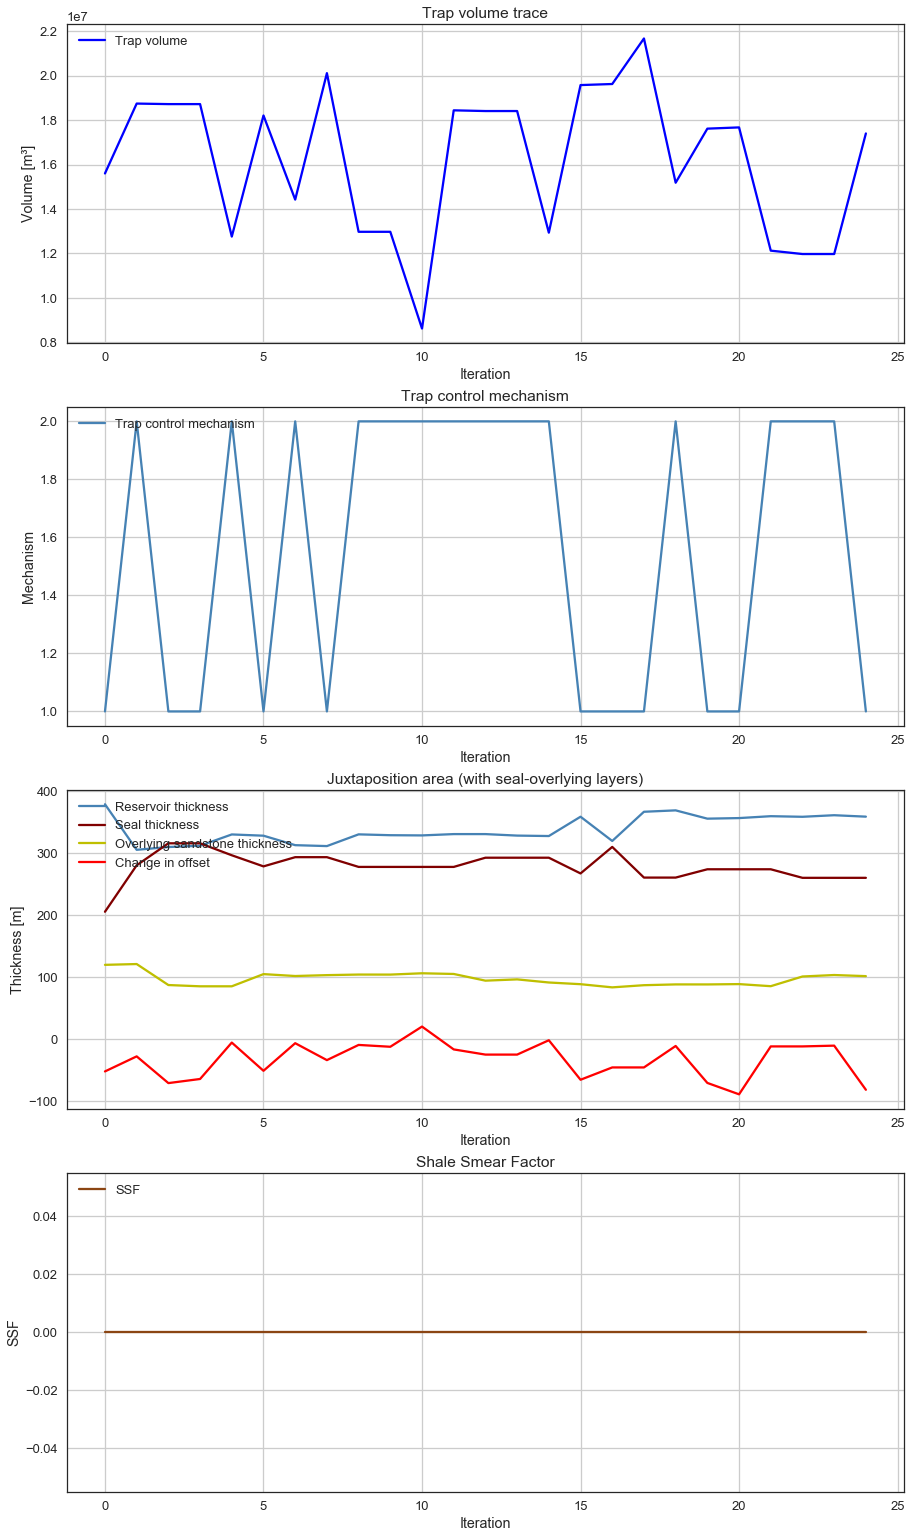

In [27]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


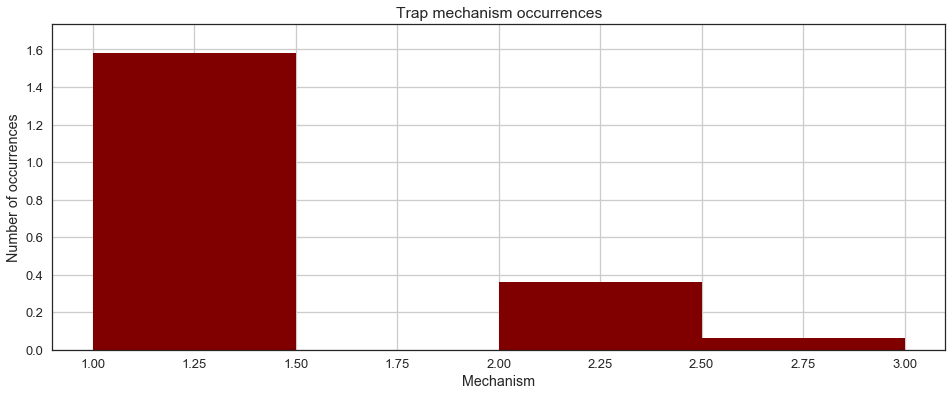

In [31]:
figsize(16, 6)
_hist1 = plt.hist(trap_control_trace_L, bins=4, normed=True, 
                  histtype="stepfilled", color = "maroon")
plt.title("Trap mechanism occurrences")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.ylabel("Number of occurrences")
plt.xlabel("Mechanism")

NameError: name '_hist_scale' is not defined

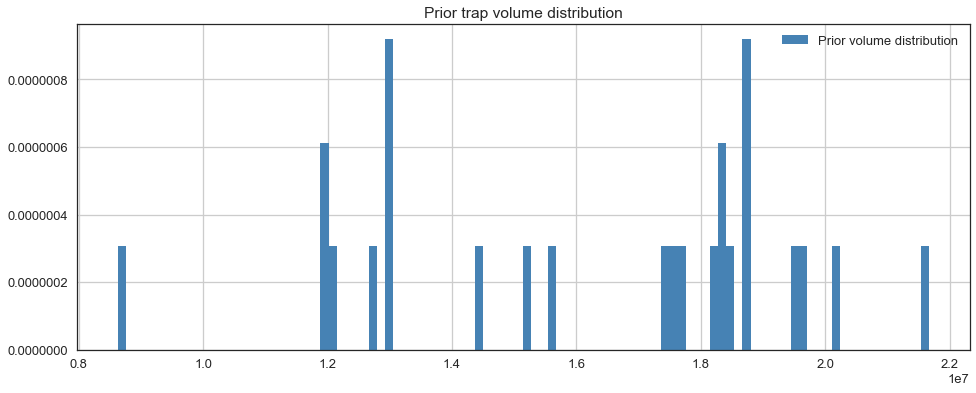

In [30]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
_hist2 = plt.hist(max_volume_trace_L, bins=100, normed=True, 
                  histtype="stepfilled",label="Prosterior volume distribution", color="indianred", alpha = 0.8)
_hist_scale = np.append(_hist1[0],_hist2[0])
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist_scale), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist_scale), label="Prior volume median", linestyles=":", color = "steelblue")
plt.vlines(max_volume_trace_L.mean(), 0, 1.1 * np.max(_hist_scale), label="Posterior volume mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(max_volume_trace_L), 0, 1.1 * np.max(_hist_scale), label="Posterior volume median", linestyles=":", color = "indianred")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist_scale)+1, np.max(_hist_scale)/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist_scale))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

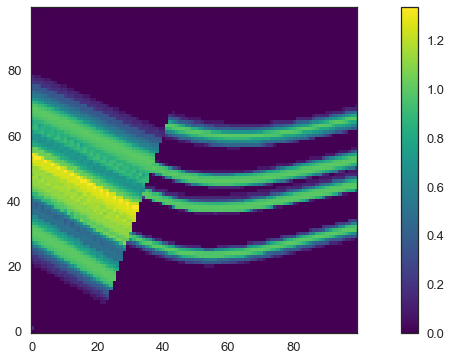

In [37]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

Bayes action (minimum) at risk r 0.50: 20480000.00 --- expected loss: 2400390.00
Bayes action (minimum) at risk r 0.75: 20416000.00 --- expected loss: 3427900.00
Bayes action (minimum) at risk r 1.00: 18856000.00 --- expected loss: 4299340.00
Bayes action (minimum) at risk r 1.25: 18640000.00 --- expected loss: 5061300.00
Bayes action (minimum) at risk r 1.50: 18408000.00 --- expected loss: 5799120.00


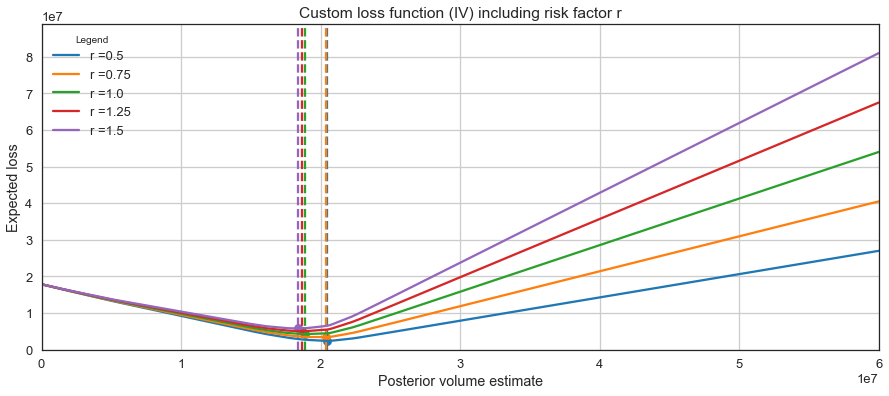

In [38]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace_L, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Posterior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()


In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()

In [ ]:
#figsize(16, 9)
#
## No reduced uncertainty, different risks
#BA_before = np.zeros_like(risks_s)
#EL_before = np.zeros_like(risks_s)
#expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()
#
#counter = 0
#for r in risks_s:
#    loss = [expected_loss(e, r) for e in estimates_s]
#    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
#    #print(_min_score)
#    if _min_score < 0:
#        _min_score = 0
#    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
#    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
#    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
#    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
#    BA_before[counter] = _min_score
#    EL_before[counter] = expected_loss(_min_score,r)
#    counter += 1
#

In [ ]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [ ]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)